##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2023-11-16 13:53:10.615881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 13:53:10.615930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 13:53:10.617515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Watching beautiful women sneaking around, playing cops and robbers is one of the most delightful guilty pleasures the medium film lets me enjoy. So The House on Carroll Street was not entirely a waste of time, although the story is contrived and the screenplay uninspired and somewhat irritating.<br /><br />There are many allusions to different Hitchcock pictures, not least the choice of Kelly McGillis in the starring role. She is dressed up as Grace Kelly, and she is not far off the mark. Not at all. But her character is not convincing. The way she is introduced to the audience, she should be someone with political convictions and a purpose in life. After all the movie deals with a clearly defined time period, true events and a specific issue. But the story degenerates within the first minutes into a sorry run-off-the-mill crime story with unbelievable coincidences, high predictability and a set of two dimensional characters. This is all the more regrettable, as the performa

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[147, 300, 362, ...,   0,   0,   0],
       [  4, 579,   5, ...,   0,   0,   0],
       [  2, 348,  12, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Watching beautiful women sneaking around, playing cops and robbers is one of the most delightful guilty pleasures the medium film lets me enjoy. So The House on Carroll Street was not entirely a waste of time, although the story is contrived and the screenplay uninspired and somewhat irritating.<br /><br />There are many allusions to different Hitchcock pictures, not least the choice of Kelly McGillis in the starring role. She is dressed up as Grace Kelly, and she is not far off the mark. Not at all. But her character is not convincing. The way she is introduced to the audience, she should be someone with political convictions and a purpose in life. After all the movie deals with a clearly defined time period, true events and a specific issue. But the story degenerates within the first minutes into a sorry run-off-the-mill crime story with unbelievable coincidences, high predictability and a set of two dimensional characters. This is all the more regrettable, as the perfor

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


[0.00856274]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 86ms/step


[0.00856275]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2023-11-16 13:53:32.243442: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


I0000 00:00:1700142813.152065   83765 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/391 [..............................] - ETA: 54:19 - loss: 0.6931 - accuracy: 0.5156

  2/391 [..............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.5156 

  3/391 [..............................] - ETA: 1:22 - loss: 0.6932 - accuracy: 0.5312

  4/391 [..............................] - ETA: 1:24 - loss: 0.6932 - accuracy: 0.5156

  5/391 [..............................] - ETA: 1:26 - loss: 0.6931 - accuracy: 0.5156

  6/391 [..............................] - ETA: 1:26 - loss: 0.6931 - accuracy: 0.5234

  7/391 [..............................] - ETA: 1:24 - loss: 0.6931 - accuracy: 0.5112

  8/391 [..............................] - ETA: 1:24 - loss: 0.6932 - accuracy: 0.5176

  9/391 [..............................] - ETA: 1:24 - loss: 0.6931 - accuracy: 0.5069

 10/391 [..............................] - ETA: 1:24 - loss: 0.6931 - accuracy: 0.5016

 11/391 [..............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.5000

 12/391 [..............................] - ETA: 1:23 - loss: 0.6931 - accuracy: 0.4922

 13/391 [..............................] - ETA: 1:25 - loss: 0.6932 - accuracy: 0.4928

 14/391 [>.............................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4989

 15/391 [>.............................] - ETA: 1:19 - loss: 0.6932 - accuracy: 0.5010

 16/391 [>.............................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4971

 17/391 [>.............................] - ETA: 1:15 - loss: 0.6931 - accuracy: 0.4954

 18/391 [>.............................] - ETA: 1:15 - loss: 0.6931 - accuracy: 0.4965

 19/391 [>.............................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.4967

 20/391 [>.............................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.4977

 21/391 [>.............................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4955

 22/391 [>.............................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4979

 23/391 [>.............................] - ETA: 1:08 - loss: 0.6931 - accuracy: 0.4986

 24/391 [>.............................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.4967

 25/391 [>.............................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.4975

 27/391 [=>............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.5000

 29/391 [=>............................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4989 

 30/391 [=>............................] - ETA: 58s - loss: 0.6931 - accuracy: 0.4984

 32/391 [=>............................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4980

 33/391 [=>............................] - ETA: 54s - loss: 0.6932 - accuracy: 0.4995

 34/391 [=>............................] - ETA: 54s - loss: 0.6932 - accuracy: 0.5014

 36/391 [=>............................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5056

 37/391 [=>............................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5063

 38/391 [=>............................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5053

 39/391 [=>............................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5036

 40/391 [==>...........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5055

 41/391 [==>...........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5046

 42/391 [==>...........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5071

 44/391 [==>...........................] - ETA: 51s - loss: 0.6932 - accuracy: 0.5071

 46/391 [==>...........................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5105

 47/391 [==>...........................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5086

 48/391 [==>...........................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5098

 49/391 [==>...........................] - ETA: 48s - loss: 0.6932 - accuracy: 0.5099

 50/391 [==>...........................] - ETA: 48s - loss: 0.6932 - accuracy: 0.5103

 51/391 [==>...........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5110

 53/391 [===>..........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5106

 54/391 [===>..........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5090

 55/391 [===>..........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5065

 57/391 [===>..........................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5077

 58/391 [===>..........................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5078

 59/391 [===>..........................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5072

 61/391 [===>..........................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5049

 62/391 [===>..........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5038

 63/391 [===>..........................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5027

 65/391 [===>..........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5041

 66/391 [====>.........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5031

 67/391 [====>.........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5030

 68/391 [====>.........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5032

 69/391 [====>.........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5036

 70/391 [====>.........................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5025

 72/391 [====>.........................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5024

 73/391 [====>.........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5019

 75/391 [====>.........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5015

 77/391 [====>.........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5028

 79/391 [=====>........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5038

 80/391 [=====>........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5045

 81/391 [=====>........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5048

 82/391 [=====>........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5051

 84/391 [=====>........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5041

 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5045

 87/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5036

 88/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5037

 89/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5039

 90/391 [=====>........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5038

 92/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5053

 94/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5052

 95/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5049

 96/391 [======>.......................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5055

 97/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5066

 98/391 [======>.......................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5070

100/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5066

102/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5063

104/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5057

105/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5046

107/391 [=======>......................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5041

109/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5036

111/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5034

112/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5036

114/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5040

115/391 [=======>......................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5037

116/391 [=======>......................] - ETA: 31s - loss: 0.6928 - accuracy: 0.5044

118/391 [========>.....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.5037

120/391 [========>.....................] - ETA: 30s - loss: 0.6928 - accuracy: 0.5030

122/391 [========>.....................] - ETA: 30s - loss: 0.6928 - accuracy: 0.5033

124/391 [========>.....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5040

125/391 [========>.....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5038

126/391 [========>.....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5031

127/391 [========>.....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5025

128/391 [========>.....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5028

129/391 [========>.....................] - ETA: 29s - loss: 0.6927 - accuracy: 0.5028

130/391 [========>.....................] - ETA: 29s - loss: 0.6927 - accuracy: 0.5022

131/391 [=========>....................] - ETA: 28s - loss: 0.6927 - accuracy: 0.5016

132/391 [=========>....................] - ETA: 28s - loss: 0.6927 - accuracy: 0.5008

134/391 [=========>....................] - ETA: 28s - loss: 0.6927 - accuracy: 0.5013

135/391 [=========>....................] - ETA: 28s - loss: 0.6927 - accuracy: 0.5017

136/391 [=========>....................] - ETA: 27s - loss: 0.6926 - accuracy: 0.5011

137/391 [=========>....................] - ETA: 27s - loss: 0.6926 - accuracy: 0.5017

139/391 [=========>....................] - ETA: 27s - loss: 0.6926 - accuracy: 0.5028

140/391 [=========>....................] - ETA: 27s - loss: 0.6926 - accuracy: 0.5019

142/391 [=========>....................] - ETA: 26s - loss: 0.6926 - accuracy: 0.5018

144/391 [==========>...................] - ETA: 26s - loss: 0.6926 - accuracy: 0.5004

146/391 [==========>...................] - ETA: 26s - loss: 0.6925 - accuracy: 0.5000

147/391 [==========>...................] - ETA: 25s - loss: 0.6925 - accuracy: 0.4999

149/391 [==========>...................] - ETA: 25s - loss: 0.6925 - accuracy: 0.4997

151/391 [==========>...................] - ETA: 25s - loss: 0.6924 - accuracy: 0.4992

152/391 [==========>...................] - ETA: 24s - loss: 0.6924 - accuracy: 0.4991

153/391 [==========>...................] - ETA: 24s - loss: 0.6924 - accuracy: 0.4989

154/391 [==========>...................] - ETA: 24s - loss: 0.6924 - accuracy: 0.4994

156/391 [==========>...................] - ETA: 24s - loss: 0.6924 - accuracy: 0.4987

158/391 [===========>..................] - ETA: 23s - loss: 0.6924 - accuracy: 0.4985

159/391 [===========>..................] - ETA: 23s - loss: 0.6924 - accuracy: 0.4987

160/391 [===========>..................] - ETA: 23s - loss: 0.6924 - accuracy: 0.4989

161/391 [===========>..................] - ETA: 23s - loss: 0.6923 - accuracy: 0.4987

162/391 [===========>..................] - ETA: 23s - loss: 0.6923 - accuracy: 0.4987

163/391 [===========>..................] - ETA: 23s - loss: 0.6923 - accuracy: 0.4985

164/391 [===========>..................] - ETA: 22s - loss: 0.6923 - accuracy: 0.4990

165/391 [===========>..................] - ETA: 22s - loss: 0.6923 - accuracy: 0.4990

166/391 [===========>..................] - ETA: 22s - loss: 0.6923 - accuracy: 0.4992

168/391 [===========>..................] - ETA: 22s - loss: 0.6923 - accuracy: 0.4999

170/391 [============>.................] - ETA: 22s - loss: 0.6923 - accuracy: 0.5002

171/391 [============>.................] - ETA: 22s - loss: 0.6923 - accuracy: 0.5005

172/391 [============>.................] - ETA: 22s - loss: 0.6923 - accuracy: 0.5003

173/391 [============>.................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5002

174/391 [============>.................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5002

175/391 [============>.................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5004

177/391 [============>.................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5000

179/391 [============>.................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5001

181/391 [============>.................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5001

182/391 [============>.................] - ETA: 21s - loss: 0.6922 - accuracy: 0.5004

184/391 [=============>................] - ETA: 20s - loss: 0.6921 - accuracy: 0.5000

185/391 [=============>................] - ETA: 20s - loss: 0.6921 - accuracy: 0.5001

187/391 [=============>................] - ETA: 20s - loss: 0.6921 - accuracy: 0.5008

189/391 [=============>................] - ETA: 19s - loss: 0.6921 - accuracy: 0.5011

190/391 [=============>................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5004

191/391 [=============>................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5005

192/391 [=============>................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5002

193/391 [=============>................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5010

195/391 [=============>................] - ETA: 19s - loss: 0.6920 - accuracy: 0.5013

196/391 [==============>...............] - ETA: 19s - loss: 0.6919 - accuracy: 0.5015

198/391 [==============>...............] - ETA: 19s - loss: 0.6919 - accuracy: 0.5016

199/391 [==============>...............] - ETA: 19s - loss: 0.6919 - accuracy: 0.5013

200/391 [==============>...............] - ETA: 18s - loss: 0.6919 - accuracy: 0.5017

201/391 [==============>...............] - ETA: 18s - loss: 0.6919 - accuracy: 0.5012

203/391 [==============>...............] - ETA: 18s - loss: 0.6918 - accuracy: 0.5014

205/391 [==============>...............] - ETA: 18s - loss: 0.6918 - accuracy: 0.4999

206/391 [==============>...............] - ETA: 18s - loss: 0.6918 - accuracy: 0.4999

208/391 [==============>...............] - ETA: 17s - loss: 0.6917 - accuracy: 0.4998

209/391 [===============>..............] - ETA: 17s - loss: 0.6917 - accuracy: 0.4999

210/391 [===============>..............] - ETA: 17s - loss: 0.6916 - accuracy: 0.4999

212/391 [===============>..............] - ETA: 17s - loss: 0.6916 - accuracy: 0.4996

214/391 [===============>..............] - ETA: 17s - loss: 0.6915 - accuracy: 0.4997

216/391 [===============>..............] - ETA: 16s - loss: 0.6914 - accuracy: 0.4998

217/391 [===============>..............] - ETA: 16s - loss: 0.6914 - accuracy: 0.4994

218/391 [===============>..............] - ETA: 16s - loss: 0.6914 - accuracy: 0.4996

220/391 [===============>..............] - ETA: 16s - loss: 0.6914 - accuracy: 0.4996

222/391 [================>.............] - ETA: 16s - loss: 0.6913 - accuracy: 0.5001

224/391 [================>.............] - ETA: 15s - loss: 0.6912 - accuracy: 0.5001

225/391 [================>.............] - ETA: 15s - loss: 0.6911 - accuracy: 0.4996

227/391 [================>.............] - ETA: 15s - loss: 0.6910 - accuracy: 0.5000

229/391 [================>.............] - ETA: 15s - loss: 0.6909 - accuracy: 0.4997

231/391 [================>.............] - ETA: 14s - loss: 0.6908 - accuracy: 0.4993

233/391 [================>.............] - ETA: 14s - loss: 0.6906 - accuracy: 0.4989

235/391 [=================>............] - ETA: 14s - loss: 0.6904 - accuracy: 0.4984

237/391 [=================>............] - ETA: 14s - loss: 0.6901 - accuracy: 0.4991

239/391 [=================>............] - ETA: 13s - loss: 0.6896 - accuracy: 0.5007

240/391 [=================>............] - ETA: 13s - loss: 0.6894 - accuracy: 0.5014

242/391 [=================>............] - ETA: 13s - loss: 0.6894 - accuracy: 0.5017

244/391 [=================>............] - ETA: 13s - loss: 0.6891 - accuracy: 0.5024

245/391 [=================>............] - ETA: 13s - loss: 0.6888 - accuracy: 0.5030

247/391 [=================>............] - ETA: 13s - loss: 0.6887 - accuracy: 0.5034

249/391 [==================>...........] - ETA: 12s - loss: 0.6889 - accuracy: 0.5028

250/391 [==================>...........] - ETA: 12s - loss: 0.6887 - accuracy: 0.5031

252/391 [==================>...........] - ETA: 12s - loss: 0.6884 - accuracy: 0.5038

254/391 [==================>...........] - ETA: 12s - loss: 0.6878 - accuracy: 0.5049

255/391 [==================>...........] - ETA: 12s - loss: 0.6875 - accuracy: 0.5058

257/391 [==================>...........] - ETA: 12s - loss: 0.6877 - accuracy: 0.5067

259/391 [==================>...........] - ETA: 11s - loss: 0.6871 - accuracy: 0.5081

261/391 [===================>..........] - ETA: 11s - loss: 0.6868 - accuracy: 0.5089

262/391 [===================>..........] - ETA: 11s - loss: 0.6865 - accuracy: 0.5092

264/391 [===================>..........] - ETA: 11s - loss: 0.6859 - accuracy: 0.5105

265/391 [===================>..........] - ETA: 11s - loss: 0.6856 - accuracy: 0.5110

267/391 [===================>..........] - ETA: 10s - loss: 0.6851 - accuracy: 0.5120

268/391 [===================>..........] - ETA: 10s - loss: 0.6847 - accuracy: 0.5127

270/391 [===================>..........] - ETA: 10s - loss: 0.6844 - accuracy: 0.5130

271/391 [===================>..........] - ETA: 10s - loss: 0.6842 - accuracy: 0.5132

273/391 [===================>..........] - ETA: 10s - loss: 0.6835 - accuracy: 0.5143

275/391 [====================>.........] - ETA: 10s - loss: 0.6830 - accuracy: 0.5149

277/391 [====================>.........] - ETA: 9s - loss: 0.6824 - accuracy: 0.5161 

279/391 [====================>.........] - ETA: 9s - loss: 0.6814 - accuracy: 0.5178

281/391 [====================>.........] - ETA: 9s - loss: 0.6812 - accuracy: 0.5190

283/391 [====================>.........] - ETA: 9s - loss: 0.6805 - accuracy: 0.5206

285/391 [====================>.........] - ETA: 9s - loss: 0.6799 - accuracy: 0.5219

287/391 [=====================>........] - ETA: 9s - loss: 0.6793 - accuracy: 0.5231

289/391 [=====================>........] - ETA: 8s - loss: 0.6789 - accuracy: 0.5235

290/391 [=====================>........] - ETA: 8s - loss: 0.6786 - accuracy: 0.5240

292/391 [=====================>........] - ETA: 8s - loss: 0.6779 - accuracy: 0.5244

293/391 [=====================>........] - ETA: 8s - loss: 0.6775 - accuracy: 0.5249

294/391 [=====================>........] - ETA: 8s - loss: 0.6772 - accuracy: 0.5256

296/391 [=====================>........] - ETA: 8s - loss: 0.6766 - accuracy: 0.5266

298/391 [=====================>........] - ETA: 7s - loss: 0.6766 - accuracy: 0.5272

299/391 [=====================>........] - ETA: 7s - loss: 0.6765 - accuracy: 0.5277

301/391 [======================>.......] - ETA: 7s - loss: 0.6769 - accuracy: 0.5279

303/391 [======================>.......] - ETA: 7s - loss: 0.6766 - accuracy: 0.5286

305/391 [======================>.......] - ETA: 7s - loss: 0.6765 - accuracy: 0.5296

306/391 [======================>.......] - ETA: 7s - loss: 0.6765 - accuracy: 0.5298

307/391 [======================>.......] - ETA: 7s - loss: 0.6763 - accuracy: 0.5302

309/391 [======================>.......] - ETA: 6s - loss: 0.6759 - accuracy: 0.5311

310/391 [======================>.......] - ETA: 6s - loss: 0.6756 - accuracy: 0.5316

311/391 [======================>.......] - ETA: 6s - loss: 0.6754 - accuracy: 0.5315

313/391 [=======================>......] - ETA: 6s - loss: 0.6750 - accuracy: 0.5315

315/391 [=======================>......] - ETA: 6s - loss: 0.6744 - accuracy: 0.5319

316/391 [=======================>......] - ETA: 6s - loss: 0.6742 - accuracy: 0.5319

318/391 [=======================>......] - ETA: 6s - loss: 0.6736 - accuracy: 0.5319

320/391 [=======================>......] - ETA: 5s - loss: 0.6732 - accuracy: 0.5316

321/391 [=======================>......] - ETA: 5s - loss: 0.6734 - accuracy: 0.5314

323/391 [=======================>......] - ETA: 5s - loss: 0.6728 - accuracy: 0.5315

324/391 [=======================>......] - ETA: 5s - loss: 0.6727 - accuracy: 0.5313

325/391 [=======================>......] - ETA: 5s - loss: 0.6724 - accuracy: 0.5312

326/391 [========================>.....] - ETA: 5s - loss: 0.6720 - accuracy: 0.5315

327/391 [========================>.....] - ETA: 5s - loss: 0.6717 - accuracy: 0.5315

329/391 [========================>.....] - ETA: 5s - loss: 0.6713 - accuracy: 0.5320

331/391 [========================>.....] - ETA: 4s - loss: 0.6707 - accuracy: 0.5332

332/391 [========================>.....] - ETA: 4s - loss: 0.6705 - accuracy: 0.5338

333/391 [========================>.....] - ETA: 4s - loss: 0.6704 - accuracy: 0.5342

335/391 [========================>.....] - ETA: 4s - loss: 0.6698 - accuracy: 0.5359

336/391 [========================>.....] - ETA: 4s - loss: 0.6696 - accuracy: 0.5364

338/391 [========================>.....] - ETA: 4s - loss: 0.6691 - accuracy: 0.5376

339/391 [=========================>....] - ETA: 4s - loss: 0.6689 - accuracy: 0.5383

341/391 [=========================>....] - ETA: 4s - loss: 0.6684 - accuracy: 0.5389

343/391 [=========================>....] - ETA: 3s - loss: 0.6676 - accuracy: 0.5398

345/391 [=========================>....] - ETA: 3s - loss: 0.6673 - accuracy: 0.5404

346/391 [=========================>....] - ETA: 3s - loss: 0.6671 - accuracy: 0.5407

348/391 [=========================>....] - ETA: 3s - loss: 0.6666 - accuracy: 0.5415

350/391 [=========================>....] - ETA: 3s - loss: 0.6662 - accuracy: 0.5424

351/391 [=========================>....] - ETA: 3s - loss: 0.6662 - accuracy: 0.5426

353/391 [==========================>...] - ETA: 3s - loss: 0.6657 - accuracy: 0.5436

354/391 [==========================>...] - ETA: 2s - loss: 0.6654 - accuracy: 0.5441

355/391 [==========================>...] - ETA: 2s - loss: 0.6649 - accuracy: 0.5448

357/391 [==========================>...] - ETA: 2s - loss: 0.6646 - accuracy: 0.5455

359/391 [==========================>...] - ETA: 2s - loss: 0.6641 - accuracy: 0.5463

361/391 [==========================>...] - ETA: 2s - loss: 0.6637 - accuracy: 0.5465

363/391 [==========================>...] - ETA: 2s - loss: 0.6635 - accuracy: 0.5465

365/391 [===========================>..] - ETA: 2s - loss: 0.6631 - accuracy: 0.5468

367/391 [===========================>..] - ETA: 1s - loss: 0.6627 - accuracy: 0.5472

368/391 [===========================>..] - ETA: 1s - loss: 0.6624 - accuracy: 0.5475

370/391 [===========================>..] - ETA: 1s - loss: 0.6618 - accuracy: 0.5487

372/391 [===========================>..] - ETA: 1s - loss: 0.6612 - accuracy: 0.5502

373/391 [===========================>..] - ETA: 1s - loss: 0.6611 - accuracy: 0.5507

374/391 [===========================>..] - ETA: 1s - loss: 0.6609 - accuracy: 0.5511

375/391 [===========================>..] - ETA: 1s - loss: 0.6606 - accuracy: 0.5516

376/391 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.5519

378/391 [============================>.] - ETA: 1s - loss: 0.6597 - accuracy: 0.5532

379/391 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.5535

381/391 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.5541

382/391 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.5545

384/391 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.5551

386/391 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.5561

387/391 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.5566

388/391 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.5568

389/391 [============================>.] - ETA: 0s - loss: 0.6569 - accuracy: 0.5572

391/391 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.5580

391/391 [==============================] - 43s 88ms/step - loss: 0.6566 - accuracy: 0.5580 - val_loss: 0.5489 - val_accuracy: 0.7505


Epoch 2/10


  1/391 [..............................] - ETA: 3:11 - loss: 0.5619 - accuracy: 0.7812

  2/391 [..............................] - ETA: 20s - loss: 0.5747 - accuracy: 0.7734 

  3/391 [..............................] - ETA: 20s - loss: 0.5909 - accuracy: 0.7396

  5/391 [..............................] - ETA: 19s - loss: 0.5777 - accuracy: 0.7344

  6/391 [..............................] - ETA: 19s - loss: 0.5740 - accuracy: 0.7344

  8/391 [..............................] - ETA: 18s - loss: 0.5648 - accuracy: 0.7324

 10/391 [..............................] - ETA: 18s - loss: 0.5505 - accuracy: 0.7328

 11/391 [..............................] - ETA: 18s - loss: 0.5532 - accuracy: 0.7244

 12/391 [..............................] - ETA: 19s - loss: 0.5603 - accuracy: 0.7096

 13/391 [..............................] - ETA: 19s - loss: 0.5656 - accuracy: 0.7019

 15/391 [>.............................] - ETA: 18s - loss: 0.5750 - accuracy: 0.6812

 17/391 [>.............................] - ETA: 18s - loss: 0.5787 - accuracy: 0.6618

 19/391 [>.............................] - ETA: 18s - loss: 0.5807 - accuracy: 0.6480

 21/391 [>.............................] - ETA: 17s - loss: 0.5799 - accuracy: 0.6421

 22/391 [>.............................] - ETA: 17s - loss: 0.5820 - accuracy: 0.6364

 23/391 [>.............................] - ETA: 17s - loss: 0.5817 - accuracy: 0.6393

 25/391 [>.............................] - ETA: 17s - loss: 0.5809 - accuracy: 0.6475

 27/391 [=>............................] - ETA: 17s - loss: 0.5837 - accuracy: 0.6510

 29/391 [=>............................] - ETA: 17s - loss: 0.5854 - accuracy: 0.6584

 31/391 [=>............................] - ETA: 17s - loss: 0.5864 - accuracy: 0.6623

 33/391 [=>............................] - ETA: 16s - loss: 0.5878 - accuracy: 0.6681

 35/391 [=>............................] - ETA: 16s - loss: 0.5877 - accuracy: 0.6683

 37/391 [=>............................] - ETA: 16s - loss: 0.5875 - accuracy: 0.6626

 38/391 [=>............................] - ETA: 16s - loss: 0.5877 - accuracy: 0.6604

 40/391 [==>...........................] - ETA: 16s - loss: 0.5856 - accuracy: 0.6613

 41/391 [==>...........................] - ETA: 16s - loss: 0.5848 - accuracy: 0.6593

 43/391 [==>...........................] - ETA: 16s - loss: 0.5852 - accuracy: 0.6562

 44/391 [==>...........................] - ETA: 16s - loss: 0.5832 - accuracy: 0.6584

 45/391 [==>...........................] - ETA: 16s - loss: 0.5828 - accuracy: 0.6569

 47/391 [==>...........................] - ETA: 16s - loss: 0.5819 - accuracy: 0.6572

 48/391 [==>...........................] - ETA: 17s - loss: 0.5817 - accuracy: 0.6559

 50/391 [==>...........................] - ETA: 17s - loss: 0.5806 - accuracy: 0.6550

 51/391 [==>...........................] - ETA: 17s - loss: 0.5804 - accuracy: 0.6559

 52/391 [==>...........................] - ETA: 17s - loss: 0.5791 - accuracy: 0.6584

 53/391 [===>..........................] - ETA: 17s - loss: 0.5775 - accuracy: 0.6598

 55/391 [===>..........................] - ETA: 16s - loss: 0.5756 - accuracy: 0.6645

 57/391 [===>..........................] - ETA: 16s - loss: 0.5739 - accuracy: 0.6678

 58/391 [===>..........................] - ETA: 16s - loss: 0.5714 - accuracy: 0.6713

 59/391 [===>..........................] - ETA: 16s - loss: 0.5695 - accuracy: 0.6737

 61/391 [===>..........................] - ETA: 16s - loss: 0.5667 - accuracy: 0.6775

 63/391 [===>..........................] - ETA: 16s - loss: 0.5636 - accuracy: 0.6813

 64/391 [===>..........................] - ETA: 16s - loss: 0.5622 - accuracy: 0.6831

 66/391 [====>.........................] - ETA: 16s - loss: 0.5605 - accuracy: 0.6863

 67/391 [====>.........................] - ETA: 16s - loss: 0.5589 - accuracy: 0.6884

 69/391 [====>.........................] - ETA: 16s - loss: 0.5580 - accuracy: 0.6900

 71/391 [====>.........................] - ETA: 15s - loss: 0.5569 - accuracy: 0.6923

 73/391 [====>.........................] - ETA: 15s - loss: 0.5555 - accuracy: 0.6948

 75/391 [====>.........................] - ETA: 15s - loss: 0.5537 - accuracy: 0.6977

 76/391 [====>.........................] - ETA: 15s - loss: 0.5518 - accuracy: 0.6998

 77/391 [====>.........................] - ETA: 15s - loss: 0.5500 - accuracy: 0.7015

 78/391 [====>.........................] - ETA: 15s - loss: 0.5493 - accuracy: 0.7021

 79/391 [=====>........................] - ETA: 15s - loss: 0.5474 - accuracy: 0.7043

 81/391 [=====>........................] - ETA: 15s - loss: 0.5450 - accuracy: 0.7076

 83/391 [=====>........................] - ETA: 15s - loss: 0.5419 - accuracy: 0.7107

 85/391 [=====>........................] - ETA: 15s - loss: 0.5396 - accuracy: 0.7129

 87/391 [=====>........................] - ETA: 14s - loss: 0.5382 - accuracy: 0.7143

 88/391 [=====>........................] - ETA: 14s - loss: 0.5378 - accuracy: 0.7147

 89/391 [=====>........................] - ETA: 14s - loss: 0.5365 - accuracy: 0.7161

 91/391 [=====>........................] - ETA: 14s - loss: 0.5342 - accuracy: 0.7184

 93/391 [======>.......................] - ETA: 14s - loss: 0.5319 - accuracy: 0.7204

 95/391 [======>.......................] - ETA: 14s - loss: 0.5307 - accuracy: 0.7219

 97/391 [======>.......................] - ETA: 14s - loss: 0.5281 - accuracy: 0.7237

 98/391 [======>.......................] - ETA: 14s - loss: 0.5270 - accuracy: 0.7240

100/391 [======>.......................] - ETA: 14s - loss: 0.5251 - accuracy: 0.7255

102/391 [======>.......................] - ETA: 14s - loss: 0.5242 - accuracy: 0.7272

103/391 [======>.......................] - ETA: 14s - loss: 0.5234 - accuracy: 0.7282

104/391 [======>.......................] - ETA: 14s - loss: 0.5221 - accuracy: 0.7296

105/391 [=======>......................] - ETA: 14s - loss: 0.5229 - accuracy: 0.7296

106/391 [=======>......................] - ETA: 13s - loss: 0.5215 - accuracy: 0.7304

108/391 [=======>......................] - ETA: 13s - loss: 0.5197 - accuracy: 0.7323

110/391 [=======>......................] - ETA: 13s - loss: 0.5180 - accuracy: 0.7341

111/391 [=======>......................] - ETA: 13s - loss: 0.5175 - accuracy: 0.7349

113/391 [=======>......................] - ETA: 13s - loss: 0.5179 - accuracy: 0.7353

115/391 [=======>......................] - ETA: 13s - loss: 0.5174 - accuracy: 0.7355

117/391 [=======>......................] - ETA: 13s - loss: 0.5167 - accuracy: 0.7360

119/391 [========>.....................] - ETA: 13s - loss: 0.5158 - accuracy: 0.7369

120/391 [========>.....................] - ETA: 13s - loss: 0.5154 - accuracy: 0.7370

121/391 [========>.....................] - ETA: 13s - loss: 0.5148 - accuracy: 0.7382

123/391 [========>.....................] - ETA: 13s - loss: 0.5145 - accuracy: 0.7382

125/391 [========>.....................] - ETA: 13s - loss: 0.5137 - accuracy: 0.7386

126/391 [========>.....................] - ETA: 12s - loss: 0.5125 - accuracy: 0.7395

127/391 [========>.....................] - ETA: 12s - loss: 0.5126 - accuracy: 0.7395

128/391 [========>.....................] - ETA: 12s - loss: 0.5128 - accuracy: 0.7391

130/391 [========>.....................] - ETA: 12s - loss: 0.5121 - accuracy: 0.7399

132/391 [=========>....................] - ETA: 12s - loss: 0.5103 - accuracy: 0.7414

134/391 [=========>....................] - ETA: 12s - loss: 0.5087 - accuracy: 0.7418

135/391 [=========>....................] - ETA: 12s - loss: 0.5082 - accuracy: 0.7422

136/391 [=========>....................] - ETA: 12s - loss: 0.5080 - accuracy: 0.7428

137/391 [=========>....................] - ETA: 12s - loss: 0.5074 - accuracy: 0.7433

139/391 [=========>....................] - ETA: 12s - loss: 0.5069 - accuracy: 0.7442

140/391 [=========>....................] - ETA: 12s - loss: 0.5074 - accuracy: 0.7443

142/391 [=========>....................] - ETA: 12s - loss: 0.5060 - accuracy: 0.7448

143/391 [=========>....................] - ETA: 12s - loss: 0.5050 - accuracy: 0.7458

144/391 [==========>...................] - ETA: 12s - loss: 0.5051 - accuracy: 0.7459

145/391 [==========>...................] - ETA: 12s - loss: 0.5043 - accuracy: 0.7466

147/391 [==========>...................] - ETA: 11s - loss: 0.5036 - accuracy: 0.7470

148/391 [==========>...................] - ETA: 11s - loss: 0.5029 - accuracy: 0.7477

150/391 [==========>...................] - ETA: 11s - loss: 0.5016 - accuracy: 0.7492

151/391 [==========>...................] - ETA: 11s - loss: 0.5006 - accuracy: 0.7498

153/391 [==========>...................] - ETA: 11s - loss: 0.4999 - accuracy: 0.7499

155/391 [==========>...................] - ETA: 11s - loss: 0.4989 - accuracy: 0.7504

156/391 [==========>...................] - ETA: 11s - loss: 0.4989 - accuracy: 0.7500

158/391 [===========>..................] - ETA: 11s - loss: 0.4981 - accuracy: 0.7511

160/391 [===========>..................] - ETA: 11s - loss: 0.4972 - accuracy: 0.7518

162/391 [===========>..................] - ETA: 11s - loss: 0.4959 - accuracy: 0.7530

164/391 [===========>..................] - ETA: 11s - loss: 0.4953 - accuracy: 0.7531

166/391 [===========>..................] - ETA: 11s - loss: 0.4949 - accuracy: 0.7528

168/391 [===========>..................] - ETA: 10s - loss: 0.4940 - accuracy: 0.7531

169/391 [===========>..................] - ETA: 10s - loss: 0.4937 - accuracy: 0.7536

170/391 [============>.................] - ETA: 10s - loss: 0.4933 - accuracy: 0.7539

171/391 [============>.................] - ETA: 10s - loss: 0.4933 - accuracy: 0.7543

172/391 [============>.................] - ETA: 10s - loss: 0.4928 - accuracy: 0.7545

174/391 [============>.................] - ETA: 10s - loss: 0.4917 - accuracy: 0.7554

175/391 [============>.................] - ETA: 10s - loss: 0.4914 - accuracy: 0.7559

176/391 [============>.................] - ETA: 10s - loss: 0.4914 - accuracy: 0.7561

178/391 [============>.................] - ETA: 10s - loss: 0.4898 - accuracy: 0.7575

179/391 [============>.................] - ETA: 10s - loss: 0.4887 - accuracy: 0.7581

180/391 [============>.................] - ETA: 10s - loss: 0.4878 - accuracy: 0.7587

182/391 [============>.................] - ETA: 10s - loss: 0.4877 - accuracy: 0.7583

184/391 [=============>................] - ETA: 10s - loss: 0.4875 - accuracy: 0.7583

186/391 [=============>................] - ETA: 10s - loss: 0.4876 - accuracy: 0.7587

188/391 [=============>................] - ETA: 9s - loss: 0.4865 - accuracy: 0.7594 

190/391 [=============>................] - ETA: 9s - loss: 0.4862 - accuracy: 0.7601

191/391 [=============>................] - ETA: 9s - loss: 0.4858 - accuracy: 0.7602

193/391 [=============>................] - ETA: 9s - loss: 0.4858 - accuracy: 0.7604

194/391 [=============>................] - ETA: 9s - loss: 0.4847 - accuracy: 0.7613

195/391 [=============>................] - ETA: 9s - loss: 0.4843 - accuracy: 0.7619

197/391 [==============>...............] - ETA: 9s - loss: 0.4837 - accuracy: 0.7628

198/391 [==============>...............] - ETA: 9s - loss: 0.4833 - accuracy: 0.7629

199/391 [==============>...............] - ETA: 9s - loss: 0.4830 - accuracy: 0.7632

200/391 [==============>...............] - ETA: 9s - loss: 0.4827 - accuracy: 0.7633

202/391 [==============>...............] - ETA: 9s - loss: 0.4820 - accuracy: 0.7637

203/391 [==============>...............] - ETA: 9s - loss: 0.4816 - accuracy: 0.7639

204/391 [==============>...............] - ETA: 9s - loss: 0.4806 - accuracy: 0.7645

206/391 [==============>...............] - ETA: 9s - loss: 0.4799 - accuracy: 0.7643

208/391 [==============>...............] - ETA: 8s - loss: 0.4793 - accuracy: 0.7652

210/391 [===============>..............] - ETA: 8s - loss: 0.4781 - accuracy: 0.7664

212/391 [===============>..............] - ETA: 8s - loss: 0.4771 - accuracy: 0.7670

214/391 [===============>..............] - ETA: 8s - loss: 0.4766 - accuracy: 0.7672

215/391 [===============>..............] - ETA: 8s - loss: 0.4762 - accuracy: 0.7674

216/391 [===============>..............] - ETA: 8s - loss: 0.4758 - accuracy: 0.7676

217/391 [===============>..............] - ETA: 8s - loss: 0.4749 - accuracy: 0.7681

219/391 [===============>..............] - ETA: 8s - loss: 0.4741 - accuracy: 0.7683

220/391 [===============>..............] - ETA: 8s - loss: 0.4736 - accuracy: 0.7685

222/391 [================>.............] - ETA: 8s - loss: 0.4727 - accuracy: 0.7687

223/391 [================>.............] - ETA: 8s - loss: 0.4726 - accuracy: 0.7686

225/391 [================>.............] - ETA: 8s - loss: 0.4717 - accuracy: 0.7690

226/391 [================>.............] - ETA: 8s - loss: 0.4714 - accuracy: 0.7691

228/391 [================>.............] - ETA: 8s - loss: 0.4706 - accuracy: 0.7699

229/391 [================>.............] - ETA: 8s - loss: 0.4705 - accuracy: 0.7701

230/391 [================>.............] - ETA: 8s - loss: 0.4705 - accuracy: 0.7702

232/391 [================>.............] - ETA: 8s - loss: 0.4704 - accuracy: 0.7705

234/391 [================>.............] - ETA: 7s - loss: 0.4697 - accuracy: 0.7713

236/391 [=================>............] - ETA: 7s - loss: 0.4686 - accuracy: 0.7721

237/391 [=================>............] - ETA: 7s - loss: 0.4680 - accuracy: 0.7725

239/391 [=================>............] - ETA: 7s - loss: 0.4673 - accuracy: 0.7728

241/391 [=================>............] - ETA: 7s - loss: 0.4664 - accuracy: 0.7733

243/391 [=================>............] - ETA: 7s - loss: 0.4666 - accuracy: 0.7730

245/391 [=================>............] - ETA: 7s - loss: 0.4662 - accuracy: 0.7733

246/391 [=================>............] - ETA: 7s - loss: 0.4655 - accuracy: 0.7736

248/391 [==================>...........] - ETA: 7s - loss: 0.4641 - accuracy: 0.7746

249/391 [==================>...........] - ETA: 7s - loss: 0.4640 - accuracy: 0.7748

251/391 [==================>...........] - ETA: 7s - loss: 0.4636 - accuracy: 0.7750

252/391 [==================>...........] - ETA: 7s - loss: 0.4637 - accuracy: 0.7750

254/391 [==================>...........] - ETA: 6s - loss: 0.4631 - accuracy: 0.7752

256/391 [==================>...........] - ETA: 6s - loss: 0.4622 - accuracy: 0.7758

258/391 [==================>...........] - ETA: 6s - loss: 0.4613 - accuracy: 0.7763

259/391 [==================>...........] - ETA: 6s - loss: 0.4612 - accuracy: 0.7764

261/391 [===================>..........] - ETA: 6s - loss: 0.4609 - accuracy: 0.7762

263/391 [===================>..........] - ETA: 6s - loss: 0.4604 - accuracy: 0.7766

265/391 [===================>..........] - ETA: 6s - loss: 0.4602 - accuracy: 0.7768

267/391 [===================>..........] - ETA: 6s - loss: 0.4594 - accuracy: 0.7775

269/391 [===================>..........] - ETA: 6s - loss: 0.4581 - accuracy: 0.7785

270/391 [===================>..........] - ETA: 6s - loss: 0.4576 - accuracy: 0.7789

272/391 [===================>..........] - ETA: 6s - loss: 0.4574 - accuracy: 0.7791

273/391 [===================>..........] - ETA: 6s - loss: 0.4572 - accuracy: 0.7792

275/391 [====================>.........] - ETA: 5s - loss: 0.4577 - accuracy: 0.7793

276/391 [====================>.........] - ETA: 5s - loss: 0.4571 - accuracy: 0.7797

278/391 [====================>.........] - ETA: 5s - loss: 0.4568 - accuracy: 0.7800

280/391 [====================>.........] - ETA: 5s - loss: 0.4560 - accuracy: 0.7803

282/391 [====================>.........] - ETA: 5s - loss: 0.4558 - accuracy: 0.7808

283/391 [====================>.........] - ETA: 5s - loss: 0.4554 - accuracy: 0.7809

284/391 [====================>.........] - ETA: 5s - loss: 0.4551 - accuracy: 0.7810

285/391 [====================>.........] - ETA: 5s - loss: 0.4547 - accuracy: 0.7815

286/391 [====================>.........] - ETA: 5s - loss: 0.4546 - accuracy: 0.7815

288/391 [=====================>........] - ETA: 5s - loss: 0.4539 - accuracy: 0.7820

290/391 [=====================>........] - ETA: 5s - loss: 0.4532 - accuracy: 0.7822

292/391 [=====================>........] - ETA: 5s - loss: 0.4523 - accuracy: 0.7826

294/391 [=====================>........] - ETA: 4s - loss: 0.4522 - accuracy: 0.7830

296/391 [=====================>........] - ETA: 4s - loss: 0.4516 - accuracy: 0.7832

298/391 [=====================>........] - ETA: 4s - loss: 0.4513 - accuracy: 0.7832

300/391 [======================>.......] - ETA: 4s - loss: 0.4512 - accuracy: 0.7833

301/391 [======================>.......] - ETA: 4s - loss: 0.4510 - accuracy: 0.7834

302/391 [======================>.......] - ETA: 4s - loss: 0.4511 - accuracy: 0.7836

304/391 [======================>.......] - ETA: 4s - loss: 0.4506 - accuracy: 0.7841

306/391 [======================>.......] - ETA: 4s - loss: 0.4502 - accuracy: 0.7848

308/391 [======================>.......] - ETA: 4s - loss: 0.4500 - accuracy: 0.7851

310/391 [======================>.......] - ETA: 4s - loss: 0.4494 - accuracy: 0.7855

312/391 [======================>.......] - ETA: 4s - loss: 0.4492 - accuracy: 0.7855

314/391 [=======================>......] - ETA: 3s - loss: 0.4488 - accuracy: 0.7859

315/391 [=======================>......] - ETA: 3s - loss: 0.4483 - accuracy: 0.7861

316/391 [=======================>......] - ETA: 3s - loss: 0.4485 - accuracy: 0.7860

318/391 [=======================>......] - ETA: 3s - loss: 0.4484 - accuracy: 0.7861

320/391 [=======================>......] - ETA: 3s - loss: 0.4483 - accuracy: 0.7864

322/391 [=======================>......] - ETA: 3s - loss: 0.4485 - accuracy: 0.7863

323/391 [=======================>......] - ETA: 3s - loss: 0.4481 - accuracy: 0.7866

325/391 [=======================>......] - ETA: 3s - loss: 0.4472 - accuracy: 0.7875

327/391 [========================>.....] - ETA: 3s - loss: 0.4468 - accuracy: 0.7879

328/391 [========================>.....] - ETA: 3s - loss: 0.4469 - accuracy: 0.7878

329/391 [========================>.....] - ETA: 3s - loss: 0.4466 - accuracy: 0.7879

331/391 [========================>.....] - ETA: 3s - loss: 0.4465 - accuracy: 0.7880

332/391 [========================>.....] - ETA: 3s - loss: 0.4462 - accuracy: 0.7881

334/391 [========================>.....] - ETA: 2s - loss: 0.4459 - accuracy: 0.7882

336/391 [========================>.....] - ETA: 2s - loss: 0.4453 - accuracy: 0.7885

338/391 [========================>.....] - ETA: 2s - loss: 0.4449 - accuracy: 0.7887

340/391 [=========================>....] - ETA: 2s - loss: 0.4447 - accuracy: 0.7889

341/391 [=========================>....] - ETA: 2s - loss: 0.4445 - accuracy: 0.7890

343/391 [=========================>....] - ETA: 2s - loss: 0.4438 - accuracy: 0.7897

345/391 [=========================>....] - ETA: 2s - loss: 0.4431 - accuracy: 0.7900

347/391 [=========================>....] - ETA: 2s - loss: 0.4427 - accuracy: 0.7904

349/391 [=========================>....] - ETA: 2s - loss: 0.4426 - accuracy: 0.7904

351/391 [=========================>....] - ETA: 2s - loss: 0.4425 - accuracy: 0.7906

353/391 [==========================>...] - ETA: 1s - loss: 0.4421 - accuracy: 0.7905

354/391 [==========================>...] - ETA: 1s - loss: 0.4420 - accuracy: 0.7904

355/391 [==========================>...] - ETA: 1s - loss: 0.4417 - accuracy: 0.7907

356/391 [==========================>...] - ETA: 1s - loss: 0.4414 - accuracy: 0.7908

358/391 [==========================>...] - ETA: 1s - loss: 0.4411 - accuracy: 0.7911

359/391 [==========================>...] - ETA: 1s - loss: 0.4410 - accuracy: 0.7912

360/391 [==========================>...] - ETA: 1s - loss: 0.4411 - accuracy: 0.7912

362/391 [==========================>...] - ETA: 1s - loss: 0.4407 - accuracy: 0.7913

364/391 [==========================>...] - ETA: 1s - loss: 0.4403 - accuracy: 0.7916

365/391 [===========================>..] - ETA: 1s - loss: 0.4403 - accuracy: 0.7915

366/391 [===========================>..] - ETA: 1s - loss: 0.4400 - accuracy: 0.7915

368/391 [===========================>..] - ETA: 1s - loss: 0.4402 - accuracy: 0.7914

370/391 [===========================>..] - ETA: 1s - loss: 0.4397 - accuracy: 0.7916

372/391 [===========================>..] - ETA: 0s - loss: 0.4393 - accuracy: 0.7918

374/391 [===========================>..] - ETA: 0s - loss: 0.4387 - accuracy: 0.7919

376/391 [===========================>..] - ETA: 0s - loss: 0.4384 - accuracy: 0.7921

378/391 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.7924

380/391 [============================>.] - ETA: 0s - loss: 0.4375 - accuracy: 0.7926

381/391 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.7927

382/391 [============================>.] - ETA: 0s - loss: 0.4373 - accuracy: 0.7929

383/391 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.7931

385/391 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.7932

387/391 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.7932

389/391 [============================>.] - ETA: 0s - loss: 0.4357 - accuracy: 0.7937

391/391 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.7937

391/391 [==============================] - 21s 54ms/step - loss: 0.4354 - accuracy: 0.7937 - val_loss: 0.3724 - val_accuracy: 0.8234


Epoch 3/10


  1/391 [..............................] - ETA: 3:34 - loss: 0.3025 - accuracy: 0.8906

  3/391 [..............................] - ETA: 19s - loss: 0.2914 - accuracy: 0.9010 

  5/391 [..............................] - ETA: 19s - loss: 0.3397 - accuracy: 0.8719

  7/391 [..............................] - ETA: 18s - loss: 0.3455 - accuracy: 0.8705

  9/391 [..............................] - ETA: 17s - loss: 0.3495 - accuracy: 0.8646

 10/391 [..............................] - ETA: 17s - loss: 0.3545 - accuracy: 0.8594

 12/391 [..............................] - ETA: 17s - loss: 0.3641 - accuracy: 0.8568

 14/391 [>.............................] - ETA: 17s - loss: 0.3662 - accuracy: 0.8560

 15/391 [>.............................] - ETA: 18s - loss: 0.3655 - accuracy: 0.8531

 16/391 [>.............................] - ETA: 18s - loss: 0.3671 - accuracy: 0.8516

 18/391 [>.............................] - ETA: 18s - loss: 0.3735 - accuracy: 0.8455

 19/391 [>.............................] - ETA: 18s - loss: 0.3693 - accuracy: 0.8462

 20/391 [>.............................] - ETA: 18s - loss: 0.3712 - accuracy: 0.8445

 22/391 [>.............................] - ETA: 17s - loss: 0.3707 - accuracy: 0.8452

 23/391 [>.............................] - ETA: 17s - loss: 0.3694 - accuracy: 0.8471

 25/391 [>.............................] - ETA: 17s - loss: 0.3642 - accuracy: 0.8537

 26/391 [>.............................] - ETA: 17s - loss: 0.3694 - accuracy: 0.8504

 27/391 [=>............................] - ETA: 17s - loss: 0.3631 - accuracy: 0.8547

 29/391 [=>............................] - ETA: 17s - loss: 0.3588 - accuracy: 0.8545

 30/391 [=>............................] - ETA: 17s - loss: 0.3614 - accuracy: 0.8526

 32/391 [=>............................] - ETA: 17s - loss: 0.3631 - accuracy: 0.8516

 33/391 [=>............................] - ETA: 17s - loss: 0.3613 - accuracy: 0.8518

 35/391 [=>............................] - ETA: 16s - loss: 0.3608 - accuracy: 0.8518

 36/391 [=>............................] - ETA: 16s - loss: 0.3628 - accuracy: 0.8498

 38/391 [=>............................] - ETA: 16s - loss: 0.3594 - accuracy: 0.8528

 40/391 [==>...........................] - ETA: 16s - loss: 0.3561 - accuracy: 0.8539

 42/391 [==>...........................] - ETA: 16s - loss: 0.3573 - accuracy: 0.8531

 44/391 [==>...........................] - ETA: 16s - loss: 0.3577 - accuracy: 0.8540

 45/391 [==>...........................] - ETA: 16s - loss: 0.3584 - accuracy: 0.8542

 46/391 [==>...........................] - ETA: 16s - loss: 0.3552 - accuracy: 0.8546

 47/391 [==>...........................] - ETA: 16s - loss: 0.3569 - accuracy: 0.8537

 49/391 [==>...........................] - ETA: 16s - loss: 0.3585 - accuracy: 0.8517

 51/391 [==>...........................] - ETA: 16s - loss: 0.3563 - accuracy: 0.8529

 52/391 [==>...........................] - ETA: 16s - loss: 0.3560 - accuracy: 0.8525

 53/391 [===>..........................] - ETA: 16s - loss: 0.3543 - accuracy: 0.8535

 54/391 [===>..........................] - ETA: 16s - loss: 0.3546 - accuracy: 0.8524

 55/391 [===>..........................] - ETA: 16s - loss: 0.3540 - accuracy: 0.8528

 56/391 [===>..........................] - ETA: 16s - loss: 0.3547 - accuracy: 0.8521

 57/391 [===>..........................] - ETA: 16s - loss: 0.3543 - accuracy: 0.8520

 59/391 [===>..........................] - ETA: 15s - loss: 0.3544 - accuracy: 0.8522

 60/391 [===>..........................] - ETA: 16s - loss: 0.3530 - accuracy: 0.8529

 61/391 [===>..........................] - ETA: 16s - loss: 0.3538 - accuracy: 0.8527

 63/391 [===>..........................] - ETA: 16s - loss: 0.3523 - accuracy: 0.8529

 64/391 [===>..........................] - ETA: 16s - loss: 0.3515 - accuracy: 0.8533

 66/391 [====>.........................] - ETA: 16s - loss: 0.3503 - accuracy: 0.8532

 68/391 [====>.........................] - ETA: 16s - loss: 0.3494 - accuracy: 0.8536

 69/391 [====>.........................] - ETA: 16s - loss: 0.3482 - accuracy: 0.8537

 71/391 [====>.........................] - ETA: 16s - loss: 0.3489 - accuracy: 0.8523

 72/391 [====>.........................] - ETA: 16s - loss: 0.3504 - accuracy: 0.8513

 73/391 [====>.........................] - ETA: 16s - loss: 0.3492 - accuracy: 0.8523

 75/391 [====>.........................] - ETA: 16s - loss: 0.3517 - accuracy: 0.8510

 76/391 [====>.........................] - ETA: 16s - loss: 0.3526 - accuracy: 0.8505

 77/391 [====>.........................] - ETA: 16s - loss: 0.3515 - accuracy: 0.8509

 79/391 [=====>........................] - ETA: 15s - loss: 0.3515 - accuracy: 0.8505

 81/391 [=====>........................] - ETA: 15s - loss: 0.3514 - accuracy: 0.8495

 83/391 [=====>........................] - ETA: 15s - loss: 0.3501 - accuracy: 0.8507

 84/391 [=====>........................] - ETA: 15s - loss: 0.3491 - accuracy: 0.8510

 85/391 [=====>........................] - ETA: 15s - loss: 0.3494 - accuracy: 0.8507

 87/391 [=====>........................] - ETA: 15s - loss: 0.3483 - accuracy: 0.8508

 88/391 [=====>........................] - ETA: 15s - loss: 0.3469 - accuracy: 0.8512

 90/391 [=====>........................] - ETA: 15s - loss: 0.3468 - accuracy: 0.8502

 91/391 [=====>........................] - ETA: 15s - loss: 0.3478 - accuracy: 0.8501

 92/391 [======>.......................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8500

 93/391 [======>.......................] - ETA: 15s - loss: 0.3498 - accuracy: 0.8498

 95/391 [======>.......................] - ETA: 15s - loss: 0.3500 - accuracy: 0.8487

 97/391 [======>.......................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8499

 99/391 [======>.......................] - ETA: 15s - loss: 0.3504 - accuracy: 0.8496

100/391 [======>.......................] - ETA: 15s - loss: 0.3503 - accuracy: 0.8497

102/391 [======>.......................] - ETA: 14s - loss: 0.3498 - accuracy: 0.8502

103/391 [======>.......................] - ETA: 14s - loss: 0.3509 - accuracy: 0.8497

105/391 [=======>......................] - ETA: 14s - loss: 0.3509 - accuracy: 0.8497

106/391 [=======>......................] - ETA: 14s - loss: 0.3510 - accuracy: 0.8498

108/391 [=======>......................] - ETA: 14s - loss: 0.3502 - accuracy: 0.8504

110/391 [=======>......................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8507

111/391 [=======>......................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8502

112/391 [=======>......................] - ETA: 14s - loss: 0.3497 - accuracy: 0.8500

113/391 [=======>......................] - ETA: 14s - loss: 0.3499 - accuracy: 0.8498

115/391 [=======>......................] - ETA: 14s - loss: 0.3504 - accuracy: 0.8496

116/391 [=======>......................] - ETA: 14s - loss: 0.3506 - accuracy: 0.8495

118/391 [========>.....................] - ETA: 14s - loss: 0.3516 - accuracy: 0.8486

119/391 [========>.....................] - ETA: 14s - loss: 0.3519 - accuracy: 0.8481

121/391 [========>.....................] - ETA: 14s - loss: 0.3513 - accuracy: 0.8487

122/391 [========>.....................] - ETA: 14s - loss: 0.3511 - accuracy: 0.8485

124/391 [========>.....................] - ETA: 14s - loss: 0.3505 - accuracy: 0.8484

126/391 [========>.....................] - ETA: 13s - loss: 0.3504 - accuracy: 0.8486

127/391 [========>.....................] - ETA: 13s - loss: 0.3514 - accuracy: 0.8477

129/391 [========>.....................] - ETA: 13s - loss: 0.3505 - accuracy: 0.8481

131/391 [=========>....................] - ETA: 13s - loss: 0.3496 - accuracy: 0.8484

133/391 [=========>....................] - ETA: 13s - loss: 0.3501 - accuracy: 0.8486

135/391 [=========>....................] - ETA: 13s - loss: 0.3506 - accuracy: 0.8480

137/391 [=========>....................] - ETA: 13s - loss: 0.3510 - accuracy: 0.8481

138/391 [=========>....................] - ETA: 13s - loss: 0.3505 - accuracy: 0.8482

140/391 [=========>....................] - ETA: 13s - loss: 0.3510 - accuracy: 0.8479

141/391 [=========>....................] - ETA: 12s - loss: 0.3512 - accuracy: 0.8476

142/391 [=========>....................] - ETA: 12s - loss: 0.3514 - accuracy: 0.8475

144/391 [==========>...................] - ETA: 12s - loss: 0.3503 - accuracy: 0.8479

145/391 [==========>...................] - ETA: 12s - loss: 0.3500 - accuracy: 0.8482

147/391 [==========>...................] - ETA: 12s - loss: 0.3498 - accuracy: 0.8479

149/391 [==========>...................] - ETA: 12s - loss: 0.3503 - accuracy: 0.8476

151/391 [==========>...................] - ETA: 12s - loss: 0.3504 - accuracy: 0.8474

152/391 [==========>...................] - ETA: 12s - loss: 0.3497 - accuracy: 0.8477

154/391 [==========>...................] - ETA: 12s - loss: 0.3496 - accuracy: 0.8473

156/391 [==========>...................] - ETA: 12s - loss: 0.3491 - accuracy: 0.8472

158/391 [===========>..................] - ETA: 11s - loss: 0.3500 - accuracy: 0.8464

159/391 [===========>..................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8464

161/391 [===========>..................] - ETA: 11s - loss: 0.3491 - accuracy: 0.8471

163/391 [===========>..................] - ETA: 11s - loss: 0.3492 - accuracy: 0.8470

164/391 [===========>..................] - ETA: 11s - loss: 0.3489 - accuracy: 0.8472

165/391 [===========>..................] - ETA: 11s - loss: 0.3488 - accuracy: 0.8471

166/391 [===========>..................] - ETA: 11s - loss: 0.3494 - accuracy: 0.8464

168/391 [===========>..................] - ETA: 11s - loss: 0.3488 - accuracy: 0.8469

169/391 [===========>..................] - ETA: 11s - loss: 0.3486 - accuracy: 0.8471

171/391 [============>.................] - ETA: 11s - loss: 0.3481 - accuracy: 0.8469

173/391 [============>.................] - ETA: 11s - loss: 0.3480 - accuracy: 0.8470

175/391 [============>.................] - ETA: 11s - loss: 0.3491 - accuracy: 0.8462

176/391 [============>.................] - ETA: 10s - loss: 0.3486 - accuracy: 0.8463

178/391 [============>.................] - ETA: 10s - loss: 0.3482 - accuracy: 0.8463

180/391 [============>.................] - ETA: 10s - loss: 0.3477 - accuracy: 0.8466

182/391 [============>.................] - ETA: 10s - loss: 0.3474 - accuracy: 0.8463

184/391 [=============>................] - ETA: 10s - loss: 0.3476 - accuracy: 0.8465

186/391 [=============>................] - ETA: 10s - loss: 0.3477 - accuracy: 0.8464

188/391 [=============>................] - ETA: 10s - loss: 0.3478 - accuracy: 0.8462

189/391 [=============>................] - ETA: 10s - loss: 0.3484 - accuracy: 0.8461

190/391 [=============>................] - ETA: 10s - loss: 0.3487 - accuracy: 0.8457

192/391 [=============>................] - ETA: 10s - loss: 0.3483 - accuracy: 0.8461

194/391 [=============>................] - ETA: 9s - loss: 0.3478 - accuracy: 0.8462 

195/391 [=============>................] - ETA: 9s - loss: 0.3479 - accuracy: 0.8462

197/391 [==============>...............] - ETA: 9s - loss: 0.3477 - accuracy: 0.8464

199/391 [==============>...............] - ETA: 9s - loss: 0.3472 - accuracy: 0.8466

200/391 [==============>...............] - ETA: 9s - loss: 0.3477 - accuracy: 0.8464

201/391 [==============>...............] - ETA: 9s - loss: 0.3477 - accuracy: 0.8465

203/391 [==============>...............] - ETA: 9s - loss: 0.3483 - accuracy: 0.8461

205/391 [==============>...............] - ETA: 9s - loss: 0.3483 - accuracy: 0.8464

207/391 [==============>...............] - ETA: 9s - loss: 0.3477 - accuracy: 0.8468

209/391 [===============>..............] - ETA: 9s - loss: 0.3475 - accuracy: 0.8472

211/391 [===============>..............] - ETA: 9s - loss: 0.3474 - accuracy: 0.8472

212/391 [===============>..............] - ETA: 9s - loss: 0.3475 - accuracy: 0.8470

214/391 [===============>..............] - ETA: 8s - loss: 0.3475 - accuracy: 0.8467

215/391 [===============>..............] - ETA: 8s - loss: 0.3477 - accuracy: 0.8467

216/391 [===============>..............] - ETA: 8s - loss: 0.3476 - accuracy: 0.8467

217/391 [===============>..............] - ETA: 8s - loss: 0.3476 - accuracy: 0.8466

219/391 [===============>..............] - ETA: 8s - loss: 0.3474 - accuracy: 0.8465

221/391 [===============>..............] - ETA: 8s - loss: 0.3472 - accuracy: 0.8468

222/391 [================>.............] - ETA: 8s - loss: 0.3470 - accuracy: 0.8468

224/391 [================>.............] - ETA: 8s - loss: 0.3463 - accuracy: 0.8473

225/391 [================>.............] - ETA: 8s - loss: 0.3463 - accuracy: 0.8474

226/391 [================>.............] - ETA: 8s - loss: 0.3466 - accuracy: 0.8473

228/391 [================>.............] - ETA: 8s - loss: 0.3473 - accuracy: 0.8469

230/391 [================>.............] - ETA: 8s - loss: 0.3471 - accuracy: 0.8469

231/391 [================>.............] - ETA: 8s - loss: 0.3468 - accuracy: 0.8470

233/391 [================>.............] - ETA: 8s - loss: 0.3464 - accuracy: 0.8473

235/391 [=================>............] - ETA: 7s - loss: 0.3460 - accuracy: 0.8473

237/391 [=================>............] - ETA: 7s - loss: 0.3466 - accuracy: 0.8469

238/391 [=================>............] - ETA: 7s - loss: 0.3466 - accuracy: 0.8467

240/391 [=================>............] - ETA: 7s - loss: 0.3463 - accuracy: 0.8467

241/391 [=================>............] - ETA: 7s - loss: 0.3460 - accuracy: 0.8469

243/391 [=================>............] - ETA: 7s - loss: 0.3465 - accuracy: 0.8466

245/391 [=================>............] - ETA: 7s - loss: 0.3462 - accuracy: 0.8468

246/391 [=================>............] - ETA: 7s - loss: 0.3461 - accuracy: 0.8468

248/391 [==================>...........] - ETA: 7s - loss: 0.3461 - accuracy: 0.8469

249/391 [==================>...........] - ETA: 7s - loss: 0.3457 - accuracy: 0.8471

251/391 [==================>...........] - ETA: 7s - loss: 0.3454 - accuracy: 0.8475

253/391 [==================>...........] - ETA: 6s - loss: 0.3453 - accuracy: 0.8476

254/391 [==================>...........] - ETA: 6s - loss: 0.3454 - accuracy: 0.8476

256/391 [==================>...........] - ETA: 6s - loss: 0.3460 - accuracy: 0.8476

257/391 [==================>...........] - ETA: 6s - loss: 0.3457 - accuracy: 0.8478

258/391 [==================>...........] - ETA: 6s - loss: 0.3458 - accuracy: 0.8477

259/391 [==================>...........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8474

261/391 [===================>..........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8474

263/391 [===================>..........] - ETA: 6s - loss: 0.3465 - accuracy: 0.8471

265/391 [===================>..........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8471

267/391 [===================>..........] - ETA: 6s - loss: 0.3466 - accuracy: 0.8470

268/391 [===================>..........] - ETA: 6s - loss: 0.3466 - accuracy: 0.8470

270/391 [===================>..........] - ETA: 6s - loss: 0.3473 - accuracy: 0.8467

272/391 [===================>..........] - ETA: 6s - loss: 0.3472 - accuracy: 0.8470

274/391 [====================>.........] - ETA: 5s - loss: 0.3473 - accuracy: 0.8471

276/391 [====================>.........] - ETA: 5s - loss: 0.3470 - accuracy: 0.8471

277/391 [====================>.........] - ETA: 5s - loss: 0.3470 - accuracy: 0.8470

279/391 [====================>.........] - ETA: 5s - loss: 0.3471 - accuracy: 0.8469

280/391 [====================>.........] - ETA: 5s - loss: 0.3469 - accuracy: 0.8470

282/391 [====================>.........] - ETA: 5s - loss: 0.3462 - accuracy: 0.8473

283/391 [====================>.........] - ETA: 5s - loss: 0.3465 - accuracy: 0.8472

285/391 [====================>.........] - ETA: 5s - loss: 0.3458 - accuracy: 0.8475

287/391 [=====================>........] - ETA: 5s - loss: 0.3454 - accuracy: 0.8479

289/391 [=====================>........] - ETA: 5s - loss: 0.3454 - accuracy: 0.8481

291/391 [=====================>........] - ETA: 5s - loss: 0.3457 - accuracy: 0.8479

293/391 [=====================>........] - ETA: 4s - loss: 0.3455 - accuracy: 0.8479

294/391 [=====================>........] - ETA: 4s - loss: 0.3458 - accuracy: 0.8476

296/391 [=====================>........] - ETA: 4s - loss: 0.3455 - accuracy: 0.8477

298/391 [=====================>........] - ETA: 4s - loss: 0.3465 - accuracy: 0.8473

300/391 [======================>.......] - ETA: 4s - loss: 0.3465 - accuracy: 0.8473

302/391 [======================>.......] - ETA: 4s - loss: 0.3461 - accuracy: 0.8475

304/391 [======================>.......] - ETA: 4s - loss: 0.3460 - accuracy: 0.8478

306/391 [======================>.......] - ETA: 4s - loss: 0.3468 - accuracy: 0.8474

307/391 [======================>.......] - ETA: 4s - loss: 0.3470 - accuracy: 0.8473

309/391 [======================>.......] - ETA: 4s - loss: 0.3466 - accuracy: 0.8474

310/391 [======================>.......] - ETA: 4s - loss: 0.3466 - accuracy: 0.8475

312/391 [======================>.......] - ETA: 4s - loss: 0.3472 - accuracy: 0.8469

314/391 [=======================>......] - ETA: 3s - loss: 0.3469 - accuracy: 0.8469

316/391 [=======================>......] - ETA: 3s - loss: 0.3466 - accuracy: 0.8471

318/391 [=======================>......] - ETA: 3s - loss: 0.3470 - accuracy: 0.8469

319/391 [=======================>......] - ETA: 3s - loss: 0.3470 - accuracy: 0.8469

320/391 [=======================>......] - ETA: 3s - loss: 0.3469 - accuracy: 0.8470

321/391 [=======================>......] - ETA: 3s - loss: 0.3467 - accuracy: 0.8472

323/391 [=======================>......] - ETA: 3s - loss: 0.3466 - accuracy: 0.8470

324/391 [=======================>......] - ETA: 3s - loss: 0.3465 - accuracy: 0.8470

326/391 [========================>.....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8470

328/391 [========================>.....] - ETA: 3s - loss: 0.3459 - accuracy: 0.8473

329/391 [========================>.....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8473

331/391 [========================>.....] - ETA: 3s - loss: 0.3460 - accuracy: 0.8473

333/391 [========================>.....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8474

335/391 [========================>.....] - ETA: 2s - loss: 0.3458 - accuracy: 0.8474

337/391 [========================>.....] - ETA: 2s - loss: 0.3457 - accuracy: 0.8474

339/391 [=========================>....] - ETA: 2s - loss: 0.3460 - accuracy: 0.8473

341/391 [=========================>....] - ETA: 2s - loss: 0.3455 - accuracy: 0.8474

343/391 [=========================>....] - ETA: 2s - loss: 0.3455 - accuracy: 0.8476

345/391 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8475

346/391 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8474

347/391 [=========================>....] - ETA: 2s - loss: 0.3454 - accuracy: 0.8474

349/391 [=========================>....] - ETA: 2s - loss: 0.3456 - accuracy: 0.8472

351/391 [=========================>....] - ETA: 2s - loss: 0.3456 - accuracy: 0.8472

353/391 [==========================>...] - ETA: 1s - loss: 0.3458 - accuracy: 0.8472

354/391 [==========================>...] - ETA: 1s - loss: 0.3459 - accuracy: 0.8471

356/391 [==========================>...] - ETA: 1s - loss: 0.3458 - accuracy: 0.8471

357/391 [==========================>...] - ETA: 1s - loss: 0.3463 - accuracy: 0.8467

358/391 [==========================>...] - ETA: 1s - loss: 0.3463 - accuracy: 0.8467

359/391 [==========================>...] - ETA: 1s - loss: 0.3463 - accuracy: 0.8467

360/391 [==========================>...] - ETA: 1s - loss: 0.3464 - accuracy: 0.8466

362/391 [==========================>...] - ETA: 1s - loss: 0.3465 - accuracy: 0.8463

364/391 [==========================>...] - ETA: 1s - loss: 0.3466 - accuracy: 0.8463

366/391 [===========================>..] - ETA: 1s - loss: 0.3469 - accuracy: 0.8464

368/391 [===========================>..] - ETA: 1s - loss: 0.3467 - accuracy: 0.8466

369/391 [===========================>..] - ETA: 1s - loss: 0.3464 - accuracy: 0.8466

370/391 [===========================>..] - ETA: 1s - loss: 0.3463 - accuracy: 0.8467

372/391 [===========================>..] - ETA: 0s - loss: 0.3458 - accuracy: 0.8468

374/391 [===========================>..] - ETA: 0s - loss: 0.3456 - accuracy: 0.8471

376/391 [===========================>..] - ETA: 0s - loss: 0.3452 - accuracy: 0.8472

378/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8474

379/391 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8474

381/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8473

383/391 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8472

384/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8473

386/391 [============================>.] - ETA: 0s - loss: 0.3443 - accuracy: 0.8473

388/391 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8470

389/391 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8469

391/391 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8468

391/391 [==============================] - 22s 54ms/step - loss: 0.3451 - accuracy: 0.8468 - val_loss: 0.3403 - val_accuracy: 0.8521


Epoch 4/10


  1/391 [..............................] - ETA: 3:47 - loss: 0.3626 - accuracy: 0.8438

  3/391 [..............................] - ETA: 18s - loss: 0.3226 - accuracy: 0.8698 

  5/391 [..............................] - ETA: 17s - loss: 0.3097 - accuracy: 0.8719

  7/391 [..............................] - ETA: 17s - loss: 0.3122 - accuracy: 0.8705

  9/391 [..............................] - ETA: 16s - loss: 0.3007 - accuracy: 0.8733

 11/391 [..............................] - ETA: 16s - loss: 0.3183 - accuracy: 0.8665

 12/391 [..............................] - ETA: 16s - loss: 0.3248 - accuracy: 0.8594

 14/391 [>.............................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8594

 15/391 [>.............................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8604

 17/391 [>.............................] - ETA: 16s - loss: 0.3227 - accuracy: 0.8640

 18/391 [>.............................] - ETA: 16s - loss: 0.3215 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8618

 20/391 [>.............................] - ETA: 16s - loss: 0.3232 - accuracy: 0.8633

 22/391 [>.............................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8693

 23/391 [>.............................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8709

 25/391 [>.............................] - ETA: 16s - loss: 0.3159 - accuracy: 0.8706

 26/391 [>.............................] - ETA: 16s - loss: 0.3168 - accuracy: 0.8702

 28/391 [=>............................] - ETA: 16s - loss: 0.3228 - accuracy: 0.8677

 29/391 [=>............................] - ETA: 16s - loss: 0.3266 - accuracy: 0.8642

 30/391 [=>............................] - ETA: 16s - loss: 0.3288 - accuracy: 0.8646

 32/391 [=>............................] - ETA: 16s - loss: 0.3279 - accuracy: 0.8657

 34/391 [=>............................] - ETA: 16s - loss: 0.3259 - accuracy: 0.8663

 36/391 [=>............................] - ETA: 16s - loss: 0.3244 - accuracy: 0.8659

 38/391 [=>............................] - ETA: 16s - loss: 0.3258 - accuracy: 0.8668

 40/391 [==>...........................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8668

 42/391 [==>...........................] - ETA: 16s - loss: 0.3258 - accuracy: 0.8657

 43/391 [==>...........................] - ETA: 16s - loss: 0.3259 - accuracy: 0.8659

 44/391 [==>...........................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8654

 46/391 [==>...........................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8651

 48/391 [==>...........................] - ETA: 15s - loss: 0.3226 - accuracy: 0.8656

 50/391 [==>...........................] - ETA: 15s - loss: 0.3203 - accuracy: 0.8669

 51/391 [==>...........................] - ETA: 15s - loss: 0.3198 - accuracy: 0.8673

 53/391 [===>..........................] - ETA: 15s - loss: 0.3187 - accuracy: 0.8667

 55/391 [===>..........................] - ETA: 15s - loss: 0.3167 - accuracy: 0.8682

 57/391 [===>..........................] - ETA: 15s - loss: 0.3161 - accuracy: 0.8684

 59/391 [===>..........................] - ETA: 15s - loss: 0.3164 - accuracy: 0.8673

 61/391 [===>..........................] - ETA: 15s - loss: 0.3163 - accuracy: 0.8683

 63/391 [===>..........................] - ETA: 15s - loss: 0.3152 - accuracy: 0.8686

 64/391 [===>..........................] - ETA: 15s - loss: 0.3162 - accuracy: 0.8682

 65/391 [===>..........................] - ETA: 15s - loss: 0.3172 - accuracy: 0.8671

 66/391 [====>.........................] - ETA: 15s - loss: 0.3170 - accuracy: 0.8677

 67/391 [====>.........................] - ETA: 15s - loss: 0.3166 - accuracy: 0.8682

 68/391 [====>.........................] - ETA: 15s - loss: 0.3173 - accuracy: 0.8674

 70/391 [====>.........................] - ETA: 14s - loss: 0.3211 - accuracy: 0.8661

 72/391 [====>.........................] - ETA: 14s - loss: 0.3203 - accuracy: 0.8663

 74/391 [====>.........................] - ETA: 14s - loss: 0.3185 - accuracy: 0.8680

 75/391 [====>.........................] - ETA: 14s - loss: 0.3196 - accuracy: 0.8671

 76/391 [====>.........................] - ETA: 14s - loss: 0.3208 - accuracy: 0.8662

 77/391 [====>.........................] - ETA: 14s - loss: 0.3213 - accuracy: 0.8655

 78/391 [====>.........................] - ETA: 14s - loss: 0.3228 - accuracy: 0.8652

 79/391 [=====>........................] - ETA: 14s - loss: 0.3214 - accuracy: 0.8655

 80/391 [=====>........................] - ETA: 14s - loss: 0.3211 - accuracy: 0.8656

 81/391 [=====>........................] - ETA: 14s - loss: 0.3217 - accuracy: 0.8654

 82/391 [=====>........................] - ETA: 14s - loss: 0.3235 - accuracy: 0.8649

 84/391 [=====>........................] - ETA: 14s - loss: 0.3248 - accuracy: 0.8633

 86/391 [=====>........................] - ETA: 14s - loss: 0.3230 - accuracy: 0.8632

 88/391 [=====>........................] - ETA: 14s - loss: 0.3230 - accuracy: 0.8638

 90/391 [=====>........................] - ETA: 14s - loss: 0.3244 - accuracy: 0.8628

 91/391 [=====>........................] - ETA: 14s - loss: 0.3238 - accuracy: 0.8630

 92/391 [======>.......................] - ETA: 14s - loss: 0.3227 - accuracy: 0.8631

 93/391 [======>.......................] - ETA: 14s - loss: 0.3217 - accuracy: 0.8634

 95/391 [======>.......................] - ETA: 13s - loss: 0.3211 - accuracy: 0.8637

 96/391 [======>.......................] - ETA: 13s - loss: 0.3204 - accuracy: 0.8636

 97/391 [======>.......................] - ETA: 13s - loss: 0.3204 - accuracy: 0.8637

 99/391 [======>.......................] - ETA: 13s - loss: 0.3204 - accuracy: 0.8630

101/391 [======>.......................] - ETA: 13s - loss: 0.3203 - accuracy: 0.8625

102/391 [======>.......................] - ETA: 13s - loss: 0.3206 - accuracy: 0.8626

104/391 [======>.......................] - ETA: 13s - loss: 0.3197 - accuracy: 0.8634

106/391 [=======>......................] - ETA: 13s - loss: 0.3203 - accuracy: 0.8632

107/391 [=======>......................] - ETA: 13s - loss: 0.3198 - accuracy: 0.8638

108/391 [=======>......................] - ETA: 13s - loss: 0.3193 - accuracy: 0.8637

109/391 [=======>......................] - ETA: 13s - loss: 0.3184 - accuracy: 0.8642

111/391 [=======>......................] - ETA: 13s - loss: 0.3198 - accuracy: 0.8633

113/391 [=======>......................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8634

114/391 [=======>......................] - ETA: 13s - loss: 0.3193 - accuracy: 0.8633

115/391 [=======>......................] - ETA: 13s - loss: 0.3198 - accuracy: 0.8628

117/391 [=======>......................] - ETA: 12s - loss: 0.3201 - accuracy: 0.8630

118/391 [========>.....................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8627

120/391 [========>.....................] - ETA: 12s - loss: 0.3216 - accuracy: 0.8629

122/391 [========>.....................] - ETA: 12s - loss: 0.3199 - accuracy: 0.8639

124/391 [========>.....................] - ETA: 12s - loss: 0.3202 - accuracy: 0.8632

126/391 [========>.....................] - ETA: 12s - loss: 0.3194 - accuracy: 0.8635

127/391 [========>.....................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8631

129/391 [========>.....................] - ETA: 12s - loss: 0.3201 - accuracy: 0.8625

131/391 [=========>....................] - ETA: 12s - loss: 0.3194 - accuracy: 0.8630

133/391 [=========>....................] - ETA: 12s - loss: 0.3188 - accuracy: 0.8633

135/391 [=========>....................] - ETA: 12s - loss: 0.3192 - accuracy: 0.8631

136/391 [=========>....................] - ETA: 12s - loss: 0.3192 - accuracy: 0.8627

138/391 [=========>....................] - ETA: 11s - loss: 0.3185 - accuracy: 0.8630

140/391 [=========>....................] - ETA: 11s - loss: 0.3172 - accuracy: 0.8637

141/391 [=========>....................] - ETA: 11s - loss: 0.3169 - accuracy: 0.8638

142/391 [=========>....................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8638

144/391 [==========>...................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8641

146/391 [==========>...................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8633

147/391 [==========>...................] - ETA: 11s - loss: 0.3166 - accuracy: 0.8633

148/391 [==========>...................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8638

150/391 [==========>...................] - ETA: 11s - loss: 0.3157 - accuracy: 0.8635

151/391 [==========>...................] - ETA: 11s - loss: 0.3165 - accuracy: 0.8631

153/391 [==========>...................] - ETA: 11s - loss: 0.3161 - accuracy: 0.8637

154/391 [==========>...................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8634

155/391 [==========>...................] - ETA: 11s - loss: 0.3169 - accuracy: 0.8633

156/391 [==========>...................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8632

157/391 [===========>..................] - ETA: 11s - loss: 0.3167 - accuracy: 0.8632

159/391 [===========>..................] - ETA: 11s - loss: 0.3171 - accuracy: 0.8631

161/391 [===========>..................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8635

163/391 [===========>..................] - ETA: 10s - loss: 0.3174 - accuracy: 0.8640

165/391 [===========>..................] - ETA: 10s - loss: 0.3173 - accuracy: 0.8636

167/391 [===========>..................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8627

168/391 [===========>..................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8630

170/391 [============>.................] - ETA: 10s - loss: 0.3192 - accuracy: 0.8624

171/391 [============>.................] - ETA: 10s - loss: 0.3189 - accuracy: 0.8626

172/391 [============>.................] - ETA: 10s - loss: 0.3191 - accuracy: 0.8626

174/391 [============>.................] - ETA: 10s - loss: 0.3200 - accuracy: 0.8625

175/391 [============>.................] - ETA: 10s - loss: 0.3207 - accuracy: 0.8621

176/391 [============>.................] - ETA: 10s - loss: 0.3203 - accuracy: 0.8622

178/391 [============>.................] - ETA: 10s - loss: 0.3204 - accuracy: 0.8622

180/391 [============>.................] - ETA: 10s - loss: 0.3203 - accuracy: 0.8622

182/391 [============>.................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8620 

183/391 [=============>................] - ETA: 9s - loss: 0.3208 - accuracy: 0.8616

185/391 [=============>................] - ETA: 9s - loss: 0.3210 - accuracy: 0.8617

187/391 [=============>................] - ETA: 9s - loss: 0.3211 - accuracy: 0.8619

189/391 [=============>................] - ETA: 9s - loss: 0.3211 - accuracy: 0.8619

190/391 [=============>................] - ETA: 9s - loss: 0.3207 - accuracy: 0.8620

192/391 [=============>................] - ETA: 9s - loss: 0.3203 - accuracy: 0.8622

193/391 [=============>................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8620

195/391 [=============>................] - ETA: 9s - loss: 0.3203 - accuracy: 0.8620

196/391 [==============>...............] - ETA: 9s - loss: 0.3204 - accuracy: 0.8622

197/391 [==============>...............] - ETA: 9s - loss: 0.3207 - accuracy: 0.8619

198/391 [==============>...............] - ETA: 9s - loss: 0.3201 - accuracy: 0.8623

200/391 [==============>...............] - ETA: 9s - loss: 0.3209 - accuracy: 0.8620

202/391 [==============>...............] - ETA: 9s - loss: 0.3216 - accuracy: 0.8617

204/391 [==============>...............] - ETA: 8s - loss: 0.3219 - accuracy: 0.8617

205/391 [==============>...............] - ETA: 8s - loss: 0.3222 - accuracy: 0.8617

207/391 [==============>...............] - ETA: 8s - loss: 0.3217 - accuracy: 0.8618

208/391 [==============>...............] - ETA: 8s - loss: 0.3213 - accuracy: 0.8620

210/391 [===============>..............] - ETA: 8s - loss: 0.3214 - accuracy: 0.8620

211/391 [===============>..............] - ETA: 8s - loss: 0.3214 - accuracy: 0.8619

212/391 [===============>..............] - ETA: 8s - loss: 0.3219 - accuracy: 0.8614

214/391 [===============>..............] - ETA: 8s - loss: 0.3215 - accuracy: 0.8619

216/391 [===============>..............] - ETA: 8s - loss: 0.3214 - accuracy: 0.8618

217/391 [===============>..............] - ETA: 8s - loss: 0.3214 - accuracy: 0.8620

219/391 [===============>..............] - ETA: 8s - loss: 0.3209 - accuracy: 0.8622

221/391 [===============>..............] - ETA: 8s - loss: 0.3205 - accuracy: 0.8623

223/391 [================>.............] - ETA: 8s - loss: 0.3211 - accuracy: 0.8620

224/391 [================>.............] - ETA: 7s - loss: 0.3213 - accuracy: 0.8616

225/391 [================>.............] - ETA: 7s - loss: 0.3213 - accuracy: 0.8616

227/391 [================>.............] - ETA: 7s - loss: 0.3213 - accuracy: 0.8614

229/391 [================>.............] - ETA: 7s - loss: 0.3217 - accuracy: 0.8611

231/391 [================>.............] - ETA: 7s - loss: 0.3219 - accuracy: 0.8608

232/391 [================>.............] - ETA: 7s - loss: 0.3221 - accuracy: 0.8607

234/391 [================>.............] - ETA: 7s - loss: 0.3225 - accuracy: 0.8604

235/391 [=================>............] - ETA: 7s - loss: 0.3224 - accuracy: 0.8605

236/391 [=================>............] - ETA: 7s - loss: 0.3227 - accuracy: 0.8604

237/391 [=================>............] - ETA: 7s - loss: 0.3223 - accuracy: 0.8606

239/391 [=================>............] - ETA: 7s - loss: 0.3219 - accuracy: 0.8608

241/391 [=================>............] - ETA: 7s - loss: 0.3220 - accuracy: 0.8607

242/391 [=================>............] - ETA: 7s - loss: 0.3223 - accuracy: 0.8606

243/391 [=================>............] - ETA: 7s - loss: 0.3220 - accuracy: 0.8607

245/391 [=================>............] - ETA: 7s - loss: 0.3219 - accuracy: 0.8606

246/391 [=================>............] - ETA: 7s - loss: 0.3218 - accuracy: 0.8608

247/391 [=================>............] - ETA: 6s - loss: 0.3219 - accuracy: 0.8609

249/391 [==================>...........] - ETA: 6s - loss: 0.3210 - accuracy: 0.8613

251/391 [==================>...........] - ETA: 6s - loss: 0.3202 - accuracy: 0.8616

253/391 [==================>...........] - ETA: 6s - loss: 0.3198 - accuracy: 0.8615

255/391 [==================>...........] - ETA: 6s - loss: 0.3204 - accuracy: 0.8614

257/391 [==================>...........] - ETA: 6s - loss: 0.3201 - accuracy: 0.8615

258/391 [==================>...........] - ETA: 6s - loss: 0.3198 - accuracy: 0.8617

259/391 [==================>...........] - ETA: 6s - loss: 0.3203 - accuracy: 0.8615

261/391 [===================>..........] - ETA: 6s - loss: 0.3204 - accuracy: 0.8612

262/391 [===================>..........] - ETA: 6s - loss: 0.3205 - accuracy: 0.8611

264/391 [===================>..........] - ETA: 6s - loss: 0.3205 - accuracy: 0.8611

266/391 [===================>..........] - ETA: 6s - loss: 0.3211 - accuracy: 0.8610

268/391 [===================>..........] - ETA: 5s - loss: 0.3213 - accuracy: 0.8609

270/391 [===================>..........] - ETA: 5s - loss: 0.3214 - accuracy: 0.8608

271/391 [===================>..........] - ETA: 5s - loss: 0.3213 - accuracy: 0.8607

273/391 [===================>..........] - ETA: 5s - loss: 0.3213 - accuracy: 0.8605

274/391 [====================>.........] - ETA: 5s - loss: 0.3212 - accuracy: 0.8605

276/391 [====================>.........] - ETA: 5s - loss: 0.3210 - accuracy: 0.8605

277/391 [====================>.........] - ETA: 5s - loss: 0.3212 - accuracy: 0.8604

279/391 [====================>.........] - ETA: 5s - loss: 0.3205 - accuracy: 0.8608

281/391 [====================>.........] - ETA: 5s - loss: 0.3209 - accuracy: 0.8607

283/391 [====================>.........] - ETA: 5s - loss: 0.3205 - accuracy: 0.8607

285/391 [====================>.........] - ETA: 5s - loss: 0.3204 - accuracy: 0.8609

286/391 [====================>.........] - ETA: 5s - loss: 0.3206 - accuracy: 0.8609

288/391 [=====================>........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8609

290/391 [=====================>........] - ETA: 4s - loss: 0.3209 - accuracy: 0.8609

292/391 [=====================>........] - ETA: 4s - loss: 0.3212 - accuracy: 0.8607

294/391 [=====================>........] - ETA: 4s - loss: 0.3206 - accuracy: 0.8610

295/391 [=====================>........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8610

296/391 [=====================>........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8612

297/391 [=====================>........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8612

298/391 [=====================>........] - ETA: 4s - loss: 0.3200 - accuracy: 0.8613

299/391 [=====================>........] - ETA: 4s - loss: 0.3199 - accuracy: 0.8614

300/391 [======================>.......] - ETA: 4s - loss: 0.3199 - accuracy: 0.8611

302/391 [======================>.......] - ETA: 4s - loss: 0.3199 - accuracy: 0.8611

304/391 [======================>.......] - ETA: 4s - loss: 0.3207 - accuracy: 0.8608

306/391 [======================>.......] - ETA: 4s - loss: 0.3208 - accuracy: 0.8607

308/391 [======================>.......] - ETA: 3s - loss: 0.3203 - accuracy: 0.8609

309/391 [======================>.......] - ETA: 3s - loss: 0.3206 - accuracy: 0.8608

311/391 [======================>.......] - ETA: 3s - loss: 0.3205 - accuracy: 0.8607

312/391 [======================>.......] - ETA: 3s - loss: 0.3204 - accuracy: 0.8608

313/391 [=======================>......] - ETA: 3s - loss: 0.3208 - accuracy: 0.8605

314/391 [=======================>......] - ETA: 3s - loss: 0.3207 - accuracy: 0.8606

316/391 [=======================>......] - ETA: 3s - loss: 0.3204 - accuracy: 0.8609

318/391 [=======================>......] - ETA: 3s - loss: 0.3206 - accuracy: 0.8609

320/391 [=======================>......] - ETA: 3s - loss: 0.3209 - accuracy: 0.8607

321/391 [=======================>......] - ETA: 3s - loss: 0.3208 - accuracy: 0.8608

323/391 [=======================>......] - ETA: 3s - loss: 0.3207 - accuracy: 0.8607

324/391 [=======================>......] - ETA: 3s - loss: 0.3210 - accuracy: 0.8604

326/391 [========================>.....] - ETA: 3s - loss: 0.3214 - accuracy: 0.8603

328/391 [========================>.....] - ETA: 3s - loss: 0.3210 - accuracy: 0.8605

330/391 [========================>.....] - ETA: 2s - loss: 0.3216 - accuracy: 0.8603

331/391 [========================>.....] - ETA: 2s - loss: 0.3217 - accuracy: 0.8602

333/391 [========================>.....] - ETA: 2s - loss: 0.3222 - accuracy: 0.8600

335/391 [========================>.....] - ETA: 2s - loss: 0.3220 - accuracy: 0.8602

336/391 [========================>.....] - ETA: 2s - loss: 0.3222 - accuracy: 0.8602

338/391 [========================>.....] - ETA: 2s - loss: 0.3223 - accuracy: 0.8601

340/391 [=========================>....] - ETA: 2s - loss: 0.3222 - accuracy: 0.8601

341/391 [=========================>....] - ETA: 2s - loss: 0.3222 - accuracy: 0.8601

343/391 [=========================>....] - ETA: 2s - loss: 0.3223 - accuracy: 0.8601

345/391 [=========================>....] - ETA: 2s - loss: 0.3226 - accuracy: 0.8599

347/391 [=========================>....] - ETA: 2s - loss: 0.3229 - accuracy: 0.8596

349/391 [=========================>....] - ETA: 2s - loss: 0.3234 - accuracy: 0.8594

350/391 [=========================>....] - ETA: 1s - loss: 0.3233 - accuracy: 0.8596

352/391 [==========================>...] - ETA: 1s - loss: 0.3235 - accuracy: 0.8596

353/391 [==========================>...] - ETA: 1s - loss: 0.3234 - accuracy: 0.8597

354/391 [==========================>...] - ETA: 1s - loss: 0.3234 - accuracy: 0.8597

356/391 [==========================>...] - ETA: 1s - loss: 0.3233 - accuracy: 0.8597

358/391 [==========================>...] - ETA: 1s - loss: 0.3233 - accuracy: 0.8598

359/391 [==========================>...] - ETA: 1s - loss: 0.3233 - accuracy: 0.8598

361/391 [==========================>...] - ETA: 1s - loss: 0.3226 - accuracy: 0.8601

363/391 [==========================>...] - ETA: 1s - loss: 0.3232 - accuracy: 0.8599

364/391 [==========================>...] - ETA: 1s - loss: 0.3227 - accuracy: 0.8601

366/391 [===========================>..] - ETA: 1s - loss: 0.3228 - accuracy: 0.8601

368/391 [===========================>..] - ETA: 1s - loss: 0.3232 - accuracy: 0.8598

369/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8598

370/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8599

371/391 [===========================>..] - ETA: 0s - loss: 0.3232 - accuracy: 0.8599

373/391 [===========================>..] - ETA: 0s - loss: 0.3230 - accuracy: 0.8598

375/391 [===========================>..] - ETA: 0s - loss: 0.3228 - accuracy: 0.8599

377/391 [===========================>..] - ETA: 0s - loss: 0.3232 - accuracy: 0.8598

379/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8599

381/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8599

382/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8598

384/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8599

385/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8598

387/391 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8598

389/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8599

390/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8600

391/391 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8601

391/391 [==============================] - 21s 52ms/step - loss: 0.3224 - accuracy: 0.8601 - val_loss: 0.3332 - val_accuracy: 0.8573


Epoch 5/10


  1/391 [..............................] - ETA: 8:07 - loss: 0.3445 - accuracy: 0.8750

  2/391 [..............................] - ETA: 19s - loss: 0.3269 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 21s - loss: 0.3003 - accuracy: 0.8854

  5/391 [..............................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8719

  7/391 [..............................] - ETA: 18s - loss: 0.2824 - accuracy: 0.8750

  9/391 [..............................] - ETA: 17s - loss: 0.2774 - accuracy: 0.8767

 11/391 [..............................] - ETA: 17s - loss: 0.2774 - accuracy: 0.8793

 13/391 [..............................] - ETA: 17s - loss: 0.2844 - accuracy: 0.8726

 15/391 [>.............................] - ETA: 17s - loss: 0.2760 - accuracy: 0.8781

 17/391 [>.............................] - ETA: 16s - loss: 0.2716 - accuracy: 0.8824

 18/391 [>.............................] - ETA: 17s - loss: 0.2734 - accuracy: 0.8828

 19/391 [>.............................] - ETA: 17s - loss: 0.2735 - accuracy: 0.8832

 20/391 [>.............................] - ETA: 17s - loss: 0.2736 - accuracy: 0.8836

 22/391 [>.............................] - ETA: 17s - loss: 0.2888 - accuracy: 0.8778

 23/391 [>.............................] - ETA: 17s - loss: 0.2978 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 16s - loss: 0.2968 - accuracy: 0.8781

 26/391 [>.............................] - ETA: 16s - loss: 0.2936 - accuracy: 0.8792

 27/391 [=>............................] - ETA: 16s - loss: 0.2943 - accuracy: 0.8767

 29/391 [=>............................] - ETA: 16s - loss: 0.3005 - accuracy: 0.8712

 30/391 [=>............................] - ETA: 16s - loss: 0.2997 - accuracy: 0.8719

 32/391 [=>............................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8701

 34/391 [=>............................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8690

 35/391 [=>............................] - ETA: 16s - loss: 0.3051 - accuracy: 0.8692

 37/391 [=>............................] - ETA: 16s - loss: 0.3061 - accuracy: 0.8695

 39/391 [=>............................] - ETA: 16s - loss: 0.3030 - accuracy: 0.8710

 40/391 [==>...........................] - ETA: 16s - loss: 0.3037 - accuracy: 0.8707

 42/391 [==>...........................] - ETA: 16s - loss: 0.3030 - accuracy: 0.8709

 43/391 [==>...........................] - ETA: 16s - loss: 0.3014 - accuracy: 0.8714

 44/391 [==>...........................] - ETA: 16s - loss: 0.3028 - accuracy: 0.8704

 46/391 [==>...........................] - ETA: 16s - loss: 0.3063 - accuracy: 0.8689

 47/391 [==>...........................] - ETA: 16s - loss: 0.3079 - accuracy: 0.8664

 48/391 [==>...........................] - ETA: 16s - loss: 0.3072 - accuracy: 0.8656

 49/391 [==>...........................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8654

 50/391 [==>...........................] - ETA: 16s - loss: 0.3059 - accuracy: 0.8662

 51/391 [==>...........................] - ETA: 16s - loss: 0.3062 - accuracy: 0.8661

 52/391 [==>...........................] - ETA: 16s - loss: 0.3089 - accuracy: 0.8636

 53/391 [===>..........................] - ETA: 16s - loss: 0.3076 - accuracy: 0.8647

 55/391 [===>..........................] - ETA: 15s - loss: 0.3099 - accuracy: 0.8628

 57/391 [===>..........................] - ETA: 15s - loss: 0.3094 - accuracy: 0.8635

 58/391 [===>..........................] - ETA: 15s - loss: 0.3116 - accuracy: 0.8621

 59/391 [===>..........................] - ETA: 15s - loss: 0.3113 - accuracy: 0.8626

 61/391 [===>..........................] - ETA: 15s - loss: 0.3129 - accuracy: 0.8612

 62/391 [===>..........................] - ETA: 15s - loss: 0.3129 - accuracy: 0.8614

 64/391 [===>..........................] - ETA: 15s - loss: 0.3140 - accuracy: 0.8599

 65/391 [===>..........................] - ETA: 15s - loss: 0.3140 - accuracy: 0.8603

 67/391 [====>.........................] - ETA: 15s - loss: 0.3149 - accuracy: 0.8596

 69/391 [====>.........................] - ETA: 15s - loss: 0.3159 - accuracy: 0.8589

 71/391 [====>.........................] - ETA: 15s - loss: 0.3152 - accuracy: 0.8598

 73/391 [====>.........................] - ETA: 15s - loss: 0.3153 - accuracy: 0.8604

 75/391 [====>.........................] - ETA: 15s - loss: 0.3159 - accuracy: 0.8600

 77/391 [====>.........................] - ETA: 14s - loss: 0.3167 - accuracy: 0.8598

 78/391 [====>.........................] - ETA: 14s - loss: 0.3165 - accuracy: 0.8596

 79/391 [=====>........................] - ETA: 14s - loss: 0.3172 - accuracy: 0.8590

 81/391 [=====>........................] - ETA: 14s - loss: 0.3162 - accuracy: 0.8603

 82/391 [=====>........................] - ETA: 14s - loss: 0.3144 - accuracy: 0.8615

 84/391 [=====>........................] - ETA: 14s - loss: 0.3146 - accuracy: 0.8616

 85/391 [=====>........................] - ETA: 14s - loss: 0.3137 - accuracy: 0.8627

 87/391 [=====>........................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8631

 89/391 [=====>........................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8627

 91/391 [=====>........................] - ETA: 14s - loss: 0.3151 - accuracy: 0.8623

 93/391 [======>.......................] - ETA: 14s - loss: 0.3132 - accuracy: 0.8622

 94/391 [======>.......................] - ETA: 14s - loss: 0.3135 - accuracy: 0.8620

 96/391 [======>.......................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8625

 98/391 [======>.......................] - ETA: 13s - loss: 0.3153 - accuracy: 0.8626

100/391 [======>.......................] - ETA: 13s - loss: 0.3143 - accuracy: 0.8631

102/391 [======>.......................] - ETA: 13s - loss: 0.3157 - accuracy: 0.8621

103/391 [======>.......................] - ETA: 13s - loss: 0.3159 - accuracy: 0.8623

105/391 [=======>......................] - ETA: 13s - loss: 0.3147 - accuracy: 0.8631

107/391 [=======>......................] - ETA: 13s - loss: 0.3151 - accuracy: 0.8629

108/391 [=======>......................] - ETA: 13s - loss: 0.3149 - accuracy: 0.8628

110/391 [=======>......................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8632

111/391 [=======>......................] - ETA: 13s - loss: 0.3124 - accuracy: 0.8639

113/391 [=======>......................] - ETA: 13s - loss: 0.3106 - accuracy: 0.8650

114/391 [=======>......................] - ETA: 13s - loss: 0.3096 - accuracy: 0.8658

116/391 [=======>......................] - ETA: 13s - loss: 0.3096 - accuracy: 0.8656

117/391 [=======>......................] - ETA: 13s - loss: 0.3099 - accuracy: 0.8655

119/391 [========>.....................] - ETA: 12s - loss: 0.3107 - accuracy: 0.8650

121/391 [========>.....................] - ETA: 12s - loss: 0.3107 - accuracy: 0.8651

122/391 [========>.....................] - ETA: 12s - loss: 0.3106 - accuracy: 0.8650

123/391 [========>.....................] - ETA: 12s - loss: 0.3103 - accuracy: 0.8652

124/391 [========>.....................] - ETA: 12s - loss: 0.3110 - accuracy: 0.8648

125/391 [========>.....................] - ETA: 12s - loss: 0.3114 - accuracy: 0.8649

127/391 [========>.....................] - ETA: 12s - loss: 0.3126 - accuracy: 0.8639

128/391 [========>.....................] - ETA: 12s - loss: 0.3128 - accuracy: 0.8639

130/391 [========>.....................] - ETA: 12s - loss: 0.3120 - accuracy: 0.8645

131/391 [=========>....................] - ETA: 12s - loss: 0.3116 - accuracy: 0.8650

133/391 [=========>....................] - ETA: 12s - loss: 0.3116 - accuracy: 0.8647

135/391 [=========>....................] - ETA: 12s - loss: 0.3119 - accuracy: 0.8641

137/391 [=========>....................] - ETA: 12s - loss: 0.3111 - accuracy: 0.8643

138/391 [=========>....................] - ETA: 12s - loss: 0.3108 - accuracy: 0.8645

139/391 [=========>....................] - ETA: 12s - loss: 0.3105 - accuracy: 0.8644

140/391 [=========>....................] - ETA: 12s - loss: 0.3096 - accuracy: 0.8647

142/391 [=========>....................] - ETA: 12s - loss: 0.3100 - accuracy: 0.8649

143/391 [=========>....................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8652

144/391 [==========>...................] - ETA: 12s - loss: 0.3096 - accuracy: 0.8653

146/391 [==========>...................] - ETA: 11s - loss: 0.3089 - accuracy: 0.8657

147/391 [==========>...................] - ETA: 11s - loss: 0.3086 - accuracy: 0.8659

148/391 [==========>...................] - ETA: 11s - loss: 0.3092 - accuracy: 0.8656

150/391 [==========>...................] - ETA: 11s - loss: 0.3100 - accuracy: 0.8652

151/391 [==========>...................] - ETA: 11s - loss: 0.3099 - accuracy: 0.8653

153/391 [==========>...................] - ETA: 11s - loss: 0.3106 - accuracy: 0.8649

155/391 [==========>...................] - ETA: 11s - loss: 0.3106 - accuracy: 0.8648

156/391 [==========>...................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8647

157/391 [===========>..................] - ETA: 11s - loss: 0.3116 - accuracy: 0.8647

159/391 [===========>..................] - ETA: 11s - loss: 0.3114 - accuracy: 0.8652

161/391 [===========>..................] - ETA: 11s - loss: 0.3125 - accuracy: 0.8647

163/391 [===========>..................] - ETA: 11s - loss: 0.3125 - accuracy: 0.8645

164/391 [===========>..................] - ETA: 11s - loss: 0.3122 - accuracy: 0.8646

166/391 [===========>..................] - ETA: 11s - loss: 0.3127 - accuracy: 0.8640

167/391 [===========>..................] - ETA: 11s - loss: 0.3126 - accuracy: 0.8641

168/391 [===========>..................] - ETA: 10s - loss: 0.3137 - accuracy: 0.8637

169/391 [===========>..................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8631

170/391 [============>.................] - ETA: 10s - loss: 0.3140 - accuracy: 0.8633

172/391 [============>.................] - ETA: 10s - loss: 0.3145 - accuracy: 0.8631

173/391 [============>.................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8631

175/391 [============>.................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8629

177/391 [============>.................] - ETA: 10s - loss: 0.3158 - accuracy: 0.8621

179/391 [============>.................] - ETA: 10s - loss: 0.3166 - accuracy: 0.8617

181/391 [============>.................] - ETA: 10s - loss: 0.3160 - accuracy: 0.8616

182/391 [============>.................] - ETA: 10s - loss: 0.3167 - accuracy: 0.8613

184/391 [=============>................] - ETA: 10s - loss: 0.3169 - accuracy: 0.8615

186/391 [=============>................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8619

188/391 [=============>................] - ETA: 9s - loss: 0.3166 - accuracy: 0.8620 

190/391 [=============>................] - ETA: 9s - loss: 0.3175 - accuracy: 0.8618

192/391 [=============>................] - ETA: 9s - loss: 0.3171 - accuracy: 0.8617

193/391 [=============>................] - ETA: 9s - loss: 0.3171 - accuracy: 0.8617

195/391 [=============>................] - ETA: 9s - loss: 0.3172 - accuracy: 0.8617

197/391 [==============>...............] - ETA: 9s - loss: 0.3176 - accuracy: 0.8611

199/391 [==============>...............] - ETA: 9s - loss: 0.3176 - accuracy: 0.8615

200/391 [==============>...............] - ETA: 9s - loss: 0.3174 - accuracy: 0.8616

201/391 [==============>...............] - ETA: 9s - loss: 0.3174 - accuracy: 0.8617

202/391 [==============>...............] - ETA: 9s - loss: 0.3175 - accuracy: 0.8616

204/391 [==============>...............] - ETA: 9s - loss: 0.3170 - accuracy: 0.8620

205/391 [==============>...............] - ETA: 9s - loss: 0.3174 - accuracy: 0.8617

207/391 [==============>...............] - ETA: 8s - loss: 0.3179 - accuracy: 0.8613

208/391 [==============>...............] - ETA: 8s - loss: 0.3179 - accuracy: 0.8613

209/391 [===============>..............] - ETA: 8s - loss: 0.3173 - accuracy: 0.8617

210/391 [===============>..............] - ETA: 8s - loss: 0.3176 - accuracy: 0.8617

211/391 [===============>..............] - ETA: 8s - loss: 0.3177 - accuracy: 0.8620

213/391 [===============>..............] - ETA: 8s - loss: 0.3186 - accuracy: 0.8619

215/391 [===============>..............] - ETA: 8s - loss: 0.3188 - accuracy: 0.8618

217/391 [===============>..............] - ETA: 8s - loss: 0.3185 - accuracy: 0.8618

219/391 [===============>..............] - ETA: 8s - loss: 0.3189 - accuracy: 0.8617

221/391 [===============>..............] - ETA: 8s - loss: 0.3190 - accuracy: 0.8618

223/391 [================>.............] - ETA: 8s - loss: 0.3184 - accuracy: 0.8617

225/391 [================>.............] - ETA: 8s - loss: 0.3187 - accuracy: 0.8614

226/391 [================>.............] - ETA: 7s - loss: 0.3188 - accuracy: 0.8613

228/391 [================>.............] - ETA: 7s - loss: 0.3186 - accuracy: 0.8615

230/391 [================>.............] - ETA: 7s - loss: 0.3186 - accuracy: 0.8616

231/391 [================>.............] - ETA: 7s - loss: 0.3191 - accuracy: 0.8615

232/391 [================>.............] - ETA: 7s - loss: 0.3195 - accuracy: 0.8611

233/391 [================>.............] - ETA: 7s - loss: 0.3195 - accuracy: 0.8612

235/391 [=================>............] - ETA: 7s - loss: 0.3195 - accuracy: 0.8614

236/391 [=================>............] - ETA: 7s - loss: 0.3193 - accuracy: 0.8614

237/391 [=================>............] - ETA: 7s - loss: 0.3195 - accuracy: 0.8612

239/391 [=================>............] - ETA: 7s - loss: 0.3195 - accuracy: 0.8611

241/391 [=================>............] - ETA: 7s - loss: 0.3189 - accuracy: 0.8615

242/391 [=================>............] - ETA: 7s - loss: 0.3189 - accuracy: 0.8614

244/391 [=================>............] - ETA: 7s - loss: 0.3188 - accuracy: 0.8612

246/391 [=================>............] - ETA: 7s - loss: 0.3185 - accuracy: 0.8614

247/391 [=================>............] - ETA: 6s - loss: 0.3184 - accuracy: 0.8617

248/391 [==================>...........] - ETA: 6s - loss: 0.3188 - accuracy: 0.8615

250/391 [==================>...........] - ETA: 6s - loss: 0.3186 - accuracy: 0.8616

251/391 [==================>...........] - ETA: 6s - loss: 0.3184 - accuracy: 0.8619

253/391 [==================>...........] - ETA: 6s - loss: 0.3183 - accuracy: 0.8621

255/391 [==================>...........] - ETA: 6s - loss: 0.3183 - accuracy: 0.8620

256/391 [==================>...........] - ETA: 6s - loss: 0.3185 - accuracy: 0.8617

258/391 [==================>...........] - ETA: 6s - loss: 0.3182 - accuracy: 0.8618

259/391 [==================>...........] - ETA: 6s - loss: 0.3177 - accuracy: 0.8620

261/391 [===================>..........] - ETA: 6s - loss: 0.3173 - accuracy: 0.8625

263/391 [===================>..........] - ETA: 6s - loss: 0.3168 - accuracy: 0.8628

265/391 [===================>..........] - ETA: 6s - loss: 0.3173 - accuracy: 0.8628

267/391 [===================>..........] - ETA: 5s - loss: 0.3168 - accuracy: 0.8630

269/391 [===================>..........] - ETA: 5s - loss: 0.3165 - accuracy: 0.8632

271/391 [===================>..........] - ETA: 5s - loss: 0.3164 - accuracy: 0.8631

273/391 [===================>..........] - ETA: 5s - loss: 0.3166 - accuracy: 0.8628

275/391 [====================>.........] - ETA: 5s - loss: 0.3165 - accuracy: 0.8628

277/391 [====================>.........] - ETA: 5s - loss: 0.3170 - accuracy: 0.8626

278/391 [====================>.........] - ETA: 5s - loss: 0.3169 - accuracy: 0.8626

280/391 [====================>.........] - ETA: 5s - loss: 0.3163 - accuracy: 0.8629

282/391 [====================>.........] - ETA: 5s - loss: 0.3164 - accuracy: 0.8630

284/391 [====================>.........] - ETA: 5s - loss: 0.3167 - accuracy: 0.8629

286/391 [====================>.........] - ETA: 5s - loss: 0.3164 - accuracy: 0.8631

288/391 [=====================>........] - ETA: 4s - loss: 0.3167 - accuracy: 0.8630

290/391 [=====================>........] - ETA: 4s - loss: 0.3167 - accuracy: 0.8628

292/391 [=====================>........] - ETA: 4s - loss: 0.3168 - accuracy: 0.8628

293/391 [=====================>........] - ETA: 4s - loss: 0.3167 - accuracy: 0.8628

295/391 [=====================>........] - ETA: 4s - loss: 0.3163 - accuracy: 0.8631

296/391 [=====================>........] - ETA: 4s - loss: 0.3165 - accuracy: 0.8630

298/391 [=====================>........] - ETA: 4s - loss: 0.3161 - accuracy: 0.8632

300/391 [======================>.......] - ETA: 4s - loss: 0.3162 - accuracy: 0.8629

302/391 [======================>.......] - ETA: 4s - loss: 0.3171 - accuracy: 0.8624

304/391 [======================>.......] - ETA: 4s - loss: 0.3169 - accuracy: 0.8626

306/391 [======================>.......] - ETA: 4s - loss: 0.3169 - accuracy: 0.8624

308/391 [======================>.......] - ETA: 4s - loss: 0.3170 - accuracy: 0.8623

310/391 [======================>.......] - ETA: 3s - loss: 0.3169 - accuracy: 0.8621

312/391 [======================>.......] - ETA: 3s - loss: 0.3171 - accuracy: 0.8619

314/391 [=======================>......] - ETA: 3s - loss: 0.3166 - accuracy: 0.8620

316/391 [=======================>......] - ETA: 3s - loss: 0.3168 - accuracy: 0.8617

317/391 [=======================>......] - ETA: 3s - loss: 0.3165 - accuracy: 0.8618

319/391 [=======================>......] - ETA: 3s - loss: 0.3162 - accuracy: 0.8622

321/391 [=======================>......] - ETA: 3s - loss: 0.3163 - accuracy: 0.8621

322/391 [=======================>......] - ETA: 3s - loss: 0.3165 - accuracy: 0.8621

323/391 [=======================>......] - ETA: 3s - loss: 0.3164 - accuracy: 0.8623

325/391 [=======================>......] - ETA: 3s - loss: 0.3168 - accuracy: 0.8621

327/391 [========================>.....] - ETA: 3s - loss: 0.3166 - accuracy: 0.8621

329/391 [========================>.....] - ETA: 3s - loss: 0.3162 - accuracy: 0.8621

331/391 [========================>.....] - ETA: 2s - loss: 0.3164 - accuracy: 0.8619

332/391 [========================>.....] - ETA: 2s - loss: 0.3166 - accuracy: 0.8618

334/391 [========================>.....] - ETA: 2s - loss: 0.3166 - accuracy: 0.8616

335/391 [========================>.....] - ETA: 2s - loss: 0.3162 - accuracy: 0.8618

337/391 [========================>.....] - ETA: 2s - loss: 0.3160 - accuracy: 0.8619

338/391 [========================>.....] - ETA: 2s - loss: 0.3158 - accuracy: 0.8620

340/391 [=========================>....] - ETA: 2s - loss: 0.3162 - accuracy: 0.8620

342/391 [=========================>....] - ETA: 2s - loss: 0.3166 - accuracy: 0.8619

344/391 [=========================>....] - ETA: 2s - loss: 0.3164 - accuracy: 0.8621

345/391 [=========================>....] - ETA: 2s - loss: 0.3164 - accuracy: 0.8621

347/391 [=========================>....] - ETA: 2s - loss: 0.3165 - accuracy: 0.8621

348/391 [=========================>....] - ETA: 2s - loss: 0.3164 - accuracy: 0.8622

349/391 [=========================>....] - ETA: 2s - loss: 0.3163 - accuracy: 0.8624

350/391 [=========================>....] - ETA: 1s - loss: 0.3168 - accuracy: 0.8622

352/391 [==========================>...] - ETA: 1s - loss: 0.3165 - accuracy: 0.8622

354/391 [==========================>...] - ETA: 1s - loss: 0.3167 - accuracy: 0.8621

356/391 [==========================>...] - ETA: 1s - loss: 0.3169 - accuracy: 0.8620

357/391 [==========================>...] - ETA: 1s - loss: 0.3165 - accuracy: 0.8622

358/391 [==========================>...] - ETA: 1s - loss: 0.3164 - accuracy: 0.8623

360/391 [==========================>...] - ETA: 1s - loss: 0.3165 - accuracy: 0.8623

362/391 [==========================>...] - ETA: 1s - loss: 0.3162 - accuracy: 0.8624

364/391 [==========================>...] - ETA: 1s - loss: 0.3163 - accuracy: 0.8625

365/391 [===========================>..] - ETA: 1s - loss: 0.3165 - accuracy: 0.8624

367/391 [===========================>..] - ETA: 1s - loss: 0.3163 - accuracy: 0.8625

368/391 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8627

369/391 [===========================>..] - ETA: 1s - loss: 0.3162 - accuracy: 0.8625

371/391 [===========================>..] - ETA: 0s - loss: 0.3163 - accuracy: 0.8625

372/391 [===========================>..] - ETA: 0s - loss: 0.3163 - accuracy: 0.8627

374/391 [===========================>..] - ETA: 0s - loss: 0.3169 - accuracy: 0.8624

376/391 [===========================>..] - ETA: 0s - loss: 0.3169 - accuracy: 0.8625

378/391 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8624

379/391 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8623

380/391 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8624

382/391 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8622

384/391 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8623

386/391 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8622

388/391 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.8624

390/391 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8621

391/391 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8623

391/391 [==============================] - 21s 52ms/step - loss: 0.3168 - accuracy: 0.8623 - val_loss: 0.3291 - val_accuracy: 0.8620


Epoch 6/10


  1/391 [..............................] - ETA: 3:50 - loss: 0.3287 - accuracy: 0.8438

  3/391 [..............................] - ETA: 20s - loss: 0.2689 - accuracy: 0.8750 

  5/391 [..............................] - ETA: 18s - loss: 0.3014 - accuracy: 0.8750

  7/391 [..............................] - ETA: 18s - loss: 0.2722 - accuracy: 0.8839

  8/391 [..............................] - ETA: 18s - loss: 0.2796 - accuracy: 0.8789

  9/391 [..............................] - ETA: 18s - loss: 0.2867 - accuracy: 0.8767

 10/391 [..............................] - ETA: 18s - loss: 0.2926 - accuracy: 0.8766

 12/391 [..............................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8776

 14/391 [>.............................] - ETA: 18s - loss: 0.3154 - accuracy: 0.8683

 15/391 [>.............................] - ETA: 18s - loss: 0.3180 - accuracy: 0.8698

 17/391 [>.............................] - ETA: 18s - loss: 0.3158 - accuracy: 0.8676

 19/391 [>.............................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8709

 21/391 [>.............................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8668

 22/391 [>.............................] - ETA: 20s - loss: 0.3193 - accuracy: 0.8665

 24/391 [>.............................] - ETA: 19s - loss: 0.3165 - accuracy: 0.8659

 26/391 [>.............................] - ETA: 19s - loss: 0.3145 - accuracy: 0.8648

 27/391 [=>............................] - ETA: 19s - loss: 0.3141 - accuracy: 0.8663

 28/391 [=>............................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8661

 30/391 [=>............................] - ETA: 19s - loss: 0.3156 - accuracy: 0.8651

 31/391 [=>............................] - ETA: 19s - loss: 0.3176 - accuracy: 0.8649

 33/391 [=>............................] - ETA: 18s - loss: 0.3139 - accuracy: 0.8670

 35/391 [=>............................] - ETA: 18s - loss: 0.3126 - accuracy: 0.8679

 36/391 [=>............................] - ETA: 18s - loss: 0.3100 - accuracy: 0.8685

 38/391 [=>............................] - ETA: 18s - loss: 0.3090 - accuracy: 0.8680

 39/391 [=>............................] - ETA: 18s - loss: 0.3077 - accuracy: 0.8670

 41/391 [==>...........................] - ETA: 17s - loss: 0.3081 - accuracy: 0.8670

 42/391 [==>...........................] - ETA: 17s - loss: 0.3087 - accuracy: 0.8668

 43/391 [==>...........................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8674

 45/391 [==>...........................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8681

 46/391 [==>...........................] - ETA: 18s - loss: 0.3042 - accuracy: 0.8685

 47/391 [==>...........................] - ETA: 18s - loss: 0.3015 - accuracy: 0.8697

 48/391 [==>...........................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8704

 50/391 [==>...........................] - ETA: 17s - loss: 0.3005 - accuracy: 0.8703

 52/391 [==>...........................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8702

 54/391 [===>..........................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8709

 55/391 [===>..........................] - ETA: 17s - loss: 0.2987 - accuracy: 0.8716

 57/391 [===>..........................] - ETA: 17s - loss: 0.2974 - accuracy: 0.8714

 59/391 [===>..........................] - ETA: 16s - loss: 0.2961 - accuracy: 0.8731

 60/391 [===>..........................] - ETA: 16s - loss: 0.2970 - accuracy: 0.8732

 61/391 [===>..........................] - ETA: 16s - loss: 0.2969 - accuracy: 0.8732

 63/391 [===>..........................] - ETA: 16s - loss: 0.2974 - accuracy: 0.8730

 65/391 [===>..........................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8721

 66/391 [====>.........................] - ETA: 16s - loss: 0.3007 - accuracy: 0.8710

 67/391 [====>.........................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8703

 69/391 [====>.........................] - ETA: 16s - loss: 0.3028 - accuracy: 0.8689

 71/391 [====>.........................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8680

 73/391 [====>.........................] - ETA: 16s - loss: 0.3056 - accuracy: 0.8669

 75/391 [====>.........................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8677

 76/391 [====>.........................] - ETA: 15s - loss: 0.3064 - accuracy: 0.8674

 77/391 [====>.........................] - ETA: 15s - loss: 0.3045 - accuracy: 0.8683

 78/391 [====>.........................] - ETA: 15s - loss: 0.3057 - accuracy: 0.8676

 79/391 [=====>........................] - ETA: 15s - loss: 0.3078 - accuracy: 0.8661

 80/391 [=====>........................] - ETA: 15s - loss: 0.3084 - accuracy: 0.8646

 82/391 [=====>........................] - ETA: 15s - loss: 0.3064 - accuracy: 0.8653

 83/391 [=====>........................] - ETA: 15s - loss: 0.3075 - accuracy: 0.8645

 85/391 [=====>........................] - ETA: 15s - loss: 0.3077 - accuracy: 0.8647

 86/391 [=====>........................] - ETA: 15s - loss: 0.3067 - accuracy: 0.8654

 88/391 [=====>........................] - ETA: 15s - loss: 0.3050 - accuracy: 0.8663

 90/391 [=====>........................] - ETA: 15s - loss: 0.3062 - accuracy: 0.8655

 92/391 [======>.......................] - ETA: 14s - loss: 0.3065 - accuracy: 0.8651

 94/391 [======>.......................] - ETA: 14s - loss: 0.3069 - accuracy: 0.8649

 95/391 [======>.......................] - ETA: 14s - loss: 0.3071 - accuracy: 0.8645

 96/391 [======>.......................] - ETA: 14s - loss: 0.3066 - accuracy: 0.8647

 97/391 [======>.......................] - ETA: 14s - loss: 0.3069 - accuracy: 0.8645

 98/391 [======>.......................] - ETA: 14s - loss: 0.3064 - accuracy: 0.8648

100/391 [======>.......................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8637

102/391 [======>.......................] - ETA: 14s - loss: 0.3085 - accuracy: 0.8640

104/391 [======>.......................] - ETA: 14s - loss: 0.3096 - accuracy: 0.8634

105/391 [=======>......................] - ETA: 14s - loss: 0.3105 - accuracy: 0.8631

107/391 [=======>......................] - ETA: 14s - loss: 0.3109 - accuracy: 0.8632

108/391 [=======>......................] - ETA: 14s - loss: 0.3104 - accuracy: 0.8633

110/391 [=======>......................] - ETA: 14s - loss: 0.3099 - accuracy: 0.8638

111/391 [=======>......................] - ETA: 13s - loss: 0.3088 - accuracy: 0.8649

113/391 [=======>......................] - ETA: 13s - loss: 0.3081 - accuracy: 0.8650

115/391 [=======>......................] - ETA: 13s - loss: 0.3087 - accuracy: 0.8652

117/391 [=======>......................] - ETA: 13s - loss: 0.3071 - accuracy: 0.8659

118/391 [========>.....................] - ETA: 13s - loss: 0.3066 - accuracy: 0.8660

120/391 [========>.....................] - ETA: 13s - loss: 0.3084 - accuracy: 0.8654

122/391 [========>.....................] - ETA: 13s - loss: 0.3091 - accuracy: 0.8655

124/391 [========>.....................] - ETA: 13s - loss: 0.3087 - accuracy: 0.8658

126/391 [========>.....................] - ETA: 13s - loss: 0.3082 - accuracy: 0.8659

128/391 [========>.....................] - ETA: 12s - loss: 0.3083 - accuracy: 0.8660

130/391 [========>.....................] - ETA: 12s - loss: 0.3095 - accuracy: 0.8650

131/391 [=========>....................] - ETA: 12s - loss: 0.3098 - accuracy: 0.8651

133/391 [=========>....................] - ETA: 12s - loss: 0.3091 - accuracy: 0.8661

135/391 [=========>....................] - ETA: 12s - loss: 0.3077 - accuracy: 0.8667

137/391 [=========>....................] - ETA: 12s - loss: 0.3091 - accuracy: 0.8661

138/391 [=========>....................] - ETA: 12s - loss: 0.3092 - accuracy: 0.8658

140/391 [=========>....................] - ETA: 12s - loss: 0.3094 - accuracy: 0.8655

141/391 [=========>....................] - ETA: 12s - loss: 0.3094 - accuracy: 0.8657

143/391 [=========>....................] - ETA: 12s - loss: 0.3090 - accuracy: 0.8659

145/391 [==========>...................] - ETA: 12s - loss: 0.3084 - accuracy: 0.8665

147/391 [==========>...................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8671

148/391 [==========>...................] - ETA: 11s - loss: 0.3070 - accuracy: 0.8675

150/391 [==========>...................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8672

152/391 [==========>...................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8667

154/391 [==========>...................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8668

155/391 [==========>...................] - ETA: 11s - loss: 0.3072 - accuracy: 0.8670

156/391 [==========>...................] - ETA: 11s - loss: 0.3073 - accuracy: 0.8666

157/391 [===========>..................] - ETA: 11s - loss: 0.3082 - accuracy: 0.8653

158/391 [===========>..................] - ETA: 11s - loss: 0.3086 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 11s - loss: 0.3090 - accuracy: 0.8648

161/391 [===========>..................] - ETA: 11s - loss: 0.3089 - accuracy: 0.8647

163/391 [===========>..................] - ETA: 11s - loss: 0.3085 - accuracy: 0.8648

164/391 [===========>..................] - ETA: 11s - loss: 0.3084 - accuracy: 0.8647

165/391 [===========>..................] - ETA: 11s - loss: 0.3082 - accuracy: 0.8648

167/391 [===========>..................] - ETA: 10s - loss: 0.3080 - accuracy: 0.8648

169/391 [===========>..................] - ETA: 10s - loss: 0.3093 - accuracy: 0.8646

170/391 [============>.................] - ETA: 10s - loss: 0.3097 - accuracy: 0.8644

172/391 [============>.................] - ETA: 10s - loss: 0.3095 - accuracy: 0.8648

173/391 [============>.................] - ETA: 10s - loss: 0.3096 - accuracy: 0.8646

174/391 [============>.................] - ETA: 10s - loss: 0.3095 - accuracy: 0.8649

175/391 [============>.................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8654

177/391 [============>.................] - ETA: 10s - loss: 0.3090 - accuracy: 0.8656

179/391 [============>.................] - ETA: 10s - loss: 0.3088 - accuracy: 0.8653

180/391 [============>.................] - ETA: 10s - loss: 0.3092 - accuracy: 0.8650

181/391 [============>.................] - ETA: 10s - loss: 0.3097 - accuracy: 0.8647

183/391 [=============>................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8644

185/391 [=============>................] - ETA: 10s - loss: 0.3098 - accuracy: 0.8642

186/391 [=============>................] - ETA: 10s - loss: 0.3099 - accuracy: 0.8642

188/391 [=============>................] - ETA: 9s - loss: 0.3109 - accuracy: 0.8637 

190/391 [=============>................] - ETA: 9s - loss: 0.3110 - accuracy: 0.8636

191/391 [=============>................] - ETA: 9s - loss: 0.3107 - accuracy: 0.8640

192/391 [=============>................] - ETA: 9s - loss: 0.3109 - accuracy: 0.8639

194/391 [=============>................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8643

196/391 [==============>...............] - ETA: 9s - loss: 0.3102 - accuracy: 0.8644

198/391 [==============>...............] - ETA: 9s - loss: 0.3111 - accuracy: 0.8639

199/391 [==============>...............] - ETA: 9s - loss: 0.3110 - accuracy: 0.8639

200/391 [==============>...............] - ETA: 9s - loss: 0.3112 - accuracy: 0.8639

201/391 [==============>...............] - ETA: 9s - loss: 0.3110 - accuracy: 0.8642

202/391 [==============>...............] - ETA: 9s - loss: 0.3107 - accuracy: 0.8640

204/391 [==============>...............] - ETA: 9s - loss: 0.3110 - accuracy: 0.8641

206/391 [==============>...............] - ETA: 9s - loss: 0.3110 - accuracy: 0.8643

208/391 [==============>...............] - ETA: 8s - loss: 0.3105 - accuracy: 0.8646

209/391 [===============>..............] - ETA: 8s - loss: 0.3102 - accuracy: 0.8648

211/391 [===============>..............] - ETA: 8s - loss: 0.3097 - accuracy: 0.8647

213/391 [===============>..............] - ETA: 8s - loss: 0.3098 - accuracy: 0.8644

214/391 [===============>..............] - ETA: 8s - loss: 0.3096 - accuracy: 0.8644

216/391 [===============>..............] - ETA: 8s - loss: 0.3098 - accuracy: 0.8641

218/391 [===============>..............] - ETA: 8s - loss: 0.3100 - accuracy: 0.8641

219/391 [===============>..............] - ETA: 8s - loss: 0.3100 - accuracy: 0.8641

220/391 [===============>..............] - ETA: 8s - loss: 0.3101 - accuracy: 0.8639

222/391 [================>.............] - ETA: 8s - loss: 0.3102 - accuracy: 0.8639

224/391 [================>.............] - ETA: 8s - loss: 0.3104 - accuracy: 0.8641

226/391 [================>.............] - ETA: 8s - loss: 0.3103 - accuracy: 0.8644

228/391 [================>.............] - ETA: 7s - loss: 0.3093 - accuracy: 0.8652

230/391 [================>.............] - ETA: 7s - loss: 0.3092 - accuracy: 0.8654

232/391 [================>.............] - ETA: 7s - loss: 0.3090 - accuracy: 0.8654

233/391 [================>.............] - ETA: 7s - loss: 0.3089 - accuracy: 0.8655

234/391 [================>.............] - ETA: 7s - loss: 0.3092 - accuracy: 0.8657

235/391 [=================>............] - ETA: 7s - loss: 0.3089 - accuracy: 0.8659

237/391 [=================>............] - ETA: 7s - loss: 0.3101 - accuracy: 0.8656

238/391 [=================>............] - ETA: 7s - loss: 0.3099 - accuracy: 0.8658

240/391 [=================>............] - ETA: 7s - loss: 0.3103 - accuracy: 0.8656

241/391 [=================>............] - ETA: 7s - loss: 0.3109 - accuracy: 0.8655

243/391 [=================>............] - ETA: 7s - loss: 0.3106 - accuracy: 0.8659

245/391 [=================>............] - ETA: 7s - loss: 0.3104 - accuracy: 0.8663

247/391 [=================>............] - ETA: 6s - loss: 0.3108 - accuracy: 0.8662

248/391 [==================>...........] - ETA: 6s - loss: 0.3106 - accuracy: 0.8664

249/391 [==================>...........] - ETA: 6s - loss: 0.3108 - accuracy: 0.8663

251/391 [==================>...........] - ETA: 6s - loss: 0.3098 - accuracy: 0.8669

253/391 [==================>...........] - ETA: 6s - loss: 0.3096 - accuracy: 0.8671

255/391 [==================>...........] - ETA: 6s - loss: 0.3098 - accuracy: 0.8669

256/391 [==================>...........] - ETA: 6s - loss: 0.3096 - accuracy: 0.8668

257/391 [==================>...........] - ETA: 6s - loss: 0.3092 - accuracy: 0.8669

258/391 [==================>...........] - ETA: 6s - loss: 0.3087 - accuracy: 0.8671

260/391 [==================>...........] - ETA: 6s - loss: 0.3086 - accuracy: 0.8668

262/391 [===================>..........] - ETA: 6s - loss: 0.3094 - accuracy: 0.8664

263/391 [===================>..........] - ETA: 6s - loss: 0.3098 - accuracy: 0.8662

265/391 [===================>..........] - ETA: 6s - loss: 0.3092 - accuracy: 0.8665

266/391 [===================>..........] - ETA: 6s - loss: 0.3090 - accuracy: 0.8665

268/391 [===================>..........] - ETA: 5s - loss: 0.3092 - accuracy: 0.8662

269/391 [===================>..........] - ETA: 5s - loss: 0.3093 - accuracy: 0.8662

271/391 [===================>..........] - ETA: 5s - loss: 0.3084 - accuracy: 0.8668

273/391 [===================>..........] - ETA: 5s - loss: 0.3079 - accuracy: 0.8670

275/391 [====================>.........] - ETA: 5s - loss: 0.3081 - accuracy: 0.8672

277/391 [====================>.........] - ETA: 5s - loss: 0.3079 - accuracy: 0.8673

279/391 [====================>.........] - ETA: 5s - loss: 0.3084 - accuracy: 0.8672

280/391 [====================>.........] - ETA: 5s - loss: 0.3086 - accuracy: 0.8671

282/391 [====================>.........] - ETA: 5s - loss: 0.3090 - accuracy: 0.8669

283/391 [====================>.........] - ETA: 5s - loss: 0.3094 - accuracy: 0.8667

284/391 [====================>.........] - ETA: 5s - loss: 0.3094 - accuracy: 0.8666

285/391 [====================>.........] - ETA: 5s - loss: 0.3097 - accuracy: 0.8663

287/391 [=====================>........] - ETA: 5s - loss: 0.3094 - accuracy: 0.8665

289/391 [=====================>........] - ETA: 4s - loss: 0.3093 - accuracy: 0.8663

290/391 [=====================>........] - ETA: 4s - loss: 0.3093 - accuracy: 0.8664

292/391 [=====================>........] - ETA: 4s - loss: 0.3089 - accuracy: 0.8667

294/391 [=====================>........] - ETA: 4s - loss: 0.3094 - accuracy: 0.8665

295/391 [=====================>........] - ETA: 4s - loss: 0.3094 - accuracy: 0.8666

296/391 [=====================>........] - ETA: 4s - loss: 0.3093 - accuracy: 0.8668

297/391 [=====================>........] - ETA: 4s - loss: 0.3092 - accuracy: 0.8669

299/391 [=====================>........] - ETA: 4s - loss: 0.3086 - accuracy: 0.8673

300/391 [======================>.......] - ETA: 4s - loss: 0.3087 - accuracy: 0.8669

301/391 [======================>.......] - ETA: 4s - loss: 0.3091 - accuracy: 0.8669

303/391 [======================>.......] - ETA: 4s - loss: 0.3094 - accuracy: 0.8667

305/391 [======================>.......] - ETA: 4s - loss: 0.3092 - accuracy: 0.8665

307/391 [======================>.......] - ETA: 4s - loss: 0.3094 - accuracy: 0.8667

309/391 [======================>.......] - ETA: 3s - loss: 0.3094 - accuracy: 0.8667

310/391 [======================>.......] - ETA: 3s - loss: 0.3092 - accuracy: 0.8667

312/391 [======================>.......] - ETA: 3s - loss: 0.3092 - accuracy: 0.8665

313/391 [=======================>......] - ETA: 3s - loss: 0.3091 - accuracy: 0.8667

315/391 [=======================>......] - ETA: 3s - loss: 0.3090 - accuracy: 0.8668

317/391 [=======================>......] - ETA: 3s - loss: 0.3088 - accuracy: 0.8668

318/391 [=======================>......] - ETA: 3s - loss: 0.3089 - accuracy: 0.8669

319/391 [=======================>......] - ETA: 3s - loss: 0.3091 - accuracy: 0.8670

320/391 [=======================>......] - ETA: 3s - loss: 0.3093 - accuracy: 0.8670

321/391 [=======================>......] - ETA: 3s - loss: 0.3091 - accuracy: 0.8672

323/391 [=======================>......] - ETA: 3s - loss: 0.3090 - accuracy: 0.8671

324/391 [=======================>......] - ETA: 3s - loss: 0.3089 - accuracy: 0.8670

326/391 [========================>.....] - ETA: 3s - loss: 0.3085 - accuracy: 0.8671

327/391 [========================>.....] - ETA: 3s - loss: 0.3084 - accuracy: 0.8672

329/391 [========================>.....] - ETA: 3s - loss: 0.3082 - accuracy: 0.8673

331/391 [========================>.....] - ETA: 2s - loss: 0.3082 - accuracy: 0.8674

333/391 [========================>.....] - ETA: 2s - loss: 0.3081 - accuracy: 0.8674

334/391 [========================>.....] - ETA: 2s - loss: 0.3078 - accuracy: 0.8675

335/391 [========================>.....] - ETA: 2s - loss: 0.3077 - accuracy: 0.8677

337/391 [========================>.....] - ETA: 2s - loss: 0.3082 - accuracy: 0.8674

339/391 [=========================>....] - ETA: 2s - loss: 0.3079 - accuracy: 0.8674

341/391 [=========================>....] - ETA: 2s - loss: 0.3078 - accuracy: 0.8674

343/391 [=========================>....] - ETA: 2s - loss: 0.3076 - accuracy: 0.8674

344/391 [=========================>....] - ETA: 2s - loss: 0.3081 - accuracy: 0.8674

346/391 [=========================>....] - ETA: 2s - loss: 0.3083 - accuracy: 0.8671

348/391 [=========================>....] - ETA: 2s - loss: 0.3087 - accuracy: 0.8669

350/391 [=========================>....] - ETA: 1s - loss: 0.3087 - accuracy: 0.8667

351/391 [=========================>....] - ETA: 1s - loss: 0.3085 - accuracy: 0.8667

352/391 [==========================>...] - ETA: 1s - loss: 0.3083 - accuracy: 0.8668

353/391 [==========================>...] - ETA: 1s - loss: 0.3084 - accuracy: 0.8668

355/391 [==========================>...] - ETA: 1s - loss: 0.3088 - accuracy: 0.8666

357/391 [==========================>...] - ETA: 1s - loss: 0.3089 - accuracy: 0.8663

359/391 [==========================>...] - ETA: 1s - loss: 0.3090 - accuracy: 0.8665

361/391 [==========================>...] - ETA: 1s - loss: 0.3090 - accuracy: 0.8664

363/391 [==========================>...] - ETA: 1s - loss: 0.3091 - accuracy: 0.8663

365/391 [===========================>..] - ETA: 1s - loss: 0.3097 - accuracy: 0.8659

367/391 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.8658

368/391 [===========================>..] - ETA: 1s - loss: 0.3100 - accuracy: 0.8657

370/391 [===========================>..] - ETA: 1s - loss: 0.3100 - accuracy: 0.8654

371/391 [===========================>..] - ETA: 0s - loss: 0.3100 - accuracy: 0.8654

372/391 [===========================>..] - ETA: 0s - loss: 0.3099 - accuracy: 0.8655

373/391 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8656

374/391 [===========================>..] - ETA: 0s - loss: 0.3099 - accuracy: 0.8654

376/391 [===========================>..] - ETA: 0s - loss: 0.3095 - accuracy: 0.8656

377/391 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8655

379/391 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8655

381/391 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8652

383/391 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8652

385/391 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8653

386/391 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8654

388/391 [============================>.] - ETA: 0s - loss: 0.3091 - accuracy: 0.8657

390/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8657

391/391 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8658

391/391 [==============================] - 21s 52ms/step - loss: 0.3088 - accuracy: 0.8658 - val_loss: 0.3370 - val_accuracy: 0.8615


Epoch 7/10


  1/391 [..............................] - ETA: 7:36 - loss: 0.4850 - accuracy: 0.7812

  2/391 [..............................] - ETA: 1:10 - loss: 0.4047 - accuracy: 0.8203

  3/391 [..............................] - ETA: 45s - loss: 0.3097 - accuracy: 0.8750 

  5/391 [..............................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8531

  7/391 [..............................] - ETA: 27s - loss: 0.3128 - accuracy: 0.8661

  8/391 [..............................] - ETA: 26s - loss: 0.3037 - accuracy: 0.8691

 10/391 [..............................] - ETA: 24s - loss: 0.2969 - accuracy: 0.8734

 12/391 [..............................] - ETA: 22s - loss: 0.3018 - accuracy: 0.8724

 14/391 [>.............................] - ETA: 21s - loss: 0.2962 - accuracy: 0.8772

 16/391 [>.............................] - ETA: 21s - loss: 0.3032 - accuracy: 0.8682

 18/391 [>.............................] - ETA: 20s - loss: 0.3078 - accuracy: 0.8655

 19/391 [>.............................] - ETA: 20s - loss: 0.3118 - accuracy: 0.8643

 21/391 [>.............................] - ETA: 19s - loss: 0.3105 - accuracy: 0.8676

 23/391 [>.............................] - ETA: 19s - loss: 0.3044 - accuracy: 0.8689

 25/391 [>.............................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8700

 27/391 [=>............................] - ETA: 19s - loss: 0.3036 - accuracy: 0.8727

 28/391 [=>............................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8756

 30/391 [=>............................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8771

 32/391 [=>............................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8750

 34/391 [=>............................] - ETA: 18s - loss: 0.3008 - accuracy: 0.8759

 36/391 [=>............................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8750

 38/391 [=>............................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8754

 40/391 [==>...........................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8734

 41/391 [==>...........................] - ETA: 17s - loss: 0.2984 - accuracy: 0.8739

 42/391 [==>...........................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8739

 44/391 [==>...........................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8750

 46/391 [==>...........................] - ETA: 17s - loss: 0.2968 - accuracy: 0.8743

 47/391 [==>...........................] - ETA: 17s - loss: 0.2953 - accuracy: 0.8753

 49/391 [==>...........................] - ETA: 17s - loss: 0.2940 - accuracy: 0.8763

 51/391 [==>...........................] - ETA: 17s - loss: 0.2937 - accuracy: 0.8753

 52/391 [==>...........................] - ETA: 16s - loss: 0.2943 - accuracy: 0.8753

 54/391 [===>..........................] - ETA: 16s - loss: 0.2962 - accuracy: 0.8738

 56/391 [===>..........................] - ETA: 16s - loss: 0.3002 - accuracy: 0.8722

 57/391 [===>..........................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8728

 58/391 [===>..........................] - ETA: 16s - loss: 0.2966 - accuracy: 0.8731

 59/391 [===>..........................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8739

 60/391 [===>..........................] - ETA: 16s - loss: 0.2973 - accuracy: 0.8727

 62/391 [===>..........................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8722

 64/391 [===>..........................] - ETA: 16s - loss: 0.3000 - accuracy: 0.8716

 65/391 [===>..........................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8726

 66/391 [====>.........................] - ETA: 16s - loss: 0.2988 - accuracy: 0.8724

 68/391 [====>.........................] - ETA: 16s - loss: 0.2976 - accuracy: 0.8720

 69/391 [====>.........................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8714

 71/391 [====>.........................] - ETA: 15s - loss: 0.2989 - accuracy: 0.8706

 73/391 [====>.........................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8711

 74/391 [====>.........................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8710

 76/391 [====>.........................] - ETA: 15s - loss: 0.2974 - accuracy: 0.8711

 78/391 [====>.........................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8712

 79/391 [=====>........................] - ETA: 15s - loss: 0.2974 - accuracy: 0.8716

 80/391 [=====>........................] - ETA: 15s - loss: 0.2979 - accuracy: 0.8717

 82/391 [=====>........................] - ETA: 15s - loss: 0.2971 - accuracy: 0.8718

 84/391 [=====>........................] - ETA: 15s - loss: 0.2969 - accuracy: 0.8717

 85/391 [=====>........................] - ETA: 15s - loss: 0.2966 - accuracy: 0.8719

 87/391 [=====>........................] - ETA: 15s - loss: 0.2949 - accuracy: 0.8723

 89/391 [=====>........................] - ETA: 15s - loss: 0.2971 - accuracy: 0.8720

 91/391 [=====>........................] - ETA: 14s - loss: 0.2995 - accuracy: 0.8712

 93/391 [======>.......................] - ETA: 14s - loss: 0.2996 - accuracy: 0.8706

 95/391 [======>.......................] - ETA: 14s - loss: 0.2984 - accuracy: 0.8714

 97/391 [======>.......................] - ETA: 14s - loss: 0.2992 - accuracy: 0.8711

 99/391 [======>.......................] - ETA: 14s - loss: 0.2989 - accuracy: 0.8712

101/391 [======>.......................] - ETA: 14s - loss: 0.3013 - accuracy: 0.8705

103/391 [======>.......................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8709

104/391 [======>.......................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8708

106/391 [=======>......................] - ETA: 14s - loss: 0.3026 - accuracy: 0.8703

108/391 [=======>......................] - ETA: 14s - loss: 0.3022 - accuracy: 0.8707

109/391 [=======>......................] - ETA: 13s - loss: 0.3030 - accuracy: 0.8704

111/391 [=======>......................] - ETA: 13s - loss: 0.3045 - accuracy: 0.8692

113/391 [=======>......................] - ETA: 13s - loss: 0.3034 - accuracy: 0.8697

115/391 [=======>......................] - ETA: 13s - loss: 0.3050 - accuracy: 0.8686

116/391 [=======>......................] - ETA: 13s - loss: 0.3046 - accuracy: 0.8692

118/391 [========>.....................] - ETA: 13s - loss: 0.3038 - accuracy: 0.8698

119/391 [========>.....................] - ETA: 13s - loss: 0.3039 - accuracy: 0.8699

120/391 [========>.....................] - ETA: 13s - loss: 0.3036 - accuracy: 0.8702

122/391 [========>.....................] - ETA: 13s - loss: 0.3031 - accuracy: 0.8706

124/391 [========>.....................] - ETA: 13s - loss: 0.3033 - accuracy: 0.8707

125/391 [========>.....................] - ETA: 13s - loss: 0.3035 - accuracy: 0.8705

126/391 [========>.....................] - ETA: 13s - loss: 0.3035 - accuracy: 0.8704

128/391 [========>.....................] - ETA: 12s - loss: 0.3037 - accuracy: 0.8700

130/391 [========>.....................] - ETA: 12s - loss: 0.3045 - accuracy: 0.8696

132/391 [=========>....................] - ETA: 12s - loss: 0.3041 - accuracy: 0.8698

134/391 [=========>....................] - ETA: 12s - loss: 0.3042 - accuracy: 0.8691

135/391 [=========>....................] - ETA: 12s - loss: 0.3042 - accuracy: 0.8693

136/391 [=========>....................] - ETA: 12s - loss: 0.3046 - accuracy: 0.8694

138/391 [=========>....................] - ETA: 12s - loss: 0.3054 - accuracy: 0.8692

140/391 [=========>....................] - ETA: 12s - loss: 0.3039 - accuracy: 0.8700

141/391 [=========>....................] - ETA: 12s - loss: 0.3043 - accuracy: 0.8699

142/391 [=========>....................] - ETA: 12s - loss: 0.3050 - accuracy: 0.8698

144/391 [==========>...................] - ETA: 12s - loss: 0.3045 - accuracy: 0.8701

146/391 [==========>...................] - ETA: 12s - loss: 0.3043 - accuracy: 0.8702

147/391 [==========>...................] - ETA: 11s - loss: 0.3049 - accuracy: 0.8698

149/391 [==========>...................] - ETA: 11s - loss: 0.3058 - accuracy: 0.8689

150/391 [==========>...................] - ETA: 11s - loss: 0.3058 - accuracy: 0.8689

152/391 [==========>...................] - ETA: 11s - loss: 0.3063 - accuracy: 0.8688

154/391 [==========>...................] - ETA: 11s - loss: 0.3055 - accuracy: 0.8694

156/391 [==========>...................] - ETA: 11s - loss: 0.3054 - accuracy: 0.8696

158/391 [===========>..................] - ETA: 11s - loss: 0.3057 - accuracy: 0.8699

160/391 [===========>..................] - ETA: 11s - loss: 0.3056 - accuracy: 0.8703

161/391 [===========>..................] - ETA: 11s - loss: 0.3049 - accuracy: 0.8707

163/391 [===========>..................] - ETA: 11s - loss: 0.3052 - accuracy: 0.8705

165/391 [===========>..................] - ETA: 10s - loss: 0.3052 - accuracy: 0.8704

166/391 [===========>..................] - ETA: 10s - loss: 0.3051 - accuracy: 0.8707

167/391 [===========>..................] - ETA: 10s - loss: 0.3044 - accuracy: 0.8709

169/391 [===========>..................] - ETA: 11s - loss: 0.3037 - accuracy: 0.8709

171/391 [============>.................] - ETA: 10s - loss: 0.3029 - accuracy: 0.8714

173/391 [============>.................] - ETA: 10s - loss: 0.3032 - accuracy: 0.8713

174/391 [============>.................] - ETA: 10s - loss: 0.3037 - accuracy: 0.8712

175/391 [============>.................] - ETA: 10s - loss: 0.3031 - accuracy: 0.8715

177/391 [============>.................] - ETA: 10s - loss: 0.3032 - accuracy: 0.8713

179/391 [============>.................] - ETA: 10s - loss: 0.3034 - accuracy: 0.8716

181/391 [============>.................] - ETA: 10s - loss: 0.3032 - accuracy: 0.8715

182/391 [============>.................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8719

183/391 [=============>................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8721

185/391 [=============>................] - ETA: 10s - loss: 0.3021 - accuracy: 0.8721

187/391 [=============>................] - ETA: 10s - loss: 0.3027 - accuracy: 0.8720

189/391 [=============>................] - ETA: 10s - loss: 0.3023 - accuracy: 0.8719

190/391 [=============>................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8721 

191/391 [=============>................] - ETA: 9s - loss: 0.3019 - accuracy: 0.8721

192/391 [=============>................] - ETA: 9s - loss: 0.3024 - accuracy: 0.8718

193/391 [=============>................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8721

194/391 [=============>................] - ETA: 9s - loss: 0.3020 - accuracy: 0.8722

196/391 [==============>...............] - ETA: 9s - loss: 0.3012 - accuracy: 0.8724

197/391 [==============>...............] - ETA: 9s - loss: 0.3013 - accuracy: 0.8724

199/391 [==============>...............] - ETA: 9s - loss: 0.3018 - accuracy: 0.8720

201/391 [==============>...............] - ETA: 9s - loss: 0.3012 - accuracy: 0.8723

203/391 [==============>...............] - ETA: 9s - loss: 0.3004 - accuracy: 0.8725

204/391 [==============>...............] - ETA: 9s - loss: 0.3005 - accuracy: 0.8724

205/391 [==============>...............] - ETA: 9s - loss: 0.2999 - accuracy: 0.8726

206/391 [==============>...............] - ETA: 9s - loss: 0.3004 - accuracy: 0.8725

207/391 [==============>...............] - ETA: 9s - loss: 0.3015 - accuracy: 0.8722

209/391 [===============>..............] - ETA: 9s - loss: 0.3017 - accuracy: 0.8721

211/391 [===============>..............] - ETA: 9s - loss: 0.3015 - accuracy: 0.8720

212/391 [===============>..............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8722

214/391 [===============>..............] - ETA: 8s - loss: 0.3014 - accuracy: 0.8722

216/391 [===============>..............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8724

217/391 [===============>..............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8724

219/391 [===============>..............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8726

220/391 [===============>..............] - ETA: 8s - loss: 0.3014 - accuracy: 0.8725

221/391 [===============>..............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8728

222/391 [================>.............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8727

224/391 [================>.............] - ETA: 8s - loss: 0.3012 - accuracy: 0.8723

226/391 [================>.............] - ETA: 8s - loss: 0.3017 - accuracy: 0.8720

228/391 [================>.............] - ETA: 8s - loss: 0.3016 - accuracy: 0.8719

230/391 [================>.............] - ETA: 8s - loss: 0.3022 - accuracy: 0.8715

231/391 [================>.............] - ETA: 7s - loss: 0.3019 - accuracy: 0.8715

233/391 [================>.............] - ETA: 7s - loss: 0.3016 - accuracy: 0.8715

235/391 [=================>............] - ETA: 7s - loss: 0.3009 - accuracy: 0.8718

237/391 [=================>............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8721

239/391 [=================>............] - ETA: 7s - loss: 0.3006 - accuracy: 0.8723

240/391 [=================>............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8725

242/391 [=================>............] - ETA: 7s - loss: 0.3007 - accuracy: 0.8727

244/391 [=================>............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8727

246/391 [=================>............] - ETA: 7s - loss: 0.3019 - accuracy: 0.8715

248/391 [==================>...........] - ETA: 7s - loss: 0.3014 - accuracy: 0.8717

250/391 [==================>...........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8717

251/391 [==================>...........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8716

252/391 [==================>...........] - ETA: 6s - loss: 0.3014 - accuracy: 0.8717

253/391 [==================>...........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8718

254/391 [==================>...........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8719

255/391 [==================>...........] - ETA: 6s - loss: 0.3010 - accuracy: 0.8719

256/391 [==================>...........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8720

258/391 [==================>...........] - ETA: 6s - loss: 0.3011 - accuracy: 0.8719

260/391 [==================>...........] - ETA: 6s - loss: 0.3017 - accuracy: 0.8716

262/391 [===================>..........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8716

264/391 [===================>..........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8714

266/391 [===================>..........] - ETA: 6s - loss: 0.3014 - accuracy: 0.8714

268/391 [===================>..........] - ETA: 6s - loss: 0.3017 - accuracy: 0.8714

270/391 [===================>..........] - ETA: 5s - loss: 0.3026 - accuracy: 0.8706

271/391 [===================>..........] - ETA: 5s - loss: 0.3023 - accuracy: 0.8708

272/391 [===================>..........] - ETA: 5s - loss: 0.3023 - accuracy: 0.8707

274/391 [====================>.........] - ETA: 5s - loss: 0.3027 - accuracy: 0.8706

276/391 [====================>.........] - ETA: 5s - loss: 0.3032 - accuracy: 0.8703

278/391 [====================>.........] - ETA: 5s - loss: 0.3030 - accuracy: 0.8706

280/391 [====================>.........] - ETA: 5s - loss: 0.3026 - accuracy: 0.8709

282/391 [====================>.........] - ETA: 5s - loss: 0.3023 - accuracy: 0.8712

283/391 [====================>.........] - ETA: 5s - loss: 0.3022 - accuracy: 0.8713

285/391 [====================>.........] - ETA: 5s - loss: 0.3019 - accuracy: 0.8714

286/391 [====================>.........] - ETA: 5s - loss: 0.3015 - accuracy: 0.8715

287/391 [=====================>........] - ETA: 5s - loss: 0.3017 - accuracy: 0.8715

288/391 [=====================>........] - ETA: 5s - loss: 0.3021 - accuracy: 0.8711

290/391 [=====================>........] - ETA: 4s - loss: 0.3017 - accuracy: 0.8713

291/391 [=====================>........] - ETA: 4s - loss: 0.3015 - accuracy: 0.8715

293/391 [=====================>........] - ETA: 4s - loss: 0.3022 - accuracy: 0.8713

295/391 [=====================>........] - ETA: 4s - loss: 0.3025 - accuracy: 0.8714

296/391 [=====================>........] - ETA: 4s - loss: 0.3025 - accuracy: 0.8712

298/391 [=====================>........] - ETA: 4s - loss: 0.3023 - accuracy: 0.8716

300/391 [======================>.......] - ETA: 4s - loss: 0.3028 - accuracy: 0.8714

301/391 [======================>.......] - ETA: 4s - loss: 0.3029 - accuracy: 0.8713

302/391 [======================>.......] - ETA: 4s - loss: 0.3034 - accuracy: 0.8711

304/391 [======================>.......] - ETA: 4s - loss: 0.3037 - accuracy: 0.8707

305/391 [======================>.......] - ETA: 4s - loss: 0.3037 - accuracy: 0.8706

306/391 [======================>.......] - ETA: 4s - loss: 0.3035 - accuracy: 0.8707

308/391 [======================>.......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8705

310/391 [======================>.......] - ETA: 3s - loss: 0.3041 - accuracy: 0.8703

312/391 [======================>.......] - ETA: 3s - loss: 0.3045 - accuracy: 0.8699

314/391 [=======================>......] - ETA: 3s - loss: 0.3051 - accuracy: 0.8696

316/391 [=======================>......] - ETA: 3s - loss: 0.3048 - accuracy: 0.8698

318/391 [=======================>......] - ETA: 3s - loss: 0.3043 - accuracy: 0.8701

320/391 [=======================>......] - ETA: 3s - loss: 0.3039 - accuracy: 0.8702

322/391 [=======================>......] - ETA: 3s - loss: 0.3037 - accuracy: 0.8703

324/391 [=======================>......] - ETA: 3s - loss: 0.3045 - accuracy: 0.8701

326/391 [========================>.....] - ETA: 3s - loss: 0.3044 - accuracy: 0.8700

328/391 [========================>.....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8702

329/391 [========================>.....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8703

330/391 [========================>.....] - ETA: 2s - loss: 0.3040 - accuracy: 0.8704

332/391 [========================>.....] - ETA: 2s - loss: 0.3036 - accuracy: 0.8706

334/391 [========================>.....] - ETA: 2s - loss: 0.3047 - accuracy: 0.8700

335/391 [========================>.....] - ETA: 2s - loss: 0.3048 - accuracy: 0.8700

337/391 [========================>.....] - ETA: 2s - loss: 0.3050 - accuracy: 0.8698

339/391 [=========================>....] - ETA: 2s - loss: 0.3048 - accuracy: 0.8696

341/391 [=========================>....] - ETA: 2s - loss: 0.3046 - accuracy: 0.8695

343/391 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8697

345/391 [=========================>....] - ETA: 2s - loss: 0.3049 - accuracy: 0.8696

347/391 [=========================>....] - ETA: 2s - loss: 0.3054 - accuracy: 0.8692

349/391 [=========================>....] - ETA: 2s - loss: 0.3052 - accuracy: 0.8694

351/391 [=========================>....] - ETA: 1s - loss: 0.3054 - accuracy: 0.8693

353/391 [==========================>...] - ETA: 1s - loss: 0.3052 - accuracy: 0.8694

354/391 [==========================>...] - ETA: 1s - loss: 0.3051 - accuracy: 0.8694

355/391 [==========================>...] - ETA: 1s - loss: 0.3053 - accuracy: 0.8692

357/391 [==========================>...] - ETA: 1s - loss: 0.3052 - accuracy: 0.8692

358/391 [==========================>...] - ETA: 1s - loss: 0.3056 - accuracy: 0.8691

359/391 [==========================>...] - ETA: 1s - loss: 0.3056 - accuracy: 0.8692

361/391 [==========================>...] - ETA: 1s - loss: 0.3057 - accuracy: 0.8691

362/391 [==========================>...] - ETA: 1s - loss: 0.3059 - accuracy: 0.8690

363/391 [==========================>...] - ETA: 1s - loss: 0.3058 - accuracy: 0.8690

365/391 [===========================>..] - ETA: 1s - loss: 0.3058 - accuracy: 0.8690

366/391 [===========================>..] - ETA: 1s - loss: 0.3056 - accuracy: 0.8692

368/391 [===========================>..] - ETA: 1s - loss: 0.3057 - accuracy: 0.8691

369/391 [===========================>..] - ETA: 1s - loss: 0.3058 - accuracy: 0.8691

371/391 [===========================>..] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

373/391 [===========================>..] - ETA: 0s - loss: 0.3051 - accuracy: 0.8694

375/391 [===========================>..] - ETA: 0s - loss: 0.3050 - accuracy: 0.8696

377/391 [===========================>..] - ETA: 0s - loss: 0.3054 - accuracy: 0.8694

378/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8695

380/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

382/391 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8693

384/391 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.8694

386/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8694

387/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8692

388/391 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8692

389/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8692

390/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8692

391/391 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8692

391/391 [==============================] - 22s 52ms/step - loss: 0.3060 - accuracy: 0.8692 - val_loss: 0.3271 - val_accuracy: 0.8448


Epoch 8/10


  1/391 [..............................] - ETA: 3:23 - loss: 0.2470 - accuracy: 0.9219

  2/391 [..............................] - ETA: 43s - loss: 0.2225 - accuracy: 0.9375 

  4/391 [..............................] - ETA: 26s - loss: 0.2794 - accuracy: 0.9062

  6/391 [..............................] - ETA: 23s - loss: 0.2706 - accuracy: 0.9062

  7/391 [..............................] - ETA: 22s - loss: 0.2797 - accuracy: 0.9018

  9/391 [..............................] - ETA: 21s - loss: 0.2895 - accuracy: 0.8924

 11/391 [..............................] - ETA: 20s - loss: 0.2876 - accuracy: 0.8949

 12/391 [..............................] - ETA: 20s - loss: 0.2870 - accuracy: 0.8906

 13/391 [..............................] - ETA: 20s - loss: 0.2847 - accuracy: 0.8906

 14/391 [>.............................] - ETA: 20s - loss: 0.2869 - accuracy: 0.8884

 16/391 [>.............................] - ETA: 19s - loss: 0.3032 - accuracy: 0.8799

 18/391 [>.............................] - ETA: 19s - loss: 0.3015 - accuracy: 0.8837

 20/391 [>.............................] - ETA: 19s - loss: 0.3025 - accuracy: 0.8820

 21/391 [>.............................] - ETA: 19s - loss: 0.3011 - accuracy: 0.8832

 23/391 [>.............................] - ETA: 18s - loss: 0.2968 - accuracy: 0.8825

 24/391 [>.............................] - ETA: 18s - loss: 0.2944 - accuracy: 0.8822

 25/391 [>.............................] - ETA: 18s - loss: 0.2939 - accuracy: 0.8813

 26/391 [>.............................] - ETA: 18s - loss: 0.2961 - accuracy: 0.8810

 28/391 [=>............................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8811

 30/391 [=>............................] - ETA: 18s - loss: 0.2948 - accuracy: 0.8802

 32/391 [=>............................] - ETA: 17s - loss: 0.3029 - accuracy: 0.8770

 33/391 [=>............................] - ETA: 17s - loss: 0.3012 - accuracy: 0.8783

 34/391 [=>............................] - ETA: 17s - loss: 0.2990 - accuracy: 0.8791

 35/391 [=>............................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8772

 36/391 [=>............................] - ETA: 17s - loss: 0.3027 - accuracy: 0.8750

 37/391 [=>............................] - ETA: 17s - loss: 0.3060 - accuracy: 0.8737

 39/391 [=>............................] - ETA: 17s - loss: 0.3026 - accuracy: 0.8758

 41/391 [==>...........................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8731

 43/391 [==>...........................] - ETA: 17s - loss: 0.3039 - accuracy: 0.8739

 44/391 [==>...........................] - ETA: 17s - loss: 0.3031 - accuracy: 0.8746

 46/391 [==>...........................] - ETA: 16s - loss: 0.3009 - accuracy: 0.8770

 47/391 [==>...........................] - ETA: 16s - loss: 0.3015 - accuracy: 0.8767

 49/391 [==>...........................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8756

 51/391 [==>...........................] - ETA: 16s - loss: 0.2991 - accuracy: 0.8759

 53/391 [===>..........................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8750

 55/391 [===>..........................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8764

 56/391 [===>..........................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8764

 58/391 [===>..........................] - ETA: 16s - loss: 0.2970 - accuracy: 0.8774

 60/391 [===>..........................] - ETA: 16s - loss: 0.2977 - accuracy: 0.8773

 62/391 [===>..........................] - ETA: 15s - loss: 0.3005 - accuracy: 0.8763

 64/391 [===>..........................] - ETA: 15s - loss: 0.2999 - accuracy: 0.8770

 65/391 [===>..........................] - ETA: 15s - loss: 0.2986 - accuracy: 0.8769

 67/391 [====>.........................] - ETA: 15s - loss: 0.2982 - accuracy: 0.8780

 68/391 [====>.........................] - ETA: 15s - loss: 0.2991 - accuracy: 0.8775

 69/391 [====>.........................] - ETA: 15s - loss: 0.2990 - accuracy: 0.8777

 70/391 [====>.........................] - ETA: 15s - loss: 0.2983 - accuracy: 0.8779

 71/391 [====>.........................] - ETA: 15s - loss: 0.2979 - accuracy: 0.8781

 73/391 [====>.........................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8765

 74/391 [====>.........................] - ETA: 15s - loss: 0.3006 - accuracy: 0.8767

 76/391 [====>.........................] - ETA: 15s - loss: 0.3046 - accuracy: 0.8752

 78/391 [====>.........................] - ETA: 15s - loss: 0.3032 - accuracy: 0.8756

 80/391 [=====>........................] - ETA: 14s - loss: 0.3038 - accuracy: 0.8742

 82/391 [=====>........................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8744

 83/391 [=====>........................] - ETA: 14s - loss: 0.3046 - accuracy: 0.8739

 85/391 [=====>........................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8744

 87/391 [=====>........................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8743

 88/391 [=====>........................] - ETA: 14s - loss: 0.3058 - accuracy: 0.8738

 90/391 [=====>........................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8738

 92/391 [======>.......................] - ETA: 14s - loss: 0.3071 - accuracy: 0.8736

 94/391 [======>.......................] - ETA: 14s - loss: 0.3061 - accuracy: 0.8738

 96/391 [======>.......................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8740

 98/391 [======>.......................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8737

 99/391 [======>.......................] - ETA: 13s - loss: 0.3057 - accuracy: 0.8731

101/391 [======>.......................] - ETA: 13s - loss: 0.3060 - accuracy: 0.8738

103/391 [======>.......................] - ETA: 13s - loss: 0.3057 - accuracy: 0.8745

105/391 [=======>......................] - ETA: 13s - loss: 0.3057 - accuracy: 0.8744

106/391 [=======>......................] - ETA: 13s - loss: 0.3046 - accuracy: 0.8750

107/391 [=======>......................] - ETA: 13s - loss: 0.3032 - accuracy: 0.8760

108/391 [=======>......................] - ETA: 13s - loss: 0.3037 - accuracy: 0.8759

110/391 [=======>......................] - ETA: 13s - loss: 0.3026 - accuracy: 0.8761

112/391 [=======>......................] - ETA: 13s - loss: 0.3021 - accuracy: 0.8764

113/391 [=======>......................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8771

115/391 [=======>......................] - ETA: 13s - loss: 0.3006 - accuracy: 0.8769

116/391 [=======>......................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8773

118/391 [========>.....................] - ETA: 12s - loss: 0.3017 - accuracy: 0.8763

119/391 [========>.....................] - ETA: 12s - loss: 0.3010 - accuracy: 0.8767

121/391 [========>.....................] - ETA: 12s - loss: 0.3013 - accuracy: 0.8760

123/391 [========>.....................] - ETA: 12s - loss: 0.3018 - accuracy: 0.8755

125/391 [========>.....................] - ETA: 12s - loss: 0.3025 - accuracy: 0.8750

126/391 [========>.....................] - ETA: 12s - loss: 0.3022 - accuracy: 0.8751

128/391 [========>.....................] - ETA: 12s - loss: 0.3026 - accuracy: 0.8745

130/391 [========>.....................] - ETA: 12s - loss: 0.3011 - accuracy: 0.8751

132/391 [=========>....................] - ETA: 12s - loss: 0.3012 - accuracy: 0.8750

134/391 [=========>....................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8750

136/391 [=========>....................] - ETA: 12s - loss: 0.3013 - accuracy: 0.8749

138/391 [=========>....................] - ETA: 11s - loss: 0.3013 - accuracy: 0.8747

140/391 [=========>....................] - ETA: 11s - loss: 0.3005 - accuracy: 0.8751

142/391 [=========>....................] - ETA: 11s - loss: 0.2998 - accuracy: 0.8752

144/391 [==========>...................] - ETA: 11s - loss: 0.3005 - accuracy: 0.8753

145/391 [==========>...................] - ETA: 11s - loss: 0.3013 - accuracy: 0.8748

147/391 [==========>...................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8748

149/391 [==========>...................] - ETA: 11s - loss: 0.3001 - accuracy: 0.8748

150/391 [==========>...................] - ETA: 11s - loss: 0.3007 - accuracy: 0.8747

151/391 [==========>...................] - ETA: 11s - loss: 0.3004 - accuracy: 0.8748

153/391 [==========>...................] - ETA: 11s - loss: 0.3001 - accuracy: 0.8750

155/391 [==========>...................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8755

156/391 [==========>...................] - ETA: 11s - loss: 0.3001 - accuracy: 0.8751

157/391 [===========>..................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8748

158/391 [===========>..................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8746

159/391 [===========>..................] - ETA: 11s - loss: 0.2999 - accuracy: 0.8749

160/391 [===========>..................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8747

162/391 [===========>..................] - ETA: 10s - loss: 0.3004 - accuracy: 0.8745

163/391 [===========>..................] - ETA: 10s - loss: 0.3009 - accuracy: 0.8740

165/391 [===========>..................] - ETA: 10s - loss: 0.3014 - accuracy: 0.8740

166/391 [===========>..................] - ETA: 10s - loss: 0.3012 - accuracy: 0.8739

167/391 [===========>..................] - ETA: 10s - loss: 0.3008 - accuracy: 0.8742

169/391 [===========>..................] - ETA: 10s - loss: 0.3012 - accuracy: 0.8744

171/391 [============>.................] - ETA: 10s - loss: 0.3007 - accuracy: 0.8746

173/391 [============>.................] - ETA: 10s - loss: 0.3010 - accuracy: 0.8744

174/391 [============>.................] - ETA: 10s - loss: 0.3008 - accuracy: 0.8744

175/391 [============>.................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8744

176/391 [============>.................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8746

177/391 [============>.................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8745

178/391 [============>.................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8745

179/391 [============>.................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8743

181/391 [============>.................] - ETA: 10s - loss: 0.2990 - accuracy: 0.8747

183/391 [=============>................] - ETA: 10s - loss: 0.2986 - accuracy: 0.8752

185/391 [=============>................] - ETA: 9s - loss: 0.2994 - accuracy: 0.8750 

186/391 [=============>................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8750

187/391 [=============>................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8750

189/391 [=============>................] - ETA: 9s - loss: 0.2993 - accuracy: 0.8752

191/391 [=============>................] - ETA: 9s - loss: 0.2995 - accuracy: 0.8751

192/391 [=============>................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8751

194/391 [=============>................] - ETA: 9s - loss: 0.2986 - accuracy: 0.8754

195/391 [=============>................] - ETA: 9s - loss: 0.2986 - accuracy: 0.8754

196/391 [==============>...............] - ETA: 9s - loss: 0.2988 - accuracy: 0.8752

197/391 [==============>...............] - ETA: 9s - loss: 0.2994 - accuracy: 0.8750

199/391 [==============>...............] - ETA: 9s - loss: 0.2997 - accuracy: 0.8748

201/391 [==============>...............] - ETA: 9s - loss: 0.2997 - accuracy: 0.8749

202/391 [==============>...............] - ETA: 9s - loss: 0.3002 - accuracy: 0.8748

204/391 [==============>...............] - ETA: 9s - loss: 0.3011 - accuracy: 0.8740

206/391 [==============>...............] - ETA: 9s - loss: 0.3010 - accuracy: 0.8740

207/391 [==============>...............] - ETA: 8s - loss: 0.3008 - accuracy: 0.8741

208/391 [==============>...............] - ETA: 8s - loss: 0.3012 - accuracy: 0.8739

209/391 [===============>..............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8740

210/391 [===============>..............] - ETA: 8s - loss: 0.3011 - accuracy: 0.8737

211/391 [===============>..............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8737

213/391 [===============>..............] - ETA: 8s - loss: 0.3008 - accuracy: 0.8738

214/391 [===============>..............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8735

216/391 [===============>..............] - ETA: 8s - loss: 0.3011 - accuracy: 0.8731

217/391 [===============>..............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8731

219/391 [===============>..............] - ETA: 8s - loss: 0.3003 - accuracy: 0.8731

220/391 [===============>..............] - ETA: 8s - loss: 0.3004 - accuracy: 0.8731

221/391 [===============>..............] - ETA: 8s - loss: 0.3008 - accuracy: 0.8729

222/391 [================>.............] - ETA: 8s - loss: 0.3006 - accuracy: 0.8730

224/391 [================>.............] - ETA: 8s - loss: 0.3004 - accuracy: 0.8730

225/391 [================>.............] - ETA: 8s - loss: 0.3002 - accuracy: 0.8731

227/391 [================>.............] - ETA: 7s - loss: 0.3008 - accuracy: 0.8727

228/391 [================>.............] - ETA: 7s - loss: 0.3008 - accuracy: 0.8728

230/391 [================>.............] - ETA: 7s - loss: 0.3002 - accuracy: 0.8731

232/391 [================>.............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8733

234/391 [================>.............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8729

235/391 [=================>............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8726

237/391 [=================>............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8723

239/391 [=================>............] - ETA: 7s - loss: 0.3018 - accuracy: 0.8722

240/391 [=================>............] - ETA: 7s - loss: 0.3016 - accuracy: 0.8723

242/391 [=================>............] - ETA: 7s - loss: 0.3017 - accuracy: 0.8725

243/391 [=================>............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8724

245/391 [=================>............] - ETA: 7s - loss: 0.3019 - accuracy: 0.8724

247/391 [=================>............] - ETA: 6s - loss: 0.3023 - accuracy: 0.8723

249/391 [==================>...........] - ETA: 6s - loss: 0.3020 - accuracy: 0.8724

250/391 [==================>...........] - ETA: 6s - loss: 0.3022 - accuracy: 0.8721

252/391 [==================>...........] - ETA: 6s - loss: 0.3019 - accuracy: 0.8721

253/391 [==================>...........] - ETA: 6s - loss: 0.3021 - accuracy: 0.8720

254/391 [==================>...........] - ETA: 6s - loss: 0.3024 - accuracy: 0.8719

255/391 [==================>...........] - ETA: 6s - loss: 0.3026 - accuracy: 0.8720

256/391 [==================>...........] - ETA: 6s - loss: 0.3023 - accuracy: 0.8722

257/391 [==================>...........] - ETA: 6s - loss: 0.3027 - accuracy: 0.8720

259/391 [==================>...........] - ETA: 6s - loss: 0.3020 - accuracy: 0.8723

261/391 [===================>..........] - ETA: 6s - loss: 0.3023 - accuracy: 0.8721

262/391 [===================>..........] - ETA: 6s - loss: 0.3026 - accuracy: 0.8720

263/391 [===================>..........] - ETA: 6s - loss: 0.3033 - accuracy: 0.8719

264/391 [===================>..........] - ETA: 6s - loss: 0.3031 - accuracy: 0.8720

265/391 [===================>..........] - ETA: 6s - loss: 0.3031 - accuracy: 0.8721

266/391 [===================>..........] - ETA: 6s - loss: 0.3034 - accuracy: 0.8719

268/391 [===================>..........] - ETA: 6s - loss: 0.3034 - accuracy: 0.8720

270/391 [===================>..........] - ETA: 5s - loss: 0.3029 - accuracy: 0.8720

272/391 [===================>..........] - ETA: 5s - loss: 0.3025 - accuracy: 0.8721

273/391 [===================>..........] - ETA: 5s - loss: 0.3024 - accuracy: 0.8721

275/391 [====================>.........] - ETA: 5s - loss: 0.3018 - accuracy: 0.8723

277/391 [====================>.........] - ETA: 5s - loss: 0.3016 - accuracy: 0.8725

279/391 [====================>.........] - ETA: 5s - loss: 0.3022 - accuracy: 0.8720

280/391 [====================>.........] - ETA: 5s - loss: 0.3020 - accuracy: 0.8721

281/391 [====================>.........] - ETA: 5s - loss: 0.3023 - accuracy: 0.8719

283/391 [====================>.........] - ETA: 5s - loss: 0.3026 - accuracy: 0.8718

284/391 [====================>.........] - ETA: 5s - loss: 0.3026 - accuracy: 0.8720

285/391 [====================>.........] - ETA: 5s - loss: 0.3024 - accuracy: 0.8720

286/391 [====================>.........] - ETA: 5s - loss: 0.3025 - accuracy: 0.8718

288/391 [=====================>........] - ETA: 5s - loss: 0.3021 - accuracy: 0.8717

289/391 [=====================>........] - ETA: 4s - loss: 0.3025 - accuracy: 0.8714

290/391 [=====================>........] - ETA: 4s - loss: 0.3026 - accuracy: 0.8713

292/391 [=====================>........] - ETA: 4s - loss: 0.3026 - accuracy: 0.8714

294/391 [=====================>........] - ETA: 4s - loss: 0.3028 - accuracy: 0.8712

296/391 [=====================>........] - ETA: 4s - loss: 0.3030 - accuracy: 0.8711

298/391 [=====================>........] - ETA: 4s - loss: 0.3027 - accuracy: 0.8713

300/391 [======================>.......] - ETA: 4s - loss: 0.3025 - accuracy: 0.8715

301/391 [======================>.......] - ETA: 4s - loss: 0.3026 - accuracy: 0.8715

302/391 [======================>.......] - ETA: 4s - loss: 0.3029 - accuracy: 0.8713

303/391 [======================>.......] - ETA: 4s - loss: 0.3028 - accuracy: 0.8712

305/391 [======================>.......] - ETA: 4s - loss: 0.3025 - accuracy: 0.8715

307/391 [======================>.......] - ETA: 4s - loss: 0.3023 - accuracy: 0.8715

309/391 [======================>.......] - ETA: 3s - loss: 0.3024 - accuracy: 0.8717

310/391 [======================>.......] - ETA: 3s - loss: 0.3022 - accuracy: 0.8717

312/391 [======================>.......] - ETA: 3s - loss: 0.3022 - accuracy: 0.8718

314/391 [=======================>......] - ETA: 3s - loss: 0.3031 - accuracy: 0.8716

316/391 [=======================>......] - ETA: 3s - loss: 0.3031 - accuracy: 0.8716

318/391 [=======================>......] - ETA: 3s - loss: 0.3029 - accuracy: 0.8719

320/391 [=======================>......] - ETA: 3s - loss: 0.3031 - accuracy: 0.8717

321/391 [=======================>......] - ETA: 3s - loss: 0.3032 - accuracy: 0.8717

323/391 [=======================>......] - ETA: 3s - loss: 0.3031 - accuracy: 0.8716

324/391 [=======================>......] - ETA: 3s - loss: 0.3032 - accuracy: 0.8714

326/391 [========================>.....] - ETA: 3s - loss: 0.3034 - accuracy: 0.8712

328/391 [========================>.....] - ETA: 3s - loss: 0.3035 - accuracy: 0.8713

330/391 [========================>.....] - ETA: 2s - loss: 0.3037 - accuracy: 0.8713

331/391 [========================>.....] - ETA: 2s - loss: 0.3037 - accuracy: 0.8713

332/391 [========================>.....] - ETA: 2s - loss: 0.3040 - accuracy: 0.8712

334/391 [========================>.....] - ETA: 2s - loss: 0.3037 - accuracy: 0.8713

335/391 [========================>.....] - ETA: 2s - loss: 0.3037 - accuracy: 0.8713

336/391 [========================>.....] - ETA: 2s - loss: 0.3036 - accuracy: 0.8715

338/391 [========================>.....] - ETA: 2s - loss: 0.3035 - accuracy: 0.8714

339/391 [=========================>....] - ETA: 2s - loss: 0.3032 - accuracy: 0.8717

340/391 [=========================>....] - ETA: 2s - loss: 0.3034 - accuracy: 0.8716

342/391 [=========================>....] - ETA: 2s - loss: 0.3034 - accuracy: 0.8715

344/391 [=========================>....] - ETA: 2s - loss: 0.3044 - accuracy: 0.8711

345/391 [=========================>....] - ETA: 2s - loss: 0.3047 - accuracy: 0.8710

347/391 [=========================>....] - ETA: 2s - loss: 0.3045 - accuracy: 0.8712

349/391 [=========================>....] - ETA: 2s - loss: 0.3042 - accuracy: 0.8714

350/391 [=========================>....] - ETA: 1s - loss: 0.3041 - accuracy: 0.8714

352/391 [==========================>...] - ETA: 1s - loss: 0.3041 - accuracy: 0.8714

353/391 [==========================>...] - ETA: 1s - loss: 0.3040 - accuracy: 0.8713

355/391 [==========================>...] - ETA: 1s - loss: 0.3041 - accuracy: 0.8713

356/391 [==========================>...] - ETA: 1s - loss: 0.3039 - accuracy: 0.8713

358/391 [==========================>...] - ETA: 1s - loss: 0.3035 - accuracy: 0.8715

360/391 [==========================>...] - ETA: 1s - loss: 0.3032 - accuracy: 0.8715

362/391 [==========================>...] - ETA: 1s - loss: 0.3033 - accuracy: 0.8714

363/391 [==========================>...] - ETA: 1s - loss: 0.3030 - accuracy: 0.8716

364/391 [==========================>...] - ETA: 1s - loss: 0.3029 - accuracy: 0.8716

366/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8717

368/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8719

369/391 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8720

370/391 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8721

372/391 [===========================>..] - ETA: 0s - loss: 0.3023 - accuracy: 0.8723

373/391 [===========================>..] - ETA: 0s - loss: 0.3024 - accuracy: 0.8723

374/391 [===========================>..] - ETA: 0s - loss: 0.3029 - accuracy: 0.8721

376/391 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.8720

378/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8722

379/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8722

381/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8720

383/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8717

385/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8716

386/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8714

388/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8714

389/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8715

391/391 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8714

391/391 [==============================] - 21s 52ms/step - loss: 0.3033 - accuracy: 0.8714 - val_loss: 0.3249 - val_accuracy: 0.8583


Epoch 9/10


  1/391 [..............................] - ETA: 3:45 - loss: 0.2472 - accuracy: 0.9375

  2/391 [..............................] - ETA: 20s - loss: 0.2552 - accuracy: 0.8828 

  4/391 [..............................] - ETA: 18s - loss: 0.2674 - accuracy: 0.8867

  5/391 [..............................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8781

  7/391 [..............................] - ETA: 18s - loss: 0.2872 - accuracy: 0.8772

  8/391 [..............................] - ETA: 18s - loss: 0.2859 - accuracy: 0.8789

 10/391 [..............................] - ETA: 18s - loss: 0.2803 - accuracy: 0.8828

 12/391 [..............................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8711

 13/391 [..............................] - ETA: 19s - loss: 0.2916 - accuracy: 0.8714

 15/391 [>.............................] - ETA: 18s - loss: 0.2852 - accuracy: 0.8729

 16/391 [>.............................] - ETA: 19s - loss: 0.2767 - accuracy: 0.8779

 18/391 [>.............................] - ETA: 18s - loss: 0.2776 - accuracy: 0.8767

 20/391 [>.............................] - ETA: 18s - loss: 0.2744 - accuracy: 0.8766

 21/391 [>.............................] - ETA: 18s - loss: 0.2745 - accuracy: 0.8780

 23/391 [>.............................] - ETA: 18s - loss: 0.2811 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 17s - loss: 0.2756 - accuracy: 0.8800

 27/391 [=>............................] - ETA: 17s - loss: 0.2784 - accuracy: 0.8773

 29/391 [=>............................] - ETA: 17s - loss: 0.2801 - accuracy: 0.8766

 30/391 [=>............................] - ETA: 17s - loss: 0.2799 - accuracy: 0.8760

 32/391 [=>............................] - ETA: 17s - loss: 0.2880 - accuracy: 0.8735

 34/391 [=>............................] - ETA: 17s - loss: 0.2842 - accuracy: 0.8759

 35/391 [=>............................] - ETA: 17s - loss: 0.2857 - accuracy: 0.8750

 36/391 [=>............................] - ETA: 17s - loss: 0.2876 - accuracy: 0.8733

 38/391 [=>............................] - ETA: 17s - loss: 0.2909 - accuracy: 0.8713

 40/391 [==>...........................] - ETA: 16s - loss: 0.2936 - accuracy: 0.8691

 41/391 [==>...........................] - ETA: 16s - loss: 0.2965 - accuracy: 0.8689

 43/391 [==>...........................] - ETA: 16s - loss: 0.2949 - accuracy: 0.8692

 45/391 [==>...........................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8684

 46/391 [==>...........................] - ETA: 16s - loss: 0.2935 - accuracy: 0.8692

 48/391 [==>...........................] - ETA: 16s - loss: 0.2963 - accuracy: 0.8688

 50/391 [==>...........................] - ETA: 16s - loss: 0.2983 - accuracy: 0.8681

 51/391 [==>...........................] - ETA: 16s - loss: 0.2955 - accuracy: 0.8692

 53/391 [===>..........................] - ETA: 16s - loss: 0.2935 - accuracy: 0.8691

 54/391 [===>..........................] - ETA: 16s - loss: 0.2958 - accuracy: 0.8686

 56/391 [===>..........................] - ETA: 16s - loss: 0.2971 - accuracy: 0.8680

 57/391 [===>..........................] - ETA: 15s - loss: 0.2982 - accuracy: 0.8673

 58/391 [===>..........................] - ETA: 16s - loss: 0.2966 - accuracy: 0.8677

 59/391 [===>..........................] - ETA: 16s - loss: 0.2942 - accuracy: 0.8692

 60/391 [===>..........................] - ETA: 15s - loss: 0.2933 - accuracy: 0.8706

 62/391 [===>..........................] - ETA: 15s - loss: 0.2950 - accuracy: 0.8702

 64/391 [===>..........................] - ETA: 15s - loss: 0.2947 - accuracy: 0.8704

 65/391 [===>..........................] - ETA: 16s - loss: 0.2972 - accuracy: 0.8687

 66/391 [====>.........................] - ETA: 15s - loss: 0.2952 - accuracy: 0.8696

 67/391 [====>.........................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8687

 69/391 [====>.........................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8689

 70/391 [====>.........................] - ETA: 15s - loss: 0.2971 - accuracy: 0.8685

 71/391 [====>.........................] - ETA: 15s - loss: 0.2970 - accuracy: 0.8688

 73/391 [====>.........................] - ETA: 15s - loss: 0.2951 - accuracy: 0.8699

 75/391 [====>.........................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8683

 76/391 [====>.........................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8690

 78/391 [====>.........................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8690

 79/391 [=====>........................] - ETA: 15s - loss: 0.2989 - accuracy: 0.8691

 80/391 [=====>........................] - ETA: 15s - loss: 0.2987 - accuracy: 0.8691

 82/391 [=====>........................] - ETA: 15s - loss: 0.2986 - accuracy: 0.8691

 84/391 [=====>........................] - ETA: 15s - loss: 0.2991 - accuracy: 0.8690

 86/391 [=====>........................] - ETA: 14s - loss: 0.3001 - accuracy: 0.8688

 88/391 [=====>........................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 14s - loss: 0.2993 - accuracy: 0.8687

 91/391 [=====>........................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8688

 92/391 [======>.......................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8687

 93/391 [======>.......................] - ETA: 14s - loss: 0.2998 - accuracy: 0.8690

 94/391 [======>.......................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8688

 95/391 [======>.......................] - ETA: 14s - loss: 0.2995 - accuracy: 0.8694

 96/391 [======>.......................] - ETA: 14s - loss: 0.2993 - accuracy: 0.8695

 97/391 [======>.......................] - ETA: 14s - loss: 0.2979 - accuracy: 0.8702

 99/391 [======>.......................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8703

101/391 [======>.......................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8704

103/391 [======>.......................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8689

104/391 [======>.......................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8691

105/391 [=======>......................] - ETA: 13s - loss: 0.3005 - accuracy: 0.8692

107/391 [=======>......................] - ETA: 13s - loss: 0.3003 - accuracy: 0.8689

109/391 [=======>......................] - ETA: 13s - loss: 0.2996 - accuracy: 0.8693

111/391 [=======>......................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8682

113/391 [=======>......................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8686

115/391 [=======>......................] - ETA: 13s - loss: 0.2998 - accuracy: 0.8683

117/391 [=======>......................] - ETA: 13s - loss: 0.3005 - accuracy: 0.8683

119/391 [========>.....................] - ETA: 13s - loss: 0.2994 - accuracy: 0.8691

120/391 [========>.....................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8690

122/391 [========>.....................] - ETA: 12s - loss: 0.2985 - accuracy: 0.8694

124/391 [========>.....................] - ETA: 12s - loss: 0.3001 - accuracy: 0.8692

126/391 [========>.....................] - ETA: 12s - loss: 0.2995 - accuracy: 0.8694

128/391 [========>.....................] - ETA: 12s - loss: 0.2994 - accuracy: 0.8696

130/391 [========>.....................] - ETA: 12s - loss: 0.2996 - accuracy: 0.8691

132/391 [=========>....................] - ETA: 12s - loss: 0.2998 - accuracy: 0.8688

134/391 [=========>....................] - ETA: 12s - loss: 0.2997 - accuracy: 0.8689

136/391 [=========>....................] - ETA: 12s - loss: 0.2994 - accuracy: 0.8690

138/391 [=========>....................] - ETA: 12s - loss: 0.3006 - accuracy: 0.8681

139/391 [=========>....................] - ETA: 12s - loss: 0.3010 - accuracy: 0.8678

141/391 [=========>....................] - ETA: 11s - loss: 0.3013 - accuracy: 0.8678

142/391 [=========>....................] - ETA: 11s - loss: 0.3014 - accuracy: 0.8677

144/391 [==========>...................] - ETA: 11s - loss: 0.3021 - accuracy: 0.8675

146/391 [==========>...................] - ETA: 11s - loss: 0.3024 - accuracy: 0.8675

147/391 [==========>...................] - ETA: 11s - loss: 0.3020 - accuracy: 0.8676

149/391 [==========>...................] - ETA: 11s - loss: 0.3019 - accuracy: 0.8677

150/391 [==========>...................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8676

151/391 [==========>...................] - ETA: 11s - loss: 0.3015 - accuracy: 0.8671

152/391 [==========>...................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8673

154/391 [==========>...................] - ETA: 11s - loss: 0.3009 - accuracy: 0.8678

155/391 [==========>...................] - ETA: 11s - loss: 0.3002 - accuracy: 0.8682

157/391 [===========>..................] - ETA: 11s - loss: 0.3003 - accuracy: 0.8680

159/391 [===========>..................] - ETA: 11s - loss: 0.3005 - accuracy: 0.8683

161/391 [===========>..................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8687

163/391 [===========>..................] - ETA: 10s - loss: 0.3016 - accuracy: 0.8680

165/391 [===========>..................] - ETA: 10s - loss: 0.3011 - accuracy: 0.8682

167/391 [===========>..................] - ETA: 10s - loss: 0.3007 - accuracy: 0.8683

168/391 [===========>..................] - ETA: 10s - loss: 0.3004 - accuracy: 0.8682

170/391 [============>.................] - ETA: 10s - loss: 0.2994 - accuracy: 0.8684

172/391 [============>.................] - ETA: 10s - loss: 0.2990 - accuracy: 0.8685

174/391 [============>.................] - ETA: 10s - loss: 0.2996 - accuracy: 0.8680

175/391 [============>.................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8679

176/391 [============>.................] - ETA: 10s - loss: 0.3003 - accuracy: 0.8681

178/391 [============>.................] - ETA: 10s - loss: 0.3005 - accuracy: 0.8682

179/391 [============>.................] - ETA: 10s - loss: 0.3002 - accuracy: 0.8683

181/391 [============>.................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8684

182/391 [============>.................] - ETA: 10s - loss: 0.3000 - accuracy: 0.8684

183/391 [=============>................] - ETA: 10s - loss: 0.2996 - accuracy: 0.8688

184/391 [=============>................] - ETA: 9s - loss: 0.2998 - accuracy: 0.8689 

186/391 [=============>................] - ETA: 9s - loss: 0.2999 - accuracy: 0.8690

188/391 [=============>................] - ETA: 9s - loss: 0.3004 - accuracy: 0.8692

190/391 [=============>................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8690

192/391 [=============>................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8689

194/391 [=============>................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8687

195/391 [=============>................] - ETA: 9s - loss: 0.3008 - accuracy: 0.8684

196/391 [==============>...............] - ETA: 9s - loss: 0.3009 - accuracy: 0.8682

197/391 [==============>...............] - ETA: 9s - loss: 0.3012 - accuracy: 0.8680

199/391 [==============>...............] - ETA: 9s - loss: 0.3017 - accuracy: 0.8677

201/391 [==============>...............] - ETA: 9s - loss: 0.3019 - accuracy: 0.8678

202/391 [==============>...............] - ETA: 9s - loss: 0.3020 - accuracy: 0.8679

203/391 [==============>...............] - ETA: 9s - loss: 0.3025 - accuracy: 0.8676

205/391 [==============>...............] - ETA: 8s - loss: 0.3028 - accuracy: 0.8676

206/391 [==============>...............] - ETA: 8s - loss: 0.3024 - accuracy: 0.8679

207/391 [==============>...............] - ETA: 8s - loss: 0.3022 - accuracy: 0.8681

209/391 [===============>..............] - ETA: 8s - loss: 0.3019 - accuracy: 0.8681

211/391 [===============>..............] - ETA: 8s - loss: 0.3017 - accuracy: 0.8684

212/391 [===============>..............] - ETA: 8s - loss: 0.3019 - accuracy: 0.8684

214/391 [===============>..............] - ETA: 8s - loss: 0.3016 - accuracy: 0.8688

216/391 [===============>..............] - ETA: 8s - loss: 0.3021 - accuracy: 0.8684

217/391 [===============>..............] - ETA: 8s - loss: 0.3023 - accuracy: 0.8685

218/391 [===============>..............] - ETA: 8s - loss: 0.3024 - accuracy: 0.8685

219/391 [===============>..............] - ETA: 8s - loss: 0.3026 - accuracy: 0.8684

220/391 [===============>..............] - ETA: 8s - loss: 0.3026 - accuracy: 0.8685

221/391 [===============>..............] - ETA: 8s - loss: 0.3022 - accuracy: 0.8688

222/391 [================>.............] - ETA: 8s - loss: 0.3020 - accuracy: 0.8689

223/391 [================>.............] - ETA: 8s - loss: 0.3022 - accuracy: 0.8688

224/391 [================>.............] - ETA: 8s - loss: 0.3016 - accuracy: 0.8692

226/391 [================>.............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8693

228/391 [================>.............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8695

229/391 [================>.............] - ETA: 7s - loss: 0.3009 - accuracy: 0.8694

231/391 [================>.............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8693

232/391 [================>.............] - ETA: 7s - loss: 0.3016 - accuracy: 0.8692

234/391 [================>.............] - ETA: 7s - loss: 0.3007 - accuracy: 0.8697

236/391 [=================>............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8696

238/391 [=================>............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8697

240/391 [=================>............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8699

242/391 [=================>............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8698

244/391 [=================>............] - ETA: 7s - loss: 0.3010 - accuracy: 0.8698

246/391 [=================>............] - ETA: 6s - loss: 0.3012 - accuracy: 0.8699

248/391 [==================>...........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8701

249/391 [==================>...........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8702

250/391 [==================>...........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8702

251/391 [==================>...........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8703

252/391 [==================>...........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8703

254/391 [==================>...........] - ETA: 6s - loss: 0.3001 - accuracy: 0.8706

255/391 [==================>...........] - ETA: 6s - loss: 0.3002 - accuracy: 0.8705

256/391 [==================>...........] - ETA: 6s - loss: 0.3000 - accuracy: 0.8704

257/391 [==================>...........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8704

259/391 [==================>...........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8703

261/391 [===================>..........] - ETA: 6s - loss: 0.2997 - accuracy: 0.8703

263/391 [===================>..........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8702

264/391 [===================>..........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8700

265/391 [===================>..........] - ETA: 6s - loss: 0.3004 - accuracy: 0.8702

267/391 [===================>..........] - ETA: 5s - loss: 0.3000 - accuracy: 0.8703

268/391 [===================>..........] - ETA: 5s - loss: 0.2998 - accuracy: 0.8704

270/391 [===================>..........] - ETA: 5s - loss: 0.2992 - accuracy: 0.8708

271/391 [===================>..........] - ETA: 5s - loss: 0.2994 - accuracy: 0.8706

273/391 [===================>..........] - ETA: 5s - loss: 0.2993 - accuracy: 0.8704

274/391 [====================>.........] - ETA: 5s - loss: 0.2990 - accuracy: 0.8706

276/391 [====================>.........] - ETA: 5s - loss: 0.2991 - accuracy: 0.8705

277/391 [====================>.........] - ETA: 5s - loss: 0.2985 - accuracy: 0.8709

279/391 [====================>.........] - ETA: 5s - loss: 0.2992 - accuracy: 0.8707

280/391 [====================>.........] - ETA: 5s - loss: 0.2988 - accuracy: 0.8709

282/391 [====================>.........] - ETA: 5s - loss: 0.2988 - accuracy: 0.8710

284/391 [====================>.........] - ETA: 5s - loss: 0.2994 - accuracy: 0.8709

286/391 [====================>.........] - ETA: 5s - loss: 0.3000 - accuracy: 0.8708

287/391 [=====================>........] - ETA: 4s - loss: 0.3004 - accuracy: 0.8706

289/391 [=====================>........] - ETA: 4s - loss: 0.3002 - accuracy: 0.8710

291/391 [=====================>........] - ETA: 4s - loss: 0.3004 - accuracy: 0.8707

292/391 [=====================>........] - ETA: 4s - loss: 0.3005 - accuracy: 0.8706

294/391 [=====================>........] - ETA: 4s - loss: 0.3006 - accuracy: 0.8705

296/391 [=====================>........] - ETA: 4s - loss: 0.3014 - accuracy: 0.8701

298/391 [=====================>........] - ETA: 4s - loss: 0.3023 - accuracy: 0.8698

300/391 [======================>.......] - ETA: 4s - loss: 0.3021 - accuracy: 0.8699

301/391 [======================>.......] - ETA: 4s - loss: 0.3018 - accuracy: 0.8701

302/391 [======================>.......] - ETA: 4s - loss: 0.3013 - accuracy: 0.8704

303/391 [======================>.......] - ETA: 4s - loss: 0.3012 - accuracy: 0.8705

304/391 [======================>.......] - ETA: 4s - loss: 0.3011 - accuracy: 0.8706

305/391 [======================>.......] - ETA: 4s - loss: 0.3012 - accuracy: 0.8706

307/391 [======================>.......] - ETA: 4s - loss: 0.3016 - accuracy: 0.8704

309/391 [======================>.......] - ETA: 3s - loss: 0.3019 - accuracy: 0.8703

310/391 [======================>.......] - ETA: 3s - loss: 0.3016 - accuracy: 0.8705

312/391 [======================>.......] - ETA: 3s - loss: 0.3017 - accuracy: 0.8704

314/391 [=======================>......] - ETA: 3s - loss: 0.3016 - accuracy: 0.8703

315/391 [=======================>......] - ETA: 3s - loss: 0.3017 - accuracy: 0.8703

316/391 [=======================>......] - ETA: 3s - loss: 0.3019 - accuracy: 0.8702

318/391 [=======================>......] - ETA: 3s - loss: 0.3020 - accuracy: 0.8699

320/391 [=======================>......] - ETA: 3s - loss: 0.3023 - accuracy: 0.8700

322/391 [=======================>......] - ETA: 3s - loss: 0.3027 - accuracy: 0.8697

323/391 [=======================>......] - ETA: 3s - loss: 0.3027 - accuracy: 0.8697

325/391 [=======================>......] - ETA: 3s - loss: 0.3025 - accuracy: 0.8698

326/391 [========================>.....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8698

328/391 [========================>.....] - ETA: 3s - loss: 0.3030 - accuracy: 0.8694

329/391 [========================>.....] - ETA: 2s - loss: 0.3030 - accuracy: 0.8693

331/391 [========================>.....] - ETA: 2s - loss: 0.3031 - accuracy: 0.8693

332/391 [========================>.....] - ETA: 2s - loss: 0.3031 - accuracy: 0.8693

333/391 [========================>.....] - ETA: 2s - loss: 0.3029 - accuracy: 0.8694

334/391 [========================>.....] - ETA: 2s - loss: 0.3030 - accuracy: 0.8694

335/391 [========================>.....] - ETA: 2s - loss: 0.3033 - accuracy: 0.8691

336/391 [========================>.....] - ETA: 2s - loss: 0.3032 - accuracy: 0.8691

338/391 [========================>.....] - ETA: 2s - loss: 0.3025 - accuracy: 0.8694

340/391 [=========================>....] - ETA: 2s - loss: 0.3026 - accuracy: 0.8691

341/391 [=========================>....] - ETA: 2s - loss: 0.3021 - accuracy: 0.8693

342/391 [=========================>....] - ETA: 2s - loss: 0.3020 - accuracy: 0.8692

344/391 [=========================>....] - ETA: 2s - loss: 0.3023 - accuracy: 0.8694

345/391 [=========================>....] - ETA: 2s - loss: 0.3026 - accuracy: 0.8693

347/391 [=========================>....] - ETA: 2s - loss: 0.3022 - accuracy: 0.8695

348/391 [=========================>....] - ETA: 2s - loss: 0.3020 - accuracy: 0.8695

350/391 [=========================>....] - ETA: 1s - loss: 0.3019 - accuracy: 0.8695

352/391 [==========================>...] - ETA: 1s - loss: 0.3020 - accuracy: 0.8695

353/391 [==========================>...] - ETA: 1s - loss: 0.3020 - accuracy: 0.8696

355/391 [==========================>...] - ETA: 1s - loss: 0.3019 - accuracy: 0.8696

357/391 [==========================>...] - ETA: 1s - loss: 0.3018 - accuracy: 0.8695

358/391 [==========================>...] - ETA: 1s - loss: 0.3020 - accuracy: 0.8696

360/391 [==========================>...] - ETA: 1s - loss: 0.3016 - accuracy: 0.8697

361/391 [==========================>...] - ETA: 1s - loss: 0.3017 - accuracy: 0.8695

363/391 [==========================>...] - ETA: 1s - loss: 0.3016 - accuracy: 0.8697

365/391 [===========================>..] - ETA: 1s - loss: 0.3022 - accuracy: 0.8694

367/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8696

368/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8697

370/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8696

372/391 [===========================>..] - ETA: 0s - loss: 0.3017 - accuracy: 0.8697

374/391 [===========================>..] - ETA: 0s - loss: 0.3013 - accuracy: 0.8698

375/391 [===========================>..] - ETA: 0s - loss: 0.3013 - accuracy: 0.8698

377/391 [===========================>..] - ETA: 0s - loss: 0.3014 - accuracy: 0.8696

379/391 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.8695

381/391 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8694

382/391 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8696

383/391 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8696

385/391 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.8694

387/391 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8695

388/391 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8696

390/391 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.8695

391/391 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8695

391/391 [==============================] - 21s 51ms/step - loss: 0.3017 - accuracy: 0.8695 - val_loss: 0.3293 - val_accuracy: 0.8385


Epoch 10/10


  1/391 [..............................] - ETA: 3:18 - loss: 0.1790 - accuracy: 0.9219

  3/391 [..............................] - ETA: 16s - loss: 0.2914 - accuracy: 0.8698 

  5/391 [..............................] - ETA: 17s - loss: 0.3144 - accuracy: 0.8594

  6/391 [..............................] - ETA: 17s - loss: 0.3157 - accuracy: 0.8620

  8/391 [..............................] - ETA: 17s - loss: 0.3006 - accuracy: 0.8711

  9/391 [..............................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8715

 10/391 [..............................] - ETA: 18s - loss: 0.2948 - accuracy: 0.8781

 11/391 [..............................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8821

 13/391 [..............................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8834

 14/391 [>.............................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8850

 15/391 [>.............................] - ETA: 18s - loss: 0.2894 - accuracy: 0.8875

 16/391 [>.............................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8828

 18/391 [>.............................] - ETA: 17s - loss: 0.2993 - accuracy: 0.8811

 20/391 [>.............................] - ETA: 17s - loss: 0.2977 - accuracy: 0.8813

 21/391 [>.............................] - ETA: 18s - loss: 0.2967 - accuracy: 0.8780

 23/391 [>.............................] - ETA: 18s - loss: 0.2971 - accuracy: 0.8784

 25/391 [>.............................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8788

 26/391 [>.............................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8780

 28/391 [=>............................] - ETA: 18s - loss: 0.2994 - accuracy: 0.8778

 30/391 [=>............................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8797

 31/391 [=>............................] - ETA: 18s - loss: 0.2956 - accuracy: 0.8805

 33/391 [=>............................] - ETA: 17s - loss: 0.2974 - accuracy: 0.8778

 34/391 [=>............................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8782

 36/391 [=>............................] - ETA: 17s - loss: 0.2984 - accuracy: 0.8785

 37/391 [=>............................] - ETA: 17s - loss: 0.3002 - accuracy: 0.8775

 39/391 [=>............................] - ETA: 17s - loss: 0.2996 - accuracy: 0.8766

 41/391 [==>...........................] - ETA: 17s - loss: 0.2998 - accuracy: 0.8769

 43/391 [==>...........................] - ETA: 17s - loss: 0.3006 - accuracy: 0.8765

 45/391 [==>...........................] - ETA: 16s - loss: 0.3001 - accuracy: 0.8760

 47/391 [==>...........................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8740

 48/391 [==>...........................] - ETA: 16s - loss: 0.3026 - accuracy: 0.8753

 50/391 [==>...........................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8753

 51/391 [==>...........................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8753

 53/391 [===>..........................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8750

 55/391 [===>..........................] - ETA: 16s - loss: 0.3047 - accuracy: 0.8744

 56/391 [===>..........................] - ETA: 16s - loss: 0.3067 - accuracy: 0.8730

 57/391 [===>..........................] - ETA: 16s - loss: 0.3064 - accuracy: 0.8731

 58/391 [===>..........................] - ETA: 16s - loss: 0.3082 - accuracy: 0.8710

 60/391 [===>..........................] - ETA: 15s - loss: 0.3064 - accuracy: 0.8721

 62/391 [===>..........................] - ETA: 15s - loss: 0.3054 - accuracy: 0.8722

 64/391 [===>..........................] - ETA: 15s - loss: 0.3048 - accuracy: 0.8730

 65/391 [===>..........................] - ETA: 15s - loss: 0.3051 - accuracy: 0.8728

 67/391 [====>.........................] - ETA: 15s - loss: 0.3053 - accuracy: 0.8731

 69/391 [====>.........................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8730

 70/391 [====>.........................] - ETA: 15s - loss: 0.3057 - accuracy: 0.8730

 72/391 [====>.........................] - ETA: 15s - loss: 0.3055 - accuracy: 0.8733

 74/391 [====>.........................] - ETA: 15s - loss: 0.3035 - accuracy: 0.8744

 75/391 [====>.........................] - ETA: 15s - loss: 0.3034 - accuracy: 0.8748

 76/391 [====>.........................] - ETA: 15s - loss: 0.3031 - accuracy: 0.8750

 78/391 [====>.........................] - ETA: 15s - loss: 0.3033 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 15s - loss: 0.3053 - accuracy: 0.8734

 82/391 [=====>........................] - ETA: 14s - loss: 0.3043 - accuracy: 0.8742

 84/391 [=====>........................] - ETA: 14s - loss: 0.3044 - accuracy: 0.8748

 85/391 [=====>........................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8756

 87/391 [=====>........................] - ETA: 14s - loss: 0.3042 - accuracy: 0.8750

 89/391 [=====>........................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8759

 90/391 [=====>........................] - ETA: 14s - loss: 0.3013 - accuracy: 0.8762

 91/391 [=====>........................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8750

 93/391 [======>.......................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8747

 94/391 [======>.......................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8748

 96/391 [======>.......................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8743

 97/391 [======>.......................] - ETA: 14s - loss: 0.3027 - accuracy: 0.8744

 99/391 [======>.......................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8747

100/391 [======>.......................] - ETA: 14s - loss: 0.3029 - accuracy: 0.8742

101/391 [======>.......................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8742

103/391 [======>.......................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8744

104/391 [======>.......................] - ETA: 13s - loss: 0.3023 - accuracy: 0.8739

105/391 [=======>......................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8741

107/391 [=======>......................] - ETA: 13s - loss: 0.3023 - accuracy: 0.8735

108/391 [=======>......................] - ETA: 13s - loss: 0.3014 - accuracy: 0.8740

109/391 [=======>......................] - ETA: 13s - loss: 0.3005 - accuracy: 0.8744

110/391 [=======>......................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8743

111/391 [=======>......................] - ETA: 13s - loss: 0.3014 - accuracy: 0.8742

113/391 [=======>......................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8736

114/391 [=======>......................] - ETA: 13s - loss: 0.3030 - accuracy: 0.8732

115/391 [=======>......................] - ETA: 13s - loss: 0.3031 - accuracy: 0.8731

117/391 [=======>......................] - ETA: 13s - loss: 0.3034 - accuracy: 0.8721

119/391 [========>.....................] - ETA: 13s - loss: 0.3032 - accuracy: 0.8721

120/391 [========>.....................] - ETA: 13s - loss: 0.3028 - accuracy: 0.8723

122/391 [========>.....................] - ETA: 13s - loss: 0.3016 - accuracy: 0.8724

124/391 [========>.....................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8726

125/391 [========>.....................] - ETA: 12s - loss: 0.3013 - accuracy: 0.8729

127/391 [========>.....................] - ETA: 12s - loss: 0.3008 - accuracy: 0.8733

129/391 [========>.....................] - ETA: 12s - loss: 0.3014 - accuracy: 0.8733

131/391 [=========>....................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8727

132/391 [=========>....................] - ETA: 12s - loss: 0.3024 - accuracy: 0.8723

133/391 [=========>....................] - ETA: 12s - loss: 0.3022 - accuracy: 0.8724

134/391 [=========>....................] - ETA: 12s - loss: 0.3022 - accuracy: 0.8724

135/391 [=========>....................] - ETA: 12s - loss: 0.3032 - accuracy: 0.8721

136/391 [=========>....................] - ETA: 12s - loss: 0.3039 - accuracy: 0.8718

137/391 [=========>....................] - ETA: 12s - loss: 0.3045 - accuracy: 0.8715

139/391 [=========>....................] - ETA: 12s - loss: 0.3047 - accuracy: 0.8719

141/391 [=========>....................] - ETA: 12s - loss: 0.3054 - accuracy: 0.8715

143/391 [=========>....................] - ETA: 12s - loss: 0.3046 - accuracy: 0.8716

144/391 [==========>...................] - ETA: 12s - loss: 0.3049 - accuracy: 0.8715

145/391 [==========>...................] - ETA: 11s - loss: 0.3049 - accuracy: 0.8717

147/391 [==========>...................] - ETA: 11s - loss: 0.3061 - accuracy: 0.8714

149/391 [==========>...................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8710

151/391 [==========>...................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8708

153/391 [==========>...................] - ETA: 11s - loss: 0.3068 - accuracy: 0.8705

155/391 [==========>...................] - ETA: 11s - loss: 0.3058 - accuracy: 0.8711

156/391 [==========>...................] - ETA: 11s - loss: 0.3048 - accuracy: 0.8717

158/391 [===========>..................] - ETA: 11s - loss: 0.3040 - accuracy: 0.8720

160/391 [===========>..................] - ETA: 11s - loss: 0.3033 - accuracy: 0.8724

161/391 [===========>..................] - ETA: 11s - loss: 0.3031 - accuracy: 0.8726

163/391 [===========>..................] - ETA: 10s - loss: 0.3025 - accuracy: 0.8732

164/391 [===========>..................] - ETA: 10s - loss: 0.3030 - accuracy: 0.8730

165/391 [===========>..................] - ETA: 10s - loss: 0.3033 - accuracy: 0.8728

167/391 [===========>..................] - ETA: 10s - loss: 0.3020 - accuracy: 0.8735

168/391 [===========>..................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8734

170/391 [============>.................] - ETA: 10s - loss: 0.3020 - accuracy: 0.8731

172/391 [============>.................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8725

174/391 [============>.................] - ETA: 10s - loss: 0.3019 - accuracy: 0.8727

175/391 [============>.................] - ETA: 10s - loss: 0.3018 - accuracy: 0.8729

176/391 [============>.................] - ETA: 10s - loss: 0.3022 - accuracy: 0.8730

178/391 [============>.................] - ETA: 10s - loss: 0.3010 - accuracy: 0.8736

180/391 [============>.................] - ETA: 10s - loss: 0.3013 - accuracy: 0.8733

182/391 [============>.................] - ETA: 10s - loss: 0.3006 - accuracy: 0.8737

184/391 [=============>................] - ETA: 10s - loss: 0.3001 - accuracy: 0.8741

186/391 [=============>................] - ETA: 9s - loss: 0.3000 - accuracy: 0.8743 

187/391 [=============>................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8743

188/391 [=============>................] - ETA: 9s - loss: 0.3000 - accuracy: 0.8740

190/391 [=============>................] - ETA: 9s - loss: 0.3006 - accuracy: 0.8734

192/391 [=============>................] - ETA: 9s - loss: 0.3005 - accuracy: 0.8731

193/391 [=============>................] - ETA: 9s - loss: 0.3006 - accuracy: 0.8730

195/391 [=============>................] - ETA: 9s - loss: 0.3001 - accuracy: 0.8731

196/391 [==============>...............] - ETA: 9s - loss: 0.3001 - accuracy: 0.8733

197/391 [==============>...............] - ETA: 9s - loss: 0.2997 - accuracy: 0.8736

199/391 [==============>...............] - ETA: 9s - loss: 0.3008 - accuracy: 0.8734

201/391 [==============>...............] - ETA: 9s - loss: 0.3008 - accuracy: 0.8734

203/391 [==============>...............] - ETA: 9s - loss: 0.3010 - accuracy: 0.8732

205/391 [==============>...............] - ETA: 8s - loss: 0.3012 - accuracy: 0.8731

206/391 [==============>...............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8731

208/391 [==============>...............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8731

210/391 [===============>..............] - ETA: 8s - loss: 0.3006 - accuracy: 0.8733

211/391 [===============>..............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8731

212/391 [===============>..............] - ETA: 8s - loss: 0.3011 - accuracy: 0.8730

213/391 [===============>..............] - ETA: 8s - loss: 0.3014 - accuracy: 0.8729

215/391 [===============>..............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8731

217/391 [===============>..............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8728

219/391 [===============>..............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8726

221/391 [===============>..............] - ETA: 8s - loss: 0.3008 - accuracy: 0.8727

222/391 [================>.............] - ETA: 8s - loss: 0.3010 - accuracy: 0.8726

223/391 [================>.............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8724

224/391 [================>.............] - ETA: 8s - loss: 0.3015 - accuracy: 0.8723

225/391 [================>.............] - ETA: 8s - loss: 0.3014 - accuracy: 0.8724

227/391 [================>.............] - ETA: 7s - loss: 0.3009 - accuracy: 0.8728

229/391 [================>.............] - ETA: 7s - loss: 0.3004 - accuracy: 0.8729

230/391 [================>.............] - ETA: 7s - loss: 0.3003 - accuracy: 0.8727

232/391 [================>.............] - ETA: 7s - loss: 0.3011 - accuracy: 0.8724

233/391 [================>.............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8723

234/391 [================>.............] - ETA: 7s - loss: 0.3016 - accuracy: 0.8723

235/391 [=================>............] - ETA: 7s - loss: 0.3012 - accuracy: 0.8726

236/391 [=================>............] - ETA: 7s - loss: 0.3012 - accuracy: 0.8725

237/391 [=================>............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8724

239/391 [=================>............] - ETA: 7s - loss: 0.3016 - accuracy: 0.8724

241/391 [=================>............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8725

242/391 [=================>............] - ETA: 7s - loss: 0.3013 - accuracy: 0.8725

243/391 [=================>............] - ETA: 7s - loss: 0.3015 - accuracy: 0.8726

244/391 [=================>............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8728

246/391 [=================>............] - ETA: 7s - loss: 0.3014 - accuracy: 0.8726

247/391 [=================>............] - ETA: 6s - loss: 0.3013 - accuracy: 0.8728

249/391 [==================>...........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8732

251/391 [==================>...........] - ETA: 6s - loss: 0.3003 - accuracy: 0.8734

253/391 [==================>...........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8734

255/391 [==================>...........] - ETA: 6s - loss: 0.3015 - accuracy: 0.8732

257/391 [==================>...........] - ETA: 6s - loss: 0.3021 - accuracy: 0.8728

259/391 [==================>...........] - ETA: 6s - loss: 0.3019 - accuracy: 0.8729

261/391 [===================>..........] - ETA: 6s - loss: 0.3017 - accuracy: 0.8729

263/391 [===================>..........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8730

265/391 [===================>..........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8731

267/391 [===================>..........] - ETA: 5s - loss: 0.3012 - accuracy: 0.8732

269/391 [===================>..........] - ETA: 5s - loss: 0.3018 - accuracy: 0.8728

270/391 [===================>..........] - ETA: 5s - loss: 0.3018 - accuracy: 0.8727

272/391 [===================>..........] - ETA: 5s - loss: 0.3015 - accuracy: 0.8729

274/391 [====================>.........] - ETA: 5s - loss: 0.3016 - accuracy: 0.8728

275/391 [====================>.........] - ETA: 5s - loss: 0.3013 - accuracy: 0.8730

276/391 [====================>.........] - ETA: 5s - loss: 0.3008 - accuracy: 0.8732

278/391 [====================>.........] - ETA: 5s - loss: 0.3012 - accuracy: 0.8730

280/391 [====================>.........] - ETA: 5s - loss: 0.3011 - accuracy: 0.8733

281/391 [====================>.........] - ETA: 5s - loss: 0.3007 - accuracy: 0.8734

282/391 [====================>.........] - ETA: 5s - loss: 0.3009 - accuracy: 0.8733

283/391 [====================>.........] - ETA: 5s - loss: 0.3008 - accuracy: 0.8734

284/391 [====================>.........] - ETA: 5s - loss: 0.3008 - accuracy: 0.8733

286/391 [====================>.........] - ETA: 5s - loss: 0.3007 - accuracy: 0.8731

288/391 [=====================>........] - ETA: 4s - loss: 0.3007 - accuracy: 0.8730

290/391 [=====================>........] - ETA: 4s - loss: 0.3009 - accuracy: 0.8728

291/391 [=====================>........] - ETA: 4s - loss: 0.3009 - accuracy: 0.8726

292/391 [=====================>........] - ETA: 4s - loss: 0.3005 - accuracy: 0.8728

294/391 [=====================>........] - ETA: 4s - loss: 0.3009 - accuracy: 0.8727

295/391 [=====================>........] - ETA: 4s - loss: 0.3009 - accuracy: 0.8727

297/391 [=====================>........] - ETA: 4s - loss: 0.3008 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 4s - loss: 0.3011 - accuracy: 0.8725

301/391 [======================>.......] - ETA: 4s - loss: 0.3014 - accuracy: 0.8724

303/391 [======================>.......] - ETA: 4s - loss: 0.3010 - accuracy: 0.8725

304/391 [======================>.......] - ETA: 4s - loss: 0.3009 - accuracy: 0.8725

306/391 [======================>.......] - ETA: 4s - loss: 0.3015 - accuracy: 0.8721

307/391 [======================>.......] - ETA: 4s - loss: 0.3014 - accuracy: 0.8721

308/391 [======================>.......] - ETA: 4s - loss: 0.3010 - accuracy: 0.8722

310/391 [======================>.......] - ETA: 3s - loss: 0.3010 - accuracy: 0.8722

312/391 [======================>.......] - ETA: 3s - loss: 0.3006 - accuracy: 0.8724

314/391 [=======================>......] - ETA: 3s - loss: 0.3007 - accuracy: 0.8726

316/391 [=======================>......] - ETA: 3s - loss: 0.3001 - accuracy: 0.8728

318/391 [=======================>......] - ETA: 3s - loss: 0.3005 - accuracy: 0.8726

320/391 [=======================>......] - ETA: 3s - loss: 0.3003 - accuracy: 0.8725

321/391 [=======================>......] - ETA: 3s - loss: 0.3001 - accuracy: 0.8726

323/391 [=======================>......] - ETA: 3s - loss: 0.2999 - accuracy: 0.8725

325/391 [=======================>......] - ETA: 3s - loss: 0.3002 - accuracy: 0.8725

327/391 [========================>.....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8723

329/391 [========================>.....] - ETA: 2s - loss: 0.3005 - accuracy: 0.8722

331/391 [========================>.....] - ETA: 2s - loss: 0.2997 - accuracy: 0.8725

333/391 [========================>.....] - ETA: 2s - loss: 0.3001 - accuracy: 0.8723

334/391 [========================>.....] - ETA: 2s - loss: 0.3002 - accuracy: 0.8722

335/391 [========================>.....] - ETA: 2s - loss: 0.3003 - accuracy: 0.8722

336/391 [========================>.....] - ETA: 2s - loss: 0.3001 - accuracy: 0.8723

338/391 [========================>.....] - ETA: 2s - loss: 0.3000 - accuracy: 0.8724

340/391 [=========================>....] - ETA: 2s - loss: 0.3002 - accuracy: 0.8724

342/391 [=========================>....] - ETA: 2s - loss: 0.3000 - accuracy: 0.8725

344/391 [=========================>....] - ETA: 2s - loss: 0.2996 - accuracy: 0.8726

345/391 [=========================>....] - ETA: 2s - loss: 0.2994 - accuracy: 0.8728

347/391 [=========================>....] - ETA: 2s - loss: 0.2995 - accuracy: 0.8728

348/391 [=========================>....] - ETA: 2s - loss: 0.2997 - accuracy: 0.8728

350/391 [=========================>....] - ETA: 1s - loss: 0.2999 - accuracy: 0.8725

351/391 [=========================>....] - ETA: 1s - loss: 0.2996 - accuracy: 0.8727

353/391 [==========================>...] - ETA: 1s - loss: 0.2999 - accuracy: 0.8727

354/391 [==========================>...] - ETA: 1s - loss: 0.2999 - accuracy: 0.8728

356/391 [==========================>...] - ETA: 1s - loss: 0.3001 - accuracy: 0.8726

357/391 [==========================>...] - ETA: 1s - loss: 0.3003 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 1s - loss: 0.3002 - accuracy: 0.8726

360/391 [==========================>...] - ETA: 1s - loss: 0.3002 - accuracy: 0.8726

362/391 [==========================>...] - ETA: 1s - loss: 0.3003 - accuracy: 0.8724

364/391 [==========================>...] - ETA: 1s - loss: 0.3009 - accuracy: 0.8721

366/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8721

367/391 [===========================>..] - ETA: 1s - loss: 0.3011 - accuracy: 0.8718

369/391 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8717

370/391 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8718

372/391 [===========================>..] - ETA: 0s - loss: 0.3009 - accuracy: 0.8715

374/391 [===========================>..] - ETA: 0s - loss: 0.3006 - accuracy: 0.8716

376/391 [===========================>..] - ETA: 0s - loss: 0.3007 - accuracy: 0.8714

378/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8710

380/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8710

382/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8712

384/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8714

385/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8714

387/391 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8712

389/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8714

391/391 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8717

391/391 [==============================] - 21s 52ms/step - loss: 0.2995 - accuracy: 0.8717 - val_loss: 0.3217 - val_accuracy: 0.8630


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:16 - loss: 0.3668 - accuracy: 0.8281

  3/391 [..............................] - ETA: 9s - loss: 0.3725 - accuracy: 0.8229  

  6/391 [..............................] - ETA: 9s - loss: 0.3453 - accuracy: 0.8438

  9/391 [..............................] - ETA: 9s - loss: 0.3482 - accuracy: 0.8507

 12/391 [..............................] - ETA: 8s - loss: 0.3458 - accuracy: 0.8529

 15/391 [>.............................] - ETA: 8s - loss: 0.3361 - accuracy: 0.8573

 18/391 [>.............................] - ETA: 8s - loss: 0.3314 - accuracy: 0.8576

 21/391 [>.............................] - ETA: 8s - loss: 0.3310 - accuracy: 0.8579

 24/391 [>.............................] - ETA: 8s - loss: 0.3265 - accuracy: 0.8600

 27/391 [=>............................] - ETA: 8s - loss: 0.3220 - accuracy: 0.8640

 30/391 [=>............................] - ETA: 8s - loss: 0.3217 - accuracy: 0.8630

 33/391 [=>............................] - ETA: 8s - loss: 0.3212 - accuracy: 0.8636

 36/391 [=>............................] - ETA: 8s - loss: 0.3148 - accuracy: 0.8668

 39/391 [=>............................] - ETA: 7s - loss: 0.3147 - accuracy: 0.8658

 42/391 [==>...........................] - ETA: 7s - loss: 0.3187 - accuracy: 0.8638

 45/391 [==>...........................] - ETA: 7s - loss: 0.3224 - accuracy: 0.8639

 48/391 [==>...........................] - ETA: 7s - loss: 0.3190 - accuracy: 0.8665

 51/391 [==>...........................] - ETA: 7s - loss: 0.3210 - accuracy: 0.8646

 54/391 [===>..........................] - ETA: 7s - loss: 0.3186 - accuracy: 0.8646

 57/391 [===>..........................] - ETA: 7s - loss: 0.3149 - accuracy: 0.8646

 60/391 [===>..........................] - ETA: 7s - loss: 0.3156 - accuracy: 0.8646

 63/391 [===>..........................] - ETA: 7s - loss: 0.3172 - accuracy: 0.8651

 66/391 [====>.........................] - ETA: 7s - loss: 0.3192 - accuracy: 0.8641

 69/391 [====>.........................] - ETA: 7s - loss: 0.3171 - accuracy: 0.8644

 72/391 [====>.........................] - ETA: 7s - loss: 0.3163 - accuracy: 0.8644

 75/391 [====>.........................] - ETA: 7s - loss: 0.3150 - accuracy: 0.8648

 78/391 [====>.........................] - ETA: 7s - loss: 0.3120 - accuracy: 0.8664

 81/391 [=====>........................] - ETA: 7s - loss: 0.3119 - accuracy: 0.8667

 84/391 [=====>........................] - ETA: 6s - loss: 0.3111 - accuracy: 0.8677

 87/391 [=====>........................] - ETA: 6s - loss: 0.3101 - accuracy: 0.8678

 90/391 [=====>........................] - ETA: 6s - loss: 0.3105 - accuracy: 0.8677

 93/391 [======>.......................] - ETA: 6s - loss: 0.3121 - accuracy: 0.8659

 96/391 [======>.......................] - ETA: 6s - loss: 0.3116 - accuracy: 0.8664

 99/391 [======>.......................] - ETA: 6s - loss: 0.3129 - accuracy: 0.8655

101/391 [======>.......................] - ETA: 6s - loss: 0.3126 - accuracy: 0.8656

103/391 [======>.......................] - ETA: 6s - loss: 0.3107 - accuracy: 0.8667

106/391 [=======>......................] - ETA: 6s - loss: 0.3100 - accuracy: 0.8672

109/391 [=======>......................] - ETA: 6s - loss: 0.3133 - accuracy: 0.8660

112/391 [=======>......................] - ETA: 6s - loss: 0.3133 - accuracy: 0.8666

115/391 [=======>......................] - ETA: 6s - loss: 0.3155 - accuracy: 0.8659

118/391 [========>.....................] - ETA: 6s - loss: 0.3160 - accuracy: 0.8657

121/391 [========>.....................] - ETA: 6s - loss: 0.3159 - accuracy: 0.8656

124/391 [========>.....................] - ETA: 6s - loss: 0.3173 - accuracy: 0.8645

126/391 [========>.....................] - ETA: 6s - loss: 0.3185 - accuracy: 0.8641

129/391 [========>.....................] - ETA: 5s - loss: 0.3171 - accuracy: 0.8647

132/391 [=========>....................] - ETA: 5s - loss: 0.3170 - accuracy: 0.8645

135/391 [=========>....................] - ETA: 5s - loss: 0.3153 - accuracy: 0.8650

138/391 [=========>....................] - ETA: 5s - loss: 0.3156 - accuracy: 0.8653

140/391 [=========>....................] - ETA: 5s - loss: 0.3151 - accuracy: 0.8654

143/391 [=========>....................] - ETA: 5s - loss: 0.3156 - accuracy: 0.8647

146/391 [==========>...................] - ETA: 5s - loss: 0.3161 - accuracy: 0.8648

149/391 [==========>...................] - ETA: 5s - loss: 0.3156 - accuracy: 0.8648

152/391 [==========>...................] - ETA: 5s - loss: 0.3157 - accuracy: 0.8650

155/391 [==========>...................] - ETA: 5s - loss: 0.3143 - accuracy: 0.8657

157/391 [===========>..................] - ETA: 5s - loss: 0.3146 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 5s - loss: 0.3156 - accuracy: 0.8648

163/391 [===========>..................] - ETA: 5s - loss: 0.3165 - accuracy: 0.8639

166/391 [===========>..................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8641

169/391 [===========>..................] - ETA: 5s - loss: 0.3168 - accuracy: 0.8641

172/391 [============>.................] - ETA: 5s - loss: 0.3167 - accuracy: 0.8642

175/391 [============>.................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8642

178/391 [============>.................] - ETA: 4s - loss: 0.3166 - accuracy: 0.8640

181/391 [============>.................] - ETA: 4s - loss: 0.3171 - accuracy: 0.8635

184/391 [=============>................] - ETA: 4s - loss: 0.3170 - accuracy: 0.8640

187/391 [=============>................] - ETA: 4s - loss: 0.3166 - accuracy: 0.8641

190/391 [=============>................] - ETA: 4s - loss: 0.3165 - accuracy: 0.8641

193/391 [=============>................] - ETA: 4s - loss: 0.3172 - accuracy: 0.8635

196/391 [==============>...............] - ETA: 4s - loss: 0.3163 - accuracy: 0.8638

199/391 [==============>...............] - ETA: 4s - loss: 0.3155 - accuracy: 0.8642

202/391 [==============>...............] - ETA: 4s - loss: 0.3155 - accuracy: 0.8639

205/391 [==============>...............] - ETA: 4s - loss: 0.3158 - accuracy: 0.8639

208/391 [==============>...............] - ETA: 4s - loss: 0.3162 - accuracy: 0.8637

210/391 [===============>..............] - ETA: 4s - loss: 0.3163 - accuracy: 0.8638

213/391 [===============>..............] - ETA: 4s - loss: 0.3162 - accuracy: 0.8636

216/391 [===============>..............] - ETA: 4s - loss: 0.3156 - accuracy: 0.8639

219/391 [===============>..............] - ETA: 3s - loss: 0.3168 - accuracy: 0.8633

221/391 [===============>..............] - ETA: 3s - loss: 0.3160 - accuracy: 0.8637

224/391 [================>.............] - ETA: 3s - loss: 0.3166 - accuracy: 0.8633

226/391 [================>.............] - ETA: 3s - loss: 0.3159 - accuracy: 0.8637

229/391 [================>.............] - ETA: 3s - loss: 0.3149 - accuracy: 0.8641

232/391 [================>.............] - ETA: 3s - loss: 0.3151 - accuracy: 0.8636

234/391 [================>.............] - ETA: 3s - loss: 0.3163 - accuracy: 0.8630

237/391 [=================>............] - ETA: 3s - loss: 0.3154 - accuracy: 0.8637

240/391 [=================>............] - ETA: 3s - loss: 0.3156 - accuracy: 0.8637

242/391 [=================>............] - ETA: 3s - loss: 0.3167 - accuracy: 0.8632

244/391 [=================>............] - ETA: 3s - loss: 0.3158 - accuracy: 0.8636

246/391 [=================>............] - ETA: 3s - loss: 0.3161 - accuracy: 0.8630

248/391 [==================>...........] - ETA: 3s - loss: 0.3159 - accuracy: 0.8631

251/391 [==================>...........] - ETA: 3s - loss: 0.3160 - accuracy: 0.8630

254/391 [==================>...........] - ETA: 3s - loss: 0.3163 - accuracy: 0.8630

257/391 [==================>...........] - ETA: 3s - loss: 0.3153 - accuracy: 0.8633

260/391 [==================>...........] - ETA: 3s - loss: 0.3148 - accuracy: 0.8634

263/391 [===================>..........] - ETA: 2s - loss: 0.3148 - accuracy: 0.8637

265/391 [===================>..........] - ETA: 2s - loss: 0.3145 - accuracy: 0.8638

267/391 [===================>..........] - ETA: 2s - loss: 0.3145 - accuracy: 0.8639

270/391 [===================>..........] - ETA: 2s - loss: 0.3146 - accuracy: 0.8638

272/391 [===================>..........] - ETA: 2s - loss: 0.3149 - accuracy: 0.8638

275/391 [====================>.........] - ETA: 2s - loss: 0.3151 - accuracy: 0.8640

277/391 [====================>.........] - ETA: 2s - loss: 0.3154 - accuracy: 0.8638

280/391 [====================>.........] - ETA: 2s - loss: 0.3147 - accuracy: 0.8638

283/391 [====================>.........] - ETA: 2s - loss: 0.3152 - accuracy: 0.8638

286/391 [====================>.........] - ETA: 2s - loss: 0.3164 - accuracy: 0.8633

289/391 [=====================>........] - ETA: 2s - loss: 0.3171 - accuracy: 0.8628

292/391 [=====================>........] - ETA: 2s - loss: 0.3167 - accuracy: 0.8631

295/391 [=====================>........] - ETA: 2s - loss: 0.3164 - accuracy: 0.8631

298/391 [=====================>........] - ETA: 2s - loss: 0.3154 - accuracy: 0.8637

301/391 [======================>.......] - ETA: 2s - loss: 0.3155 - accuracy: 0.8636

303/391 [======================>.......] - ETA: 2s - loss: 0.3152 - accuracy: 0.8635

306/391 [======================>.......] - ETA: 1s - loss: 0.3144 - accuracy: 0.8639

309/391 [======================>.......] - ETA: 1s - loss: 0.3145 - accuracy: 0.8638

312/391 [======================>.......] - ETA: 1s - loss: 0.3151 - accuracy: 0.8636

315/391 [=======================>......] - ETA: 1s - loss: 0.3152 - accuracy: 0.8634

318/391 [=======================>......] - ETA: 1s - loss: 0.3155 - accuracy: 0.8633

321/391 [=======================>......] - ETA: 1s - loss: 0.3151 - accuracy: 0.8635

323/391 [=======================>......] - ETA: 1s - loss: 0.3147 - accuracy: 0.8636

326/391 [========================>.....] - ETA: 1s - loss: 0.3144 - accuracy: 0.8636

329/391 [========================>.....] - ETA: 1s - loss: 0.3139 - accuracy: 0.8638

332/391 [========================>.....] - ETA: 1s - loss: 0.3141 - accuracy: 0.8637

335/391 [========================>.....] - ETA: 1s - loss: 0.3140 - accuracy: 0.8634

338/391 [========================>.....] - ETA: 1s - loss: 0.3141 - accuracy: 0.8634

341/391 [=========================>....] - ETA: 1s - loss: 0.3142 - accuracy: 0.8634

344/391 [=========================>....] - ETA: 1s - loss: 0.3145 - accuracy: 0.8632

347/391 [=========================>....] - ETA: 1s - loss: 0.3143 - accuracy: 0.8633

350/391 [=========================>....] - ETA: 0s - loss: 0.3144 - accuracy: 0.8632

352/391 [==========================>...] - ETA: 0s - loss: 0.3141 - accuracy: 0.8632

355/391 [==========================>...] - ETA: 0s - loss: 0.3141 - accuracy: 0.8632

358/391 [==========================>...] - ETA: 0s - loss: 0.3144 - accuracy: 0.8633

361/391 [==========================>...] - ETA: 0s - loss: 0.3148 - accuracy: 0.8631

364/391 [==========================>...] - ETA: 0s - loss: 0.3149 - accuracy: 0.8631

367/391 [===========================>..] - ETA: 0s - loss: 0.3149 - accuracy: 0.8630

370/391 [===========================>..] - ETA: 0s - loss: 0.3150 - accuracy: 0.8631

373/391 [===========================>..] - ETA: 0s - loss: 0.3160 - accuracy: 0.8627

376/391 [===========================>..] - ETA: 0s - loss: 0.3165 - accuracy: 0.8625

379/391 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8625

382/391 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8623

385/391 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8624

388/391 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8626

391/391 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8624

391/391 [==============================] - 9s 23ms/step - loss: 0.3167 - accuracy: 0.8624


Test Loss: 0.3167201280593872
Test Accuracy: 0.8623600006103516


(0.0, 0.6744414046406746)

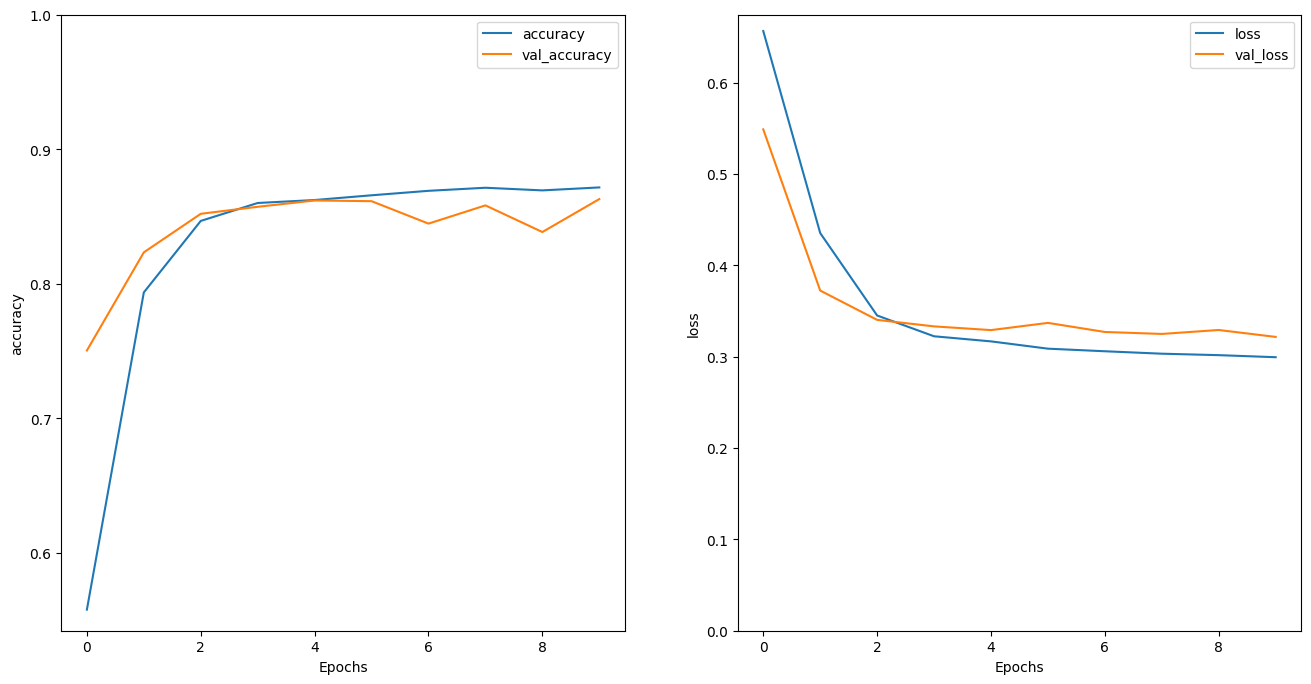

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:39:05 - loss: 0.6929 - accuracy: 0.5312

  2/391 [..............................] - ETA: 1:30 - loss: 0.6927 - accuracy: 0.5234   

  3/391 [..............................] - ETA: 1:29 - loss: 0.6928 - accuracy: 0.5469

  4/391 [..............................] - ETA: 1:27 - loss: 0.6928 - accuracy: 0.5234

  5/391 [..............................] - ETA: 1:25 - loss: 0.6927 - accuracy: 0.5281

  6/391 [..............................] - ETA: 1:24 - loss: 0.6928 - accuracy: 0.5260

  7/391 [..............................] - ETA: 1:21 - loss: 0.6930 - accuracy: 0.5290

  8/391 [..............................] - ETA: 1:21 - loss: 0.6931 - accuracy: 0.5352

  9/391 [..............................] - ETA: 1:20 - loss: 0.6931 - accuracy: 0.5399

 10/391 [..............................] - ETA: 1:19 - loss: 0.6932 - accuracy: 0.5406

 11/391 [..............................] - ETA: 1:18 - loss: 0.6932 - accuracy: 0.5355

 12/391 [..............................] - ETA: 1:18 - loss: 0.6932 - accuracy: 0.5352

 13/391 [..............................] - ETA: 1:17 - loss: 0.6932 - accuracy: 0.5312

 14/391 [>.............................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5257

 15/391 [>.............................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5260

 16/391 [>.............................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.5225

 17/391 [>.............................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.5239

 18/391 [>.............................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.5260

 19/391 [>.............................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.5222

 20/391 [>.............................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.5250

 21/391 [>.............................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.5179

 22/391 [>.............................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.5156

 23/391 [>.............................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.5156

 24/391 [>.............................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.5130

 25/391 [>.............................] - ETA: 1:09 - loss: 0.6930 - accuracy: 0.5125

 26/391 [>.............................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.5114

 27/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5122

 28/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5089

 29/391 [=>............................] - ETA: 1:06 - loss: 0.6930 - accuracy: 0.5119

 30/391 [=>............................] - ETA: 1:05 - loss: 0.6930 - accuracy: 0.5094

 31/391 [=>............................] - ETA: 1:04 - loss: 0.6930 - accuracy: 0.5096

 32/391 [=>............................] - ETA: 1:03 - loss: 0.6930 - accuracy: 0.5107

 33/391 [=>............................] - ETA: 1:02 - loss: 0.6930 - accuracy: 0.5047

 34/391 [=>............................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.5064

 35/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5063

 36/391 [=>............................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5087 

 37/391 [=>............................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5080

 38/391 [=>............................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5058

 39/391 [=>............................] - ETA: 58s - loss: 0.6929 - accuracy: 0.5076

 40/391 [==>...........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5078

 41/391 [==>...........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5088

 42/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5100

 43/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5116

 44/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5124

 45/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5132

 46/391 [==>...........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5112

 47/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5110

 48/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5094

 49/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5096

 50/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5075

 51/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5089

 52/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5075

 53/391 [===>..........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5080

 54/391 [===>..........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5095

 55/391 [===>..........................] - ETA: 55s - loss: 0.6929 - accuracy: 0.5085

 56/391 [===>..........................] - ETA: 55s - loss: 0.6929 - accuracy: 0.5089

 57/391 [===>..........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5093

 58/391 [===>..........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5092

 59/391 [===>..........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5079

 60/391 [===>..........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5086

 61/391 [===>..........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5072

 62/391 [===>..........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5066

 63/391 [===>..........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5067

 64/391 [===>..........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5059

 65/391 [===>..........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5060

 66/391 [====>.........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5057

 67/391 [====>.........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5056

 68/391 [====>.........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5055

 69/391 [====>.........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5052

 70/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5045

 71/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5048

 72/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5043

 73/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5054

 74/391 [====>.........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5030

 75/391 [====>.........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5044

 76/391 [====>.........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5037

 77/391 [====>.........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5024

 78/391 [====>.........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5028

 79/391 [=====>........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5044

 80/391 [=====>........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.5033

 81/391 [=====>........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.5019

 82/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5027

 83/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5015

 84/391 [=====>........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5011

 85/391 [=====>........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5009

 86/391 [=====>........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5018

 87/391 [=====>........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.5013

 88/391 [=====>........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.5020

 89/391 [=====>........................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5019

 90/391 [=====>........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.5017

 91/391 [=====>........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.5014

 92/391 [======>.......................] - ETA: 44s - loss: 0.6928 - accuracy: 0.5019

 93/391 [======>.......................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5032

 94/391 [======>.......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5030

 95/391 [======>.......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5020

 96/391 [======>.......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5018

 97/391 [======>.......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5021

 98/391 [======>.......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5030

 99/391 [======>.......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5041

100/391 [======>.......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5042

101/391 [======>.......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5043

102/391 [======>.......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5037

103/391 [======>.......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5044

104/391 [======>.......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5045

105/391 [=======>......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5037

106/391 [=======>......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5034

107/391 [=======>......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5032

108/391 [=======>......................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5038

109/391 [=======>......................] - ETA: 40s - loss: 0.6927 - accuracy: 0.5044

110/391 [=======>......................] - ETA: 40s - loss: 0.6927 - accuracy: 0.5048

111/391 [=======>......................] - ETA: 40s - loss: 0.6927 - accuracy: 0.5051

112/391 [=======>......................] - ETA: 40s - loss: 0.6927 - accuracy: 0.5056

113/391 [=======>......................] - ETA: 39s - loss: 0.6927 - accuracy: 0.5057

114/391 [=======>......................] - ETA: 39s - loss: 0.6927 - accuracy: 0.5059

115/391 [=======>......................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5049

116/391 [=======>......................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5047

117/391 [=======>......................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5044

118/391 [========>.....................] - ETA: 38s - loss: 0.6926 - accuracy: 0.5044

119/391 [========>.....................] - ETA: 38s - loss: 0.6926 - accuracy: 0.5038

120/391 [========>.....................] - ETA: 38s - loss: 0.6926 - accuracy: 0.5038

121/391 [========>.....................] - ETA: 38s - loss: 0.6926 - accuracy: 0.5036

122/391 [========>.....................] - ETA: 38s - loss: 0.6926 - accuracy: 0.5040

123/391 [========>.....................] - ETA: 37s - loss: 0.6926 - accuracy: 0.5037

124/391 [========>.....................] - ETA: 37s - loss: 0.6926 - accuracy: 0.5030

125/391 [========>.....................] - ETA: 37s - loss: 0.6925 - accuracy: 0.5026

126/391 [========>.....................] - ETA: 37s - loss: 0.6925 - accuracy: 0.5031

127/391 [========>.....................] - ETA: 36s - loss: 0.6925 - accuracy: 0.5022

128/391 [========>.....................] - ETA: 36s - loss: 0.6925 - accuracy: 0.5023

129/391 [========>.....................] - ETA: 36s - loss: 0.6925 - accuracy: 0.5016

130/391 [========>.....................] - ETA: 36s - loss: 0.6925 - accuracy: 0.5030

131/391 [=========>....................] - ETA: 36s - loss: 0.6925 - accuracy: 0.5029

132/391 [=========>....................] - ETA: 35s - loss: 0.6925 - accuracy: 0.5026

133/391 [=========>....................] - ETA: 35s - loss: 0.6925 - accuracy: 0.5027

134/391 [=========>....................] - ETA: 35s - loss: 0.6924 - accuracy: 0.5023

135/391 [=========>....................] - ETA: 35s - loss: 0.6925 - accuracy: 0.5028

136/391 [=========>....................] - ETA: 35s - loss: 0.6924 - accuracy: 0.5036

137/391 [=========>....................] - ETA: 34s - loss: 0.6924 - accuracy: 0.5036

138/391 [=========>....................] - ETA: 34s - loss: 0.6925 - accuracy: 0.5037

139/391 [=========>....................] - ETA: 34s - loss: 0.6925 - accuracy: 0.5043

140/391 [=========>....................] - ETA: 34s - loss: 0.6925 - accuracy: 0.5036

141/391 [=========>....................] - ETA: 34s - loss: 0.6924 - accuracy: 0.5028

142/391 [=========>....................] - ETA: 33s - loss: 0.6924 - accuracy: 0.5021

143/391 [=========>....................] - ETA: 33s - loss: 0.6924 - accuracy: 0.5021

144/391 [==========>...................] - ETA: 33s - loss: 0.6924 - accuracy: 0.5025

145/391 [==========>...................] - ETA: 33s - loss: 0.6924 - accuracy: 0.5016

146/391 [==========>...................] - ETA: 33s - loss: 0.6924 - accuracy: 0.5011

147/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5009

148/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5006

149/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5010

150/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5007

151/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5010

152/391 [==========>...................] - ETA: 32s - loss: 0.6923 - accuracy: 0.5011

153/391 [==========>...................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5000

154/391 [==========>...................] - ETA: 31s - loss: 0.6922 - accuracy: 0.4996

155/391 [==========>...................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5003

156/391 [==========>...................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5000

157/391 [===========>..................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5008

158/391 [===========>..................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5005

159/391 [===========>..................] - ETA: 31s - loss: 0.6922 - accuracy: 0.5003

160/391 [===========>..................] - ETA: 30s - loss: 0.6922 - accuracy: 0.5008

161/391 [===========>..................] - ETA: 30s - loss: 0.6922 - accuracy: 0.5008

162/391 [===========>..................] - ETA: 30s - loss: 0.6922 - accuracy: 0.5010

163/391 [===========>..................] - ETA: 30s - loss: 0.6922 - accuracy: 0.5012

164/391 [===========>..................] - ETA: 30s - loss: 0.6922 - accuracy: 0.5009

165/391 [===========>..................] - ETA: 30s - loss: 0.6921 - accuracy: 0.5008

166/391 [===========>..................] - ETA: 30s - loss: 0.6921 - accuracy: 0.5008

167/391 [===========>..................] - ETA: 29s - loss: 0.6921 - accuracy: 0.5011

168/391 [===========>..................] - ETA: 29s - loss: 0.6921 - accuracy: 0.5013

169/391 [===========>..................] - ETA: 29s - loss: 0.6920 - accuracy: 0.5006

170/391 [============>.................] - ETA: 29s - loss: 0.6920 - accuracy: 0.5008

171/391 [============>.................] - ETA: 29s - loss: 0.6920 - accuracy: 0.5012

172/391 [============>.................] - ETA: 28s - loss: 0.6919 - accuracy: 0.5010

173/391 [============>.................] - ETA: 28s - loss: 0.6920 - accuracy: 0.5015

174/391 [============>.................] - ETA: 28s - loss: 0.6919 - accuracy: 0.5014

175/391 [============>.................] - ETA: 28s - loss: 0.6919 - accuracy: 0.5015

176/391 [============>.................] - ETA: 28s - loss: 0.6919 - accuracy: 0.5020

177/391 [============>.................] - ETA: 28s - loss: 0.6919 - accuracy: 0.5018

178/391 [============>.................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5018

179/391 [============>.................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5013

180/391 [============>.................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5016

181/391 [============>.................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5022

182/391 [============>.................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5015

183/391 [=============>................] - ETA: 27s - loss: 0.6918 - accuracy: 0.5015

184/391 [=============>................] - ETA: 27s - loss: 0.6917 - accuracy: 0.5020

185/391 [=============>................] - ETA: 26s - loss: 0.6918 - accuracy: 0.5021

186/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5025

187/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5031

188/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5032

189/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5032

190/391 [=============>................] - ETA: 26s - loss: 0.6917 - accuracy: 0.5027

191/391 [=============>................] - ETA: 25s - loss: 0.6917 - accuracy: 0.5029

192/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5033

193/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5035

194/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5038

195/391 [=============>................] - ETA: 25s - loss: 0.6916 - accuracy: 0.5040

196/391 [==============>...............] - ETA: 25s - loss: 0.6916 - accuracy: 0.5043

197/391 [==============>...............] - ETA: 24s - loss: 0.6916 - accuracy: 0.5048

198/391 [==============>...............] - ETA: 24s - loss: 0.6916 - accuracy: 0.5050

199/391 [==============>...............] - ETA: 24s - loss: 0.6915 - accuracy: 0.5052

200/391 [==============>...............] - ETA: 24s - loss: 0.6915 - accuracy: 0.5056

201/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5057

202/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5054

203/391 [==============>...............] - ETA: 24s - loss: 0.6914 - accuracy: 0.5051

204/391 [==============>...............] - ETA: 23s - loss: 0.6914 - accuracy: 0.5054

205/391 [==============>...............] - ETA: 23s - loss: 0.6914 - accuracy: 0.5050

206/391 [==============>...............] - ETA: 23s - loss: 0.6913 - accuracy: 0.5048

207/391 [==============>...............] - ETA: 23s - loss: 0.6913 - accuracy: 0.5048

208/391 [==============>...............] - ETA: 23s - loss: 0.6913 - accuracy: 0.5048

209/391 [===============>..............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5046

210/391 [===============>..............] - ETA: 23s - loss: 0.6912 - accuracy: 0.5039

211/391 [===============>..............] - ETA: 22s - loss: 0.6912 - accuracy: 0.5036

212/391 [===============>..............] - ETA: 22s - loss: 0.6911 - accuracy: 0.5041

213/391 [===============>..............] - ETA: 22s - loss: 0.6911 - accuracy: 0.5037

214/391 [===============>..............] - ETA: 22s - loss: 0.6910 - accuracy: 0.5041

215/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.5039

216/391 [===============>..............] - ETA: 22s - loss: 0.6909 - accuracy: 0.5041

217/391 [===============>..............] - ETA: 21s - loss: 0.6908 - accuracy: 0.5040

218/391 [===============>..............] - ETA: 21s - loss: 0.6908 - accuracy: 0.5045

219/391 [===============>..............] - ETA: 21s - loss: 0.6907 - accuracy: 0.5042

220/391 [===============>..............] - ETA: 21s - loss: 0.6907 - accuracy: 0.5044

221/391 [===============>..............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5046

222/391 [================>.............] - ETA: 21s - loss: 0.6906 - accuracy: 0.5044

223/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5046

224/391 [================>.............] - ETA: 21s - loss: 0.6905 - accuracy: 0.5042

225/391 [================>.............] - ETA: 20s - loss: 0.6904 - accuracy: 0.5043

226/391 [================>.............] - ETA: 20s - loss: 0.6903 - accuracy: 0.5046

227/391 [================>.............] - ETA: 20s - loss: 0.6901 - accuracy: 0.5045

228/391 [================>.............] - ETA: 20s - loss: 0.6900 - accuracy: 0.5045

229/391 [================>.............] - ETA: 20s - loss: 0.6899 - accuracy: 0.5042

230/391 [================>.............] - ETA: 20s - loss: 0.6898 - accuracy: 0.5043

231/391 [================>.............] - ETA: 20s - loss: 0.6896 - accuracy: 0.5043

232/391 [================>.............] - ETA: 19s - loss: 0.6895 - accuracy: 0.5044

233/391 [================>.............] - ETA: 19s - loss: 0.6893 - accuracy: 0.5047

234/391 [================>.............] - ETA: 19s - loss: 0.6890 - accuracy: 0.5045

235/391 [=================>............] - ETA: 19s - loss: 0.6887 - accuracy: 0.5047

236/391 [=================>............] - ETA: 19s - loss: 0.6885 - accuracy: 0.5052

237/391 [=================>............] - ETA: 19s - loss: 0.6879 - accuracy: 0.5057

238/391 [=================>............] - ETA: 19s - loss: 0.6875 - accuracy: 0.5065

239/391 [=================>............] - ETA: 18s - loss: 0.6873 - accuracy: 0.5069

240/391 [=================>............] - ETA: 18s - loss: 0.6870 - accuracy: 0.5073

241/391 [=================>............] - ETA: 18s - loss: 0.6867 - accuracy: 0.5080

242/391 [=================>............] - ETA: 18s - loss: 0.6866 - accuracy: 0.5081

243/391 [=================>............] - ETA: 18s - loss: 0.6864 - accuracy: 0.5085

244/391 [=================>............] - ETA: 18s - loss: 0.6862 - accuracy: 0.5090

245/391 [=================>............] - ETA: 18s - loss: 0.6858 - accuracy: 0.5096

246/391 [=================>............] - ETA: 17s - loss: 0.6856 - accuracy: 0.5102

247/391 [=================>............] - ETA: 17s - loss: 0.6854 - accuracy: 0.5105

248/391 [==================>...........] - ETA: 17s - loss: 0.6853 - accuracy: 0.5110

249/391 [==================>...........] - ETA: 17s - loss: 0.6852 - accuracy: 0.5112

250/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5115

251/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5119

252/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5123

253/391 [==================>...........] - ETA: 17s - loss: 0.6851 - accuracy: 0.5124

254/391 [==================>...........] - ETA: 16s - loss: 0.6849 - accuracy: 0.5126

255/391 [==================>...........] - ETA: 16s - loss: 0.6850 - accuracy: 0.5126

256/391 [==================>...........] - ETA: 16s - loss: 0.6849 - accuracy: 0.5128

257/391 [==================>...........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5129

258/391 [==================>...........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5131

259/391 [==================>...........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5132

260/391 [==================>...........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5130

261/391 [===================>..........] - ETA: 15s - loss: 0.6844 - accuracy: 0.5133

262/391 [===================>..........] - ETA: 15s - loss: 0.6841 - accuracy: 0.5137

263/391 [===================>..........] - ETA: 15s - loss: 0.6838 - accuracy: 0.5144

264/391 [===================>..........] - ETA: 15s - loss: 0.6840 - accuracy: 0.5151

265/391 [===================>..........] - ETA: 15s - loss: 0.6836 - accuracy: 0.5159

266/391 [===================>..........] - ETA: 15s - loss: 0.6832 - accuracy: 0.5169

267/391 [===================>..........] - ETA: 15s - loss: 0.6825 - accuracy: 0.5181

268/391 [===================>..........] - ETA: 15s - loss: 0.6820 - accuracy: 0.5191

269/391 [===================>..........] - ETA: 14s - loss: 0.6816 - accuracy: 0.5197

270/391 [===================>..........] - ETA: 14s - loss: 0.6813 - accuracy: 0.5202

271/391 [===================>..........] - ETA: 14s - loss: 0.6810 - accuracy: 0.5206

272/391 [===================>..........] - ETA: 14s - loss: 0.6809 - accuracy: 0.5208

273/391 [===================>..........] - ETA: 14s - loss: 0.6805 - accuracy: 0.5215

274/391 [====================>.........] - ETA: 14s - loss: 0.6801 - accuracy: 0.5222

275/391 [====================>.........] - ETA: 14s - loss: 0.6796 - accuracy: 0.5231

276/391 [====================>.........] - ETA: 14s - loss: 0.6792 - accuracy: 0.5239

277/391 [====================>.........] - ETA: 13s - loss: 0.6789 - accuracy: 0.5246

278/391 [====================>.........] - ETA: 13s - loss: 0.6784 - accuracy: 0.5253

279/391 [====================>.........] - ETA: 13s - loss: 0.6780 - accuracy: 0.5258

280/391 [====================>.........] - ETA: 13s - loss: 0.6776 - accuracy: 0.5267

281/391 [====================>.........] - ETA: 13s - loss: 0.6775 - accuracy: 0.5275

282/391 [====================>.........] - ETA: 13s - loss: 0.6772 - accuracy: 0.5280

283/391 [====================>.........] - ETA: 13s - loss: 0.6768 - accuracy: 0.5288

284/391 [====================>.........] - ETA: 13s - loss: 0.6760 - accuracy: 0.5299

285/391 [====================>.........] - ETA: 12s - loss: 0.6756 - accuracy: 0.5308

286/391 [====================>.........] - ETA: 12s - loss: 0.6752 - accuracy: 0.5313

287/391 [=====================>........] - ETA: 12s - loss: 0.6748 - accuracy: 0.5320

288/391 [=====================>........] - ETA: 12s - loss: 0.6744 - accuracy: 0.5324

289/391 [=====================>........] - ETA: 12s - loss: 0.6742 - accuracy: 0.5328

290/391 [=====================>........] - ETA: 12s - loss: 0.6739 - accuracy: 0.5334

291/391 [=====================>........] - ETA: 12s - loss: 0.6732 - accuracy: 0.5341

292/391 [=====================>........] - ETA: 12s - loss: 0.6728 - accuracy: 0.5347

293/391 [=====================>........] - ETA: 11s - loss: 0.6725 - accuracy: 0.5352

294/391 [=====================>........] - ETA: 11s - loss: 0.6717 - accuracy: 0.5362

295/391 [=====================>........] - ETA: 11s - loss: 0.6714 - accuracy: 0.5368

296/391 [=====================>........] - ETA: 11s - loss: 0.6710 - accuracy: 0.5376

297/391 [=====================>........] - ETA: 11s - loss: 0.6709 - accuracy: 0.5383

298/391 [=====================>........] - ETA: 11s - loss: 0.6706 - accuracy: 0.5389

299/391 [=====================>........] - ETA: 11s - loss: 0.6703 - accuracy: 0.5395

300/391 [======================>.......] - ETA: 10s - loss: 0.6700 - accuracy: 0.5402

301/391 [======================>.......] - ETA: 10s - loss: 0.6694 - accuracy: 0.5412

302/391 [======================>.......] - ETA: 10s - loss: 0.6690 - accuracy: 0.5419

303/391 [======================>.......] - ETA: 10s - loss: 0.6687 - accuracy: 0.5421

304/391 [======================>.......] - ETA: 10s - loss: 0.6682 - accuracy: 0.5426

305/391 [======================>.......] - ETA: 10s - loss: 0.6679 - accuracy: 0.5430

306/391 [======================>.......] - ETA: 10s - loss: 0.6676 - accuracy: 0.5431

307/391 [======================>.......] - ETA: 10s - loss: 0.6671 - accuracy: 0.5435

308/391 [======================>.......] - ETA: 9s - loss: 0.6666 - accuracy: 0.5441 

309/391 [======================>.......] - ETA: 9s - loss: 0.6663 - accuracy: 0.5448

310/391 [======================>.......] - ETA: 9s - loss: 0.6660 - accuracy: 0.5454

311/391 [======================>.......] - ETA: 9s - loss: 0.6655 - accuracy: 0.5465

312/391 [======================>.......] - ETA: 9s - loss: 0.6651 - accuracy: 0.5473

313/391 [=======================>......] - ETA: 9s - loss: 0.6647 - accuracy: 0.5480

314/391 [=======================>......] - ETA: 9s - loss: 0.6644 - accuracy: 0.5487

315/391 [=======================>......] - ETA: 9s - loss: 0.6641 - accuracy: 0.5493

316/391 [=======================>......] - ETA: 8s - loss: 0.6637 - accuracy: 0.5498

317/391 [=======================>......] - ETA: 8s - loss: 0.6633 - accuracy: 0.5504

318/391 [=======================>......] - ETA: 8s - loss: 0.6628 - accuracy: 0.5512

319/391 [=======================>......] - ETA: 8s - loss: 0.6624 - accuracy: 0.5518

320/391 [=======================>......] - ETA: 8s - loss: 0.6621 - accuracy: 0.5523

321/391 [=======================>......] - ETA: 8s - loss: 0.6616 - accuracy: 0.5529

322/391 [=======================>......] - ETA: 8s - loss: 0.6612 - accuracy: 0.5536

323/391 [=======================>......] - ETA: 8s - loss: 0.6606 - accuracy: 0.5542

324/391 [=======================>......] - ETA: 7s - loss: 0.6603 - accuracy: 0.5547

325/391 [=======================>......] - ETA: 7s - loss: 0.6598 - accuracy: 0.5552

326/391 [========================>.....] - ETA: 7s - loss: 0.6592 - accuracy: 0.5557

327/391 [========================>.....] - ETA: 7s - loss: 0.6586 - accuracy: 0.5565

328/391 [========================>.....] - ETA: 7s - loss: 0.6582 - accuracy: 0.5571

329/391 [========================>.....] - ETA: 7s - loss: 0.6578 - accuracy: 0.5579

330/391 [========================>.....] - ETA: 7s - loss: 0.6572 - accuracy: 0.5586

331/391 [========================>.....] - ETA: 7s - loss: 0.6572 - accuracy: 0.5589

332/391 [========================>.....] - ETA: 6s - loss: 0.6568 - accuracy: 0.5594

333/391 [========================>.....] - ETA: 6s - loss: 0.6563 - accuracy: 0.5602

334/391 [========================>.....] - ETA: 6s - loss: 0.6555 - accuracy: 0.5611

335/391 [========================>.....] - ETA: 6s - loss: 0.6553 - accuracy: 0.5616

336/391 [========================>.....] - ETA: 6s - loss: 0.6549 - accuracy: 0.5620

337/391 [========================>.....] - ETA: 6s - loss: 0.6547 - accuracy: 0.5622

338/391 [========================>.....] - ETA: 6s - loss: 0.6541 - accuracy: 0.5628

339/391 [=========================>....] - ETA: 6s - loss: 0.6538 - accuracy: 0.5634

340/391 [=========================>....] - ETA: 6s - loss: 0.6534 - accuracy: 0.5639

341/391 [=========================>....] - ETA: 5s - loss: 0.6530 - accuracy: 0.5644

342/391 [=========================>....] - ETA: 5s - loss: 0.6526 - accuracy: 0.5650

343/391 [=========================>....] - ETA: 5s - loss: 0.6519 - accuracy: 0.5658

344/391 [=========================>....] - ETA: 5s - loss: 0.6515 - accuracy: 0.5664

345/391 [=========================>....] - ETA: 5s - loss: 0.6509 - accuracy: 0.5672

346/391 [=========================>....] - ETA: 5s - loss: 0.6500 - accuracy: 0.5683

347/391 [=========================>....] - ETA: 5s - loss: 0.6495 - accuracy: 0.5689

348/391 [=========================>....] - ETA: 5s - loss: 0.6490 - accuracy: 0.5696

349/391 [=========================>....] - ETA: 4s - loss: 0.6483 - accuracy: 0.5704

350/391 [=========================>....] - ETA: 4s - loss: 0.6478 - accuracy: 0.5709

351/391 [=========================>....] - ETA: 4s - loss: 0.6473 - accuracy: 0.5717

352/391 [==========================>...] - ETA: 4s - loss: 0.6468 - accuracy: 0.5723

353/391 [==========================>...] - ETA: 4s - loss: 0.6463 - accuracy: 0.5731

354/391 [==========================>...] - ETA: 4s - loss: 0.6461 - accuracy: 0.5733

355/391 [==========================>...] - ETA: 4s - loss: 0.6458 - accuracy: 0.5738

356/391 [==========================>...] - ETA: 4s - loss: 0.6451 - accuracy: 0.5744

357/391 [==========================>...] - ETA: 3s - loss: 0.6448 - accuracy: 0.5748

358/391 [==========================>...] - ETA: 3s - loss: 0.6443 - accuracy: 0.5752

359/391 [==========================>...] - ETA: 3s - loss: 0.6435 - accuracy: 0.5760

360/391 [==========================>...] - ETA: 3s - loss: 0.6428 - accuracy: 0.5768

361/391 [==========================>...] - ETA: 3s - loss: 0.6426 - accuracy: 0.5773

362/391 [==========================>...] - ETA: 3s - loss: 0.6419 - accuracy: 0.5780

363/391 [==========================>...] - ETA: 3s - loss: 0.6416 - accuracy: 0.5787

364/391 [==========================>...] - ETA: 3s - loss: 0.6410 - accuracy: 0.5794

365/391 [===========================>..] - ETA: 3s - loss: 0.6407 - accuracy: 0.5800

366/391 [===========================>..] - ETA: 2s - loss: 0.6401 - accuracy: 0.5806

367/391 [===========================>..] - ETA: 2s - loss: 0.6396 - accuracy: 0.5812

368/391 [===========================>..] - ETA: 2s - loss: 0.6392 - accuracy: 0.5817

369/391 [===========================>..] - ETA: 2s - loss: 0.6388 - accuracy: 0.5821

370/391 [===========================>..] - ETA: 2s - loss: 0.6382 - accuracy: 0.5827

371/391 [===========================>..] - ETA: 2s - loss: 0.6378 - accuracy: 0.5831

372/391 [===========================>..] - ETA: 2s - loss: 0.6376 - accuracy: 0.5833

373/391 [===========================>..] - ETA: 2s - loss: 0.6370 - accuracy: 0.5839

374/391 [===========================>..] - ETA: 1s - loss: 0.6366 - accuracy: 0.5843

375/391 [===========================>..] - ETA: 1s - loss: 0.6362 - accuracy: 0.5850

376/391 [===========================>..] - ETA: 1s - loss: 0.6359 - accuracy: 0.5856

377/391 [===========================>..] - ETA: 1s - loss: 0.6355 - accuracy: 0.5862

378/391 [============================>.] - ETA: 1s - loss: 0.6351 - accuracy: 0.5866

379/391 [============================>.] - ETA: 1s - loss: 0.6347 - accuracy: 0.5871

380/391 [============================>.] - ETA: 1s - loss: 0.6341 - accuracy: 0.5877

381/391 [============================>.] - ETA: 1s - loss: 0.6338 - accuracy: 0.5879

382/391 [============================>.] - ETA: 1s - loss: 0.6335 - accuracy: 0.5884

383/391 [============================>.] - ETA: 0s - loss: 0.6328 - accuracy: 0.5891

384/391 [============================>.] - ETA: 0s - loss: 0.6323 - accuracy: 0.5896

385/391 [============================>.] - ETA: 0s - loss: 0.6317 - accuracy: 0.5902

386/391 [============================>.] - ETA: 0s - loss: 0.6311 - accuracy: 0.5908

387/391 [============================>.] - ETA: 0s - loss: 0.6304 - accuracy: 0.5914

388/391 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.5920

389/391 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.5927

390/391 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.5931

391/391 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.5935

391/391 [==============================] - 66s 131ms/step - loss: 0.6284 - accuracy: 0.5935 - val_loss: 0.4341 - val_accuracy: 0.8031


Epoch 2/10


  1/391 [..............................] - ETA: 3:52 - loss: 0.4929 - accuracy: 0.7656

  2/391 [..............................] - ETA: 35s - loss: 0.4269 - accuracy: 0.8047 

  3/391 [..............................] - ETA: 34s - loss: 0.4587 - accuracy: 0.7865

  4/391 [..............................] - ETA: 32s - loss: 0.4661 - accuracy: 0.7695

  5/391 [..............................] - ETA: 33s - loss: 0.4555 - accuracy: 0.7812

  6/391 [..............................] - ETA: 34s - loss: 0.4493 - accuracy: 0.7839

  7/391 [..............................] - ETA: 33s - loss: 0.4337 - accuracy: 0.7969

  8/391 [..............................] - ETA: 34s - loss: 0.4342 - accuracy: 0.8027

  9/391 [..............................] - ETA: 34s - loss: 0.4253 - accuracy: 0.8108

 10/391 [..............................] - ETA: 35s - loss: 0.4366 - accuracy: 0.8031

 11/391 [..............................] - ETA: 34s - loss: 0.4326 - accuracy: 0.8026

 12/391 [..............................] - ETA: 33s - loss: 0.4322 - accuracy: 0.8086

 13/391 [..............................] - ETA: 34s - loss: 0.4262 - accuracy: 0.8089

 14/391 [>.............................] - ETA: 33s - loss: 0.4259 - accuracy: 0.8114

 15/391 [>.............................] - ETA: 33s - loss: 0.4276 - accuracy: 0.8115

 16/391 [>.............................] - ETA: 33s - loss: 0.4237 - accuracy: 0.8125

 17/391 [>.............................] - ETA: 32s - loss: 0.4254 - accuracy: 0.8125

 18/391 [>.............................] - ETA: 32s - loss: 0.4295 - accuracy: 0.8116

 19/391 [>.............................] - ETA: 33s - loss: 0.4292 - accuracy: 0.8100

 20/391 [>.............................] - ETA: 33s - loss: 0.4311 - accuracy: 0.8102

 21/391 [>.............................] - ETA: 33s - loss: 0.4265 - accuracy: 0.8140

 22/391 [>.............................] - ETA: 33s - loss: 0.4333 - accuracy: 0.8132

 23/391 [>.............................] - ETA: 33s - loss: 0.4313 - accuracy: 0.8152

 24/391 [>.............................] - ETA: 33s - loss: 0.4261 - accuracy: 0.8197

 25/391 [>.............................] - ETA: 33s - loss: 0.4240 - accuracy: 0.8200

 26/391 [>.............................] - ETA: 33s - loss: 0.4248 - accuracy: 0.8197

 27/391 [=>............................] - ETA: 33s - loss: 0.4262 - accuracy: 0.8177

 28/391 [=>............................] - ETA: 33s - loss: 0.4273 - accuracy: 0.8181

 29/391 [=>............................] - ETA: 33s - loss: 0.4261 - accuracy: 0.8184

 30/391 [=>............................] - ETA: 33s - loss: 0.4266 - accuracy: 0.8182

 31/391 [=>............................] - ETA: 32s - loss: 0.4253 - accuracy: 0.8170

 32/391 [=>............................] - ETA: 32s - loss: 0.4237 - accuracy: 0.8179

 33/391 [=>............................] - ETA: 32s - loss: 0.4219 - accuracy: 0.8182

 34/391 [=>............................] - ETA: 32s - loss: 0.4208 - accuracy: 0.8185

 35/391 [=>............................] - ETA: 32s - loss: 0.4199 - accuracy: 0.8183

 36/391 [=>............................] - ETA: 32s - loss: 0.4188 - accuracy: 0.8194

 37/391 [=>............................] - ETA: 32s - loss: 0.4162 - accuracy: 0.8214

 38/391 [=>............................] - ETA: 32s - loss: 0.4173 - accuracy: 0.8203

 39/391 [=>............................] - ETA: 32s - loss: 0.4173 - accuracy: 0.8197

 40/391 [==>...........................] - ETA: 32s - loss: 0.4166 - accuracy: 0.8199

 41/391 [==>...........................] - ETA: 32s - loss: 0.4167 - accuracy: 0.8205

 42/391 [==>...........................] - ETA: 32s - loss: 0.4151 - accuracy: 0.8218

 43/391 [==>...........................] - ETA: 32s - loss: 0.4167 - accuracy: 0.8216

 44/391 [==>...........................] - ETA: 32s - loss: 0.4172 - accuracy: 0.8210

 45/391 [==>...........................] - ETA: 32s - loss: 0.4174 - accuracy: 0.8212

 46/391 [==>...........................] - ETA: 32s - loss: 0.4177 - accuracy: 0.8196

 47/391 [==>...........................] - ETA: 32s - loss: 0.4155 - accuracy: 0.8208

 48/391 [==>...........................] - ETA: 31s - loss: 0.4160 - accuracy: 0.8213

 49/391 [==>...........................] - ETA: 31s - loss: 0.4166 - accuracy: 0.8205

 50/391 [==>...........................] - ETA: 31s - loss: 0.4156 - accuracy: 0.8209

 51/391 [==>...........................] - ETA: 31s - loss: 0.4163 - accuracy: 0.8205

 52/391 [==>...........................] - ETA: 31s - loss: 0.4178 - accuracy: 0.8194

 53/391 [===>..........................] - ETA: 31s - loss: 0.4179 - accuracy: 0.8190

 54/391 [===>..........................] - ETA: 31s - loss: 0.4176 - accuracy: 0.8186

 55/391 [===>..........................] - ETA: 31s - loss: 0.4173 - accuracy: 0.8188

 56/391 [===>..........................] - ETA: 31s - loss: 0.4170 - accuracy: 0.8192

 57/391 [===>..........................] - ETA: 31s - loss: 0.4181 - accuracy: 0.8185

 58/391 [===>..........................] - ETA: 31s - loss: 0.4179 - accuracy: 0.8187

 59/391 [===>..........................] - ETA: 31s - loss: 0.4177 - accuracy: 0.8183

 60/391 [===>..........................] - ETA: 31s - loss: 0.4163 - accuracy: 0.8188

 61/391 [===>..........................] - ETA: 31s - loss: 0.4174 - accuracy: 0.8179

 62/391 [===>..........................] - ETA: 31s - loss: 0.4159 - accuracy: 0.8188

 63/391 [===>..........................] - ETA: 31s - loss: 0.4166 - accuracy: 0.8185

 64/391 [===>..........................] - ETA: 31s - loss: 0.4167 - accuracy: 0.8188

 65/391 [===>..........................] - ETA: 31s - loss: 0.4172 - accuracy: 0.8188

 66/391 [====>.........................] - ETA: 30s - loss: 0.4175 - accuracy: 0.8187

 67/391 [====>.........................] - ETA: 30s - loss: 0.4177 - accuracy: 0.8190

 68/391 [====>.........................] - ETA: 30s - loss: 0.4176 - accuracy: 0.8189

 69/391 [====>.........................] - ETA: 30s - loss: 0.4166 - accuracy: 0.8188

 70/391 [====>.........................] - ETA: 30s - loss: 0.4166 - accuracy: 0.8188

 71/391 [====>.........................] - ETA: 30s - loss: 0.4169 - accuracy: 0.8182

 72/391 [====>.........................] - ETA: 30s - loss: 0.4169 - accuracy: 0.8184

 73/391 [====>.........................] - ETA: 30s - loss: 0.4170 - accuracy: 0.8179

 74/391 [====>.........................] - ETA: 30s - loss: 0.4157 - accuracy: 0.8180

 75/391 [====>.........................] - ETA: 30s - loss: 0.4148 - accuracy: 0.8183

 76/391 [====>.........................] - ETA: 30s - loss: 0.4148 - accuracy: 0.8178

 77/391 [====>.........................] - ETA: 30s - loss: 0.4147 - accuracy: 0.8174

 78/391 [====>.........................] - ETA: 30s - loss: 0.4147 - accuracy: 0.8173

 79/391 [=====>........................] - ETA: 29s - loss: 0.4122 - accuracy: 0.8188

 80/391 [=====>........................] - ETA: 29s - loss: 0.4144 - accuracy: 0.8178

 81/391 [=====>........................] - ETA: 29s - loss: 0.4133 - accuracy: 0.8185

 82/391 [=====>........................] - ETA: 29s - loss: 0.4130 - accuracy: 0.8190

 83/391 [=====>........................] - ETA: 29s - loss: 0.4119 - accuracy: 0.8195

 84/391 [=====>........................] - ETA: 29s - loss: 0.4117 - accuracy: 0.8196

 85/391 [=====>........................] - ETA: 29s - loss: 0.4116 - accuracy: 0.8189

 86/391 [=====>........................] - ETA: 29s - loss: 0.4115 - accuracy: 0.8189

 87/391 [=====>........................] - ETA: 28s - loss: 0.4119 - accuracy: 0.8186

 88/391 [=====>........................] - ETA: 28s - loss: 0.4118 - accuracy: 0.8187

 89/391 [=====>........................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8183

 90/391 [=====>........................] - ETA: 28s - loss: 0.4127 - accuracy: 0.8188

 91/391 [=====>........................] - ETA: 28s - loss: 0.4120 - accuracy: 0.8195

 92/391 [======>.......................] - ETA: 28s - loss: 0.4127 - accuracy: 0.8193

 93/391 [======>.......................] - ETA: 28s - loss: 0.4116 - accuracy: 0.8197

 94/391 [======>.......................] - ETA: 28s - loss: 0.4109 - accuracy: 0.8203

 95/391 [======>.......................] - ETA: 28s - loss: 0.4107 - accuracy: 0.8207

 96/391 [======>.......................] - ETA: 28s - loss: 0.4106 - accuracy: 0.8210

 97/391 [======>.......................] - ETA: 28s - loss: 0.4100 - accuracy: 0.8212

 98/391 [======>.......................] - ETA: 27s - loss: 0.4107 - accuracy: 0.8208

 99/391 [======>.......................] - ETA: 27s - loss: 0.4117 - accuracy: 0.8210

100/391 [======>.......................] - ETA: 27s - loss: 0.4119 - accuracy: 0.8209

101/391 [======>.......................] - ETA: 27s - loss: 0.4114 - accuracy: 0.8209

102/391 [======>.......................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8203

103/391 [======>.......................] - ETA: 27s - loss: 0.4119 - accuracy: 0.8210

104/391 [======>.......................] - ETA: 27s - loss: 0.4113 - accuracy: 0.8215

105/391 [=======>......................] - ETA: 27s - loss: 0.4112 - accuracy: 0.8214

106/391 [=======>......................] - ETA: 27s - loss: 0.4105 - accuracy: 0.8215

107/391 [=======>......................] - ETA: 27s - loss: 0.4097 - accuracy: 0.8218

108/391 [=======>......................] - ETA: 26s - loss: 0.4094 - accuracy: 0.8218

109/391 [=======>......................] - ETA: 26s - loss: 0.4089 - accuracy: 0.8215

110/391 [=======>......................] - ETA: 26s - loss: 0.4094 - accuracy: 0.8213

111/391 [=======>......................] - ETA: 26s - loss: 0.4086 - accuracy: 0.8218

112/391 [=======>......................] - ETA: 26s - loss: 0.4082 - accuracy: 0.8220

113/391 [=======>......................] - ETA: 26s - loss: 0.4087 - accuracy: 0.8218

114/391 [=======>......................] - ETA: 26s - loss: 0.4085 - accuracy: 0.8221

115/391 [=======>......................] - ETA: 26s - loss: 0.4083 - accuracy: 0.8221

116/391 [=======>......................] - ETA: 26s - loss: 0.4080 - accuracy: 0.8225

117/391 [=======>......................] - ETA: 26s - loss: 0.4078 - accuracy: 0.8222

118/391 [========>.....................] - ETA: 26s - loss: 0.4070 - accuracy: 0.8228

119/391 [========>.....................] - ETA: 26s - loss: 0.4058 - accuracy: 0.8233

120/391 [========>.....................] - ETA: 26s - loss: 0.4065 - accuracy: 0.8229

121/391 [========>.....................] - ETA: 25s - loss: 0.4068 - accuracy: 0.8227

122/391 [========>.....................] - ETA: 25s - loss: 0.4070 - accuracy: 0.8226

123/391 [========>.....................] - ETA: 25s - loss: 0.4068 - accuracy: 0.8227

124/391 [========>.....................] - ETA: 25s - loss: 0.4065 - accuracy: 0.8231

125/391 [========>.....................] - ETA: 25s - loss: 0.4067 - accuracy: 0.8231

126/391 [========>.....................] - ETA: 25s - loss: 0.4064 - accuracy: 0.8230

127/391 [========>.....................] - ETA: 25s - loss: 0.4054 - accuracy: 0.8236

128/391 [========>.....................] - ETA: 25s - loss: 0.4057 - accuracy: 0.8237

129/391 [========>.....................] - ETA: 25s - loss: 0.4059 - accuracy: 0.8236

130/391 [========>.....................] - ETA: 25s - loss: 0.4053 - accuracy: 0.8238

131/391 [=========>....................] - ETA: 24s - loss: 0.4053 - accuracy: 0.8236

132/391 [=========>....................] - ETA: 24s - loss: 0.4047 - accuracy: 0.8236

133/391 [=========>....................] - ETA: 24s - loss: 0.4044 - accuracy: 0.8239

134/391 [=========>....................] - ETA: 24s - loss: 0.4052 - accuracy: 0.8233

135/391 [=========>....................] - ETA: 24s - loss: 0.4052 - accuracy: 0.8234

136/391 [=========>....................] - ETA: 24s - loss: 0.4047 - accuracy: 0.8234

137/391 [=========>....................] - ETA: 24s - loss: 0.4060 - accuracy: 0.8220

138/391 [=========>....................] - ETA: 24s - loss: 0.4068 - accuracy: 0.8213

139/391 [=========>....................] - ETA: 24s - loss: 0.4066 - accuracy: 0.8217

140/391 [=========>....................] - ETA: 24s - loss: 0.4068 - accuracy: 0.8219

141/391 [=========>....................] - ETA: 23s - loss: 0.4069 - accuracy: 0.8219

142/391 [=========>....................] - ETA: 23s - loss: 0.4066 - accuracy: 0.8222

143/391 [=========>....................] - ETA: 23s - loss: 0.4066 - accuracy: 0.8223

144/391 [==========>...................] - ETA: 23s - loss: 0.4068 - accuracy: 0.8225

145/391 [==========>...................] - ETA: 23s - loss: 0.4064 - accuracy: 0.8226

146/391 [==========>...................] - ETA: 23s - loss: 0.4060 - accuracy: 0.8229

147/391 [==========>...................] - ETA: 23s - loss: 0.4057 - accuracy: 0.8234

148/391 [==========>...................] - ETA: 23s - loss: 0.4055 - accuracy: 0.8234

149/391 [==========>...................] - ETA: 23s - loss: 0.4053 - accuracy: 0.8232

150/391 [==========>...................] - ETA: 23s - loss: 0.4053 - accuracy: 0.8232

151/391 [==========>...................] - ETA: 23s - loss: 0.4049 - accuracy: 0.8235

152/391 [==========>...................] - ETA: 22s - loss: 0.4040 - accuracy: 0.8237

153/391 [==========>...................] - ETA: 22s - loss: 0.4038 - accuracy: 0.8238

154/391 [==========>...................] - ETA: 22s - loss: 0.4034 - accuracy: 0.8242

155/391 [==========>...................] - ETA: 22s - loss: 0.4033 - accuracy: 0.8244

156/391 [==========>...................] - ETA: 22s - loss: 0.4027 - accuracy: 0.8248

157/391 [===========>..................] - ETA: 22s - loss: 0.4023 - accuracy: 0.8249

158/391 [===========>..................] - ETA: 22s - loss: 0.4022 - accuracy: 0.8249

159/391 [===========>..................] - ETA: 22s - loss: 0.4012 - accuracy: 0.8253

160/391 [===========>..................] - ETA: 22s - loss: 0.4010 - accuracy: 0.8255

161/391 [===========>..................] - ETA: 22s - loss: 0.4008 - accuracy: 0.8257

162/391 [===========>..................] - ETA: 22s - loss: 0.4003 - accuracy: 0.8261

163/391 [===========>..................] - ETA: 21s - loss: 0.4001 - accuracy: 0.8261

164/391 [===========>..................] - ETA: 21s - loss: 0.4002 - accuracy: 0.8263

165/391 [===========>..................] - ETA: 21s - loss: 0.3999 - accuracy: 0.8263

166/391 [===========>..................] - ETA: 21s - loss: 0.3995 - accuracy: 0.8265

167/391 [===========>..................] - ETA: 21s - loss: 0.3996 - accuracy: 0.8263

168/391 [===========>..................] - ETA: 21s - loss: 0.3993 - accuracy: 0.8265

169/391 [===========>..................] - ETA: 21s - loss: 0.3996 - accuracy: 0.8262

170/391 [============>.................] - ETA: 21s - loss: 0.3995 - accuracy: 0.8261

171/391 [============>.................] - ETA: 21s - loss: 0.3995 - accuracy: 0.8260

172/391 [============>.................] - ETA: 21s - loss: 0.4001 - accuracy: 0.8259

173/391 [============>.................] - ETA: 20s - loss: 0.3998 - accuracy: 0.8260

174/391 [============>.................] - ETA: 20s - loss: 0.4002 - accuracy: 0.8257

175/391 [============>.................] - ETA: 20s - loss: 0.4001 - accuracy: 0.8259

176/391 [============>.................] - ETA: 20s - loss: 0.4005 - accuracy: 0.8256

177/391 [============>.................] - ETA: 20s - loss: 0.4007 - accuracy: 0.8250

178/391 [============>.................] - ETA: 20s - loss: 0.4006 - accuracy: 0.8250

179/391 [============>.................] - ETA: 20s - loss: 0.4002 - accuracy: 0.8252

180/391 [============>.................] - ETA: 20s - loss: 0.4006 - accuracy: 0.8249

181/391 [============>.................] - ETA: 20s - loss: 0.4000 - accuracy: 0.8252

182/391 [============>.................] - ETA: 20s - loss: 0.4005 - accuracy: 0.8249

183/391 [=============>................] - ETA: 19s - loss: 0.4003 - accuracy: 0.8251

184/391 [=============>................] - ETA: 19s - loss: 0.4001 - accuracy: 0.8251

185/391 [=============>................] - ETA: 19s - loss: 0.4001 - accuracy: 0.8247

186/391 [=============>................] - ETA: 19s - loss: 0.3998 - accuracy: 0.8248

187/391 [=============>................] - ETA: 19s - loss: 0.3997 - accuracy: 0.8247

188/391 [=============>................] - ETA: 19s - loss: 0.3995 - accuracy: 0.8247

189/391 [=============>................] - ETA: 19s - loss: 0.3996 - accuracy: 0.8247

190/391 [=============>................] - ETA: 19s - loss: 0.3992 - accuracy: 0.8248

191/391 [=============>................] - ETA: 19s - loss: 0.3993 - accuracy: 0.8246

192/391 [=============>................] - ETA: 19s - loss: 0.3986 - accuracy: 0.8249

193/391 [=============>................] - ETA: 18s - loss: 0.3984 - accuracy: 0.8249

194/391 [=============>................] - ETA: 18s - loss: 0.3978 - accuracy: 0.8253

195/391 [=============>................] - ETA: 18s - loss: 0.3975 - accuracy: 0.8255

196/391 [==============>...............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8256

197/391 [==============>...............] - ETA: 18s - loss: 0.3973 - accuracy: 0.8257

198/391 [==============>...............] - ETA: 18s - loss: 0.3972 - accuracy: 0.8258

199/391 [==============>...............] - ETA: 18s - loss: 0.3971 - accuracy: 0.8258

200/391 [==============>...............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8258

201/391 [==============>...............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8257

202/391 [==============>...............] - ETA: 18s - loss: 0.3976 - accuracy: 0.8255

203/391 [==============>...............] - ETA: 18s - loss: 0.3975 - accuracy: 0.8257

204/391 [==============>...............] - ETA: 17s - loss: 0.3968 - accuracy: 0.8259

205/391 [==============>...............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8259

206/391 [==============>...............] - ETA: 17s - loss: 0.3966 - accuracy: 0.8260

207/391 [==============>...............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8259

208/391 [==============>...............] - ETA: 17s - loss: 0.3964 - accuracy: 0.8260

209/391 [===============>..............] - ETA: 17s - loss: 0.3965 - accuracy: 0.8260

210/391 [===============>..............] - ETA: 17s - loss: 0.3961 - accuracy: 0.8263

211/391 [===============>..............] - ETA: 17s - loss: 0.3956 - accuracy: 0.8266

212/391 [===============>..............] - ETA: 17s - loss: 0.3954 - accuracy: 0.8267

213/391 [===============>..............] - ETA: 17s - loss: 0.3954 - accuracy: 0.8265

214/391 [===============>..............] - ETA: 17s - loss: 0.3955 - accuracy: 0.8265

215/391 [===============>..............] - ETA: 16s - loss: 0.3958 - accuracy: 0.8262

216/391 [===============>..............] - ETA: 16s - loss: 0.3958 - accuracy: 0.8262

217/391 [===============>..............] - ETA: 16s - loss: 0.3954 - accuracy: 0.8265

218/391 [===============>..............] - ETA: 16s - loss: 0.3950 - accuracy: 0.8268

219/391 [===============>..............] - ETA: 16s - loss: 0.3947 - accuracy: 0.8268

220/391 [===============>..............] - ETA: 16s - loss: 0.3952 - accuracy: 0.8266

221/391 [===============>..............] - ETA: 16s - loss: 0.3959 - accuracy: 0.8264

222/391 [================>.............] - ETA: 16s - loss: 0.3956 - accuracy: 0.8265

223/391 [================>.............] - ETA: 16s - loss: 0.3950 - accuracy: 0.8267

224/391 [================>.............] - ETA: 16s - loss: 0.3949 - accuracy: 0.8267

225/391 [================>.............] - ETA: 15s - loss: 0.3943 - accuracy: 0.8269

226/391 [================>.............] - ETA: 15s - loss: 0.3938 - accuracy: 0.8272

227/391 [================>.............] - ETA: 15s - loss: 0.3934 - accuracy: 0.8274

228/391 [================>.............] - ETA: 15s - loss: 0.3934 - accuracy: 0.8273

229/391 [================>.............] - ETA: 15s - loss: 0.3931 - accuracy: 0.8275

230/391 [================>.............] - ETA: 15s - loss: 0.3937 - accuracy: 0.8275

231/391 [================>.............] - ETA: 15s - loss: 0.3933 - accuracy: 0.8279

232/391 [================>.............] - ETA: 15s - loss: 0.3936 - accuracy: 0.8279

233/391 [================>.............] - ETA: 15s - loss: 0.3932 - accuracy: 0.8281

234/391 [================>.............] - ETA: 15s - loss: 0.3930 - accuracy: 0.8281

235/391 [=================>............] - ETA: 15s - loss: 0.3926 - accuracy: 0.8283

236/391 [=================>............] - ETA: 14s - loss: 0.3929 - accuracy: 0.8279

237/391 [=================>............] - ETA: 14s - loss: 0.3930 - accuracy: 0.8276

238/391 [=================>............] - ETA: 14s - loss: 0.3927 - accuracy: 0.8277

239/391 [=================>............] - ETA: 14s - loss: 0.3929 - accuracy: 0.8274

240/391 [=================>............] - ETA: 14s - loss: 0.3932 - accuracy: 0.8271

241/391 [=================>............] - ETA: 14s - loss: 0.3928 - accuracy: 0.8274

242/391 [=================>............] - ETA: 14s - loss: 0.3926 - accuracy: 0.8273

243/391 [=================>............] - ETA: 14s - loss: 0.3924 - accuracy: 0.8275

244/391 [=================>............] - ETA: 14s - loss: 0.3927 - accuracy: 0.8274

245/391 [=================>............] - ETA: 14s - loss: 0.3928 - accuracy: 0.8274

246/391 [=================>............] - ETA: 14s - loss: 0.3928 - accuracy: 0.8274

247/391 [=================>............] - ETA: 13s - loss: 0.3928 - accuracy: 0.8274

248/391 [==================>...........] - ETA: 13s - loss: 0.3931 - accuracy: 0.8274

249/391 [==================>...........] - ETA: 13s - loss: 0.3926 - accuracy: 0.8277

250/391 [==================>...........] - ETA: 13s - loss: 0.3925 - accuracy: 0.8278

251/391 [==================>...........] - ETA: 13s - loss: 0.3922 - accuracy: 0.8279

252/391 [==================>...........] - ETA: 13s - loss: 0.3921 - accuracy: 0.8277

253/391 [==================>...........] - ETA: 13s - loss: 0.3919 - accuracy: 0.8277

254/391 [==================>...........] - ETA: 13s - loss: 0.3918 - accuracy: 0.8276

255/391 [==================>...........] - ETA: 13s - loss: 0.3918 - accuracy: 0.8275

256/391 [==================>...........] - ETA: 13s - loss: 0.3915 - accuracy: 0.8276

257/391 [==================>...........] - ETA: 13s - loss: 0.3919 - accuracy: 0.8275

258/391 [==================>...........] - ETA: 12s - loss: 0.3915 - accuracy: 0.8276

259/391 [==================>...........] - ETA: 12s - loss: 0.3913 - accuracy: 0.8275

260/391 [==================>...........] - ETA: 12s - loss: 0.3911 - accuracy: 0.8276

261/391 [===================>..........] - ETA: 12s - loss: 0.3909 - accuracy: 0.8278

262/391 [===================>..........] - ETA: 12s - loss: 0.3908 - accuracy: 0.8279

263/391 [===================>..........] - ETA: 12s - loss: 0.3905 - accuracy: 0.8279

264/391 [===================>..........] - ETA: 12s - loss: 0.3906 - accuracy: 0.8279

265/391 [===================>..........] - ETA: 12s - loss: 0.3904 - accuracy: 0.8279

266/391 [===================>..........] - ETA: 12s - loss: 0.3904 - accuracy: 0.8279

267/391 [===================>..........] - ETA: 12s - loss: 0.3901 - accuracy: 0.8279

268/391 [===================>..........] - ETA: 11s - loss: 0.3900 - accuracy: 0.8280

269/391 [===================>..........] - ETA: 11s - loss: 0.3899 - accuracy: 0.8282

270/391 [===================>..........] - ETA: 11s - loss: 0.3899 - accuracy: 0.8283

271/391 [===================>..........] - ETA: 11s - loss: 0.3897 - accuracy: 0.8285

272/391 [===================>..........] - ETA: 11s - loss: 0.3893 - accuracy: 0.8288

273/391 [===================>..........] - ETA: 11s - loss: 0.3895 - accuracy: 0.8287

274/391 [====================>.........] - ETA: 11s - loss: 0.3892 - accuracy: 0.8286

275/391 [====================>.........] - ETA: 11s - loss: 0.3890 - accuracy: 0.8286

276/391 [====================>.........] - ETA: 11s - loss: 0.3892 - accuracy: 0.8285

277/391 [====================>.........] - ETA: 11s - loss: 0.3890 - accuracy: 0.8285

278/391 [====================>.........] - ETA: 10s - loss: 0.3890 - accuracy: 0.8285

279/391 [====================>.........] - ETA: 10s - loss: 0.3892 - accuracy: 0.8283

280/391 [====================>.........] - ETA: 10s - loss: 0.3896 - accuracy: 0.8282

281/391 [====================>.........] - ETA: 10s - loss: 0.3895 - accuracy: 0.8286

282/391 [====================>.........] - ETA: 10s - loss: 0.3890 - accuracy: 0.8287

283/391 [====================>.........] - ETA: 10s - loss: 0.3889 - accuracy: 0.8288

284/391 [====================>.........] - ETA: 10s - loss: 0.3890 - accuracy: 0.8288

285/391 [====================>.........] - ETA: 10s - loss: 0.3888 - accuracy: 0.8287

286/391 [====================>.........] - ETA: 10s - loss: 0.3891 - accuracy: 0.8285

287/391 [=====================>........] - ETA: 10s - loss: 0.3889 - accuracy: 0.8286

288/391 [=====================>........] - ETA: 9s - loss: 0.3885 - accuracy: 0.8287 

289/391 [=====================>........] - ETA: 9s - loss: 0.3884 - accuracy: 0.8287

290/391 [=====================>........] - ETA: 9s - loss: 0.3883 - accuracy: 0.8289

291/391 [=====================>........] - ETA: 9s - loss: 0.3881 - accuracy: 0.8291

292/391 [=====================>........] - ETA: 9s - loss: 0.3879 - accuracy: 0.8293

293/391 [=====================>........] - ETA: 9s - loss: 0.3875 - accuracy: 0.8295

294/391 [=====================>........] - ETA: 9s - loss: 0.3874 - accuracy: 0.8297

295/391 [=====================>........] - ETA: 9s - loss: 0.3869 - accuracy: 0.8299

296/391 [=====================>........] - ETA: 9s - loss: 0.3868 - accuracy: 0.8299

297/391 [=====================>........] - ETA: 9s - loss: 0.3871 - accuracy: 0.8298

298/391 [=====================>........] - ETA: 8s - loss: 0.3867 - accuracy: 0.8300

299/391 [=====================>........] - ETA: 8s - loss: 0.3865 - accuracy: 0.8300

300/391 [======================>.......] - ETA: 8s - loss: 0.3863 - accuracy: 0.8301

301/391 [======================>.......] - ETA: 8s - loss: 0.3861 - accuracy: 0.8302

302/391 [======================>.......] - ETA: 8s - loss: 0.3861 - accuracy: 0.8303

303/391 [======================>.......] - ETA: 8s - loss: 0.3860 - accuracy: 0.8305

304/391 [======================>.......] - ETA: 8s - loss: 0.3863 - accuracy: 0.8304

305/391 [======================>.......] - ETA: 8s - loss: 0.3863 - accuracy: 0.8305

306/391 [======================>.......] - ETA: 8s - loss: 0.3862 - accuracy: 0.8306

307/391 [======================>.......] - ETA: 8s - loss: 0.3859 - accuracy: 0.8307

308/391 [======================>.......] - ETA: 7s - loss: 0.3857 - accuracy: 0.8309

309/391 [======================>.......] - ETA: 7s - loss: 0.3855 - accuracy: 0.8310

310/391 [======================>.......] - ETA: 7s - loss: 0.3858 - accuracy: 0.8308

311/391 [======================>.......] - ETA: 7s - loss: 0.3858 - accuracy: 0.8309

312/391 [======================>.......] - ETA: 7s - loss: 0.3855 - accuracy: 0.8311

313/391 [=======================>......] - ETA: 7s - loss: 0.3856 - accuracy: 0.8310

314/391 [=======================>......] - ETA: 7s - loss: 0.3853 - accuracy: 0.8312

315/391 [=======================>......] - ETA: 7s - loss: 0.3851 - accuracy: 0.8312

316/391 [=======================>......] - ETA: 7s - loss: 0.3849 - accuracy: 0.8314

317/391 [=======================>......] - ETA: 7s - loss: 0.3852 - accuracy: 0.8312

318/391 [=======================>......] - ETA: 7s - loss: 0.3854 - accuracy: 0.8312

319/391 [=======================>......] - ETA: 6s - loss: 0.3852 - accuracy: 0.8313

320/391 [=======================>......] - ETA: 6s - loss: 0.3853 - accuracy: 0.8313

321/391 [=======================>......] - ETA: 6s - loss: 0.3850 - accuracy: 0.8315

322/391 [=======================>......] - ETA: 6s - loss: 0.3852 - accuracy: 0.8315

323/391 [=======================>......] - ETA: 6s - loss: 0.3850 - accuracy: 0.8316

324/391 [=======================>......] - ETA: 6s - loss: 0.3850 - accuracy: 0.8315

325/391 [=======================>......] - ETA: 6s - loss: 0.3848 - accuracy: 0.8317

326/391 [========================>.....] - ETA: 6s - loss: 0.3846 - accuracy: 0.8319

327/391 [========================>.....] - ETA: 6s - loss: 0.3845 - accuracy: 0.8318

328/391 [========================>.....] - ETA: 6s - loss: 0.3843 - accuracy: 0.8319

329/391 [========================>.....] - ETA: 5s - loss: 0.3845 - accuracy: 0.8319

330/391 [========================>.....] - ETA: 5s - loss: 0.3842 - accuracy: 0.8320

331/391 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8321

332/391 [========================>.....] - ETA: 5s - loss: 0.3845 - accuracy: 0.8320

333/391 [========================>.....] - ETA: 5s - loss: 0.3844 - accuracy: 0.8322

334/391 [========================>.....] - ETA: 5s - loss: 0.3845 - accuracy: 0.8321

335/391 [========================>.....] - ETA: 5s - loss: 0.3843 - accuracy: 0.8322

336/391 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8323

337/391 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8322

338/391 [========================>.....] - ETA: 5s - loss: 0.3842 - accuracy: 0.8320

339/391 [=========================>....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8322

340/391 [=========================>....] - ETA: 4s - loss: 0.3840 - accuracy: 0.8322

341/391 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8322

342/391 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8324

343/391 [=========================>....] - ETA: 4s - loss: 0.3837 - accuracy: 0.8325

344/391 [=========================>....] - ETA: 4s - loss: 0.3837 - accuracy: 0.8325

345/391 [=========================>....] - ETA: 4s - loss: 0.3835 - accuracy: 0.8325

346/391 [=========================>....] - ETA: 4s - loss: 0.3833 - accuracy: 0.8327

347/391 [=========================>....] - ETA: 4s - loss: 0.3835 - accuracy: 0.8325

348/391 [=========================>....] - ETA: 4s - loss: 0.3832 - accuracy: 0.8326

349/391 [=========================>....] - ETA: 4s - loss: 0.3831 - accuracy: 0.8325

350/391 [=========================>....] - ETA: 3s - loss: 0.3831 - accuracy: 0.8324

351/391 [=========================>....] - ETA: 3s - loss: 0.3829 - accuracy: 0.8324

352/391 [==========================>...] - ETA: 3s - loss: 0.3829 - accuracy: 0.8324

353/391 [==========================>...] - ETA: 3s - loss: 0.3830 - accuracy: 0.8323

354/391 [==========================>...] - ETA: 3s - loss: 0.3827 - accuracy: 0.8325

355/391 [==========================>...] - ETA: 3s - loss: 0.3828 - accuracy: 0.8325

356/391 [==========================>...] - ETA: 3s - loss: 0.3828 - accuracy: 0.8326

357/391 [==========================>...] - ETA: 3s - loss: 0.3829 - accuracy: 0.8326

358/391 [==========================>...] - ETA: 3s - loss: 0.3831 - accuracy: 0.8324

359/391 [==========================>...] - ETA: 3s - loss: 0.3831 - accuracy: 0.8324

360/391 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8324

361/391 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8325

362/391 [==========================>...] - ETA: 2s - loss: 0.3827 - accuracy: 0.8326

363/391 [==========================>...] - ETA: 2s - loss: 0.3825 - accuracy: 0.8326

364/391 [==========================>...] - ETA: 2s - loss: 0.3821 - accuracy: 0.8329

365/391 [===========================>..] - ETA: 2s - loss: 0.3818 - accuracy: 0.8330

366/391 [===========================>..] - ETA: 2s - loss: 0.3816 - accuracy: 0.8331

367/391 [===========================>..] - ETA: 2s - loss: 0.3818 - accuracy: 0.8330

368/391 [===========================>..] - ETA: 2s - loss: 0.3817 - accuracy: 0.8329

369/391 [===========================>..] - ETA: 2s - loss: 0.3818 - accuracy: 0.8328

370/391 [===========================>..] - ETA: 2s - loss: 0.3817 - accuracy: 0.8328

371/391 [===========================>..] - ETA: 1s - loss: 0.3816 - accuracy: 0.8329

372/391 [===========================>..] - ETA: 1s - loss: 0.3813 - accuracy: 0.8331

373/391 [===========================>..] - ETA: 1s - loss: 0.3810 - accuracy: 0.8332

374/391 [===========================>..] - ETA: 1s - loss: 0.3811 - accuracy: 0.8333

375/391 [===========================>..] - ETA: 1s - loss: 0.3806 - accuracy: 0.8335

376/391 [===========================>..] - ETA: 1s - loss: 0.3805 - accuracy: 0.8336

377/391 [===========================>..] - ETA: 1s - loss: 0.3806 - accuracy: 0.8335

378/391 [============================>.] - ETA: 1s - loss: 0.3808 - accuracy: 0.8335

379/391 [============================>.] - ETA: 1s - loss: 0.3806 - accuracy: 0.8336

380/391 [============================>.] - ETA: 1s - loss: 0.3804 - accuracy: 0.8338

381/391 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8338

382/391 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.8336

383/391 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8336

384/391 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8336

385/391 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8336

386/391 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8336

387/391 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8337

388/391 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8336

389/391 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8336

390/391 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8337

391/391 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8336

391/391 [==============================] - 40s 101ms/step - loss: 0.3818 - accuracy: 0.8336 - val_loss: 0.3429 - val_accuracy: 0.8474


Epoch 3/10


  1/391 [..............................] - ETA: 3:46 - loss: 0.2732 - accuracy: 0.9062

  2/391 [..............................] - ETA: 29s - loss: 0.2838 - accuracy: 0.8984 

  3/391 [..............................] - ETA: 29s - loss: 0.3437 - accuracy: 0.8542

  4/391 [..............................] - ETA: 30s - loss: 0.3496 - accuracy: 0.8555

  5/391 [..............................] - ETA: 32s - loss: 0.3682 - accuracy: 0.8500

  6/391 [..............................] - ETA: 32s - loss: 0.3647 - accuracy: 0.8542

  7/391 [..............................] - ETA: 33s - loss: 0.3660 - accuracy: 0.8571

  8/391 [..............................] - ETA: 33s - loss: 0.3850 - accuracy: 0.8418

  9/391 [..............................] - ETA: 33s - loss: 0.3800 - accuracy: 0.8438

 10/391 [..............................] - ETA: 34s - loss: 0.3798 - accuracy: 0.8438

 11/391 [..............................] - ETA: 34s - loss: 0.3840 - accuracy: 0.8452

 12/391 [..............................] - ETA: 34s - loss: 0.3782 - accuracy: 0.8464

 13/391 [..............................] - ETA: 34s - loss: 0.3767 - accuracy: 0.8425

 14/391 [>.............................] - ETA: 34s - loss: 0.3712 - accuracy: 0.8415

 15/391 [>.............................] - ETA: 34s - loss: 0.3712 - accuracy: 0.8427

 16/391 [>.............................] - ETA: 34s - loss: 0.3694 - accuracy: 0.8398

 17/391 [>.............................] - ETA: 33s - loss: 0.3719 - accuracy: 0.8373

 18/391 [>.............................] - ETA: 33s - loss: 0.3726 - accuracy: 0.8359

 19/391 [>.............................] - ETA: 33s - loss: 0.3822 - accuracy: 0.8273

 20/391 [>.............................] - ETA: 33s - loss: 0.3820 - accuracy: 0.8258

 21/391 [>.............................] - ETA: 33s - loss: 0.3777 - accuracy: 0.8266

 22/391 [>.............................] - ETA: 33s - loss: 0.3722 - accuracy: 0.8295

 23/391 [>.............................] - ETA: 33s - loss: 0.3689 - accuracy: 0.8308

 24/391 [>.............................] - ETA: 33s - loss: 0.3693 - accuracy: 0.8333

 25/391 [>.............................] - ETA: 33s - loss: 0.3664 - accuracy: 0.8363

 26/391 [>.............................] - ETA: 33s - loss: 0.3658 - accuracy: 0.8389

 27/391 [=>............................] - ETA: 32s - loss: 0.3631 - accuracy: 0.8409

 28/391 [=>............................] - ETA: 32s - loss: 0.3650 - accuracy: 0.8404

 29/391 [=>............................] - ETA: 32s - loss: 0.3647 - accuracy: 0.8405

 30/391 [=>............................] - ETA: 32s - loss: 0.3661 - accuracy: 0.8411

 31/391 [=>............................] - ETA: 32s - loss: 0.3681 - accuracy: 0.8402

 32/391 [=>............................] - ETA: 31s - loss: 0.3681 - accuracy: 0.8413

 33/391 [=>............................] - ETA: 31s - loss: 0.3684 - accuracy: 0.8409

 34/391 [=>............................] - ETA: 31s - loss: 0.3680 - accuracy: 0.8410

 35/391 [=>............................] - ETA: 32s - loss: 0.3686 - accuracy: 0.8393

 36/391 [=>............................] - ETA: 31s - loss: 0.3669 - accuracy: 0.8403

 37/391 [=>............................] - ETA: 31s - loss: 0.3676 - accuracy: 0.8383

 38/391 [=>............................] - ETA: 31s - loss: 0.3660 - accuracy: 0.8392

 39/391 [=>............................] - ETA: 31s - loss: 0.3656 - accuracy: 0.8389

 40/391 [==>...........................] - ETA: 31s - loss: 0.3612 - accuracy: 0.8422

 41/391 [==>...........................] - ETA: 31s - loss: 0.3655 - accuracy: 0.8403

 42/391 [==>...........................] - ETA: 31s - loss: 0.3633 - accuracy: 0.8411

 43/391 [==>...........................] - ETA: 31s - loss: 0.3630 - accuracy: 0.8405

 44/391 [==>...........................] - ETA: 31s - loss: 0.3618 - accuracy: 0.8413

 45/391 [==>...........................] - ETA: 31s - loss: 0.3618 - accuracy: 0.8413

 46/391 [==>...........................] - ETA: 32s - loss: 0.3608 - accuracy: 0.8427

 47/391 [==>...........................] - ETA: 32s - loss: 0.3607 - accuracy: 0.8424

 48/391 [==>...........................] - ETA: 32s - loss: 0.3639 - accuracy: 0.8415

 49/391 [==>...........................] - ETA: 32s - loss: 0.3641 - accuracy: 0.8412

 50/391 [==>...........................] - ETA: 32s - loss: 0.3626 - accuracy: 0.8413

 51/391 [==>...........................] - ETA: 32s - loss: 0.3610 - accuracy: 0.8416

 52/391 [==>...........................] - ETA: 31s - loss: 0.3594 - accuracy: 0.8413

 53/391 [===>..........................] - ETA: 31s - loss: 0.3611 - accuracy: 0.8396

 54/391 [===>..........................] - ETA: 31s - loss: 0.3604 - accuracy: 0.8397

 55/391 [===>..........................] - ETA: 31s - loss: 0.3612 - accuracy: 0.8389

 56/391 [===>..........................] - ETA: 31s - loss: 0.3611 - accuracy: 0.8382

 57/391 [===>..........................] - ETA: 31s - loss: 0.3609 - accuracy: 0.8383

 58/391 [===>..........................] - ETA: 31s - loss: 0.3603 - accuracy: 0.8384

 59/391 [===>..........................] - ETA: 31s - loss: 0.3603 - accuracy: 0.8392

 60/391 [===>..........................] - ETA: 31s - loss: 0.3581 - accuracy: 0.8406

 61/391 [===>..........................] - ETA: 31s - loss: 0.3571 - accuracy: 0.8409

 62/391 [===>..........................] - ETA: 31s - loss: 0.3577 - accuracy: 0.8407

 63/391 [===>..........................] - ETA: 31s - loss: 0.3578 - accuracy: 0.8410

 64/391 [===>..........................] - ETA: 31s - loss: 0.3585 - accuracy: 0.8413

 65/391 [===>..........................] - ETA: 30s - loss: 0.3562 - accuracy: 0.8428

 66/391 [====>.........................] - ETA: 30s - loss: 0.3548 - accuracy: 0.8438

 67/391 [====>.........................] - ETA: 30s - loss: 0.3550 - accuracy: 0.8440

 68/391 [====>.........................] - ETA: 30s - loss: 0.3543 - accuracy: 0.8444

 69/391 [====>.........................] - ETA: 30s - loss: 0.3540 - accuracy: 0.8447

 70/391 [====>.........................] - ETA: 30s - loss: 0.3533 - accuracy: 0.8455

 71/391 [====>.........................] - ETA: 30s - loss: 0.3545 - accuracy: 0.8444

 72/391 [====>.........................] - ETA: 30s - loss: 0.3535 - accuracy: 0.8444

 73/391 [====>.........................] - ETA: 30s - loss: 0.3525 - accuracy: 0.8448

 74/391 [====>.........................] - ETA: 30s - loss: 0.3517 - accuracy: 0.8450

 75/391 [====>.........................] - ETA: 29s - loss: 0.3495 - accuracy: 0.8465

 76/391 [====>.........................] - ETA: 29s - loss: 0.3494 - accuracy: 0.8466

 77/391 [====>.........................] - ETA: 29s - loss: 0.3515 - accuracy: 0.8462

 78/391 [====>.........................] - ETA: 29s - loss: 0.3509 - accuracy: 0.8468

 79/391 [=====>........................] - ETA: 29s - loss: 0.3489 - accuracy: 0.8473

 80/391 [=====>........................] - ETA: 29s - loss: 0.3517 - accuracy: 0.8471

 81/391 [=====>........................] - ETA: 29s - loss: 0.3511 - accuracy: 0.8474

 82/391 [=====>........................] - ETA: 29s - loss: 0.3493 - accuracy: 0.8483

 83/391 [=====>........................] - ETA: 29s - loss: 0.3510 - accuracy: 0.8475

 84/391 [=====>........................] - ETA: 29s - loss: 0.3515 - accuracy: 0.8475

 85/391 [=====>........................] - ETA: 29s - loss: 0.3506 - accuracy: 0.8480

 86/391 [=====>........................] - ETA: 29s - loss: 0.3521 - accuracy: 0.8476

 87/391 [=====>........................] - ETA: 29s - loss: 0.3540 - accuracy: 0.8461

 88/391 [=====>........................] - ETA: 28s - loss: 0.3534 - accuracy: 0.8462

 89/391 [=====>........................] - ETA: 28s - loss: 0.3531 - accuracy: 0.8466

 90/391 [=====>........................] - ETA: 28s - loss: 0.3511 - accuracy: 0.8476

 91/391 [=====>........................] - ETA: 28s - loss: 0.3502 - accuracy: 0.8482

 92/391 [======>.......................] - ETA: 28s - loss: 0.3512 - accuracy: 0.8480

 93/391 [======>.......................] - ETA: 28s - loss: 0.3521 - accuracy: 0.8478

 94/391 [======>.......................] - ETA: 28s - loss: 0.3519 - accuracy: 0.8479

 95/391 [======>.......................] - ETA: 28s - loss: 0.3540 - accuracy: 0.8477

 96/391 [======>.......................] - ETA: 28s - loss: 0.3539 - accuracy: 0.8481

 97/391 [======>.......................] - ETA: 28s - loss: 0.3552 - accuracy: 0.8481

 98/391 [======>.......................] - ETA: 28s - loss: 0.3561 - accuracy: 0.8477

 99/391 [======>.......................] - ETA: 28s - loss: 0.3551 - accuracy: 0.8483

100/391 [======>.......................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8487

101/391 [======>.......................] - ETA: 27s - loss: 0.3551 - accuracy: 0.8479

102/391 [======>.......................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8477

103/391 [======>.......................] - ETA: 27s - loss: 0.3541 - accuracy: 0.8477

104/391 [======>.......................] - ETA: 27s - loss: 0.3539 - accuracy: 0.8481

105/391 [=======>......................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8473

106/391 [=======>......................] - ETA: 27s - loss: 0.3544 - accuracy: 0.8477

107/391 [=======>......................] - ETA: 27s - loss: 0.3544 - accuracy: 0.8475

108/391 [=======>......................] - ETA: 27s - loss: 0.3549 - accuracy: 0.8468

109/391 [=======>......................] - ETA: 27s - loss: 0.3551 - accuracy: 0.8469

110/391 [=======>......................] - ETA: 27s - loss: 0.3551 - accuracy: 0.8467

111/391 [=======>......................] - ETA: 27s - loss: 0.3544 - accuracy: 0.8473

112/391 [=======>......................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8472

113/391 [=======>......................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8473

114/391 [=======>......................] - ETA: 26s - loss: 0.3547 - accuracy: 0.8475

115/391 [=======>......................] - ETA: 26s - loss: 0.3540 - accuracy: 0.8477

116/391 [=======>......................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8479

117/391 [=======>......................] - ETA: 26s - loss: 0.3528 - accuracy: 0.8480

118/391 [========>.....................] - ETA: 26s - loss: 0.3523 - accuracy: 0.8485

119/391 [========>.....................] - ETA: 26s - loss: 0.3520 - accuracy: 0.8485

120/391 [========>.....................] - ETA: 26s - loss: 0.3520 - accuracy: 0.8482

121/391 [========>.....................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8484

122/391 [========>.....................] - ETA: 26s - loss: 0.3507 - accuracy: 0.8487

123/391 [========>.....................] - ETA: 25s - loss: 0.3511 - accuracy: 0.8487

124/391 [========>.....................] - ETA: 25s - loss: 0.3510 - accuracy: 0.8487

125/391 [========>.....................] - ETA: 25s - loss: 0.3516 - accuracy: 0.8482

126/391 [========>.....................] - ETA: 25s - loss: 0.3515 - accuracy: 0.8480

127/391 [========>.....................] - ETA: 25s - loss: 0.3512 - accuracy: 0.8481

128/391 [========>.....................] - ETA: 25s - loss: 0.3501 - accuracy: 0.8486

129/391 [========>.....................] - ETA: 25s - loss: 0.3496 - accuracy: 0.8488

130/391 [========>.....................] - ETA: 25s - loss: 0.3501 - accuracy: 0.8484

131/391 [=========>....................] - ETA: 25s - loss: 0.3512 - accuracy: 0.8479

132/391 [=========>....................] - ETA: 24s - loss: 0.3506 - accuracy: 0.8484

133/391 [=========>....................] - ETA: 24s - loss: 0.3504 - accuracy: 0.8483

134/391 [=========>....................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8484

135/391 [=========>....................] - ETA: 24s - loss: 0.3497 - accuracy: 0.8485

136/391 [=========>....................] - ETA: 24s - loss: 0.3498 - accuracy: 0.8486

137/391 [=========>....................] - ETA: 24s - loss: 0.3498 - accuracy: 0.8485

138/391 [=========>....................] - ETA: 24s - loss: 0.3502 - accuracy: 0.8485

139/391 [=========>....................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8484

140/391 [=========>....................] - ETA: 24s - loss: 0.3494 - accuracy: 0.8487

141/391 [=========>....................] - ETA: 24s - loss: 0.3493 - accuracy: 0.8487

142/391 [=========>....................] - ETA: 23s - loss: 0.3495 - accuracy: 0.8487

143/391 [=========>....................] - ETA: 23s - loss: 0.3497 - accuracy: 0.8487

144/391 [==========>...................] - ETA: 23s - loss: 0.3493 - accuracy: 0.8487

145/391 [==========>...................] - ETA: 23s - loss: 0.3489 - accuracy: 0.8489

146/391 [==========>...................] - ETA: 23s - loss: 0.3496 - accuracy: 0.8488

147/391 [==========>...................] - ETA: 23s - loss: 0.3491 - accuracy: 0.8492

148/391 [==========>...................] - ETA: 23s - loss: 0.3490 - accuracy: 0.8495

149/391 [==========>...................] - ETA: 23s - loss: 0.3485 - accuracy: 0.8497

150/391 [==========>...................] - ETA: 23s - loss: 0.3483 - accuracy: 0.8498

151/391 [==========>...................] - ETA: 23s - loss: 0.3485 - accuracy: 0.8493

152/391 [==========>...................] - ETA: 22s - loss: 0.3478 - accuracy: 0.8498

153/391 [==========>...................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8498

154/391 [==========>...................] - ETA: 22s - loss: 0.3483 - accuracy: 0.8499

155/391 [==========>...................] - ETA: 22s - loss: 0.3488 - accuracy: 0.8493

156/391 [==========>...................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8496

157/391 [===========>..................] - ETA: 22s - loss: 0.3488 - accuracy: 0.8495

158/391 [===========>..................] - ETA: 22s - loss: 0.3488 - accuracy: 0.8497

159/391 [===========>..................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8494

160/391 [===========>..................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8497

161/391 [===========>..................] - ETA: 22s - loss: 0.3486 - accuracy: 0.8499

162/391 [===========>..................] - ETA: 21s - loss: 0.3482 - accuracy: 0.8500

163/391 [===========>..................] - ETA: 21s - loss: 0.3476 - accuracy: 0.8502

164/391 [===========>..................] - ETA: 21s - loss: 0.3478 - accuracy: 0.8503

165/391 [===========>..................] - ETA: 21s - loss: 0.3478 - accuracy: 0.8502

166/391 [===========>..................] - ETA: 21s - loss: 0.3483 - accuracy: 0.8501

167/391 [===========>..................] - ETA: 21s - loss: 0.3483 - accuracy: 0.8499

168/391 [===========>..................] - ETA: 21s - loss: 0.3481 - accuracy: 0.8499

169/391 [===========>..................] - ETA: 21s - loss: 0.3495 - accuracy: 0.8491

170/391 [============>.................] - ETA: 21s - loss: 0.3494 - accuracy: 0.8490

171/391 [============>.................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8494

172/391 [============>.................] - ETA: 21s - loss: 0.3486 - accuracy: 0.8496

173/391 [============>.................] - ETA: 20s - loss: 0.3479 - accuracy: 0.8502

174/391 [============>.................] - ETA: 20s - loss: 0.3479 - accuracy: 0.8502

175/391 [============>.................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8502

176/391 [============>.................] - ETA: 20s - loss: 0.3477 - accuracy: 0.8498

177/391 [============>.................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8498

178/391 [============>.................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8498

179/391 [============>.................] - ETA: 20s - loss: 0.3481 - accuracy: 0.8501

180/391 [============>.................] - ETA: 20s - loss: 0.3487 - accuracy: 0.8499

181/391 [============>.................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8500

182/391 [============>.................] - ETA: 20s - loss: 0.3489 - accuracy: 0.8500

183/391 [=============>................] - ETA: 19s - loss: 0.3488 - accuracy: 0.8502

184/391 [=============>................] - ETA: 19s - loss: 0.3483 - accuracy: 0.8505

185/391 [=============>................] - ETA: 19s - loss: 0.3479 - accuracy: 0.8508

186/391 [=============>................] - ETA: 19s - loss: 0.3481 - accuracy: 0.8507

187/391 [=============>................] - ETA: 19s - loss: 0.3481 - accuracy: 0.8504

188/391 [=============>................] - ETA: 19s - loss: 0.3485 - accuracy: 0.8502

189/391 [=============>................] - ETA: 19s - loss: 0.3484 - accuracy: 0.8505

190/391 [=============>................] - ETA: 19s - loss: 0.3489 - accuracy: 0.8502

191/391 [=============>................] - ETA: 19s - loss: 0.3491 - accuracy: 0.8500

192/391 [=============>................] - ETA: 19s - loss: 0.3494 - accuracy: 0.8499

193/391 [=============>................] - ETA: 19s - loss: 0.3496 - accuracy: 0.8498

194/391 [=============>................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8500

195/391 [=============>................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8502

196/391 [==============>...............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8506

197/391 [==============>...............] - ETA: 18s - loss: 0.3483 - accuracy: 0.8508

198/391 [==============>...............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8508

199/391 [==============>...............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8507

200/391 [==============>...............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8506

201/391 [==============>...............] - ETA: 18s - loss: 0.3480 - accuracy: 0.8507

202/391 [==============>...............] - ETA: 18s - loss: 0.3477 - accuracy: 0.8509

203/391 [==============>...............] - ETA: 18s - loss: 0.3478 - accuracy: 0.8506

204/391 [==============>...............] - ETA: 18s - loss: 0.3481 - accuracy: 0.8506

205/391 [==============>...............] - ETA: 17s - loss: 0.3495 - accuracy: 0.8500

206/391 [==============>...............] - ETA: 17s - loss: 0.3497 - accuracy: 0.8498

207/391 [==============>...............] - ETA: 17s - loss: 0.3490 - accuracy: 0.8500

208/391 [==============>...............] - ETA: 17s - loss: 0.3488 - accuracy: 0.8500

209/391 [===============>..............] - ETA: 17s - loss: 0.3485 - accuracy: 0.8501

210/391 [===============>..............] - ETA: 17s - loss: 0.3486 - accuracy: 0.8501

211/391 [===============>..............] - ETA: 17s - loss: 0.3483 - accuracy: 0.8500

212/391 [===============>..............] - ETA: 17s - loss: 0.3482 - accuracy: 0.8500

213/391 [===============>..............] - ETA: 17s - loss: 0.3481 - accuracy: 0.8502

214/391 [===============>..............] - ETA: 16s - loss: 0.3480 - accuracy: 0.8502

215/391 [===============>..............] - ETA: 16s - loss: 0.3479 - accuracy: 0.8503

216/391 [===============>..............] - ETA: 16s - loss: 0.3480 - accuracy: 0.8503

217/391 [===============>..............] - ETA: 16s - loss: 0.3480 - accuracy: 0.8502

218/391 [===============>..............] - ETA: 16s - loss: 0.3475 - accuracy: 0.8505

219/391 [===============>..............] - ETA: 16s - loss: 0.3479 - accuracy: 0.8505

220/391 [===============>..............] - ETA: 16s - loss: 0.3476 - accuracy: 0.8506

221/391 [===============>..............] - ETA: 16s - loss: 0.3472 - accuracy: 0.8509

222/391 [================>.............] - ETA: 16s - loss: 0.3469 - accuracy: 0.8509

223/391 [================>.............] - ETA: 16s - loss: 0.3473 - accuracy: 0.8509

224/391 [================>.............] - ETA: 16s - loss: 0.3466 - accuracy: 0.8513

225/391 [================>.............] - ETA: 16s - loss: 0.3467 - accuracy: 0.8514

226/391 [================>.............] - ETA: 15s - loss: 0.3467 - accuracy: 0.8515

227/391 [================>.............] - ETA: 15s - loss: 0.3467 - accuracy: 0.8517

228/391 [================>.............] - ETA: 15s - loss: 0.3462 - accuracy: 0.8520

229/391 [================>.............] - ETA: 15s - loss: 0.3460 - accuracy: 0.8521

230/391 [================>.............] - ETA: 15s - loss: 0.3460 - accuracy: 0.8523

231/391 [================>.............] - ETA: 15s - loss: 0.3455 - accuracy: 0.8527

232/391 [================>.............] - ETA: 15s - loss: 0.3454 - accuracy: 0.8529

233/391 [================>.............] - ETA: 15s - loss: 0.3455 - accuracy: 0.8529

234/391 [================>.............] - ETA: 15s - loss: 0.3451 - accuracy: 0.8532

235/391 [=================>............] - ETA: 15s - loss: 0.3447 - accuracy: 0.8535

236/391 [=================>............] - ETA: 14s - loss: 0.3446 - accuracy: 0.8534

237/391 [=================>............] - ETA: 14s - loss: 0.3450 - accuracy: 0.8533

238/391 [=================>............] - ETA: 14s - loss: 0.3452 - accuracy: 0.8531

239/391 [=================>............] - ETA: 14s - loss: 0.3456 - accuracy: 0.8527

240/391 [=================>............] - ETA: 14s - loss: 0.3457 - accuracy: 0.8525

241/391 [=================>............] - ETA: 14s - loss: 0.3454 - accuracy: 0.8525

242/391 [=================>............] - ETA: 14s - loss: 0.3453 - accuracy: 0.8525

243/391 [=================>............] - ETA: 14s - loss: 0.3451 - accuracy: 0.8524

244/391 [=================>............] - ETA: 14s - loss: 0.3451 - accuracy: 0.8525

245/391 [=================>............] - ETA: 14s - loss: 0.3447 - accuracy: 0.8526

246/391 [=================>............] - ETA: 13s - loss: 0.3446 - accuracy: 0.8527

247/391 [=================>............] - ETA: 13s - loss: 0.3440 - accuracy: 0.8530

248/391 [==================>...........] - ETA: 13s - loss: 0.3442 - accuracy: 0.8529

249/391 [==================>...........] - ETA: 13s - loss: 0.3442 - accuracy: 0.8531

250/391 [==================>...........] - ETA: 13s - loss: 0.3442 - accuracy: 0.8529

251/391 [==================>...........] - ETA: 13s - loss: 0.3439 - accuracy: 0.8531

252/391 [==================>...........] - ETA: 13s - loss: 0.3439 - accuracy: 0.8533

253/391 [==================>...........] - ETA: 13s - loss: 0.3440 - accuracy: 0.8531

254/391 [==================>...........] - ETA: 13s - loss: 0.3444 - accuracy: 0.8529

255/391 [==================>...........] - ETA: 13s - loss: 0.3444 - accuracy: 0.8526

256/391 [==================>...........] - ETA: 13s - loss: 0.3443 - accuracy: 0.8525

257/391 [==================>...........] - ETA: 12s - loss: 0.3448 - accuracy: 0.8523

258/391 [==================>...........] - ETA: 12s - loss: 0.3445 - accuracy: 0.8525

259/391 [==================>...........] - ETA: 12s - loss: 0.3447 - accuracy: 0.8521

260/391 [==================>...........] - ETA: 12s - loss: 0.3447 - accuracy: 0.8522

261/391 [===================>..........] - ETA: 12s - loss: 0.3446 - accuracy: 0.8523

262/391 [===================>..........] - ETA: 12s - loss: 0.3447 - accuracy: 0.8520

263/391 [===================>..........] - ETA: 12s - loss: 0.3442 - accuracy: 0.8523

264/391 [===================>..........] - ETA: 12s - loss: 0.3436 - accuracy: 0.8526

265/391 [===================>..........] - ETA: 12s - loss: 0.3432 - accuracy: 0.8529

266/391 [===================>..........] - ETA: 12s - loss: 0.3428 - accuracy: 0.8532

267/391 [===================>..........] - ETA: 12s - loss: 0.3425 - accuracy: 0.8535

268/391 [===================>..........] - ETA: 11s - loss: 0.3426 - accuracy: 0.8535

269/391 [===================>..........] - ETA: 11s - loss: 0.3430 - accuracy: 0.8533

270/391 [===================>..........] - ETA: 11s - loss: 0.3432 - accuracy: 0.8532

271/391 [===================>..........] - ETA: 11s - loss: 0.3431 - accuracy: 0.8534

272/391 [===================>..........] - ETA: 11s - loss: 0.3428 - accuracy: 0.8535

273/391 [===================>..........] - ETA: 11s - loss: 0.3428 - accuracy: 0.8534

274/391 [====================>.........] - ETA: 11s - loss: 0.3425 - accuracy: 0.8536

275/391 [====================>.........] - ETA: 11s - loss: 0.3430 - accuracy: 0.8532

276/391 [====================>.........] - ETA: 11s - loss: 0.3428 - accuracy: 0.8534

277/391 [====================>.........] - ETA: 11s - loss: 0.3427 - accuracy: 0.8533

278/391 [====================>.........] - ETA: 10s - loss: 0.3422 - accuracy: 0.8538

279/391 [====================>.........] - ETA: 10s - loss: 0.3420 - accuracy: 0.8536

280/391 [====================>.........] - ETA: 10s - loss: 0.3419 - accuracy: 0.8539

281/391 [====================>.........] - ETA: 10s - loss: 0.3415 - accuracy: 0.8540

282/391 [====================>.........] - ETA: 10s - loss: 0.3418 - accuracy: 0.8538

283/391 [====================>.........] - ETA: 10s - loss: 0.3421 - accuracy: 0.8537

284/391 [====================>.........] - ETA: 10s - loss: 0.3419 - accuracy: 0.8537

285/391 [====================>.........] - ETA: 10s - loss: 0.3415 - accuracy: 0.8537

286/391 [====================>.........] - ETA: 10s - loss: 0.3413 - accuracy: 0.8539

287/391 [=====================>........] - ETA: 10s - loss: 0.3413 - accuracy: 0.8538

288/391 [=====================>........] - ETA: 9s - loss: 0.3413 - accuracy: 0.8538 

289/391 [=====================>........] - ETA: 9s - loss: 0.3417 - accuracy: 0.8537

290/391 [=====================>........] - ETA: 9s - loss: 0.3418 - accuracy: 0.8538

291/391 [=====================>........] - ETA: 9s - loss: 0.3420 - accuracy: 0.8536

292/391 [=====================>........] - ETA: 9s - loss: 0.3418 - accuracy: 0.8536

293/391 [=====================>........] - ETA: 9s - loss: 0.3420 - accuracy: 0.8533

294/391 [=====================>........] - ETA: 9s - loss: 0.3417 - accuracy: 0.8535

295/391 [=====================>........] - ETA: 9s - loss: 0.3415 - accuracy: 0.8538

296/391 [=====================>........] - ETA: 9s - loss: 0.3410 - accuracy: 0.8539

297/391 [=====================>........] - ETA: 9s - loss: 0.3411 - accuracy: 0.8540

298/391 [=====================>........] - ETA: 9s - loss: 0.3409 - accuracy: 0.8541

299/391 [=====================>........] - ETA: 8s - loss: 0.3411 - accuracy: 0.8539

300/391 [======================>.......] - ETA: 8s - loss: 0.3412 - accuracy: 0.8539

301/391 [======================>.......] - ETA: 8s - loss: 0.3411 - accuracy: 0.8539

302/391 [======================>.......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8541

303/391 [======================>.......] - ETA: 8s - loss: 0.3402 - accuracy: 0.8543

304/391 [======================>.......] - ETA: 8s - loss: 0.3401 - accuracy: 0.8543

305/391 [======================>.......] - ETA: 8s - loss: 0.3397 - accuracy: 0.8546

306/391 [======================>.......] - ETA: 8s - loss: 0.3396 - accuracy: 0.8546

307/391 [======================>.......] - ETA: 8s - loss: 0.3394 - accuracy: 0.8548

308/391 [======================>.......] - ETA: 8s - loss: 0.3397 - accuracy: 0.8549

309/391 [======================>.......] - ETA: 7s - loss: 0.3397 - accuracy: 0.8548

310/391 [======================>.......] - ETA: 7s - loss: 0.3396 - accuracy: 0.8549

311/391 [======================>.......] - ETA: 7s - loss: 0.3397 - accuracy: 0.8549

312/391 [======================>.......] - ETA: 7s - loss: 0.3401 - accuracy: 0.8547

313/391 [=======================>......] - ETA: 7s - loss: 0.3398 - accuracy: 0.8547

314/391 [=======================>......] - ETA: 7s - loss: 0.3400 - accuracy: 0.8547

315/391 [=======================>......] - ETA: 7s - loss: 0.3402 - accuracy: 0.8547

316/391 [=======================>......] - ETA: 7s - loss: 0.3395 - accuracy: 0.8550

317/391 [=======================>......] - ETA: 7s - loss: 0.3392 - accuracy: 0.8552

318/391 [=======================>......] - ETA: 7s - loss: 0.3389 - accuracy: 0.8554

319/391 [=======================>......] - ETA: 6s - loss: 0.3386 - accuracy: 0.8556

320/391 [=======================>......] - ETA: 6s - loss: 0.3384 - accuracy: 0.8557

321/391 [=======================>......] - ETA: 6s - loss: 0.3385 - accuracy: 0.8555

322/391 [=======================>......] - ETA: 6s - loss: 0.3387 - accuracy: 0.8555

323/391 [=======================>......] - ETA: 6s - loss: 0.3386 - accuracy: 0.8556

324/391 [=======================>......] - ETA: 6s - loss: 0.3384 - accuracy: 0.8556

325/391 [=======================>......] - ETA: 6s - loss: 0.3385 - accuracy: 0.8556

326/391 [========================>.....] - ETA: 6s - loss: 0.3384 - accuracy: 0.8557

327/391 [========================>.....] - ETA: 6s - loss: 0.3384 - accuracy: 0.8556

328/391 [========================>.....] - ETA: 6s - loss: 0.3380 - accuracy: 0.8558

329/391 [========================>.....] - ETA: 5s - loss: 0.3379 - accuracy: 0.8559

330/391 [========================>.....] - ETA: 5s - loss: 0.3381 - accuracy: 0.8558

331/391 [========================>.....] - ETA: 5s - loss: 0.3380 - accuracy: 0.8559

332/391 [========================>.....] - ETA: 5s - loss: 0.3376 - accuracy: 0.8560

333/391 [========================>.....] - ETA: 5s - loss: 0.3375 - accuracy: 0.8560

334/391 [========================>.....] - ETA: 5s - loss: 0.3376 - accuracy: 0.8560

335/391 [========================>.....] - ETA: 5s - loss: 0.3375 - accuracy: 0.8561

336/391 [========================>.....] - ETA: 5s - loss: 0.3376 - accuracy: 0.8562

337/391 [========================>.....] - ETA: 5s - loss: 0.3379 - accuracy: 0.8561

338/391 [========================>.....] - ETA: 5s - loss: 0.3386 - accuracy: 0.8558

339/391 [=========================>....] - ETA: 5s - loss: 0.3383 - accuracy: 0.8559

340/391 [=========================>....] - ETA: 4s - loss: 0.3380 - accuracy: 0.8559

341/391 [=========================>....] - ETA: 4s - loss: 0.3380 - accuracy: 0.8558

342/391 [=========================>....] - ETA: 4s - loss: 0.3379 - accuracy: 0.8558

343/391 [=========================>....] - ETA: 4s - loss: 0.3379 - accuracy: 0.8557

344/391 [=========================>....] - ETA: 4s - loss: 0.3380 - accuracy: 0.8557

345/391 [=========================>....] - ETA: 4s - loss: 0.3379 - accuracy: 0.8558

346/391 [=========================>....] - ETA: 4s - loss: 0.3377 - accuracy: 0.8558

347/391 [=========================>....] - ETA: 4s - loss: 0.3379 - accuracy: 0.8558

348/391 [=========================>....] - ETA: 4s - loss: 0.3380 - accuracy: 0.8558

349/391 [=========================>....] - ETA: 4s - loss: 0.3378 - accuracy: 0.8559

350/391 [=========================>....] - ETA: 3s - loss: 0.3376 - accuracy: 0.8560

351/391 [=========================>....] - ETA: 3s - loss: 0.3380 - accuracy: 0.8560

352/391 [==========================>...] - ETA: 3s - loss: 0.3382 - accuracy: 0.8559

353/391 [==========================>...] - ETA: 3s - loss: 0.3383 - accuracy: 0.8558

354/391 [==========================>...] - ETA: 3s - loss: 0.3383 - accuracy: 0.8558

355/391 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8556

356/391 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8556

357/391 [==========================>...] - ETA: 3s - loss: 0.3383 - accuracy: 0.8557

358/391 [==========================>...] - ETA: 3s - loss: 0.3383 - accuracy: 0.8558

359/391 [==========================>...] - ETA: 3s - loss: 0.3381 - accuracy: 0.8559

360/391 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8560

361/391 [==========================>...] - ETA: 2s - loss: 0.3379 - accuracy: 0.8560

362/391 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8559

363/391 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8559

364/391 [==========================>...] - ETA: 2s - loss: 0.3380 - accuracy: 0.8558

365/391 [===========================>..] - ETA: 2s - loss: 0.3377 - accuracy: 0.8560

366/391 [===========================>..] - ETA: 2s - loss: 0.3376 - accuracy: 0.8560

367/391 [===========================>..] - ETA: 2s - loss: 0.3375 - accuracy: 0.8561

368/391 [===========================>..] - ETA: 2s - loss: 0.3375 - accuracy: 0.8562

369/391 [===========================>..] - ETA: 2s - loss: 0.3372 - accuracy: 0.8564

370/391 [===========================>..] - ETA: 2s - loss: 0.3373 - accuracy: 0.8562

371/391 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8563

372/391 [===========================>..] - ETA: 1s - loss: 0.3372 - accuracy: 0.8561

373/391 [===========================>..] - ETA: 1s - loss: 0.3371 - accuracy: 0.8561

374/391 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8562

375/391 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8562

376/391 [===========================>..] - ETA: 1s - loss: 0.3368 - accuracy: 0.8563

377/391 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8563

378/391 [============================>.] - ETA: 1s - loss: 0.3367 - accuracy: 0.8563

379/391 [============================>.] - ETA: 1s - loss: 0.3363 - accuracy: 0.8566

380/391 [============================>.] - ETA: 1s - loss: 0.3365 - accuracy: 0.8564

381/391 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8565

382/391 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8564

383/391 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8564

384/391 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8563

385/391 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8562

386/391 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8561

387/391 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8561

388/391 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8559

389/391 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8556

390/391 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8556

391/391 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8557

391/391 [==============================] - 40s 100ms/step - loss: 0.3369 - accuracy: 0.8557 - val_loss: 0.3489 - val_accuracy: 0.8458


Epoch 4/10


  1/391 [..............................] - ETA: 3:45 - loss: 0.3201 - accuracy: 0.8906

  2/391 [..............................] - ETA: 40s - loss: 0.3165 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 40s - loss: 0.3351 - accuracy: 0.8698

  4/391 [..............................] - ETA: 40s - loss: 0.3474 - accuracy: 0.8516

  5/391 [..............................] - ETA: 40s - loss: 0.3578 - accuracy: 0.8344

  6/391 [..............................] - ETA: 38s - loss: 0.3514 - accuracy: 0.8516

  7/391 [..............................] - ETA: 38s - loss: 0.3569 - accuracy: 0.8438

  8/391 [..............................] - ETA: 37s - loss: 0.3493 - accuracy: 0.8496

  9/391 [..............................] - ETA: 36s - loss: 0.3655 - accuracy: 0.8420

 10/391 [..............................] - ETA: 35s - loss: 0.3780 - accuracy: 0.8359

 11/391 [..............................] - ETA: 35s - loss: 0.3670 - accuracy: 0.8409

 12/391 [..............................] - ETA: 35s - loss: 0.3712 - accuracy: 0.8411

 13/391 [..............................] - ETA: 35s - loss: 0.3617 - accuracy: 0.8450

 14/391 [>.............................] - ETA: 35s - loss: 0.3660 - accuracy: 0.8393

 15/391 [>.............................] - ETA: 35s - loss: 0.3593 - accuracy: 0.8458

 16/391 [>.............................] - ETA: 35s - loss: 0.3552 - accuracy: 0.8467

 17/391 [>.............................] - ETA: 34s - loss: 0.3585 - accuracy: 0.8465

 18/391 [>.............................] - ETA: 34s - loss: 0.3587 - accuracy: 0.8429

 19/391 [>.............................] - ETA: 34s - loss: 0.3610 - accuracy: 0.8405

 20/391 [>.............................] - ETA: 35s - loss: 0.3593 - accuracy: 0.8422

 21/391 [>.............................] - ETA: 35s - loss: 0.3551 - accuracy: 0.8445

 22/391 [>.............................] - ETA: 35s - loss: 0.3520 - accuracy: 0.8466

 23/391 [>.............................] - ETA: 35s - loss: 0.3530 - accuracy: 0.8465

 24/391 [>.............................] - ETA: 35s - loss: 0.3500 - accuracy: 0.8477

 25/391 [>.............................] - ETA: 35s - loss: 0.3520 - accuracy: 0.8469

 26/391 [>.............................] - ETA: 35s - loss: 0.3520 - accuracy: 0.8468

 27/391 [=>............................] - ETA: 35s - loss: 0.3503 - accuracy: 0.8449

 28/391 [=>............................] - ETA: 35s - loss: 0.3501 - accuracy: 0.8465

 29/391 [=>............................] - ETA: 35s - loss: 0.3446 - accuracy: 0.8497

 30/391 [=>............................] - ETA: 35s - loss: 0.3437 - accuracy: 0.8505

 31/391 [=>............................] - ETA: 34s - loss: 0.3421 - accuracy: 0.8503

 32/391 [=>............................] - ETA: 34s - loss: 0.3419 - accuracy: 0.8521

 33/391 [=>............................] - ETA: 34s - loss: 0.3418 - accuracy: 0.8527

 34/391 [=>............................] - ETA: 33s - loss: 0.3403 - accuracy: 0.8534

 35/391 [=>............................] - ETA: 33s - loss: 0.3382 - accuracy: 0.8558

 36/391 [=>............................] - ETA: 33s - loss: 0.3349 - accuracy: 0.8572

 37/391 [=>............................] - ETA: 33s - loss: 0.3343 - accuracy: 0.8568

 38/391 [=>............................] - ETA: 33s - loss: 0.3353 - accuracy: 0.8573

 39/391 [=>............................] - ETA: 32s - loss: 0.3332 - accuracy: 0.8586

 40/391 [==>...........................] - ETA: 32s - loss: 0.3339 - accuracy: 0.8582

 41/391 [==>...........................] - ETA: 33s - loss: 0.3333 - accuracy: 0.8594

 42/391 [==>...........................] - ETA: 32s - loss: 0.3319 - accuracy: 0.8594

 43/391 [==>...........................] - ETA: 32s - loss: 0.3317 - accuracy: 0.8597

 44/391 [==>...........................] - ETA: 32s - loss: 0.3337 - accuracy: 0.8576

 45/391 [==>...........................] - ETA: 32s - loss: 0.3320 - accuracy: 0.8587

 46/391 [==>...........................] - ETA: 32s - loss: 0.3337 - accuracy: 0.8577

 47/391 [==>...........................] - ETA: 32s - loss: 0.3348 - accuracy: 0.8577

 48/391 [==>...........................] - ETA: 31s - loss: 0.3349 - accuracy: 0.8577

 49/391 [==>...........................] - ETA: 31s - loss: 0.3351 - accuracy: 0.8578

 50/391 [==>...........................] - ETA: 31s - loss: 0.3343 - accuracy: 0.8572

 51/391 [==>...........................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8569

 52/391 [==>...........................] - ETA: 31s - loss: 0.3353 - accuracy: 0.8561

 53/391 [===>..........................] - ETA: 31s - loss: 0.3324 - accuracy: 0.8579

 54/391 [===>..........................] - ETA: 31s - loss: 0.3325 - accuracy: 0.8576

 55/391 [===>..........................] - ETA: 31s - loss: 0.3321 - accuracy: 0.8571

 56/391 [===>..........................] - ETA: 31s - loss: 0.3314 - accuracy: 0.8580

 57/391 [===>..........................] - ETA: 30s - loss: 0.3325 - accuracy: 0.8575

 58/391 [===>..........................] - ETA: 30s - loss: 0.3329 - accuracy: 0.8572

 59/391 [===>..........................] - ETA: 30s - loss: 0.3349 - accuracy: 0.8559

 60/391 [===>..........................] - ETA: 30s - loss: 0.3370 - accuracy: 0.8544

 61/391 [===>..........................] - ETA: 30s - loss: 0.3362 - accuracy: 0.8555

 62/391 [===>..........................] - ETA: 30s - loss: 0.3371 - accuracy: 0.8553

 63/391 [===>..........................] - ETA: 30s - loss: 0.3378 - accuracy: 0.8552

 64/391 [===>..........................] - ETA: 30s - loss: 0.3386 - accuracy: 0.8545

 65/391 [===>..........................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8534

 66/391 [====>.........................] - ETA: 30s - loss: 0.3388 - accuracy: 0.8537

 67/391 [====>.........................] - ETA: 30s - loss: 0.3382 - accuracy: 0.8549

 68/391 [====>.........................] - ETA: 30s - loss: 0.3376 - accuracy: 0.8552

 69/391 [====>.........................] - ETA: 30s - loss: 0.3370 - accuracy: 0.8555

 70/391 [====>.........................] - ETA: 30s - loss: 0.3378 - accuracy: 0.8542

 71/391 [====>.........................] - ETA: 29s - loss: 0.3383 - accuracy: 0.8534

 72/391 [====>.........................] - ETA: 29s - loss: 0.3393 - accuracy: 0.8531

 73/391 [====>.........................] - ETA: 29s - loss: 0.3419 - accuracy: 0.8523

 74/391 [====>.........................] - ETA: 29s - loss: 0.3424 - accuracy: 0.8524

 75/391 [====>.........................] - ETA: 29s - loss: 0.3423 - accuracy: 0.8525

 76/391 [====>.........................] - ETA: 29s - loss: 0.3419 - accuracy: 0.8524

 77/391 [====>.........................] - ETA: 29s - loss: 0.3426 - accuracy: 0.8519

 78/391 [====>.........................] - ETA: 29s - loss: 0.3413 - accuracy: 0.8528

 79/391 [=====>........................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8538

 80/391 [=====>........................] - ETA: 29s - loss: 0.3385 - accuracy: 0.8545

 81/391 [=====>........................] - ETA: 28s - loss: 0.3373 - accuracy: 0.8551

 82/391 [=====>........................] - ETA: 28s - loss: 0.3363 - accuracy: 0.8554

 83/391 [=====>........................] - ETA: 28s - loss: 0.3361 - accuracy: 0.8556

 84/391 [=====>........................] - ETA: 28s - loss: 0.3355 - accuracy: 0.8560

 85/391 [=====>........................] - ETA: 28s - loss: 0.3354 - accuracy: 0.8562

 86/391 [=====>........................] - ETA: 28s - loss: 0.3342 - accuracy: 0.8568

 87/391 [=====>........................] - ETA: 28s - loss: 0.3334 - accuracy: 0.8574

 88/391 [=====>........................] - ETA: 28s - loss: 0.3333 - accuracy: 0.8576

 89/391 [=====>........................] - ETA: 28s - loss: 0.3323 - accuracy: 0.8580

 90/391 [=====>........................] - ETA: 28s - loss: 0.3321 - accuracy: 0.8583

 91/391 [=====>........................] - ETA: 28s - loss: 0.3334 - accuracy: 0.8577

 92/391 [======>.......................] - ETA: 28s - loss: 0.3336 - accuracy: 0.8577

 93/391 [======>.......................] - ETA: 28s - loss: 0.3323 - accuracy: 0.8582

 94/391 [======>.......................] - ETA: 27s - loss: 0.3324 - accuracy: 0.8585

 95/391 [======>.......................] - ETA: 27s - loss: 0.3325 - accuracy: 0.8579

 96/391 [======>.......................] - ETA: 27s - loss: 0.3318 - accuracy: 0.8579

 97/391 [======>.......................] - ETA: 27s - loss: 0.3310 - accuracy: 0.8587

 98/391 [======>.......................] - ETA: 27s - loss: 0.3317 - accuracy: 0.8586

 99/391 [======>.......................] - ETA: 27s - loss: 0.3325 - accuracy: 0.8584

100/391 [======>.......................] - ETA: 27s - loss: 0.3333 - accuracy: 0.8580

101/391 [======>.......................] - ETA: 27s - loss: 0.3335 - accuracy: 0.8577

102/391 [======>.......................] - ETA: 27s - loss: 0.3342 - accuracy: 0.8572

103/391 [======>.......................] - ETA: 27s - loss: 0.3334 - accuracy: 0.8577

104/391 [======>.......................] - ETA: 27s - loss: 0.3334 - accuracy: 0.8577

105/391 [=======>......................] - ETA: 27s - loss: 0.3328 - accuracy: 0.8580

106/391 [=======>......................] - ETA: 27s - loss: 0.3318 - accuracy: 0.8585

107/391 [=======>......................] - ETA: 27s - loss: 0.3316 - accuracy: 0.8584

108/391 [=======>......................] - ETA: 27s - loss: 0.3317 - accuracy: 0.8582

109/391 [=======>......................] - ETA: 27s - loss: 0.3315 - accuracy: 0.8579

110/391 [=======>......................] - ETA: 27s - loss: 0.3321 - accuracy: 0.8580

111/391 [=======>......................] - ETA: 26s - loss: 0.3319 - accuracy: 0.8581

112/391 [=======>......................] - ETA: 26s - loss: 0.3309 - accuracy: 0.8585

113/391 [=======>......................] - ETA: 26s - loss: 0.3306 - accuracy: 0.8587

114/391 [=======>......................] - ETA: 26s - loss: 0.3302 - accuracy: 0.8590

115/391 [=======>......................] - ETA: 26s - loss: 0.3303 - accuracy: 0.8584

116/391 [=======>......................] - ETA: 26s - loss: 0.3308 - accuracy: 0.8587

117/391 [=======>......................] - ETA: 26s - loss: 0.3302 - accuracy: 0.8590

118/391 [========>.....................] - ETA: 26s - loss: 0.3303 - accuracy: 0.8588

119/391 [========>.....................] - ETA: 26s - loss: 0.3309 - accuracy: 0.8586

120/391 [========>.....................] - ETA: 25s - loss: 0.3309 - accuracy: 0.8587

121/391 [========>.....................] - ETA: 25s - loss: 0.3308 - accuracy: 0.8591

122/391 [========>.....................] - ETA: 25s - loss: 0.3307 - accuracy: 0.8589

123/391 [========>.....................] - ETA: 25s - loss: 0.3310 - accuracy: 0.8591

124/391 [========>.....................] - ETA: 25s - loss: 0.3317 - accuracy: 0.8587

125/391 [========>.....................] - ETA: 25s - loss: 0.3317 - accuracy: 0.8591

126/391 [========>.....................] - ETA: 25s - loss: 0.3329 - accuracy: 0.8578

127/391 [========>.....................] - ETA: 25s - loss: 0.3331 - accuracy: 0.8575

128/391 [========>.....................] - ETA: 25s - loss: 0.3324 - accuracy: 0.8579

129/391 [========>.....................] - ETA: 25s - loss: 0.3336 - accuracy: 0.8572

130/391 [========>.....................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8567

131/391 [=========>....................] - ETA: 24s - loss: 0.3344 - accuracy: 0.8564

132/391 [=========>....................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8564

133/391 [=========>....................] - ETA: 24s - loss: 0.3343 - accuracy: 0.8563

134/391 [=========>....................] - ETA: 24s - loss: 0.3341 - accuracy: 0.8567

135/391 [=========>....................] - ETA: 24s - loss: 0.3344 - accuracy: 0.8565

136/391 [=========>....................] - ETA: 24s - loss: 0.3342 - accuracy: 0.8564

137/391 [=========>....................] - ETA: 24s - loss: 0.3338 - accuracy: 0.8571

138/391 [=========>....................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8575

139/391 [=========>....................] - ETA: 24s - loss: 0.3336 - accuracy: 0.8571

140/391 [=========>....................] - ETA: 23s - loss: 0.3338 - accuracy: 0.8571

141/391 [=========>....................] - ETA: 23s - loss: 0.3332 - accuracy: 0.8576

142/391 [=========>....................] - ETA: 23s - loss: 0.3330 - accuracy: 0.8576

143/391 [=========>....................] - ETA: 23s - loss: 0.3330 - accuracy: 0.8574

144/391 [==========>...................] - ETA: 23s - loss: 0.3319 - accuracy: 0.8581

145/391 [==========>...................] - ETA: 23s - loss: 0.3335 - accuracy: 0.8573

146/391 [==========>...................] - ETA: 23s - loss: 0.3331 - accuracy: 0.8570

147/391 [==========>...................] - ETA: 23s - loss: 0.3326 - accuracy: 0.8571

148/391 [==========>...................] - ETA: 23s - loss: 0.3326 - accuracy: 0.8572

149/391 [==========>...................] - ETA: 23s - loss: 0.3326 - accuracy: 0.8571

150/391 [==========>...................] - ETA: 22s - loss: 0.3323 - accuracy: 0.8573

151/391 [==========>...................] - ETA: 22s - loss: 0.3328 - accuracy: 0.8573

152/391 [==========>...................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8574

153/391 [==========>...................] - ETA: 22s - loss: 0.3330 - accuracy: 0.8571

154/391 [==========>...................] - ETA: 22s - loss: 0.3336 - accuracy: 0.8571

155/391 [==========>...................] - ETA: 22s - loss: 0.3332 - accuracy: 0.8573

156/391 [==========>...................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8578

157/391 [===========>..................] - ETA: 22s - loss: 0.3327 - accuracy: 0.8574

158/391 [===========>..................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8578

159/391 [===========>..................] - ETA: 22s - loss: 0.3321 - accuracy: 0.8580

160/391 [===========>..................] - ETA: 22s - loss: 0.3321 - accuracy: 0.8578

161/391 [===========>..................] - ETA: 21s - loss: 0.3322 - accuracy: 0.8576

162/391 [===========>..................] - ETA: 21s - loss: 0.3334 - accuracy: 0.8569

163/391 [===========>..................] - ETA: 21s - loss: 0.3329 - accuracy: 0.8572

164/391 [===========>..................] - ETA: 21s - loss: 0.3333 - accuracy: 0.8572

165/391 [===========>..................] - ETA: 21s - loss: 0.3332 - accuracy: 0.8573

166/391 [===========>..................] - ETA: 21s - loss: 0.3333 - accuracy: 0.8570

167/391 [===========>..................] - ETA: 21s - loss: 0.3333 - accuracy: 0.8569

168/391 [===========>..................] - ETA: 21s - loss: 0.3339 - accuracy: 0.8564

169/391 [===========>..................] - ETA: 21s - loss: 0.3339 - accuracy: 0.8561

170/391 [============>.................] - ETA: 21s - loss: 0.3340 - accuracy: 0.8561

171/391 [============>.................] - ETA: 20s - loss: 0.3336 - accuracy: 0.8563

172/391 [============>.................] - ETA: 20s - loss: 0.3341 - accuracy: 0.8561

173/391 [============>.................] - ETA: 20s - loss: 0.3341 - accuracy: 0.8562

174/391 [============>.................] - ETA: 20s - loss: 0.3344 - accuracy: 0.8562

175/391 [============>.................] - ETA: 20s - loss: 0.3344 - accuracy: 0.8562

176/391 [============>.................] - ETA: 20s - loss: 0.3350 - accuracy: 0.8560

177/391 [============>.................] - ETA: 20s - loss: 0.3357 - accuracy: 0.8557

178/391 [============>.................] - ETA: 20s - loss: 0.3357 - accuracy: 0.8557

179/391 [============>.................] - ETA: 20s - loss: 0.3355 - accuracy: 0.8556

180/391 [============>.................] - ETA: 20s - loss: 0.3353 - accuracy: 0.8557

181/391 [============>.................] - ETA: 20s - loss: 0.3347 - accuracy: 0.8558

182/391 [============>.................] - ETA: 19s - loss: 0.3343 - accuracy: 0.8562

183/391 [=============>................] - ETA: 19s - loss: 0.3339 - accuracy: 0.8565

184/391 [=============>................] - ETA: 19s - loss: 0.3340 - accuracy: 0.8565

185/391 [=============>................] - ETA: 19s - loss: 0.3343 - accuracy: 0.8563

186/391 [=============>................] - ETA: 19s - loss: 0.3341 - accuracy: 0.8564

187/391 [=============>................] - ETA: 19s - loss: 0.3343 - accuracy: 0.8563

188/391 [=============>................] - ETA: 19s - loss: 0.3344 - accuracy: 0.8561

189/391 [=============>................] - ETA: 19s - loss: 0.3339 - accuracy: 0.8563

190/391 [=============>................] - ETA: 19s - loss: 0.3345 - accuracy: 0.8559

191/391 [=============>................] - ETA: 19s - loss: 0.3343 - accuracy: 0.8560

192/391 [=============>................] - ETA: 19s - loss: 0.3342 - accuracy: 0.8561

193/391 [=============>................] - ETA: 18s - loss: 0.3336 - accuracy: 0.8566

194/391 [=============>................] - ETA: 18s - loss: 0.3337 - accuracy: 0.8567

195/391 [=============>................] - ETA: 18s - loss: 0.3333 - accuracy: 0.8569

196/391 [==============>...............] - ETA: 18s - loss: 0.3332 - accuracy: 0.8571

197/391 [==============>...............] - ETA: 18s - loss: 0.3335 - accuracy: 0.8570

198/391 [==============>...............] - ETA: 18s - loss: 0.3334 - accuracy: 0.8570

199/391 [==============>...............] - ETA: 18s - loss: 0.3330 - accuracy: 0.8571

200/391 [==============>...............] - ETA: 18s - loss: 0.3323 - accuracy: 0.8575

201/391 [==============>...............] - ETA: 18s - loss: 0.3318 - accuracy: 0.8577

202/391 [==============>...............] - ETA: 18s - loss: 0.3319 - accuracy: 0.8577

203/391 [==============>...............] - ETA: 18s - loss: 0.3324 - accuracy: 0.8577

204/391 [==============>...............] - ETA: 17s - loss: 0.3324 - accuracy: 0.8576

205/391 [==============>...............] - ETA: 17s - loss: 0.3325 - accuracy: 0.8575

206/391 [==============>...............] - ETA: 17s - loss: 0.3336 - accuracy: 0.8573

207/391 [==============>...............] - ETA: 17s - loss: 0.3344 - accuracy: 0.8571

208/391 [==============>...............] - ETA: 17s - loss: 0.3343 - accuracy: 0.8570

209/391 [===============>..............] - ETA: 17s - loss: 0.3343 - accuracy: 0.8571

210/391 [===============>..............] - ETA: 17s - loss: 0.3341 - accuracy: 0.8571

211/391 [===============>..............] - ETA: 17s - loss: 0.3337 - accuracy: 0.8575

212/391 [===============>..............] - ETA: 17s - loss: 0.3337 - accuracy: 0.8576

213/391 [===============>..............] - ETA: 17s - loss: 0.3336 - accuracy: 0.8578

214/391 [===============>..............] - ETA: 16s - loss: 0.3339 - accuracy: 0.8575

215/391 [===============>..............] - ETA: 16s - loss: 0.3337 - accuracy: 0.8574

216/391 [===============>..............] - ETA: 16s - loss: 0.3337 - accuracy: 0.8570

217/391 [===============>..............] - ETA: 16s - loss: 0.3340 - accuracy: 0.8568

218/391 [===============>..............] - ETA: 16s - loss: 0.3340 - accuracy: 0.8565

219/391 [===============>..............] - ETA: 16s - loss: 0.3335 - accuracy: 0.8568

220/391 [===============>..............] - ETA: 16s - loss: 0.3336 - accuracy: 0.8566

221/391 [===============>..............] - ETA: 16s - loss: 0.3336 - accuracy: 0.8567

222/391 [================>.............] - ETA: 16s - loss: 0.3339 - accuracy: 0.8566

223/391 [================>.............] - ETA: 16s - loss: 0.3337 - accuracy: 0.8567

224/391 [================>.............] - ETA: 15s - loss: 0.3341 - accuracy: 0.8564

225/391 [================>.............] - ETA: 15s - loss: 0.3343 - accuracy: 0.8563

226/391 [================>.............] - ETA: 15s - loss: 0.3340 - accuracy: 0.8565

227/391 [================>.............] - ETA: 15s - loss: 0.3342 - accuracy: 0.8563

228/391 [================>.............] - ETA: 15s - loss: 0.3339 - accuracy: 0.8565

229/391 [================>.............] - ETA: 15s - loss: 0.3340 - accuracy: 0.8565

230/391 [================>.............] - ETA: 15s - loss: 0.3340 - accuracy: 0.8566

231/391 [================>.............] - ETA: 15s - loss: 0.3338 - accuracy: 0.8567

232/391 [================>.............] - ETA: 15s - loss: 0.3337 - accuracy: 0.8569

233/391 [================>.............] - ETA: 15s - loss: 0.3331 - accuracy: 0.8572

234/391 [================>.............] - ETA: 15s - loss: 0.3329 - accuracy: 0.8572

235/391 [=================>............] - ETA: 14s - loss: 0.3335 - accuracy: 0.8570

236/391 [=================>............] - ETA: 14s - loss: 0.3335 - accuracy: 0.8571

237/391 [=================>............] - ETA: 14s - loss: 0.3335 - accuracy: 0.8571

238/391 [=================>............] - ETA: 14s - loss: 0.3334 - accuracy: 0.8569

239/391 [=================>............] - ETA: 14s - loss: 0.3334 - accuracy: 0.8570

240/391 [=================>............] - ETA: 14s - loss: 0.3333 - accuracy: 0.8569

241/391 [=================>............] - ETA: 14s - loss: 0.3336 - accuracy: 0.8568

242/391 [=================>............] - ETA: 14s - loss: 0.3332 - accuracy: 0.8568

243/391 [=================>............] - ETA: 14s - loss: 0.3331 - accuracy: 0.8568

244/391 [=================>............] - ETA: 14s - loss: 0.3328 - accuracy: 0.8569

245/391 [=================>............] - ETA: 14s - loss: 0.3325 - accuracy: 0.8571

246/391 [=================>............] - ETA: 13s - loss: 0.3324 - accuracy: 0.8571

247/391 [=================>............] - ETA: 13s - loss: 0.3328 - accuracy: 0.8567

248/391 [==================>...........] - ETA: 13s - loss: 0.3329 - accuracy: 0.8567

249/391 [==================>...........] - ETA: 13s - loss: 0.3332 - accuracy: 0.8566

250/391 [==================>...........] - ETA: 13s - loss: 0.3330 - accuracy: 0.8566

251/391 [==================>...........] - ETA: 13s - loss: 0.3331 - accuracy: 0.8563

252/391 [==================>...........] - ETA: 13s - loss: 0.3328 - accuracy: 0.8562

253/391 [==================>...........] - ETA: 13s - loss: 0.3328 - accuracy: 0.8563

254/391 [==================>...........] - ETA: 13s - loss: 0.3324 - accuracy: 0.8565

255/391 [==================>...........] - ETA: 13s - loss: 0.3327 - accuracy: 0.8564

256/391 [==================>...........] - ETA: 13s - loss: 0.3328 - accuracy: 0.8563

257/391 [==================>...........] - ETA: 12s - loss: 0.3325 - accuracy: 0.8564

258/391 [==================>...........] - ETA: 12s - loss: 0.3325 - accuracy: 0.8565

259/391 [==================>...........] - ETA: 12s - loss: 0.3327 - accuracy: 0.8562

260/391 [==================>...........] - ETA: 12s - loss: 0.3327 - accuracy: 0.8562

261/391 [===================>..........] - ETA: 12s - loss: 0.3324 - accuracy: 0.8564

262/391 [===================>..........] - ETA: 12s - loss: 0.3322 - accuracy: 0.8565

263/391 [===================>..........] - ETA: 12s - loss: 0.3318 - accuracy: 0.8566

264/391 [===================>..........] - ETA: 12s - loss: 0.3315 - accuracy: 0.8568

265/391 [===================>..........] - ETA: 12s - loss: 0.3316 - accuracy: 0.8568

266/391 [===================>..........] - ETA: 12s - loss: 0.3315 - accuracy: 0.8570

267/391 [===================>..........] - ETA: 12s - loss: 0.3311 - accuracy: 0.8571

268/391 [===================>..........] - ETA: 11s - loss: 0.3310 - accuracy: 0.8571

269/391 [===================>..........] - ETA: 11s - loss: 0.3307 - accuracy: 0.8572

270/391 [===================>..........] - ETA: 11s - loss: 0.3310 - accuracy: 0.8571

271/391 [===================>..........] - ETA: 11s - loss: 0.3312 - accuracy: 0.8568

272/391 [===================>..........] - ETA: 11s - loss: 0.3313 - accuracy: 0.8567

273/391 [===================>..........] - ETA: 11s - loss: 0.3308 - accuracy: 0.8569

274/391 [====================>.........] - ETA: 11s - loss: 0.3306 - accuracy: 0.8569

275/391 [====================>.........] - ETA: 11s - loss: 0.3305 - accuracy: 0.8570

276/391 [====================>.........] - ETA: 11s - loss: 0.3303 - accuracy: 0.8572

277/391 [====================>.........] - ETA: 11s - loss: 0.3303 - accuracy: 0.8572

278/391 [====================>.........] - ETA: 10s - loss: 0.3302 - accuracy: 0.8571

279/391 [====================>.........] - ETA: 10s - loss: 0.3305 - accuracy: 0.8567

280/391 [====================>.........] - ETA: 10s - loss: 0.3306 - accuracy: 0.8567

281/391 [====================>.........] - ETA: 10s - loss: 0.3302 - accuracy: 0.8569

282/391 [====================>.........] - ETA: 10s - loss: 0.3298 - accuracy: 0.8572

283/391 [====================>.........] - ETA: 10s - loss: 0.3295 - accuracy: 0.8574

284/391 [====================>.........] - ETA: 10s - loss: 0.3295 - accuracy: 0.8573

285/391 [====================>.........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8572

286/391 [====================>.........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8570

287/391 [=====================>........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8569

288/391 [=====================>........] - ETA: 9s - loss: 0.3292 - accuracy: 0.8571 

289/391 [=====================>........] - ETA: 9s - loss: 0.3291 - accuracy: 0.8572

290/391 [=====================>........] - ETA: 9s - loss: 0.3289 - accuracy: 0.8573

291/391 [=====================>........] - ETA: 9s - loss: 0.3293 - accuracy: 0.8572

292/391 [=====================>........] - ETA: 9s - loss: 0.3291 - accuracy: 0.8574

293/391 [=====================>........] - ETA: 9s - loss: 0.3288 - accuracy: 0.8574

294/391 [=====================>........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8575

295/391 [=====================>........] - ETA: 9s - loss: 0.3288 - accuracy: 0.8575

296/391 [=====================>........] - ETA: 9s - loss: 0.3289 - accuracy: 0.8575

297/391 [=====================>........] - ETA: 9s - loss: 0.3289 - accuracy: 0.8575

298/391 [=====================>........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8575

299/391 [=====================>........] - ETA: 8s - loss: 0.3289 - accuracy: 0.8576

300/391 [======================>.......] - ETA: 8s - loss: 0.3287 - accuracy: 0.8577

301/391 [======================>.......] - ETA: 8s - loss: 0.3290 - accuracy: 0.8571

302/391 [======================>.......] - ETA: 8s - loss: 0.3292 - accuracy: 0.8570

303/391 [======================>.......] - ETA: 8s - loss: 0.3290 - accuracy: 0.8572

304/391 [======================>.......] - ETA: 8s - loss: 0.3288 - accuracy: 0.8572

305/391 [======================>.......] - ETA: 8s - loss: 0.3286 - accuracy: 0.8572

306/391 [======================>.......] - ETA: 8s - loss: 0.3285 - accuracy: 0.8572

307/391 [======================>.......] - ETA: 8s - loss: 0.3281 - accuracy: 0.8575

308/391 [======================>.......] - ETA: 8s - loss: 0.3281 - accuracy: 0.8575

309/391 [======================>.......] - ETA: 7s - loss: 0.3278 - accuracy: 0.8577

310/391 [======================>.......] - ETA: 7s - loss: 0.3279 - accuracy: 0.8577

311/391 [======================>.......] - ETA: 7s - loss: 0.3277 - accuracy: 0.8578

312/391 [======================>.......] - ETA: 7s - loss: 0.3275 - accuracy: 0.8580

313/391 [=======================>......] - ETA: 7s - loss: 0.3274 - accuracy: 0.8581

314/391 [=======================>......] - ETA: 7s - loss: 0.3278 - accuracy: 0.8580

315/391 [=======================>......] - ETA: 7s - loss: 0.3275 - accuracy: 0.8580

316/391 [=======================>......] - ETA: 7s - loss: 0.3275 - accuracy: 0.8581

317/391 [=======================>......] - ETA: 7s - loss: 0.3276 - accuracy: 0.8578

318/391 [=======================>......] - ETA: 7s - loss: 0.3275 - accuracy: 0.8577

319/391 [=======================>......] - ETA: 6s - loss: 0.3278 - accuracy: 0.8575

320/391 [=======================>......] - ETA: 6s - loss: 0.3275 - accuracy: 0.8576

321/391 [=======================>......] - ETA: 6s - loss: 0.3272 - accuracy: 0.8578

322/391 [=======================>......] - ETA: 6s - loss: 0.3276 - accuracy: 0.8576

323/391 [=======================>......] - ETA: 6s - loss: 0.3275 - accuracy: 0.8576

324/391 [=======================>......] - ETA: 6s - loss: 0.3273 - accuracy: 0.8578

325/391 [=======================>......] - ETA: 6s - loss: 0.3272 - accuracy: 0.8579

326/391 [========================>.....] - ETA: 6s - loss: 0.3272 - accuracy: 0.8579

327/391 [========================>.....] - ETA: 6s - loss: 0.3269 - accuracy: 0.8581

328/391 [========================>.....] - ETA: 6s - loss: 0.3272 - accuracy: 0.8580

329/391 [========================>.....] - ETA: 5s - loss: 0.3273 - accuracy: 0.8580

330/391 [========================>.....] - ETA: 5s - loss: 0.3274 - accuracy: 0.8579

331/391 [========================>.....] - ETA: 5s - loss: 0.3272 - accuracy: 0.8578

332/391 [========================>.....] - ETA: 5s - loss: 0.3268 - accuracy: 0.8580

333/391 [========================>.....] - ETA: 5s - loss: 0.3269 - accuracy: 0.8580

334/391 [========================>.....] - ETA: 5s - loss: 0.3268 - accuracy: 0.8582

335/391 [========================>.....] - ETA: 5s - loss: 0.3267 - accuracy: 0.8583

336/391 [========================>.....] - ETA: 5s - loss: 0.3267 - accuracy: 0.8583

337/391 [========================>.....] - ETA: 5s - loss: 0.3265 - accuracy: 0.8584

338/391 [========================>.....] - ETA: 5s - loss: 0.3261 - accuracy: 0.8585

339/391 [=========================>....] - ETA: 5s - loss: 0.3261 - accuracy: 0.8586

340/391 [=========================>....] - ETA: 4s - loss: 0.3260 - accuracy: 0.8587

341/391 [=========================>....] - ETA: 4s - loss: 0.3259 - accuracy: 0.8586

342/391 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8586

343/391 [=========================>....] - ETA: 4s - loss: 0.3256 - accuracy: 0.8589

344/391 [=========================>....] - ETA: 4s - loss: 0.3256 - accuracy: 0.8589

345/391 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8588

346/391 [=========================>....] - ETA: 4s - loss: 0.3256 - accuracy: 0.8589

347/391 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8589

348/391 [=========================>....] - ETA: 4s - loss: 0.3257 - accuracy: 0.8588

349/391 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8589

350/391 [=========================>....] - ETA: 3s - loss: 0.3257 - accuracy: 0.8591

351/391 [=========================>....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8589

352/391 [==========================>...] - ETA: 3s - loss: 0.3261 - accuracy: 0.8589

353/391 [==========================>...] - ETA: 3s - loss: 0.3261 - accuracy: 0.8590

354/391 [==========================>...] - ETA: 3s - loss: 0.3259 - accuracy: 0.8592

355/391 [==========================>...] - ETA: 3s - loss: 0.3260 - accuracy: 0.8590

356/391 [==========================>...] - ETA: 3s - loss: 0.3259 - accuracy: 0.8589

357/391 [==========================>...] - ETA: 3s - loss: 0.3260 - accuracy: 0.8588

358/391 [==========================>...] - ETA: 3s - loss: 0.3258 - accuracy: 0.8590

359/391 [==========================>...] - ETA: 3s - loss: 0.3260 - accuracy: 0.8589

360/391 [==========================>...] - ETA: 2s - loss: 0.3259 - accuracy: 0.8589

361/391 [==========================>...] - ETA: 2s - loss: 0.3262 - accuracy: 0.8587

362/391 [==========================>...] - ETA: 2s - loss: 0.3265 - accuracy: 0.8586

363/391 [==========================>...] - ETA: 2s - loss: 0.3265 - accuracy: 0.8587

364/391 [==========================>...] - ETA: 2s - loss: 0.3265 - accuracy: 0.8586

365/391 [===========================>..] - ETA: 2s - loss: 0.3265 - accuracy: 0.8586

366/391 [===========================>..] - ETA: 2s - loss: 0.3265 - accuracy: 0.8587

367/391 [===========================>..] - ETA: 2s - loss: 0.3265 - accuracy: 0.8586

368/391 [===========================>..] - ETA: 2s - loss: 0.3265 - accuracy: 0.8585

369/391 [===========================>..] - ETA: 2s - loss: 0.3267 - accuracy: 0.8584

370/391 [===========================>..] - ETA: 2s - loss: 0.3266 - accuracy: 0.8584

371/391 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8586

372/391 [===========================>..] - ETA: 1s - loss: 0.3261 - accuracy: 0.8587

373/391 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8587

374/391 [===========================>..] - ETA: 1s - loss: 0.3267 - accuracy: 0.8585

375/391 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8587

376/391 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8588

377/391 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8589

378/391 [============================>.] - ETA: 1s - loss: 0.3263 - accuracy: 0.8589

379/391 [============================>.] - ETA: 1s - loss: 0.3265 - accuracy: 0.8588

380/391 [============================>.] - ETA: 1s - loss: 0.3262 - accuracy: 0.8590

381/391 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8591

382/391 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8591

383/391 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8592

384/391 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8591

385/391 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8591

386/391 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8590

387/391 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8590

388/391 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8589

389/391 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8591

390/391 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8590

391/391 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8590

391/391 [==============================] - 40s 101ms/step - loss: 0.3265 - accuracy: 0.8590 - val_loss: 0.3239 - val_accuracy: 0.8589


Epoch 5/10


  1/391 [..............................] - ETA: 3:56 - loss: 0.3128 - accuracy: 0.8750

  2/391 [..............................] - ETA: 35s - loss: 0.2880 - accuracy: 0.8984 

  3/391 [..............................] - ETA: 34s - loss: 0.3225 - accuracy: 0.8750

  4/391 [..............................] - ETA: 34s - loss: 0.3341 - accuracy: 0.8711

  5/391 [..............................] - ETA: 34s - loss: 0.3257 - accuracy: 0.8750

  6/391 [..............................] - ETA: 35s - loss: 0.3268 - accuracy: 0.8620

  7/391 [..............................] - ETA: 35s - loss: 0.3196 - accuracy: 0.8594

  8/391 [..............................] - ETA: 35s - loss: 0.3133 - accuracy: 0.8613

  9/391 [..............................] - ETA: 36s - loss: 0.2984 - accuracy: 0.8681

 10/391 [..............................] - ETA: 36s - loss: 0.2895 - accuracy: 0.8719

 11/391 [..............................] - ETA: 41s - loss: 0.2898 - accuracy: 0.8707

 12/391 [..............................] - ETA: 40s - loss: 0.3001 - accuracy: 0.8698

 13/391 [..............................] - ETA: 40s - loss: 0.3021 - accuracy: 0.8690

 14/391 [>.............................] - ETA: 39s - loss: 0.2952 - accuracy: 0.8728

 15/391 [>.............................] - ETA: 39s - loss: 0.2908 - accuracy: 0.8781

 16/391 [>.............................] - ETA: 39s - loss: 0.2953 - accuracy: 0.8799

 17/391 [>.............................] - ETA: 39s - loss: 0.2907 - accuracy: 0.8833

 18/391 [>.............................] - ETA: 38s - loss: 0.2860 - accuracy: 0.8837

 19/391 [>.............................] - ETA: 38s - loss: 0.2878 - accuracy: 0.8824

 20/391 [>.............................] - ETA: 38s - loss: 0.2922 - accuracy: 0.8813

 21/391 [>.............................] - ETA: 37s - loss: 0.3084 - accuracy: 0.8757

 22/391 [>.............................] - ETA: 37s - loss: 0.3095 - accuracy: 0.8736

 23/391 [>.............................] - ETA: 37s - loss: 0.3112 - accuracy: 0.8716

 24/391 [>.............................] - ETA: 37s - loss: 0.3116 - accuracy: 0.8711

 25/391 [>.............................] - ETA: 38s - loss: 0.3137 - accuracy: 0.8700

 26/391 [>.............................] - ETA: 38s - loss: 0.3119 - accuracy: 0.8702

 27/391 [=>............................] - ETA: 38s - loss: 0.3164 - accuracy: 0.8675

 28/391 [=>............................] - ETA: 37s - loss: 0.3135 - accuracy: 0.8705

 29/391 [=>............................] - ETA: 37s - loss: 0.3148 - accuracy: 0.8702

 30/391 [=>............................] - ETA: 36s - loss: 0.3159 - accuracy: 0.8682

 31/391 [=>............................] - ETA: 36s - loss: 0.3172 - accuracy: 0.8674

 32/391 [=>............................] - ETA: 36s - loss: 0.3146 - accuracy: 0.8682

 33/391 [=>............................] - ETA: 36s - loss: 0.3140 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 36s - loss: 0.3173 - accuracy: 0.8672

 35/391 [=>............................] - ETA: 36s - loss: 0.3166 - accuracy: 0.8674

 36/391 [=>............................] - ETA: 35s - loss: 0.3160 - accuracy: 0.8672

 37/391 [=>............................] - ETA: 35s - loss: 0.3152 - accuracy: 0.8661

 38/391 [=>............................] - ETA: 35s - loss: 0.3160 - accuracy: 0.8655

 39/391 [=>............................] - ETA: 35s - loss: 0.3147 - accuracy: 0.8654

 40/391 [==>...........................] - ETA: 35s - loss: 0.3138 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 35s - loss: 0.3150 - accuracy: 0.8655

 42/391 [==>...........................] - ETA: 35s - loss: 0.3137 - accuracy: 0.8661

 43/391 [==>...........................] - ETA: 34s - loss: 0.3191 - accuracy: 0.8641

 44/391 [==>...........................] - ETA: 34s - loss: 0.3179 - accuracy: 0.8640

 45/391 [==>...........................] - ETA: 34s - loss: 0.3181 - accuracy: 0.8639

 46/391 [==>...........................] - ETA: 34s - loss: 0.3186 - accuracy: 0.8638

 47/391 [==>...........................] - ETA: 33s - loss: 0.3171 - accuracy: 0.8654

 48/391 [==>...........................] - ETA: 33s - loss: 0.3156 - accuracy: 0.8669

 49/391 [==>...........................] - ETA: 33s - loss: 0.3192 - accuracy: 0.8661

 50/391 [==>...........................] - ETA: 33s - loss: 0.3179 - accuracy: 0.8672

 51/391 [==>...........................] - ETA: 33s - loss: 0.3184 - accuracy: 0.8673

 52/391 [==>...........................] - ETA: 33s - loss: 0.3181 - accuracy: 0.8669

 53/391 [===>..........................] - ETA: 33s - loss: 0.3152 - accuracy: 0.8691

 54/391 [===>..........................] - ETA: 33s - loss: 0.3160 - accuracy: 0.8683

 55/391 [===>..........................] - ETA: 32s - loss: 0.3154 - accuracy: 0.8679

 56/391 [===>..........................] - ETA: 32s - loss: 0.3135 - accuracy: 0.8680

 57/391 [===>..........................] - ETA: 32s - loss: 0.3132 - accuracy: 0.8676

 58/391 [===>..........................] - ETA: 32s - loss: 0.3112 - accuracy: 0.8685

 59/391 [===>..........................] - ETA: 32s - loss: 0.3100 - accuracy: 0.8700

 60/391 [===>..........................] - ETA: 32s - loss: 0.3101 - accuracy: 0.8698

 61/391 [===>..........................] - ETA: 31s - loss: 0.3117 - accuracy: 0.8694

 62/391 [===>..........................] - ETA: 31s - loss: 0.3122 - accuracy: 0.8687

 63/391 [===>..........................] - ETA: 31s - loss: 0.3128 - accuracy: 0.8683

 64/391 [===>..........................] - ETA: 31s - loss: 0.3133 - accuracy: 0.8689

 65/391 [===>..........................] - ETA: 31s - loss: 0.3129 - accuracy: 0.8692

 66/391 [====>.........................] - ETA: 31s - loss: 0.3119 - accuracy: 0.8693

 67/391 [====>.........................] - ETA: 31s - loss: 0.3107 - accuracy: 0.8703

 68/391 [====>.........................] - ETA: 31s - loss: 0.3107 - accuracy: 0.8704

 69/391 [====>.........................] - ETA: 30s - loss: 0.3093 - accuracy: 0.8714

 70/391 [====>.........................] - ETA: 30s - loss: 0.3108 - accuracy: 0.8705

 71/391 [====>.........................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8706

 72/391 [====>.........................] - ETA: 30s - loss: 0.3086 - accuracy: 0.8715

 73/391 [====>.........................] - ETA: 30s - loss: 0.3079 - accuracy: 0.8724

 74/391 [====>.........................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8727

 75/391 [====>.........................] - ETA: 30s - loss: 0.3072 - accuracy: 0.8727

 76/391 [====>.........................] - ETA: 30s - loss: 0.3059 - accuracy: 0.8727

 77/391 [====>.........................] - ETA: 30s - loss: 0.3056 - accuracy: 0.8730

 78/391 [====>.........................] - ETA: 29s - loss: 0.3050 - accuracy: 0.8738

 79/391 [=====>........................] - ETA: 29s - loss: 0.3042 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 29s - loss: 0.3032 - accuracy: 0.8748

 81/391 [=====>........................] - ETA: 29s - loss: 0.3037 - accuracy: 0.8742

 82/391 [=====>........................] - ETA: 29s - loss: 0.3024 - accuracy: 0.8744

 83/391 [=====>........................] - ETA: 29s - loss: 0.3025 - accuracy: 0.8742

 84/391 [=====>........................] - ETA: 29s - loss: 0.3032 - accuracy: 0.8741

 85/391 [=====>........................] - ETA: 29s - loss: 0.3047 - accuracy: 0.8735

 86/391 [=====>........................] - ETA: 28s - loss: 0.3055 - accuracy: 0.8734

 87/391 [=====>........................] - ETA: 28s - loss: 0.3077 - accuracy: 0.8725

 88/391 [=====>........................] - ETA: 28s - loss: 0.3084 - accuracy: 0.8714

 89/391 [=====>........................] - ETA: 28s - loss: 0.3083 - accuracy: 0.8715

 90/391 [=====>........................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8715

 91/391 [=====>........................] - ETA: 28s - loss: 0.3091 - accuracy: 0.8700

 92/391 [======>.......................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8689

 93/391 [======>.......................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8696

 94/391 [======>.......................] - ETA: 28s - loss: 0.3101 - accuracy: 0.8695

 95/391 [======>.......................] - ETA: 27s - loss: 0.3101 - accuracy: 0.8692

 96/391 [======>.......................] - ETA: 27s - loss: 0.3107 - accuracy: 0.8698

 97/391 [======>.......................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8698

 98/391 [======>.......................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8701

 99/391 [======>.......................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8704

100/391 [======>.......................] - ETA: 27s - loss: 0.3113 - accuracy: 0.8705

101/391 [======>.......................] - ETA: 27s - loss: 0.3103 - accuracy: 0.8713

102/391 [======>.......................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8715

103/391 [======>.......................] - ETA: 27s - loss: 0.3099 - accuracy: 0.8714

104/391 [======>.......................] - ETA: 27s - loss: 0.3097 - accuracy: 0.8712

105/391 [=======>......................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8705

106/391 [=======>......................] - ETA: 27s - loss: 0.3107 - accuracy: 0.8709

107/391 [=======>......................] - ETA: 26s - loss: 0.3106 - accuracy: 0.8711

108/391 [=======>......................] - ETA: 26s - loss: 0.3111 - accuracy: 0.8705

109/391 [=======>......................] - ETA: 26s - loss: 0.3099 - accuracy: 0.8711

110/391 [=======>......................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8716

111/391 [=======>......................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8720

112/391 [=======>......................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8719

113/391 [=======>......................] - ETA: 26s - loss: 0.3102 - accuracy: 0.8714

114/391 [=======>......................] - ETA: 26s - loss: 0.3099 - accuracy: 0.8716

115/391 [=======>......................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8719

116/391 [=======>......................] - ETA: 26s - loss: 0.3096 - accuracy: 0.8722

117/391 [=======>......................] - ETA: 25s - loss: 0.3092 - accuracy: 0.8723

118/391 [========>.....................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8722

119/391 [========>.....................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8718

120/391 [========>.....................] - ETA: 25s - loss: 0.3126 - accuracy: 0.8707

121/391 [========>.....................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8706

122/391 [========>.....................] - ETA: 25s - loss: 0.3127 - accuracy: 0.8699

123/391 [========>.....................] - ETA: 25s - loss: 0.3126 - accuracy: 0.8699

124/391 [========>.....................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8702

125/391 [========>.....................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8706

126/391 [========>.....................] - ETA: 24s - loss: 0.3120 - accuracy: 0.8702

127/391 [========>.....................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8708

128/391 [========>.....................] - ETA: 24s - loss: 0.3114 - accuracy: 0.8708

129/391 [========>.....................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8711

130/391 [========>.....................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8712

131/391 [=========>....................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8712

132/391 [=========>....................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8714

133/391 [=========>....................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8714

134/391 [=========>....................] - ETA: 24s - loss: 0.3119 - accuracy: 0.8713

135/391 [=========>....................] - ETA: 24s - loss: 0.3121 - accuracy: 0.8713

136/391 [=========>....................] - ETA: 24s - loss: 0.3119 - accuracy: 0.8716

137/391 [=========>....................] - ETA: 23s - loss: 0.3121 - accuracy: 0.8715

138/391 [=========>....................] - ETA: 23s - loss: 0.3127 - accuracy: 0.8712

139/391 [=========>....................] - ETA: 23s - loss: 0.3121 - accuracy: 0.8714

140/391 [=========>....................] - ETA: 23s - loss: 0.3122 - accuracy: 0.8715

141/391 [=========>....................] - ETA: 23s - loss: 0.3118 - accuracy: 0.8718

142/391 [=========>....................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8719

143/391 [=========>....................] - ETA: 23s - loss: 0.3115 - accuracy: 0.8716

144/391 [==========>...................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8716

145/391 [==========>...................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8714

146/391 [==========>...................] - ETA: 23s - loss: 0.3111 - accuracy: 0.8715

147/391 [==========>...................] - ETA: 23s - loss: 0.3107 - accuracy: 0.8714

148/391 [==========>...................] - ETA: 23s - loss: 0.3107 - accuracy: 0.8711

149/391 [==========>...................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8709

150/391 [==========>...................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8707

151/391 [==========>...................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8702

152/391 [==========>...................] - ETA: 22s - loss: 0.3130 - accuracy: 0.8700

153/391 [==========>...................] - ETA: 22s - loss: 0.3125 - accuracy: 0.8702

154/391 [==========>...................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8699

155/391 [==========>...................] - ETA: 22s - loss: 0.3139 - accuracy: 0.8700

156/391 [==========>...................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8700

157/391 [===========>..................] - ETA: 22s - loss: 0.3135 - accuracy: 0.8698

158/391 [===========>..................] - ETA: 22s - loss: 0.3130 - accuracy: 0.8700

159/391 [===========>..................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8701

160/391 [===========>..................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8701

161/391 [===========>..................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8696

162/391 [===========>..................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8694

163/391 [===========>..................] - ETA: 21s - loss: 0.3129 - accuracy: 0.8694

164/391 [===========>..................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8698

165/391 [===========>..................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8702

166/391 [===========>..................] - ETA: 21s - loss: 0.3118 - accuracy: 0.8701

167/391 [===========>..................] - ETA: 21s - loss: 0.3118 - accuracy: 0.8702

168/391 [===========>..................] - ETA: 21s - loss: 0.3117 - accuracy: 0.8701

169/391 [===========>..................] - ETA: 21s - loss: 0.3117 - accuracy: 0.8700

170/391 [============>.................] - ETA: 20s - loss: 0.3112 - accuracy: 0.8701

171/391 [============>.................] - ETA: 20s - loss: 0.3110 - accuracy: 0.8701

172/391 [============>.................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8701

173/391 [============>.................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8699

174/391 [============>.................] - ETA: 20s - loss: 0.3101 - accuracy: 0.8702

175/391 [============>.................] - ETA: 20s - loss: 0.3098 - accuracy: 0.8704

176/391 [============>.................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8701

177/391 [============>.................] - ETA: 20s - loss: 0.3104 - accuracy: 0.8703

178/391 [============>.................] - ETA: 20s - loss: 0.3100 - accuracy: 0.8707

179/391 [============>.................] - ETA: 19s - loss: 0.3096 - accuracy: 0.8709

180/391 [============>.................] - ETA: 19s - loss: 0.3098 - accuracy: 0.8707

181/391 [============>.................] - ETA: 19s - loss: 0.3110 - accuracy: 0.8703

182/391 [============>.................] - ETA: 19s - loss: 0.3107 - accuracy: 0.8704

183/391 [=============>................] - ETA: 19s - loss: 0.3122 - accuracy: 0.8698

184/391 [=============>................] - ETA: 19s - loss: 0.3116 - accuracy: 0.8702

185/391 [=============>................] - ETA: 19s - loss: 0.3118 - accuracy: 0.8701

186/391 [=============>................] - ETA: 19s - loss: 0.3117 - accuracy: 0.8701

187/391 [=============>................] - ETA: 19s - loss: 0.3118 - accuracy: 0.8699

188/391 [=============>................] - ETA: 19s - loss: 0.3118 - accuracy: 0.8699

189/391 [=============>................] - ETA: 19s - loss: 0.3114 - accuracy: 0.8701

190/391 [=============>................] - ETA: 18s - loss: 0.3113 - accuracy: 0.8700

191/391 [=============>................] - ETA: 18s - loss: 0.3117 - accuracy: 0.8698

192/391 [=============>................] - ETA: 18s - loss: 0.3116 - accuracy: 0.8698

193/391 [=============>................] - ETA: 18s - loss: 0.3119 - accuracy: 0.8695

194/391 [=============>................] - ETA: 18s - loss: 0.3117 - accuracy: 0.8695

195/391 [=============>................] - ETA: 18s - loss: 0.3111 - accuracy: 0.8699

196/391 [==============>...............] - ETA: 18s - loss: 0.3115 - accuracy: 0.8698

197/391 [==============>...............] - ETA: 18s - loss: 0.3110 - accuracy: 0.8702

198/391 [==============>...............] - ETA: 18s - loss: 0.3107 - accuracy: 0.8704

199/391 [==============>...............] - ETA: 18s - loss: 0.3105 - accuracy: 0.8704

200/391 [==============>...............] - ETA: 18s - loss: 0.3103 - accuracy: 0.8706

201/391 [==============>...............] - ETA: 18s - loss: 0.3103 - accuracy: 0.8706

202/391 [==============>...............] - ETA: 17s - loss: 0.3107 - accuracy: 0.8701

203/391 [==============>...............] - ETA: 17s - loss: 0.3112 - accuracy: 0.8699

204/391 [==============>...............] - ETA: 17s - loss: 0.3115 - accuracy: 0.8699

205/391 [==============>...............] - ETA: 17s - loss: 0.3117 - accuracy: 0.8699

206/391 [==============>...............] - ETA: 17s - loss: 0.3115 - accuracy: 0.8698

207/391 [==============>...............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8699

208/391 [==============>...............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8699

209/391 [===============>..............] - ETA: 17s - loss: 0.3113 - accuracy: 0.8700

210/391 [===============>..............] - ETA: 17s - loss: 0.3116 - accuracy: 0.8698

211/391 [===============>..............] - ETA: 17s - loss: 0.3119 - accuracy: 0.8699

212/391 [===============>..............] - ETA: 16s - loss: 0.3118 - accuracy: 0.8701

213/391 [===============>..............] - ETA: 16s - loss: 0.3114 - accuracy: 0.8705

214/391 [===============>..............] - ETA: 16s - loss: 0.3110 - accuracy: 0.8705

215/391 [===============>..............] - ETA: 16s - loss: 0.3105 - accuracy: 0.8706

216/391 [===============>..............] - ETA: 16s - loss: 0.3103 - accuracy: 0.8707

217/391 [===============>..............] - ETA: 16s - loss: 0.3100 - accuracy: 0.8708

218/391 [===============>..............] - ETA: 16s - loss: 0.3099 - accuracy: 0.8706

219/391 [===============>..............] - ETA: 16s - loss: 0.3101 - accuracy: 0.8705

220/391 [===============>..............] - ETA: 16s - loss: 0.3099 - accuracy: 0.8705

221/391 [===============>..............] - ETA: 16s - loss: 0.3100 - accuracy: 0.8707

222/391 [================>.............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8707

223/391 [================>.............] - ETA: 15s - loss: 0.3093 - accuracy: 0.8709

224/391 [================>.............] - ETA: 15s - loss: 0.3099 - accuracy: 0.8703

225/391 [================>.............] - ETA: 15s - loss: 0.3098 - accuracy: 0.8705

226/391 [================>.............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8706

227/391 [================>.............] - ETA: 15s - loss: 0.3099 - accuracy: 0.8704

228/391 [================>.............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8704

229/391 [================>.............] - ETA: 15s - loss: 0.3097 - accuracy: 0.8704

230/391 [================>.............] - ETA: 15s - loss: 0.3102 - accuracy: 0.8702

231/391 [================>.............] - ETA: 15s - loss: 0.3102 - accuracy: 0.8703

232/391 [================>.............] - ETA: 15s - loss: 0.3103 - accuracy: 0.8702

233/391 [================>.............] - ETA: 15s - loss: 0.3099 - accuracy: 0.8704

234/391 [================>.............] - ETA: 14s - loss: 0.3098 - accuracy: 0.8707

235/391 [=================>............] - ETA: 14s - loss: 0.3094 - accuracy: 0.8708

236/391 [=================>............] - ETA: 14s - loss: 0.3098 - accuracy: 0.8705

237/391 [=================>............] - ETA: 14s - loss: 0.3100 - accuracy: 0.8704

238/391 [=================>............] - ETA: 14s - loss: 0.3101 - accuracy: 0.8703

239/391 [=================>............] - ETA: 14s - loss: 0.3104 - accuracy: 0.8701

240/391 [=================>............] - ETA: 14s - loss: 0.3108 - accuracy: 0.8700

241/391 [=================>............] - ETA: 14s - loss: 0.3104 - accuracy: 0.8703

242/391 [=================>............] - ETA: 14s - loss: 0.3103 - accuracy: 0.8703

243/391 [=================>............] - ETA: 14s - loss: 0.3108 - accuracy: 0.8700

244/391 [=================>............] - ETA: 14s - loss: 0.3104 - accuracy: 0.8703

245/391 [=================>............] - ETA: 13s - loss: 0.3104 - accuracy: 0.8704

246/391 [=================>............] - ETA: 13s - loss: 0.3101 - accuracy: 0.8706

247/391 [=================>............] - ETA: 13s - loss: 0.3101 - accuracy: 0.8705

248/391 [==================>...........] - ETA: 13s - loss: 0.3099 - accuracy: 0.8706

249/391 [==================>...........] - ETA: 13s - loss: 0.3099 - accuracy: 0.8706

250/391 [==================>...........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8707

251/391 [==================>...........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8705

252/391 [==================>...........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8705

253/391 [==================>...........] - ETA: 13s - loss: 0.3100 - accuracy: 0.8705

254/391 [==================>...........] - ETA: 13s - loss: 0.3093 - accuracy: 0.8708

255/391 [==================>...........] - ETA: 13s - loss: 0.3093 - accuracy: 0.8708

256/391 [==================>...........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8709

257/391 [==================>...........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8710

258/391 [==================>...........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8710

259/391 [==================>...........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8710

260/391 [==================>...........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8709

261/391 [===================>..........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8707

262/391 [===================>..........] - ETA: 12s - loss: 0.3098 - accuracy: 0.8707

263/391 [===================>..........] - ETA: 12s - loss: 0.3099 - accuracy: 0.8704

264/391 [===================>..........] - ETA: 12s - loss: 0.3099 - accuracy: 0.8704

265/391 [===================>..........] - ETA: 12s - loss: 0.3101 - accuracy: 0.8704

266/391 [===================>..........] - ETA: 11s - loss: 0.3099 - accuracy: 0.8705

267/391 [===================>..........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8701

268/391 [===================>..........] - ETA: 11s - loss: 0.3100 - accuracy: 0.8704

269/391 [===================>..........] - ETA: 11s - loss: 0.3101 - accuracy: 0.8703

270/391 [===================>..........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8701

271/391 [===================>..........] - ETA: 11s - loss: 0.3103 - accuracy: 0.8702

272/391 [===================>..........] - ETA: 11s - loss: 0.3100 - accuracy: 0.8704

273/391 [===================>..........] - ETA: 11s - loss: 0.3100 - accuracy: 0.8703

274/391 [====================>.........] - ETA: 11s - loss: 0.3104 - accuracy: 0.8700

275/391 [====================>.........] - ETA: 11s - loss: 0.3105 - accuracy: 0.8700

276/391 [====================>.........] - ETA: 11s - loss: 0.3104 - accuracy: 0.8701

277/391 [====================>.........] - ETA: 10s - loss: 0.3101 - accuracy: 0.8701

278/391 [====================>.........] - ETA: 10s - loss: 0.3104 - accuracy: 0.8700

279/391 [====================>.........] - ETA: 10s - loss: 0.3101 - accuracy: 0.8702

280/391 [====================>.........] - ETA: 10s - loss: 0.3101 - accuracy: 0.8703

281/391 [====================>.........] - ETA: 10s - loss: 0.3100 - accuracy: 0.8702

282/391 [====================>.........] - ETA: 10s - loss: 0.3099 - accuracy: 0.8702

283/391 [====================>.........] - ETA: 10s - loss: 0.3100 - accuracy: 0.8703

284/391 [====================>.........] - ETA: 10s - loss: 0.3099 - accuracy: 0.8702

285/391 [====================>.........] - ETA: 10s - loss: 0.3099 - accuracy: 0.8703

286/391 [====================>.........] - ETA: 10s - loss: 0.3098 - accuracy: 0.8702

287/391 [=====================>........] - ETA: 9s - loss: 0.3097 - accuracy: 0.8703 

288/391 [=====================>........] - ETA: 9s - loss: 0.3095 - accuracy: 0.8704

289/391 [=====================>........] - ETA: 9s - loss: 0.3098 - accuracy: 0.8703

290/391 [=====================>........] - ETA: 9s - loss: 0.3096 - accuracy: 0.8705

291/391 [=====================>........] - ETA: 9s - loss: 0.3103 - accuracy: 0.8704

292/391 [=====================>........] - ETA: 9s - loss: 0.3103 - accuracy: 0.8705

293/391 [=====================>........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8703

294/391 [=====================>........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8703

295/391 [=====================>........] - ETA: 9s - loss: 0.3102 - accuracy: 0.8704

296/391 [=====================>........] - ETA: 9s - loss: 0.3102 - accuracy: 0.8706

297/391 [=====================>........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8705

298/391 [=====================>........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8704

299/391 [=====================>........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8703

300/391 [======================>.......] - ETA: 8s - loss: 0.3106 - accuracy: 0.8702

301/391 [======================>.......] - ETA: 8s - loss: 0.3103 - accuracy: 0.8705

302/391 [======================>.......] - ETA: 8s - loss: 0.3104 - accuracy: 0.8703

303/391 [======================>.......] - ETA: 8s - loss: 0.3108 - accuracy: 0.8700

304/391 [======================>.......] - ETA: 8s - loss: 0.3112 - accuracy: 0.8697

305/391 [======================>.......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8694

306/391 [======================>.......] - ETA: 8s - loss: 0.3114 - accuracy: 0.8694

307/391 [======================>.......] - ETA: 7s - loss: 0.3116 - accuracy: 0.8691

308/391 [======================>.......] - ETA: 7s - loss: 0.3118 - accuracy: 0.8690

309/391 [======================>.......] - ETA: 7s - loss: 0.3120 - accuracy: 0.8688

310/391 [======================>.......] - ETA: 7s - loss: 0.3121 - accuracy: 0.8688

311/391 [======================>.......] - ETA: 7s - loss: 0.3124 - accuracy: 0.8685

312/391 [======================>.......] - ETA: 7s - loss: 0.3126 - accuracy: 0.8684

313/391 [=======================>......] - ETA: 7s - loss: 0.3126 - accuracy: 0.8684

314/391 [=======================>......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8679

315/391 [=======================>......] - ETA: 7s - loss: 0.3125 - accuracy: 0.8681

316/391 [=======================>......] - ETA: 7s - loss: 0.3124 - accuracy: 0.8681

317/391 [=======================>......] - ETA: 7s - loss: 0.3122 - accuracy: 0.8683

318/391 [=======================>......] - ETA: 6s - loss: 0.3123 - accuracy: 0.8683

319/391 [=======================>......] - ETA: 6s - loss: 0.3121 - accuracy: 0.8684

320/391 [=======================>......] - ETA: 6s - loss: 0.3123 - accuracy: 0.8684

321/391 [=======================>......] - ETA: 6s - loss: 0.3120 - accuracy: 0.8686

322/391 [=======================>......] - ETA: 6s - loss: 0.3118 - accuracy: 0.8685

323/391 [=======================>......] - ETA: 6s - loss: 0.3116 - accuracy: 0.8685

324/391 [=======================>......] - ETA: 6s - loss: 0.3115 - accuracy: 0.8687

325/391 [=======================>......] - ETA: 6s - loss: 0.3114 - accuracy: 0.8687

326/391 [========================>.....] - ETA: 6s - loss: 0.3115 - accuracy: 0.8687

327/391 [========================>.....] - ETA: 6s - loss: 0.3121 - accuracy: 0.8685

328/391 [========================>.....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8684

329/391 [========================>.....] - ETA: 5s - loss: 0.3125 - accuracy: 0.8684

330/391 [========================>.....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8683

331/391 [========================>.....] - ETA: 5s - loss: 0.3126 - accuracy: 0.8681

332/391 [========================>.....] - ETA: 5s - loss: 0.3125 - accuracy: 0.8680

333/391 [========================>.....] - ETA: 5s - loss: 0.3126 - accuracy: 0.8681

334/391 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8682

335/391 [========================>.....] - ETA: 5s - loss: 0.3128 - accuracy: 0.8678

336/391 [========================>.....] - ETA: 5s - loss: 0.3127 - accuracy: 0.8678

337/391 [========================>.....] - ETA: 5s - loss: 0.3127 - accuracy: 0.8679

338/391 [========================>.....] - ETA: 5s - loss: 0.3125 - accuracy: 0.8681

339/391 [=========================>....] - ETA: 4s - loss: 0.3124 - accuracy: 0.8682

340/391 [=========================>....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8683

341/391 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8684

342/391 [=========================>....] - ETA: 4s - loss: 0.3124 - accuracy: 0.8685

343/391 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8683

344/391 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8684

345/391 [=========================>....] - ETA: 4s - loss: 0.3124 - accuracy: 0.8685

346/391 [=========================>....] - ETA: 4s - loss: 0.3124 - accuracy: 0.8683

347/391 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8681

348/391 [=========================>....] - ETA: 4s - loss: 0.3122 - accuracy: 0.8683

349/391 [=========================>....] - ETA: 3s - loss: 0.3122 - accuracy: 0.8682

350/391 [=========================>....] - ETA: 3s - loss: 0.3122 - accuracy: 0.8682

351/391 [=========================>....] - ETA: 3s - loss: 0.3122 - accuracy: 0.8682

352/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8683

353/391 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8680

355/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8681

356/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8682

357/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8681

358/391 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 3s - loss: 0.3119 - accuracy: 0.8684

360/391 [==========================>...] - ETA: 2s - loss: 0.3119 - accuracy: 0.8684

361/391 [==========================>...] - ETA: 2s - loss: 0.3118 - accuracy: 0.8685

362/391 [==========================>...] - ETA: 2s - loss: 0.3118 - accuracy: 0.8684

363/391 [==========================>...] - ETA: 2s - loss: 0.3117 - accuracy: 0.8685

364/391 [==========================>...] - ETA: 2s - loss: 0.3119 - accuracy: 0.8684

365/391 [===========================>..] - ETA: 2s - loss: 0.3117 - accuracy: 0.8684

366/391 [===========================>..] - ETA: 2s - loss: 0.3117 - accuracy: 0.8683

367/391 [===========================>..] - ETA: 2s - loss: 0.3115 - accuracy: 0.8683

368/391 [===========================>..] - ETA: 2s - loss: 0.3115 - accuracy: 0.8682

369/391 [===========================>..] - ETA: 2s - loss: 0.3115 - accuracy: 0.8681

370/391 [===========================>..] - ETA: 1s - loss: 0.3119 - accuracy: 0.8679

371/391 [===========================>..] - ETA: 1s - loss: 0.3120 - accuracy: 0.8679

372/391 [===========================>..] - ETA: 1s - loss: 0.3120 - accuracy: 0.8678

373/391 [===========================>..] - ETA: 1s - loss: 0.3121 - accuracy: 0.8676

374/391 [===========================>..] - ETA: 1s - loss: 0.3122 - accuracy: 0.8676

375/391 [===========================>..] - ETA: 1s - loss: 0.3123 - accuracy: 0.8675

376/391 [===========================>..] - ETA: 1s - loss: 0.3125 - accuracy: 0.8675

377/391 [===========================>..] - ETA: 1s - loss: 0.3126 - accuracy: 0.8675

378/391 [============================>.] - ETA: 1s - loss: 0.3127 - accuracy: 0.8673

379/391 [============================>.] - ETA: 1s - loss: 0.3127 - accuracy: 0.8674

380/391 [============================>.] - ETA: 1s - loss: 0.3123 - accuracy: 0.8676

381/391 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8677

382/391 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8677

383/391 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8677

384/391 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.8678

385/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8678

386/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8680

387/391 [============================>.] - ETA: 0s - loss: 0.3115 - accuracy: 0.8680

388/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8680

389/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8680

390/391 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8679

391/391 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8678

391/391 [==============================] - 39s 99ms/step - loss: 0.3123 - accuracy: 0.8678 - val_loss: 0.3265 - val_accuracy: 0.8500


Epoch 6/10


  1/391 [..............................] - ETA: 4:07 - loss: 0.3590 - accuracy: 0.8906

  2/391 [..............................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8594 

  3/391 [..............................] - ETA: 35s - loss: 0.2765 - accuracy: 0.8854

  4/391 [..............................] - ETA: 36s - loss: 0.2773 - accuracy: 0.8789

  5/391 [..............................] - ETA: 38s - loss: 0.2902 - accuracy: 0.8719

  6/391 [..............................] - ETA: 37s - loss: 0.2964 - accuracy: 0.8724

  7/391 [..............................] - ETA: 37s - loss: 0.2957 - accuracy: 0.8728

  8/391 [..............................] - ETA: 38s - loss: 0.3030 - accuracy: 0.8691

  9/391 [..............................] - ETA: 38s - loss: 0.2991 - accuracy: 0.8715

 10/391 [..............................] - ETA: 37s - loss: 0.3001 - accuracy: 0.8687

 11/391 [..............................] - ETA: 37s - loss: 0.2998 - accuracy: 0.8693

 12/391 [..............................] - ETA: 38s - loss: 0.2944 - accuracy: 0.8724

 13/391 [..............................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8642

 14/391 [>.............................] - ETA: 37s - loss: 0.3102 - accuracy: 0.8661

 15/391 [>.............................] - ETA: 37s - loss: 0.3136 - accuracy: 0.8615

 16/391 [>.............................] - ETA: 36s - loss: 0.3092 - accuracy: 0.8643

 17/391 [>.............................] - ETA: 36s - loss: 0.3133 - accuracy: 0.8621

 18/391 [>.............................] - ETA: 36s - loss: 0.3112 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 36s - loss: 0.3184 - accuracy: 0.8610

 20/391 [>.............................] - ETA: 35s - loss: 0.3156 - accuracy: 0.8625

 21/391 [>.............................] - ETA: 35s - loss: 0.3172 - accuracy: 0.8631

 22/391 [>.............................] - ETA: 35s - loss: 0.3159 - accuracy: 0.8622

 23/391 [>.............................] - ETA: 35s - loss: 0.3169 - accuracy: 0.8628

 24/391 [>.............................] - ETA: 35s - loss: 0.3186 - accuracy: 0.8633

 25/391 [>.............................] - ETA: 35s - loss: 0.3205 - accuracy: 0.8612

 26/391 [>.............................] - ETA: 35s - loss: 0.3229 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 35s - loss: 0.3251 - accuracy: 0.8617

 28/391 [=>............................] - ETA: 35s - loss: 0.3224 - accuracy: 0.8638

 29/391 [=>............................] - ETA: 35s - loss: 0.3209 - accuracy: 0.8648

 30/391 [=>............................] - ETA: 35s - loss: 0.3188 - accuracy: 0.8646

 31/391 [=>............................] - ETA: 35s - loss: 0.3221 - accuracy: 0.8624

 32/391 [=>............................] - ETA: 35s - loss: 0.3250 - accuracy: 0.8618

 33/391 [=>............................] - ETA: 34s - loss: 0.3217 - accuracy: 0.8632

 34/391 [=>............................] - ETA: 34s - loss: 0.3221 - accuracy: 0.8617

 35/391 [=>............................] - ETA: 35s - loss: 0.3177 - accuracy: 0.8638

 36/391 [=>............................] - ETA: 34s - loss: 0.3152 - accuracy: 0.8655

 37/391 [=>............................] - ETA: 34s - loss: 0.3154 - accuracy: 0.8640

 38/391 [=>............................] - ETA: 34s - loss: 0.3172 - accuracy: 0.8627

 39/391 [=>............................] - ETA: 34s - loss: 0.3192 - accuracy: 0.8626

 40/391 [==>...........................] - ETA: 34s - loss: 0.3200 - accuracy: 0.8617

 41/391 [==>...........................] - ETA: 33s - loss: 0.3197 - accuracy: 0.8620

 42/391 [==>...........................] - ETA: 33s - loss: 0.3188 - accuracy: 0.8620

 43/391 [==>...........................] - ETA: 33s - loss: 0.3179 - accuracy: 0.8626

 44/391 [==>...........................] - ETA: 33s - loss: 0.3189 - accuracy: 0.8615

 45/391 [==>...........................] - ETA: 33s - loss: 0.3174 - accuracy: 0.8622

 46/391 [==>...........................] - ETA: 33s - loss: 0.3183 - accuracy: 0.8628

 47/391 [==>...........................] - ETA: 33s - loss: 0.3182 - accuracy: 0.8620

 48/391 [==>...........................] - ETA: 33s - loss: 0.3169 - accuracy: 0.8626

 49/391 [==>...........................] - ETA: 33s - loss: 0.3176 - accuracy: 0.8622

 50/391 [==>...........................] - ETA: 33s - loss: 0.3177 - accuracy: 0.8619

 51/391 [==>...........................] - ETA: 32s - loss: 0.3177 - accuracy: 0.8621

 52/391 [==>...........................] - ETA: 32s - loss: 0.3184 - accuracy: 0.8627

 53/391 [===>..........................] - ETA: 32s - loss: 0.3177 - accuracy: 0.8626

 54/391 [===>..........................] - ETA: 32s - loss: 0.3184 - accuracy: 0.8628

 55/391 [===>..........................] - ETA: 32s - loss: 0.3178 - accuracy: 0.8631

 56/391 [===>..........................] - ETA: 32s - loss: 0.3170 - accuracy: 0.8638

 57/391 [===>..........................] - ETA: 32s - loss: 0.3170 - accuracy: 0.8643

 58/391 [===>..........................] - ETA: 32s - loss: 0.3182 - accuracy: 0.8637

 59/391 [===>..........................] - ETA: 31s - loss: 0.3181 - accuracy: 0.8644

 60/391 [===>..........................] - ETA: 31s - loss: 0.3190 - accuracy: 0.8635

 61/391 [===>..........................] - ETA: 31s - loss: 0.3176 - accuracy: 0.8637

 62/391 [===>..........................] - ETA: 31s - loss: 0.3178 - accuracy: 0.8639

 63/391 [===>..........................] - ETA: 31s - loss: 0.3204 - accuracy: 0.8631

 64/391 [===>..........................] - ETA: 31s - loss: 0.3180 - accuracy: 0.8640

 65/391 [===>..........................] - ETA: 31s - loss: 0.3175 - accuracy: 0.8639

 66/391 [====>.........................] - ETA: 31s - loss: 0.3175 - accuracy: 0.8646

 67/391 [====>.........................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8640

 68/391 [====>.........................] - ETA: 30s - loss: 0.3176 - accuracy: 0.8647

 69/391 [====>.........................] - ETA: 30s - loss: 0.3161 - accuracy: 0.8653

 70/391 [====>.........................] - ETA: 30s - loss: 0.3146 - accuracy: 0.8661

 71/391 [====>.........................] - ETA: 30s - loss: 0.3142 - accuracy: 0.8660

 72/391 [====>.........................] - ETA: 30s - loss: 0.3140 - accuracy: 0.8661

 73/391 [====>.........................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8654

 74/391 [====>.........................] - ETA: 30s - loss: 0.3136 - accuracy: 0.8655

 75/391 [====>.........................] - ETA: 30s - loss: 0.3144 - accuracy: 0.8652

 76/391 [====>.........................] - ETA: 30s - loss: 0.3137 - accuracy: 0.8653

 77/391 [====>.........................] - ETA: 30s - loss: 0.3144 - accuracy: 0.8655

 78/391 [====>.........................] - ETA: 29s - loss: 0.3133 - accuracy: 0.8660

 79/391 [=====>........................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8657

 80/391 [=====>........................] - ETA: 29s - loss: 0.3136 - accuracy: 0.8656

 81/391 [=====>........................] - ETA: 29s - loss: 0.3118 - accuracy: 0.8667

 82/391 [=====>........................] - ETA: 29s - loss: 0.3110 - accuracy: 0.8674

 83/391 [=====>........................] - ETA: 29s - loss: 0.3113 - accuracy: 0.8673

 84/391 [=====>........................] - ETA: 29s - loss: 0.3110 - accuracy: 0.8672

 85/391 [=====>........................] - ETA: 29s - loss: 0.3105 - accuracy: 0.8673

 86/391 [=====>........................] - ETA: 29s - loss: 0.3104 - accuracy: 0.8674

 87/391 [=====>........................] - ETA: 29s - loss: 0.3107 - accuracy: 0.8676

 88/391 [=====>........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8675

 89/391 [=====>........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8678

 90/391 [=====>........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8675

 91/391 [=====>........................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8681

 92/391 [======>.......................] - ETA: 28s - loss: 0.3084 - accuracy: 0.8689

 93/391 [======>.......................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8686

 94/391 [======>.......................] - ETA: 28s - loss: 0.3094 - accuracy: 0.8682

 95/391 [======>.......................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8678

 96/391 [======>.......................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8675

 97/391 [======>.......................] - ETA: 28s - loss: 0.3098 - accuracy: 0.8669

 98/391 [======>.......................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8675

 99/391 [======>.......................] - ETA: 28s - loss: 0.3095 - accuracy: 0.8677

100/391 [======>.......................] - ETA: 28s - loss: 0.3094 - accuracy: 0.8677

101/391 [======>.......................] - ETA: 28s - loss: 0.3084 - accuracy: 0.8674

102/391 [======>.......................] - ETA: 28s - loss: 0.3072 - accuracy: 0.8684

103/391 [======>.......................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8683

104/391 [======>.......................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8688

105/391 [=======>......................] - ETA: 27s - loss: 0.3093 - accuracy: 0.8682

106/391 [=======>......................] - ETA: 27s - loss: 0.3078 - accuracy: 0.8691

107/391 [=======>......................] - ETA: 27s - loss: 0.3082 - accuracy: 0.8687

108/391 [=======>......................] - ETA: 27s - loss: 0.3078 - accuracy: 0.8688

109/391 [=======>......................] - ETA: 27s - loss: 0.3075 - accuracy: 0.8691

110/391 [=======>......................] - ETA: 27s - loss: 0.3080 - accuracy: 0.8690

111/391 [=======>......................] - ETA: 27s - loss: 0.3083 - accuracy: 0.8689

112/391 [=======>......................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8693

113/391 [=======>......................] - ETA: 27s - loss: 0.3084 - accuracy: 0.8693

114/391 [=======>......................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8702

115/391 [=======>......................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8702

116/391 [=======>......................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8702

117/391 [=======>......................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8706

118/391 [========>.....................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8708

119/391 [========>.....................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8703

120/391 [========>.....................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8704

121/391 [========>.....................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8707

122/391 [========>.....................] - ETA: 26s - loss: 0.3056 - accuracy: 0.8710

123/391 [========>.....................] - ETA: 26s - loss: 0.3047 - accuracy: 0.8713

124/391 [========>.....................] - ETA: 25s - loss: 0.3055 - accuracy: 0.8708

125/391 [========>.....................] - ETA: 25s - loss: 0.3044 - accuracy: 0.8715

126/391 [========>.....................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8714

127/391 [========>.....................] - ETA: 25s - loss: 0.3043 - accuracy: 0.8713

128/391 [========>.....................] - ETA: 25s - loss: 0.3044 - accuracy: 0.8708

129/391 [========>.....................] - ETA: 25s - loss: 0.3043 - accuracy: 0.8711

130/391 [========>.....................] - ETA: 25s - loss: 0.3051 - accuracy: 0.8708

131/391 [=========>....................] - ETA: 25s - loss: 0.3059 - accuracy: 0.8707

132/391 [=========>....................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8704

133/391 [=========>....................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8703

134/391 [=========>....................] - ETA: 24s - loss: 0.3052 - accuracy: 0.8706

135/391 [=========>....................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8709

136/391 [=========>....................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8710

137/391 [=========>....................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8710

138/391 [=========>....................] - ETA: 24s - loss: 0.3060 - accuracy: 0.8709

139/391 [=========>....................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8708

140/391 [=========>....................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8710

141/391 [=========>....................] - ETA: 24s - loss: 0.3050 - accuracy: 0.8711

142/391 [=========>....................] - ETA: 24s - loss: 0.3046 - accuracy: 0.8715

143/391 [=========>....................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8718

144/391 [==========>...................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8719

145/391 [==========>...................] - ETA: 23s - loss: 0.3054 - accuracy: 0.8718

146/391 [==========>...................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8721

147/391 [==========>...................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8722

148/391 [==========>...................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8717

149/391 [==========>...................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8719

150/391 [==========>...................] - ETA: 23s - loss: 0.3036 - accuracy: 0.8720

151/391 [==========>...................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8716

152/391 [==========>...................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8714

153/391 [==========>...................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8713

154/391 [==========>...................] - ETA: 22s - loss: 0.3038 - accuracy: 0.8712

155/391 [==========>...................] - ETA: 22s - loss: 0.3039 - accuracy: 0.8712

156/391 [==========>...................] - ETA: 22s - loss: 0.3033 - accuracy: 0.8717

157/391 [===========>..................] - ETA: 22s - loss: 0.3032 - accuracy: 0.8719

158/391 [===========>..................] - ETA: 22s - loss: 0.3030 - accuracy: 0.8723

159/391 [===========>..................] - ETA: 22s - loss: 0.3028 - accuracy: 0.8726

160/391 [===========>..................] - ETA: 22s - loss: 0.3031 - accuracy: 0.8727

161/391 [===========>..................] - ETA: 22s - loss: 0.3028 - accuracy: 0.8730

162/391 [===========>..................] - ETA: 22s - loss: 0.3033 - accuracy: 0.8730

163/391 [===========>..................] - ETA: 21s - loss: 0.3025 - accuracy: 0.8733

164/391 [===========>..................] - ETA: 21s - loss: 0.3024 - accuracy: 0.8731

165/391 [===========>..................] - ETA: 21s - loss: 0.3031 - accuracy: 0.8728

166/391 [===========>..................] - ETA: 21s - loss: 0.3030 - accuracy: 0.8727

167/391 [===========>..................] - ETA: 21s - loss: 0.3029 - accuracy: 0.8730

168/391 [===========>..................] - ETA: 21s - loss: 0.3025 - accuracy: 0.8733

169/391 [===========>..................] - ETA: 21s - loss: 0.3025 - accuracy: 0.8735

170/391 [============>.................] - ETA: 21s - loss: 0.3022 - accuracy: 0.8735

171/391 [============>.................] - ETA: 21s - loss: 0.3021 - accuracy: 0.8735

172/391 [============>.................] - ETA: 21s - loss: 0.3020 - accuracy: 0.8734

173/391 [============>.................] - ETA: 20s - loss: 0.3019 - accuracy: 0.8734

174/391 [============>.................] - ETA: 20s - loss: 0.3022 - accuracy: 0.8733

175/391 [============>.................] - ETA: 20s - loss: 0.3033 - accuracy: 0.8729

176/391 [============>.................] - ETA: 20s - loss: 0.3029 - accuracy: 0.8730

177/391 [============>.................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8726

178/391 [============>.................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8726

179/391 [============>.................] - ETA: 20s - loss: 0.3047 - accuracy: 0.8719

180/391 [============>.................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8717

181/391 [============>.................] - ETA: 20s - loss: 0.3047 - accuracy: 0.8717

182/391 [============>.................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8713

183/391 [=============>................] - ETA: 19s - loss: 0.3056 - accuracy: 0.8710

184/391 [=============>................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8707

185/391 [=============>................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8709

186/391 [=============>................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8711

187/391 [=============>................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8707

188/391 [=============>................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8707

189/391 [=============>................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8708

190/391 [=============>................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8708

191/391 [=============>................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8708

192/391 [=============>................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8703

193/391 [=============>................] - ETA: 19s - loss: 0.3071 - accuracy: 0.8701

194/391 [=============>................] - ETA: 18s - loss: 0.3069 - accuracy: 0.8701

195/391 [=============>................] - ETA: 18s - loss: 0.3068 - accuracy: 0.8702

196/391 [==============>...............] - ETA: 18s - loss: 0.3064 - accuracy: 0.8704

197/391 [==============>...............] - ETA: 18s - loss: 0.3067 - accuracy: 0.8702

198/391 [==============>...............] - ETA: 18s - loss: 0.3066 - accuracy: 0.8703

199/391 [==============>...............] - ETA: 18s - loss: 0.3066 - accuracy: 0.8702

200/391 [==============>...............] - ETA: 18s - loss: 0.3064 - accuracy: 0.8698

201/391 [==============>...............] - ETA: 18s - loss: 0.3062 - accuracy: 0.8701

202/391 [==============>...............] - ETA: 18s - loss: 0.3069 - accuracy: 0.8696

203/391 [==============>...............] - ETA: 18s - loss: 0.3068 - accuracy: 0.8696

204/391 [==============>...............] - ETA: 17s - loss: 0.3074 - accuracy: 0.8693

205/391 [==============>...............] - ETA: 17s - loss: 0.3074 - accuracy: 0.8693

206/391 [==============>...............] - ETA: 17s - loss: 0.3076 - accuracy: 0.8692

207/391 [==============>...............] - ETA: 17s - loss: 0.3073 - accuracy: 0.8693

208/391 [==============>...............] - ETA: 17s - loss: 0.3070 - accuracy: 0.8696

209/391 [===============>..............] - ETA: 17s - loss: 0.3073 - accuracy: 0.8694

210/391 [===============>..............] - ETA: 17s - loss: 0.3072 - accuracy: 0.8694

211/391 [===============>..............] - ETA: 17s - loss: 0.3070 - accuracy: 0.8693

212/391 [===============>..............] - ETA: 17s - loss: 0.3069 - accuracy: 0.8693

213/391 [===============>..............] - ETA: 17s - loss: 0.3068 - accuracy: 0.8693

214/391 [===============>..............] - ETA: 16s - loss: 0.3074 - accuracy: 0.8689

215/391 [===============>..............] - ETA: 16s - loss: 0.3067 - accuracy: 0.8692

216/391 [===============>..............] - ETA: 16s - loss: 0.3063 - accuracy: 0.8696

217/391 [===============>..............] - ETA: 16s - loss: 0.3059 - accuracy: 0.8698

218/391 [===============>..............] - ETA: 16s - loss: 0.3061 - accuracy: 0.8696

219/391 [===============>..............] - ETA: 16s - loss: 0.3065 - accuracy: 0.8694

220/391 [===============>..............] - ETA: 16s - loss: 0.3068 - accuracy: 0.8692

221/391 [===============>..............] - ETA: 16s - loss: 0.3068 - accuracy: 0.8693

222/391 [================>.............] - ETA: 16s - loss: 0.3064 - accuracy: 0.8694

223/391 [================>.............] - ETA: 16s - loss: 0.3065 - accuracy: 0.8695

224/391 [================>.............] - ETA: 15s - loss: 0.3073 - accuracy: 0.8691

225/391 [================>.............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8694

226/391 [================>.............] - ETA: 15s - loss: 0.3079 - accuracy: 0.8692

227/391 [================>.............] - ETA: 15s - loss: 0.3074 - accuracy: 0.8695

228/391 [================>.............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8694

229/391 [================>.............] - ETA: 15s - loss: 0.3070 - accuracy: 0.8694

230/391 [================>.............] - ETA: 15s - loss: 0.3066 - accuracy: 0.8696

231/391 [================>.............] - ETA: 15s - loss: 0.3065 - accuracy: 0.8696

232/391 [================>.............] - ETA: 15s - loss: 0.3066 - accuracy: 0.8693

233/391 [================>.............] - ETA: 15s - loss: 0.3066 - accuracy: 0.8695

234/391 [================>.............] - ETA: 15s - loss: 0.3069 - accuracy: 0.8692

235/391 [=================>............] - ETA: 14s - loss: 0.3071 - accuracy: 0.8691

236/391 [=================>............] - ETA: 14s - loss: 0.3070 - accuracy: 0.8688

237/391 [=================>............] - ETA: 14s - loss: 0.3070 - accuracy: 0.8687

238/391 [=================>............] - ETA: 14s - loss: 0.3067 - accuracy: 0.8687

239/391 [=================>............] - ETA: 14s - loss: 0.3066 - accuracy: 0.8687

240/391 [=================>............] - ETA: 14s - loss: 0.3068 - accuracy: 0.8686

241/391 [=================>............] - ETA: 14s - loss: 0.3068 - accuracy: 0.8686

242/391 [=================>............] - ETA: 14s - loss: 0.3067 - accuracy: 0.8687

243/391 [=================>............] - ETA: 14s - loss: 0.3067 - accuracy: 0.8687

244/391 [=================>............] - ETA: 14s - loss: 0.3066 - accuracy: 0.8689

245/391 [=================>............] - ETA: 13s - loss: 0.3068 - accuracy: 0.8691

246/391 [=================>............] - ETA: 13s - loss: 0.3070 - accuracy: 0.8692

247/391 [=================>............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8694

248/391 [==================>...........] - ETA: 13s - loss: 0.3070 - accuracy: 0.8692

249/391 [==================>...........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8692

250/391 [==================>...........] - ETA: 13s - loss: 0.3062 - accuracy: 0.8696

251/391 [==================>...........] - ETA: 13s - loss: 0.3062 - accuracy: 0.8696

252/391 [==================>...........] - ETA: 13s - loss: 0.3064 - accuracy: 0.8694

253/391 [==================>...........] - ETA: 13s - loss: 0.3071 - accuracy: 0.8691

254/391 [==================>...........] - ETA: 13s - loss: 0.3073 - accuracy: 0.8688

255/391 [==================>...........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8690

256/391 [==================>...........] - ETA: 12s - loss: 0.3072 - accuracy: 0.8690

257/391 [==================>...........] - ETA: 12s - loss: 0.3077 - accuracy: 0.8689

258/391 [==================>...........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8688

259/391 [==================>...........] - ETA: 12s - loss: 0.3082 - accuracy: 0.8685

260/391 [==================>...........] - ETA: 12s - loss: 0.3082 - accuracy: 0.8687

261/391 [===================>..........] - ETA: 12s - loss: 0.3079 - accuracy: 0.8687

262/391 [===================>..........] - ETA: 12s - loss: 0.3082 - accuracy: 0.8687

263/391 [===================>..........] - ETA: 12s - loss: 0.3080 - accuracy: 0.8688

264/391 [===================>..........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8690

265/391 [===================>..........] - ETA: 12s - loss: 0.3073 - accuracy: 0.8693

266/391 [===================>..........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8693

267/391 [===================>..........] - ETA: 11s - loss: 0.3069 - accuracy: 0.8695

268/391 [===================>..........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8690

269/391 [===================>..........] - ETA: 11s - loss: 0.3068 - accuracy: 0.8691

270/391 [===================>..........] - ETA: 11s - loss: 0.3068 - accuracy: 0.8693

271/391 [===================>..........] - ETA: 11s - loss: 0.3063 - accuracy: 0.8695

272/391 [===================>..........] - ETA: 11s - loss: 0.3059 - accuracy: 0.8698

273/391 [===================>..........] - ETA: 11s - loss: 0.3067 - accuracy: 0.8695

274/391 [====================>.........] - ETA: 11s - loss: 0.3064 - accuracy: 0.8696

275/391 [====================>.........] - ETA: 11s - loss: 0.3066 - accuracy: 0.8694

276/391 [====================>.........] - ETA: 10s - loss: 0.3071 - accuracy: 0.8692

277/391 [====================>.........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8690

278/391 [====================>.........] - ETA: 10s - loss: 0.3073 - accuracy: 0.8690

279/391 [====================>.........] - ETA: 10s - loss: 0.3073 - accuracy: 0.8688

280/391 [====================>.........] - ETA: 10s - loss: 0.3077 - accuracy: 0.8686

281/391 [====================>.........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8684

282/391 [====================>.........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8685

283/391 [====================>.........] - ETA: 10s - loss: 0.3073 - accuracy: 0.8685

284/391 [====================>.........] - ETA: 10s - loss: 0.3072 - accuracy: 0.8685

285/391 [====================>.........] - ETA: 10s - loss: 0.3069 - accuracy: 0.8687

286/391 [====================>.........] - ETA: 10s - loss: 0.3066 - accuracy: 0.8690

287/391 [=====================>........] - ETA: 9s - loss: 0.3067 - accuracy: 0.8690 

288/391 [=====================>........] - ETA: 9s - loss: 0.3064 - accuracy: 0.8693

289/391 [=====================>........] - ETA: 9s - loss: 0.3072 - accuracy: 0.8691

290/391 [=====================>........] - ETA: 9s - loss: 0.3072 - accuracy: 0.8692

291/391 [=====================>........] - ETA: 9s - loss: 0.3070 - accuracy: 0.8692

292/391 [=====================>........] - ETA: 9s - loss: 0.3071 - accuracy: 0.8691

293/391 [=====================>........] - ETA: 9s - loss: 0.3071 - accuracy: 0.8690

294/391 [=====================>........] - ETA: 9s - loss: 0.3073 - accuracy: 0.8688

295/391 [=====================>........] - ETA: 9s - loss: 0.3070 - accuracy: 0.8691

296/391 [=====================>........] - ETA: 9s - loss: 0.3068 - accuracy: 0.8692

297/391 [=====================>........] - ETA: 8s - loss: 0.3065 - accuracy: 0.8694

298/391 [=====================>........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8693

299/391 [=====================>........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8692

300/391 [======================>.......] - ETA: 8s - loss: 0.3065 - accuracy: 0.8692

301/391 [======================>.......] - ETA: 8s - loss: 0.3063 - accuracy: 0.8693

302/391 [======================>.......] - ETA: 8s - loss: 0.3066 - accuracy: 0.8693

303/391 [======================>.......] - ETA: 8s - loss: 0.3066 - accuracy: 0.8694

304/391 [======================>.......] - ETA: 8s - loss: 0.3070 - accuracy: 0.8690

305/391 [======================>.......] - ETA: 8s - loss: 0.3069 - accuracy: 0.8690

306/391 [======================>.......] - ETA: 8s - loss: 0.3071 - accuracy: 0.8688

307/391 [======================>.......] - ETA: 8s - loss: 0.3071 - accuracy: 0.8689

308/391 [======================>.......] - ETA: 7s - loss: 0.3074 - accuracy: 0.8689

309/391 [======================>.......] - ETA: 7s - loss: 0.3074 - accuracy: 0.8689

310/391 [======================>.......] - ETA: 7s - loss: 0.3073 - accuracy: 0.8691

311/391 [======================>.......] - ETA: 7s - loss: 0.3075 - accuracy: 0.8690

312/391 [======================>.......] - ETA: 7s - loss: 0.3075 - accuracy: 0.8690

313/391 [=======================>......] - ETA: 7s - loss: 0.3076 - accuracy: 0.8691

314/391 [=======================>......] - ETA: 7s - loss: 0.3074 - accuracy: 0.8692

315/391 [=======================>......] - ETA: 7s - loss: 0.3073 - accuracy: 0.8693

316/391 [=======================>......] - ETA: 7s - loss: 0.3075 - accuracy: 0.8693

317/391 [=======================>......] - ETA: 7s - loss: 0.3077 - accuracy: 0.8691

318/391 [=======================>......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8689

319/391 [=======================>......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8689

320/391 [=======================>......] - ETA: 6s - loss: 0.3076 - accuracy: 0.8692

321/391 [=======================>......] - ETA: 6s - loss: 0.3073 - accuracy: 0.8693

322/391 [=======================>......] - ETA: 6s - loss: 0.3075 - accuracy: 0.8693

323/391 [=======================>......] - ETA: 6s - loss: 0.3074 - accuracy: 0.8692

324/391 [=======================>......] - ETA: 6s - loss: 0.3074 - accuracy: 0.8693

325/391 [=======================>......] - ETA: 6s - loss: 0.3077 - accuracy: 0.8691

326/391 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8694

327/391 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8696

328/391 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8693

329/391 [========================>.....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8693

330/391 [========================>.....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8694

331/391 [========================>.....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8694

332/391 [========================>.....] - ETA: 5s - loss: 0.3070 - accuracy: 0.8696

333/391 [========================>.....] - ETA: 5s - loss: 0.3070 - accuracy: 0.8697

334/391 [========================>.....] - ETA: 5s - loss: 0.3070 - accuracy: 0.8695

335/391 [========================>.....] - ETA: 5s - loss: 0.3068 - accuracy: 0.8696

336/391 [========================>.....] - ETA: 5s - loss: 0.3068 - accuracy: 0.8696

337/391 [========================>.....] - ETA: 5s - loss: 0.3067 - accuracy: 0.8695

338/391 [========================>.....] - ETA: 5s - loss: 0.3069 - accuracy: 0.8695

339/391 [=========================>....] - ETA: 4s - loss: 0.3070 - accuracy: 0.8694

340/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8695

341/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8695

342/391 [=========================>....] - ETA: 4s - loss: 0.3068 - accuracy: 0.8693

343/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8693

344/391 [=========================>....] - ETA: 4s - loss: 0.3066 - accuracy: 0.8693

345/391 [=========================>....] - ETA: 4s - loss: 0.3069 - accuracy: 0.8692

346/391 [=========================>....] - ETA: 4s - loss: 0.3068 - accuracy: 0.8693

347/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8691

348/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8691

349/391 [=========================>....] - ETA: 4s - loss: 0.3066 - accuracy: 0.8692

350/391 [=========================>....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8690

351/391 [=========================>....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8691

352/391 [==========================>...] - ETA: 3s - loss: 0.3067 - accuracy: 0.8690

353/391 [==========================>...] - ETA: 3s - loss: 0.3065 - accuracy: 0.8690

354/391 [==========================>...] - ETA: 3s - loss: 0.3067 - accuracy: 0.8690

355/391 [==========================>...] - ETA: 3s - loss: 0.3070 - accuracy: 0.8689

356/391 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8687

357/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8688

358/391 [==========================>...] - ETA: 3s - loss: 0.3072 - accuracy: 0.8688

359/391 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8689

360/391 [==========================>...] - ETA: 2s - loss: 0.3077 - accuracy: 0.8688

361/391 [==========================>...] - ETA: 2s - loss: 0.3080 - accuracy: 0.8687

362/391 [==========================>...] - ETA: 2s - loss: 0.3079 - accuracy: 0.8688

363/391 [==========================>...] - ETA: 2s - loss: 0.3079 - accuracy: 0.8688

364/391 [==========================>...] - ETA: 2s - loss: 0.3079 - accuracy: 0.8688

365/391 [===========================>..] - ETA: 2s - loss: 0.3084 - accuracy: 0.8686

366/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8686

367/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8687

368/391 [===========================>..] - ETA: 2s - loss: 0.3084 - accuracy: 0.8685

369/391 [===========================>..] - ETA: 2s - loss: 0.3083 - accuracy: 0.8685

370/391 [===========================>..] - ETA: 2s - loss: 0.3084 - accuracy: 0.8685

371/391 [===========================>..] - ETA: 1s - loss: 0.3083 - accuracy: 0.8684

372/391 [===========================>..] - ETA: 1s - loss: 0.3083 - accuracy: 0.8685

373/391 [===========================>..] - ETA: 1s - loss: 0.3083 - accuracy: 0.8685

374/391 [===========================>..] - ETA: 1s - loss: 0.3081 - accuracy: 0.8685

375/391 [===========================>..] - ETA: 1s - loss: 0.3081 - accuracy: 0.8686

376/391 [===========================>..] - ETA: 1s - loss: 0.3078 - accuracy: 0.8687

377/391 [===========================>..] - ETA: 1s - loss: 0.3077 - accuracy: 0.8687

378/391 [============================>.] - ETA: 1s - loss: 0.3075 - accuracy: 0.8688

379/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8689

380/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8688

381/391 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8688

382/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8689

383/391 [============================>.] - ETA: 0s - loss: 0.3077 - accuracy: 0.8686

384/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8687

385/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8688

386/391 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8687

387/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8688

388/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8689

389/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8690

390/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8691

391/391 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8690

391/391 [==============================] - 40s 100ms/step - loss: 0.3072 - accuracy: 0.8690 - val_loss: 0.3242 - val_accuracy: 0.8604


Epoch 7/10


  1/391 [..............................] - ETA: 3:39 - loss: 0.1605 - accuracy: 0.9375

  2/391 [..............................] - ETA: 37s - loss: 0.1997 - accuracy: 0.9297 

  3/391 [..............................] - ETA: 47s - loss: 0.2197 - accuracy: 0.9115

  4/391 [..............................] - ETA: 43s - loss: 0.2293 - accuracy: 0.8984

  5/391 [..............................] - ETA: 40s - loss: 0.2540 - accuracy: 0.8906

  6/391 [..............................] - ETA: 39s - loss: 0.2474 - accuracy: 0.8984

  7/391 [..............................] - ETA: 39s - loss: 0.2609 - accuracy: 0.8929

  8/391 [..............................] - ETA: 38s - loss: 0.2573 - accuracy: 0.8926

  9/391 [..............................] - ETA: 38s - loss: 0.2634 - accuracy: 0.8906

 10/391 [..............................] - ETA: 37s - loss: 0.2600 - accuracy: 0.8891

 11/391 [..............................] - ETA: 36s - loss: 0.2606 - accuracy: 0.8920

 12/391 [..............................] - ETA: 36s - loss: 0.2592 - accuracy: 0.8932

 13/391 [..............................] - ETA: 36s - loss: 0.2520 - accuracy: 0.8966

 14/391 [>.............................] - ETA: 36s - loss: 0.2570 - accuracy: 0.8940

 15/391 [>.............................] - ETA: 35s - loss: 0.2549 - accuracy: 0.8969

 16/391 [>.............................] - ETA: 35s - loss: 0.2539 - accuracy: 0.8975

 17/391 [>.............................] - ETA: 35s - loss: 0.2522 - accuracy: 0.8952

 18/391 [>.............................] - ETA: 34s - loss: 0.2494 - accuracy: 0.8958

 19/391 [>.............................] - ETA: 34s - loss: 0.2647 - accuracy: 0.8873

 20/391 [>.............................] - ETA: 34s - loss: 0.2670 - accuracy: 0.8836

 21/391 [>.............................] - ETA: 34s - loss: 0.2748 - accuracy: 0.8795

 22/391 [>.............................] - ETA: 34s - loss: 0.2758 - accuracy: 0.8807

 23/391 [>.............................] - ETA: 34s - loss: 0.2747 - accuracy: 0.8798

 24/391 [>.............................] - ETA: 34s - loss: 0.2744 - accuracy: 0.8783

 25/391 [>.............................] - ETA: 34s - loss: 0.2708 - accuracy: 0.8800

 26/391 [>.............................] - ETA: 34s - loss: 0.2786 - accuracy: 0.8786

 27/391 [=>............................] - ETA: 34s - loss: 0.2812 - accuracy: 0.8785

 28/391 [=>............................] - ETA: 34s - loss: 0.2833 - accuracy: 0.8778

 29/391 [=>............................] - ETA: 34s - loss: 0.2843 - accuracy: 0.8782

 30/391 [=>............................] - ETA: 34s - loss: 0.2854 - accuracy: 0.8771

 31/391 [=>............................] - ETA: 34s - loss: 0.2879 - accuracy: 0.8745

 32/391 [=>............................] - ETA: 34s - loss: 0.2929 - accuracy: 0.8726

 33/391 [=>............................] - ETA: 33s - loss: 0.2923 - accuracy: 0.8731

 34/391 [=>............................] - ETA: 33s - loss: 0.2995 - accuracy: 0.8690

 35/391 [=>............................] - ETA: 33s - loss: 0.3004 - accuracy: 0.8696

 36/391 [=>............................] - ETA: 33s - loss: 0.3059 - accuracy: 0.8659

 37/391 [=>............................] - ETA: 33s - loss: 0.3049 - accuracy: 0.8661

 38/391 [=>............................] - ETA: 33s - loss: 0.3096 - accuracy: 0.8639

 39/391 [=>............................] - ETA: 33s - loss: 0.3090 - accuracy: 0.8650

 40/391 [==>...........................] - ETA: 33s - loss: 0.3090 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 32s - loss: 0.3083 - accuracy: 0.8659

 42/391 [==>...........................] - ETA: 32s - loss: 0.3063 - accuracy: 0.8668

 43/391 [==>...........................] - ETA: 32s - loss: 0.3057 - accuracy: 0.8670

 44/391 [==>...........................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8675

 45/391 [==>...........................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8677

 46/391 [==>...........................] - ETA: 32s - loss: 0.3070 - accuracy: 0.8672

 47/391 [==>...........................] - ETA: 32s - loss: 0.3067 - accuracy: 0.8674

 48/391 [==>...........................] - ETA: 32s - loss: 0.3057 - accuracy: 0.8678

 49/391 [==>...........................] - ETA: 32s - loss: 0.3033 - accuracy: 0.8693

 50/391 [==>...........................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8684

 51/391 [==>...........................] - ETA: 31s - loss: 0.3031 - accuracy: 0.8692

 52/391 [==>...........................] - ETA: 31s - loss: 0.3034 - accuracy: 0.8693

 53/391 [===>..........................] - ETA: 31s - loss: 0.3037 - accuracy: 0.8676

 54/391 [===>..........................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8675

 55/391 [===>..........................] - ETA: 31s - loss: 0.3036 - accuracy: 0.8679

 56/391 [===>..........................] - ETA: 31s - loss: 0.3025 - accuracy: 0.8680

 57/391 [===>..........................] - ETA: 31s - loss: 0.3017 - accuracy: 0.8687

 58/391 [===>..........................] - ETA: 31s - loss: 0.3022 - accuracy: 0.8685

 59/391 [===>..........................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8676

 60/391 [===>..........................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8680

 61/391 [===>..........................] - ETA: 31s - loss: 0.3055 - accuracy: 0.8676

 62/391 [===>..........................] - ETA: 31s - loss: 0.3061 - accuracy: 0.8677

 63/391 [===>..........................] - ETA: 31s - loss: 0.3076 - accuracy: 0.8673

 64/391 [===>..........................] - ETA: 31s - loss: 0.3067 - accuracy: 0.8684

 65/391 [===>..........................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8692

 66/391 [====>.........................] - ETA: 30s - loss: 0.3060 - accuracy: 0.8688

 67/391 [====>.........................] - ETA: 30s - loss: 0.3057 - accuracy: 0.8687

 68/391 [====>.........................] - ETA: 30s - loss: 0.3043 - accuracy: 0.8690

 69/391 [====>.........................] - ETA: 30s - loss: 0.3056 - accuracy: 0.8680

 70/391 [====>.........................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8683

 71/391 [====>.........................] - ETA: 30s - loss: 0.3035 - accuracy: 0.8684

 72/391 [====>.........................] - ETA: 30s - loss: 0.3032 - accuracy: 0.8676

 73/391 [====>.........................] - ETA: 30s - loss: 0.3035 - accuracy: 0.8675

 74/391 [====>.........................] - ETA: 30s - loss: 0.3028 - accuracy: 0.8680

 75/391 [====>.........................] - ETA: 30s - loss: 0.3027 - accuracy: 0.8683

 76/391 [====>.........................] - ETA: 30s - loss: 0.3026 - accuracy: 0.8682

 77/391 [====>.........................] - ETA: 30s - loss: 0.3019 - accuracy: 0.8687

 78/391 [====>.........................] - ETA: 30s - loss: 0.3016 - accuracy: 0.8688

 79/391 [=====>........................] - ETA: 29s - loss: 0.3010 - accuracy: 0.8693

 80/391 [=====>........................] - ETA: 29s - loss: 0.3016 - accuracy: 0.8689

 81/391 [=====>........................] - ETA: 29s - loss: 0.3006 - accuracy: 0.8694

 82/391 [=====>........................] - ETA: 29s - loss: 0.3007 - accuracy: 0.8693

 83/391 [=====>........................] - ETA: 29s - loss: 0.3002 - accuracy: 0.8694

 84/391 [=====>........................] - ETA: 29s - loss: 0.2993 - accuracy: 0.8698

 85/391 [=====>........................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8700

 86/391 [=====>........................] - ETA: 29s - loss: 0.3007 - accuracy: 0.8697

 87/391 [=====>........................] - ETA: 29s - loss: 0.3016 - accuracy: 0.8689

 88/391 [=====>........................] - ETA: 29s - loss: 0.3015 - accuracy: 0.8690

 89/391 [=====>........................] - ETA: 29s - loss: 0.3014 - accuracy: 0.8685

 90/391 [=====>........................] - ETA: 28s - loss: 0.3008 - accuracy: 0.8682

 91/391 [=====>........................] - ETA: 28s - loss: 0.3022 - accuracy: 0.8674

 92/391 [======>.......................] - ETA: 28s - loss: 0.3024 - accuracy: 0.8668

 93/391 [======>.......................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8664

 94/391 [======>.......................] - ETA: 28s - loss: 0.3061 - accuracy: 0.8649

 95/391 [======>.......................] - ETA: 28s - loss: 0.3056 - accuracy: 0.8653

 96/391 [======>.......................] - ETA: 28s - loss: 0.3060 - accuracy: 0.8649

 97/391 [======>.......................] - ETA: 28s - loss: 0.3062 - accuracy: 0.8649

 98/391 [======>.......................] - ETA: 27s - loss: 0.3060 - accuracy: 0.8645

 99/391 [======>.......................] - ETA: 27s - loss: 0.3061 - accuracy: 0.8646

100/391 [======>.......................] - ETA: 27s - loss: 0.3072 - accuracy: 0.8644

101/391 [======>.......................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8649

102/391 [======>.......................] - ETA: 27s - loss: 0.3054 - accuracy: 0.8655

103/391 [======>.......................] - ETA: 27s - loss: 0.3045 - accuracy: 0.8659

104/391 [======>.......................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8661

105/391 [=======>......................] - ETA: 27s - loss: 0.3045 - accuracy: 0.8661

106/391 [=======>......................] - ETA: 27s - loss: 0.3054 - accuracy: 0.8656

107/391 [=======>......................] - ETA: 27s - loss: 0.3063 - accuracy: 0.8652

108/391 [=======>......................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8644

109/391 [=======>......................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8642

110/391 [=======>......................] - ETA: 26s - loss: 0.3082 - accuracy: 0.8641

111/391 [=======>......................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8646

112/391 [=======>......................] - ETA: 26s - loss: 0.3075 - accuracy: 0.8647

113/391 [=======>......................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8646

114/391 [=======>......................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8650

115/391 [=======>......................] - ETA: 26s - loss: 0.3067 - accuracy: 0.8647

116/391 [=======>......................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8646

117/391 [=======>......................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8642

118/391 [========>.....................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8639

119/391 [========>.....................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8637

120/391 [========>.....................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8635

121/391 [========>.....................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8638

122/391 [========>.....................] - ETA: 25s - loss: 0.3074 - accuracy: 0.8635

123/391 [========>.....................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8636

124/391 [========>.....................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8635

125/391 [========>.....................] - ETA: 25s - loss: 0.3083 - accuracy: 0.8631

126/391 [========>.....................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8632

127/391 [========>.....................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8632

128/391 [========>.....................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8630

129/391 [========>.....................] - ETA: 24s - loss: 0.3076 - accuracy: 0.8630

130/391 [========>.....................] - ETA: 24s - loss: 0.3081 - accuracy: 0.8631

131/391 [=========>....................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8634

132/391 [=========>....................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8636

133/391 [=========>....................] - ETA: 24s - loss: 0.3067 - accuracy: 0.8640

134/391 [=========>....................] - ETA: 24s - loss: 0.3060 - accuracy: 0.8643

135/391 [=========>....................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8648

136/391 [=========>....................] - ETA: 24s - loss: 0.3051 - accuracy: 0.8648

137/391 [=========>....................] - ETA: 24s - loss: 0.3058 - accuracy: 0.8644

138/391 [=========>....................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8644

139/391 [=========>....................] - ETA: 23s - loss: 0.3064 - accuracy: 0.8643

140/391 [=========>....................] - ETA: 23s - loss: 0.3058 - accuracy: 0.8648

141/391 [=========>....................] - ETA: 23s - loss: 0.3055 - accuracy: 0.8649

142/391 [=========>....................] - ETA: 23s - loss: 0.3058 - accuracy: 0.8648

143/391 [=========>....................] - ETA: 23s - loss: 0.3067 - accuracy: 0.8647

144/391 [==========>...................] - ETA: 23s - loss: 0.3065 - accuracy: 0.8649

145/391 [==========>...................] - ETA: 23s - loss: 0.3059 - accuracy: 0.8652

146/391 [==========>...................] - ETA: 23s - loss: 0.3054 - accuracy: 0.8656

147/391 [==========>...................] - ETA: 23s - loss: 0.3057 - accuracy: 0.8656

148/391 [==========>...................] - ETA: 23s - loss: 0.3059 - accuracy: 0.8656

149/391 [==========>...................] - ETA: 23s - loss: 0.3062 - accuracy: 0.8655

150/391 [==========>...................] - ETA: 23s - loss: 0.3060 - accuracy: 0.8654

151/391 [==========>...................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8656

152/391 [==========>...................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8655

153/391 [==========>...................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8656

154/391 [==========>...................] - ETA: 22s - loss: 0.3058 - accuracy: 0.8661

155/391 [==========>...................] - ETA: 22s - loss: 0.3067 - accuracy: 0.8658

156/391 [==========>...................] - ETA: 22s - loss: 0.3075 - accuracy: 0.8654

157/391 [===========>..................] - ETA: 22s - loss: 0.3071 - accuracy: 0.8654

158/391 [===========>..................] - ETA: 22s - loss: 0.3077 - accuracy: 0.8652

159/391 [===========>..................] - ETA: 22s - loss: 0.3076 - accuracy: 0.8653

160/391 [===========>..................] - ETA: 22s - loss: 0.3075 - accuracy: 0.8653

161/391 [===========>..................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8655

162/391 [===========>..................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8656

163/391 [===========>..................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8655

164/391 [===========>..................] - ETA: 21s - loss: 0.3066 - accuracy: 0.8654

165/391 [===========>..................] - ETA: 21s - loss: 0.3071 - accuracy: 0.8655

166/391 [===========>..................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8658

167/391 [===========>..................] - ETA: 21s - loss: 0.3069 - accuracy: 0.8660

168/391 [===========>..................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8664

169/391 [===========>..................] - ETA: 21s - loss: 0.3066 - accuracy: 0.8664

170/391 [============>.................] - ETA: 21s - loss: 0.3066 - accuracy: 0.8664

171/391 [============>.................] - ETA: 21s - loss: 0.3066 - accuracy: 0.8662

172/391 [============>.................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8662

173/391 [============>.................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8662

174/391 [============>.................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8664

175/391 [============>.................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8664

176/391 [============>.................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8662

177/391 [============>.................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8663

178/391 [============>.................] - ETA: 20s - loss: 0.3074 - accuracy: 0.8661

179/391 [============>.................] - ETA: 20s - loss: 0.3076 - accuracy: 0.8660

180/391 [============>.................] - ETA: 20s - loss: 0.3075 - accuracy: 0.8659

181/391 [============>.................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8660

182/391 [============>.................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8660

183/391 [=============>................] - ETA: 19s - loss: 0.3075 - accuracy: 0.8657

184/391 [=============>................] - ETA: 19s - loss: 0.3075 - accuracy: 0.8657

185/391 [=============>................] - ETA: 19s - loss: 0.3076 - accuracy: 0.8657

186/391 [=============>................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8659

187/391 [=============>................] - ETA: 19s - loss: 0.3076 - accuracy: 0.8661

188/391 [=============>................] - ETA: 19s - loss: 0.3078 - accuracy: 0.8659

189/391 [=============>................] - ETA: 19s - loss: 0.3079 - accuracy: 0.8657

190/391 [=============>................] - ETA: 19s - loss: 0.3078 - accuracy: 0.8658

191/391 [=============>................] - ETA: 19s - loss: 0.3078 - accuracy: 0.8656

192/391 [=============>................] - ETA: 19s - loss: 0.3080 - accuracy: 0.8656

193/391 [=============>................] - ETA: 19s - loss: 0.3081 - accuracy: 0.8656

194/391 [=============>................] - ETA: 18s - loss: 0.3082 - accuracy: 0.8655

195/391 [=============>................] - ETA: 18s - loss: 0.3079 - accuracy: 0.8658

196/391 [==============>...............] - ETA: 18s - loss: 0.3074 - accuracy: 0.8661

197/391 [==============>...............] - ETA: 18s - loss: 0.3071 - accuracy: 0.8664

198/391 [==============>...............] - ETA: 18s - loss: 0.3073 - accuracy: 0.8662

199/391 [==============>...............] - ETA: 18s - loss: 0.3067 - accuracy: 0.8667

200/391 [==============>...............] - ETA: 18s - loss: 0.3064 - accuracy: 0.8670

201/391 [==============>...............] - ETA: 18s - loss: 0.3062 - accuracy: 0.8669

202/391 [==============>...............] - ETA: 18s - loss: 0.3061 - accuracy: 0.8670

203/391 [==============>...............] - ETA: 18s - loss: 0.3064 - accuracy: 0.8669

204/391 [==============>...............] - ETA: 17s - loss: 0.3072 - accuracy: 0.8669

205/391 [==============>...............] - ETA: 17s - loss: 0.3069 - accuracy: 0.8672

206/391 [==============>...............] - ETA: 17s - loss: 0.3076 - accuracy: 0.8671

207/391 [==============>...............] - ETA: 17s - loss: 0.3069 - accuracy: 0.8675

208/391 [==============>...............] - ETA: 17s - loss: 0.3080 - accuracy: 0.8670

209/391 [===============>..............] - ETA: 17s - loss: 0.3081 - accuracy: 0.8669

210/391 [===============>..............] - ETA: 17s - loss: 0.3080 - accuracy: 0.8670

211/391 [===============>..............] - ETA: 17s - loss: 0.3077 - accuracy: 0.8672

212/391 [===============>..............] - ETA: 17s - loss: 0.3073 - accuracy: 0.8672

213/391 [===============>..............] - ETA: 17s - loss: 0.3075 - accuracy: 0.8672

214/391 [===============>..............] - ETA: 16s - loss: 0.3076 - accuracy: 0.8670

215/391 [===============>..............] - ETA: 16s - loss: 0.3071 - accuracy: 0.8672

216/391 [===============>..............] - ETA: 16s - loss: 0.3081 - accuracy: 0.8668

217/391 [===============>..............] - ETA: 16s - loss: 0.3077 - accuracy: 0.8671

218/391 [===============>..............] - ETA: 16s - loss: 0.3082 - accuracy: 0.8669

219/391 [===============>..............] - ETA: 16s - loss: 0.3078 - accuracy: 0.8671

220/391 [===============>..............] - ETA: 16s - loss: 0.3076 - accuracy: 0.8672

221/391 [===============>..............] - ETA: 16s - loss: 0.3078 - accuracy: 0.8671

222/391 [================>.............] - ETA: 16s - loss: 0.3080 - accuracy: 0.8671

223/391 [================>.............] - ETA: 16s - loss: 0.3077 - accuracy: 0.8674

224/391 [================>.............] - ETA: 16s - loss: 0.3077 - accuracy: 0.8675

225/391 [================>.............] - ETA: 15s - loss: 0.3081 - accuracy: 0.8674

226/391 [================>.............] - ETA: 15s - loss: 0.3081 - accuracy: 0.8675

227/391 [================>.............] - ETA: 15s - loss: 0.3078 - accuracy: 0.8676

228/391 [================>.............] - ETA: 15s - loss: 0.3074 - accuracy: 0.8678

229/391 [================>.............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8678

230/391 [================>.............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8679

231/391 [================>.............] - ETA: 15s - loss: 0.3068 - accuracy: 0.8682

232/391 [================>.............] - ETA: 15s - loss: 0.3067 - accuracy: 0.8684

233/391 [================>.............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8683

234/391 [================>.............] - ETA: 15s - loss: 0.3075 - accuracy: 0.8682

235/391 [=================>............] - ETA: 14s - loss: 0.3074 - accuracy: 0.8682

236/391 [=================>............] - ETA: 14s - loss: 0.3075 - accuracy: 0.8682

237/391 [=================>............] - ETA: 14s - loss: 0.3076 - accuracy: 0.8683

238/391 [=================>............] - ETA: 14s - loss: 0.3081 - accuracy: 0.8679

239/391 [=================>............] - ETA: 14s - loss: 0.3083 - accuracy: 0.8679

240/391 [=================>............] - ETA: 14s - loss: 0.3079 - accuracy: 0.8678

241/391 [=================>............] - ETA: 14s - loss: 0.3076 - accuracy: 0.8679

242/391 [=================>............] - ETA: 14s - loss: 0.3079 - accuracy: 0.8678

243/391 [=================>............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8681

244/391 [=================>............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8682

245/391 [=================>............] - ETA: 14s - loss: 0.3074 - accuracy: 0.8682

246/391 [=================>............] - ETA: 13s - loss: 0.3075 - accuracy: 0.8682

247/391 [=================>............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8682

248/391 [==================>...........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8684

249/391 [==================>...........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8685

250/391 [==================>...........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8684

251/391 [==================>...........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8683

252/391 [==================>...........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8683

253/391 [==================>...........] - ETA: 13s - loss: 0.3066 - accuracy: 0.8683

254/391 [==================>...........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8681

255/391 [==================>...........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8682

256/391 [==================>...........] - ETA: 12s - loss: 0.3064 - accuracy: 0.8684

257/391 [==================>...........] - ETA: 12s - loss: 0.3062 - accuracy: 0.8685

258/391 [==================>...........] - ETA: 12s - loss: 0.3065 - accuracy: 0.8684

259/391 [==================>...........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8686

260/391 [==================>...........] - ETA: 12s - loss: 0.3061 - accuracy: 0.8687

261/391 [===================>..........] - ETA: 12s - loss: 0.3059 - accuracy: 0.8688

262/391 [===================>..........] - ETA: 12s - loss: 0.3056 - accuracy: 0.8689

263/391 [===================>..........] - ETA: 12s - loss: 0.3054 - accuracy: 0.8691

264/391 [===================>..........] - ETA: 12s - loss: 0.3057 - accuracy: 0.8690

265/391 [===================>..........] - ETA: 12s - loss: 0.3056 - accuracy: 0.8692

266/391 [===================>..........] - ETA: 12s - loss: 0.3059 - accuracy: 0.8691

267/391 [===================>..........] - ETA: 11s - loss: 0.3060 - accuracy: 0.8690

268/391 [===================>..........] - ETA: 11s - loss: 0.3058 - accuracy: 0.8691

269/391 [===================>..........] - ETA: 11s - loss: 0.3058 - accuracy: 0.8692

270/391 [===================>..........] - ETA: 11s - loss: 0.3055 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 11s - loss: 0.3053 - accuracy: 0.8695

272/391 [===================>..........] - ETA: 11s - loss: 0.3055 - accuracy: 0.8694

273/391 [===================>..........] - ETA: 11s - loss: 0.3056 - accuracy: 0.8694

274/391 [====================>.........] - ETA: 11s - loss: 0.3054 - accuracy: 0.8694

275/391 [====================>.........] - ETA: 11s - loss: 0.3054 - accuracy: 0.8693

276/391 [====================>.........] - ETA: 11s - loss: 0.3055 - accuracy: 0.8692

277/391 [====================>.........] - ETA: 10s - loss: 0.3054 - accuracy: 0.8692

278/391 [====================>.........] - ETA: 10s - loss: 0.3051 - accuracy: 0.8693

279/391 [====================>.........] - ETA: 10s - loss: 0.3050 - accuracy: 0.8695

280/391 [====================>.........] - ETA: 10s - loss: 0.3052 - accuracy: 0.8693

281/391 [====================>.........] - ETA: 10s - loss: 0.3051 - accuracy: 0.8693

282/391 [====================>.........] - ETA: 10s - loss: 0.3049 - accuracy: 0.8691

283/391 [====================>.........] - ETA: 10s - loss: 0.3049 - accuracy: 0.8690

284/391 [====================>.........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

285/391 [====================>.........] - ETA: 10s - loss: 0.3044 - accuracy: 0.8691

286/391 [====================>.........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8693

287/391 [=====================>........] - ETA: 9s - loss: 0.3037 - accuracy: 0.8695 

288/391 [=====================>........] - ETA: 9s - loss: 0.3039 - accuracy: 0.8693

289/391 [=====================>........] - ETA: 9s - loss: 0.3036 - accuracy: 0.8695

290/391 [=====================>........] - ETA: 9s - loss: 0.3038 - accuracy: 0.8693

291/391 [=====================>........] - ETA: 9s - loss: 0.3039 - accuracy: 0.8693

292/391 [=====================>........] - ETA: 9s - loss: 0.3041 - accuracy: 0.8692

293/391 [=====================>........] - ETA: 9s - loss: 0.3044 - accuracy: 0.8692

294/391 [=====================>........] - ETA: 9s - loss: 0.3044 - accuracy: 0.8693

295/391 [=====================>........] - ETA: 9s - loss: 0.3044 - accuracy: 0.8693

296/391 [=====================>........] - ETA: 9s - loss: 0.3041 - accuracy: 0.8694

297/391 [=====================>........] - ETA: 9s - loss: 0.3039 - accuracy: 0.8695

298/391 [=====================>........] - ETA: 8s - loss: 0.3038 - accuracy: 0.8696

299/391 [=====================>........] - ETA: 8s - loss: 0.3034 - accuracy: 0.8699

300/391 [======================>.......] - ETA: 8s - loss: 0.3030 - accuracy: 0.8701

301/391 [======================>.......] - ETA: 8s - loss: 0.3027 - accuracy: 0.8703

302/391 [======================>.......] - ETA: 8s - loss: 0.3034 - accuracy: 0.8700

303/391 [======================>.......] - ETA: 8s - loss: 0.3035 - accuracy: 0.8700

304/391 [======================>.......] - ETA: 8s - loss: 0.3031 - accuracy: 0.8702

305/391 [======================>.......] - ETA: 8s - loss: 0.3026 - accuracy: 0.8704

306/391 [======================>.......] - ETA: 8s - loss: 0.3028 - accuracy: 0.8704

307/391 [======================>.......] - ETA: 8s - loss: 0.3026 - accuracy: 0.8704

308/391 [======================>.......] - ETA: 8s - loss: 0.3028 - accuracy: 0.8702

309/391 [======================>.......] - ETA: 7s - loss: 0.3029 - accuracy: 0.8701

310/391 [======================>.......] - ETA: 7s - loss: 0.3030 - accuracy: 0.8700

311/391 [======================>.......] - ETA: 7s - loss: 0.3028 - accuracy: 0.8702

312/391 [======================>.......] - ETA: 7s - loss: 0.3028 - accuracy: 0.8703

313/391 [=======================>......] - ETA: 7s - loss: 0.3033 - accuracy: 0.8700

314/391 [=======================>......] - ETA: 7s - loss: 0.3033 - accuracy: 0.8699

315/391 [=======================>......] - ETA: 7s - loss: 0.3033 - accuracy: 0.8698

316/391 [=======================>......] - ETA: 7s - loss: 0.3035 - accuracy: 0.8697

317/391 [=======================>......] - ETA: 7s - loss: 0.3035 - accuracy: 0.8695

318/391 [=======================>......] - ETA: 7s - loss: 0.3039 - accuracy: 0.8694

319/391 [=======================>......] - ETA: 6s - loss: 0.3039 - accuracy: 0.8694

320/391 [=======================>......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8689

321/391 [=======================>......] - ETA: 6s - loss: 0.3044 - accuracy: 0.8691

322/391 [=======================>......] - ETA: 6s - loss: 0.3043 - accuracy: 0.8692

323/391 [=======================>......] - ETA: 6s - loss: 0.3044 - accuracy: 0.8689

324/391 [=======================>......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8688

325/391 [=======================>......] - ETA: 6s - loss: 0.3049 - accuracy: 0.8687

326/391 [========================>.....] - ETA: 6s - loss: 0.3053 - accuracy: 0.8683

327/391 [========================>.....] - ETA: 6s - loss: 0.3055 - accuracy: 0.8683

328/391 [========================>.....] - ETA: 6s - loss: 0.3056 - accuracy: 0.8681

329/391 [========================>.....] - ETA: 5s - loss: 0.3055 - accuracy: 0.8679

330/391 [========================>.....] - ETA: 5s - loss: 0.3054 - accuracy: 0.8680

331/391 [========================>.....] - ETA: 5s - loss: 0.3052 - accuracy: 0.8680

332/391 [========================>.....] - ETA: 5s - loss: 0.3056 - accuracy: 0.8677

333/391 [========================>.....] - ETA: 5s - loss: 0.3053 - accuracy: 0.8678

334/391 [========================>.....] - ETA: 5s - loss: 0.3056 - accuracy: 0.8677

335/391 [========================>.....] - ETA: 5s - loss: 0.3055 - accuracy: 0.8678

336/391 [========================>.....] - ETA: 5s - loss: 0.3057 - accuracy: 0.8677

337/391 [========================>.....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8677

338/391 [========================>.....] - ETA: 5s - loss: 0.3062 - accuracy: 0.8676

339/391 [=========================>....] - ETA: 5s - loss: 0.3062 - accuracy: 0.8676

340/391 [=========================>....] - ETA: 4s - loss: 0.3061 - accuracy: 0.8675

341/391 [=========================>....] - ETA: 4s - loss: 0.3065 - accuracy: 0.8673

342/391 [=========================>....] - ETA: 4s - loss: 0.3064 - accuracy: 0.8673

343/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8671

344/391 [=========================>....] - ETA: 4s - loss: 0.3069 - accuracy: 0.8672

345/391 [=========================>....] - ETA: 4s - loss: 0.3070 - accuracy: 0.8673

346/391 [=========================>....] - ETA: 4s - loss: 0.3070 - accuracy: 0.8672

347/391 [=========================>....] - ETA: 4s - loss: 0.3068 - accuracy: 0.8673

348/391 [=========================>....] - ETA: 4s - loss: 0.3067 - accuracy: 0.8674

349/391 [=========================>....] - ETA: 4s - loss: 0.3066 - accuracy: 0.8674

350/391 [=========================>....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8674

351/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8674

352/391 [==========================>...] - ETA: 3s - loss: 0.3068 - accuracy: 0.8674

353/391 [==========================>...] - ETA: 3s - loss: 0.3070 - accuracy: 0.8673

354/391 [==========================>...] - ETA: 3s - loss: 0.3069 - accuracy: 0.8675

355/391 [==========================>...] - ETA: 3s - loss: 0.3071 - accuracy: 0.8672

356/391 [==========================>...] - ETA: 3s - loss: 0.3069 - accuracy: 0.8671

357/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8670

358/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8669

359/391 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8669

360/391 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8670

361/391 [==========================>...] - ETA: 2s - loss: 0.3070 - accuracy: 0.8669

362/391 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8668

363/391 [==========================>...] - ETA: 2s - loss: 0.3072 - accuracy: 0.8666

364/391 [==========================>...] - ETA: 2s - loss: 0.3070 - accuracy: 0.8667

365/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8667

366/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8667

367/391 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8667

368/391 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8667

369/391 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8670

370/391 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8671

371/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8673

372/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8671

373/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8672

374/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8672

375/391 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8670

376/391 [===========================>..] - ETA: 1s - loss: 0.3063 - accuracy: 0.8671

377/391 [===========================>..] - ETA: 1s - loss: 0.3062 - accuracy: 0.8671

378/391 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8670

379/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8670

380/391 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8669

381/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8669

382/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8668

383/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8668

384/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8670

385/391 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8672

386/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8673

387/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8673

388/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8672

389/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8674

390/391 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8673

391/391 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8673

391/391 [==============================] - 40s 100ms/step - loss: 0.3060 - accuracy: 0.8673 - val_loss: 0.3211 - val_accuracy: 0.8464


Epoch 8/10


  1/391 [..............................] - ETA: 3:46 - loss: 0.2668 - accuracy: 0.8594

  2/391 [..............................] - ETA: 39s - loss: 0.2776 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 37s - loss: 0.2836 - accuracy: 0.8594

  4/391 [..............................] - ETA: 36s - loss: 0.2874 - accuracy: 0.8633

  5/391 [..............................] - ETA: 35s - loss: 0.2916 - accuracy: 0.8687

  6/391 [..............................] - ETA: 35s - loss: 0.2820 - accuracy: 0.8724

  7/391 [..............................] - ETA: 35s - loss: 0.2808 - accuracy: 0.8795

  8/391 [..............................] - ETA: 35s - loss: 0.2831 - accuracy: 0.8770

  9/391 [..............................] - ETA: 35s - loss: 0.2905 - accuracy: 0.8785

 10/391 [..............................] - ETA: 35s - loss: 0.2906 - accuracy: 0.8781

 11/391 [..............................] - ETA: 35s - loss: 0.3062 - accuracy: 0.8722

 12/391 [..............................] - ETA: 35s - loss: 0.2992 - accuracy: 0.8737

 13/391 [..............................] - ETA: 35s - loss: 0.3033 - accuracy: 0.8714

 14/391 [>.............................] - ETA: 34s - loss: 0.3086 - accuracy: 0.8683

 15/391 [>.............................] - ETA: 35s - loss: 0.2999 - accuracy: 0.8729

 16/391 [>.............................] - ETA: 34s - loss: 0.2998 - accuracy: 0.8721

 17/391 [>.............................] - ETA: 34s - loss: 0.2986 - accuracy: 0.8741

 18/391 [>.............................] - ETA: 34s - loss: 0.2959 - accuracy: 0.8724

 19/391 [>.............................] - ETA: 34s - loss: 0.2947 - accuracy: 0.8734

 20/391 [>.............................] - ETA: 33s - loss: 0.2992 - accuracy: 0.8719

 21/391 [>.............................] - ETA: 34s - loss: 0.2959 - accuracy: 0.8735

 22/391 [>.............................] - ETA: 34s - loss: 0.2967 - accuracy: 0.8743

 23/391 [>.............................] - ETA: 33s - loss: 0.2987 - accuracy: 0.8743

 24/391 [>.............................] - ETA: 33s - loss: 0.2991 - accuracy: 0.8730

 25/391 [>.............................] - ETA: 33s - loss: 0.2966 - accuracy: 0.8731

 26/391 [>.............................] - ETA: 33s - loss: 0.2971 - accuracy: 0.8708

 27/391 [=>............................] - ETA: 33s - loss: 0.2971 - accuracy: 0.8704

 28/391 [=>............................] - ETA: 33s - loss: 0.2926 - accuracy: 0.8722

 29/391 [=>............................] - ETA: 33s - loss: 0.2922 - accuracy: 0.8723

 30/391 [=>............................] - ETA: 32s - loss: 0.2935 - accuracy: 0.8724

 31/391 [=>............................] - ETA: 32s - loss: 0.2913 - accuracy: 0.8735

 32/391 [=>............................] - ETA: 32s - loss: 0.2900 - accuracy: 0.8740

 33/391 [=>............................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8703

 34/391 [=>............................] - ETA: 32s - loss: 0.2965 - accuracy: 0.8704

 35/391 [=>............................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8705

 36/391 [=>............................] - ETA: 33s - loss: 0.2972 - accuracy: 0.8711

 37/391 [=>............................] - ETA: 33s - loss: 0.2985 - accuracy: 0.8695

 38/391 [=>............................] - ETA: 33s - loss: 0.2985 - accuracy: 0.8701

 39/391 [=>............................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8710

 40/391 [==>...........................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8707

 41/391 [==>...........................] - ETA: 33s - loss: 0.2962 - accuracy: 0.8716

 42/391 [==>...........................] - ETA: 33s - loss: 0.2984 - accuracy: 0.8713

 43/391 [==>...........................] - ETA: 33s - loss: 0.2983 - accuracy: 0.8721

 44/391 [==>...........................] - ETA: 33s - loss: 0.2969 - accuracy: 0.8729

 45/391 [==>...........................] - ETA: 33s - loss: 0.2963 - accuracy: 0.8726

 46/391 [==>...........................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8726

 47/391 [==>...........................] - ETA: 32s - loss: 0.2953 - accuracy: 0.8727

 48/391 [==>...........................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8734

 49/391 [==>...........................] - ETA: 32s - loss: 0.3042 - accuracy: 0.8705

 50/391 [==>...........................] - ETA: 32s - loss: 0.3045 - accuracy: 0.8709

 51/391 [==>...........................] - ETA: 32s - loss: 0.3069 - accuracy: 0.8692

 52/391 [==>...........................] - ETA: 32s - loss: 0.3064 - accuracy: 0.8699

 53/391 [===>..........................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8703

 54/391 [===>..........................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8715

 55/391 [===>..........................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8710

 56/391 [===>..........................] - ETA: 32s - loss: 0.3023 - accuracy: 0.8717

 57/391 [===>..........................] - ETA: 32s - loss: 0.3018 - accuracy: 0.8717

 58/391 [===>..........................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8707

 59/391 [===>..........................] - ETA: 31s - loss: 0.3027 - accuracy: 0.8716

 60/391 [===>..........................] - ETA: 32s - loss: 0.3021 - accuracy: 0.8716

 61/391 [===>..........................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8724

 62/391 [===>..........................] - ETA: 31s - loss: 0.3025 - accuracy: 0.8717

 63/391 [===>..........................] - ETA: 31s - loss: 0.3033 - accuracy: 0.8715

 64/391 [===>..........................] - ETA: 31s - loss: 0.3027 - accuracy: 0.8721

 65/391 [===>..........................] - ETA: 31s - loss: 0.3025 - accuracy: 0.8719

 66/391 [====>.........................] - ETA: 31s - loss: 0.3006 - accuracy: 0.8733

 67/391 [====>.........................] - ETA: 31s - loss: 0.3008 - accuracy: 0.8729

 68/391 [====>.........................] - ETA: 31s - loss: 0.3010 - accuracy: 0.8725

 69/391 [====>.........................] - ETA: 30s - loss: 0.2990 - accuracy: 0.8732

 70/391 [====>.........................] - ETA: 30s - loss: 0.3016 - accuracy: 0.8717

 71/391 [====>.........................] - ETA: 30s - loss: 0.3017 - accuracy: 0.8721

 72/391 [====>.........................] - ETA: 30s - loss: 0.3019 - accuracy: 0.8717

 73/391 [====>.........................] - ETA: 30s - loss: 0.3010 - accuracy: 0.8724

 74/391 [====>.........................] - ETA: 30s - loss: 0.3015 - accuracy: 0.8723

 75/391 [====>.........................] - ETA: 30s - loss: 0.3011 - accuracy: 0.8727

 76/391 [====>.........................] - ETA: 30s - loss: 0.3022 - accuracy: 0.8721

 77/391 [====>.........................] - ETA: 30s - loss: 0.3025 - accuracy: 0.8722

 78/391 [====>.........................] - ETA: 30s - loss: 0.3015 - accuracy: 0.8726

 79/391 [=====>........................] - ETA: 29s - loss: 0.3014 - accuracy: 0.8734

 80/391 [=====>........................] - ETA: 30s - loss: 0.3020 - accuracy: 0.8734

 81/391 [=====>........................] - ETA: 29s - loss: 0.3017 - accuracy: 0.8738

 82/391 [=====>........................] - ETA: 29s - loss: 0.3019 - accuracy: 0.8742

 83/391 [=====>........................] - ETA: 29s - loss: 0.3030 - accuracy: 0.8746

 84/391 [=====>........................] - ETA: 29s - loss: 0.3023 - accuracy: 0.8746

 85/391 [=====>........................] - ETA: 29s - loss: 0.3013 - accuracy: 0.8748

 86/391 [=====>........................] - ETA: 29s - loss: 0.3007 - accuracy: 0.8755

 87/391 [=====>........................] - ETA: 29s - loss: 0.2995 - accuracy: 0.8763

 88/391 [=====>........................] - ETA: 29s - loss: 0.3000 - accuracy: 0.8761

 89/391 [=====>........................] - ETA: 29s - loss: 0.3005 - accuracy: 0.8752

 90/391 [=====>........................] - ETA: 28s - loss: 0.3019 - accuracy: 0.8747

 91/391 [=====>........................] - ETA: 28s - loss: 0.3029 - accuracy: 0.8743

 92/391 [======>.......................] - ETA: 28s - loss: 0.3028 - accuracy: 0.8740

 93/391 [======>.......................] - ETA: 28s - loss: 0.3023 - accuracy: 0.8748

 94/391 [======>.......................] - ETA: 28s - loss: 0.3015 - accuracy: 0.8752

 95/391 [======>.......................] - ETA: 28s - loss: 0.3004 - accuracy: 0.8753

 96/391 [======>.......................] - ETA: 28s - loss: 0.3001 - accuracy: 0.8753

 97/391 [======>.......................] - ETA: 28s - loss: 0.3001 - accuracy: 0.8752

 98/391 [======>.......................] - ETA: 28s - loss: 0.2995 - accuracy: 0.8753

 99/391 [======>.......................] - ETA: 27s - loss: 0.2992 - accuracy: 0.8755

100/391 [======>.......................] - ETA: 27s - loss: 0.2985 - accuracy: 0.8759

101/391 [======>.......................] - ETA: 27s - loss: 0.2980 - accuracy: 0.8761

102/391 [======>.......................] - ETA: 27s - loss: 0.2981 - accuracy: 0.8764

103/391 [======>.......................] - ETA: 27s - loss: 0.2981 - accuracy: 0.8762

104/391 [======>.......................] - ETA: 27s - loss: 0.2976 - accuracy: 0.8762

105/391 [=======>......................] - ETA: 27s - loss: 0.2958 - accuracy: 0.8772

106/391 [=======>......................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8774

107/391 [=======>......................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8775

108/391 [=======>......................] - ETA: 27s - loss: 0.2961 - accuracy: 0.8773

109/391 [=======>......................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8774

110/391 [=======>......................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8774

111/391 [=======>......................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8771

112/391 [=======>......................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8774

113/391 [=======>......................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8776

114/391 [=======>......................] - ETA: 26s - loss: 0.2957 - accuracy: 0.8776

115/391 [=======>......................] - ETA: 26s - loss: 0.2953 - accuracy: 0.8774

116/391 [=======>......................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8772

117/391 [=======>......................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8771

118/391 [========>.....................] - ETA: 26s - loss: 0.2980 - accuracy: 0.8765

119/391 [========>.....................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8766

120/391 [========>.....................] - ETA: 25s - loss: 0.2987 - accuracy: 0.8763

121/391 [========>.....................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8759

122/391 [========>.....................] - ETA: 25s - loss: 0.2990 - accuracy: 0.8762

123/391 [========>.....................] - ETA: 25s - loss: 0.2997 - accuracy: 0.8759

124/391 [========>.....................] - ETA: 25s - loss: 0.3002 - accuracy: 0.8760

125/391 [========>.....................] - ETA: 25s - loss: 0.2998 - accuracy: 0.8760

126/391 [========>.....................] - ETA: 25s - loss: 0.2999 - accuracy: 0.8761

127/391 [========>.....................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8764

128/391 [========>.....................] - ETA: 25s - loss: 0.2997 - accuracy: 0.8762

129/391 [========>.....................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8762

130/391 [========>.....................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8760

131/391 [=========>....................] - ETA: 24s - loss: 0.2991 - accuracy: 0.8764

132/391 [=========>....................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8762

133/391 [=========>....................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8763

134/391 [=========>....................] - ETA: 24s - loss: 0.2979 - accuracy: 0.8766

135/391 [=========>....................] - ETA: 24s - loss: 0.2993 - accuracy: 0.8759

136/391 [=========>....................] - ETA: 24s - loss: 0.2991 - accuracy: 0.8760

137/391 [=========>....................] - ETA: 24s - loss: 0.2991 - accuracy: 0.8759

138/391 [=========>....................] - ETA: 24s - loss: 0.2992 - accuracy: 0.8759

139/391 [=========>....................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8758

140/391 [=========>....................] - ETA: 23s - loss: 0.2990 - accuracy: 0.8763

141/391 [=========>....................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8764

142/391 [=========>....................] - ETA: 23s - loss: 0.2986 - accuracy: 0.8764

143/391 [=========>....................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8763

144/391 [==========>...................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8763

145/391 [==========>...................] - ETA: 23s - loss: 0.2983 - accuracy: 0.8758

146/391 [==========>...................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8754

147/391 [==========>...................] - ETA: 23s - loss: 0.2987 - accuracy: 0.8756

148/391 [==========>...................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8757

149/391 [==========>...................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8757

150/391 [==========>...................] - ETA: 22s - loss: 0.2995 - accuracy: 0.8758

151/391 [==========>...................] - ETA: 22s - loss: 0.2994 - accuracy: 0.8758

152/391 [==========>...................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8759

153/391 [==========>...................] - ETA: 22s - loss: 0.2987 - accuracy: 0.8758

154/391 [==========>...................] - ETA: 22s - loss: 0.2990 - accuracy: 0.8756

155/391 [==========>...................] - ETA: 22s - loss: 0.2994 - accuracy: 0.8757

156/391 [==========>...................] - ETA: 22s - loss: 0.2987 - accuracy: 0.8761

157/391 [===========>..................] - ETA: 22s - loss: 0.2995 - accuracy: 0.8759

158/391 [===========>..................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8757

159/391 [===========>..................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8758

160/391 [===========>..................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8757

161/391 [===========>..................] - ETA: 22s - loss: 0.2981 - accuracy: 0.8753

162/391 [===========>..................] - ETA: 21s - loss: 0.2979 - accuracy: 0.8752

163/391 [===========>..................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8747

164/391 [===========>..................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8753

165/391 [===========>..................] - ETA: 21s - loss: 0.2976 - accuracy: 0.8755

166/391 [===========>..................] - ETA: 21s - loss: 0.2967 - accuracy: 0.8759

167/391 [===========>..................] - ETA: 21s - loss: 0.2970 - accuracy: 0.8756

168/391 [===========>..................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8755

169/391 [===========>..................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8755

170/391 [============>.................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8755

171/391 [============>.................] - ETA: 21s - loss: 0.2976 - accuracy: 0.8755

172/391 [============>.................] - ETA: 20s - loss: 0.2975 - accuracy: 0.8756

173/391 [============>.................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8757

174/391 [============>.................] - ETA: 20s - loss: 0.2990 - accuracy: 0.8749

175/391 [============>.................] - ETA: 20s - loss: 0.2992 - accuracy: 0.8749

176/391 [============>.................] - ETA: 20s - loss: 0.2989 - accuracy: 0.8750

177/391 [============>.................] - ETA: 20s - loss: 0.2988 - accuracy: 0.8748

178/391 [============>.................] - ETA: 20s - loss: 0.2986 - accuracy: 0.8752

179/391 [============>.................] - ETA: 20s - loss: 0.2990 - accuracy: 0.8749

180/391 [============>.................] - ETA: 20s - loss: 0.2997 - accuracy: 0.8744

181/391 [============>.................] - ETA: 20s - loss: 0.3001 - accuracy: 0.8741

182/391 [============>.................] - ETA: 20s - loss: 0.3005 - accuracy: 0.8739

183/391 [=============>................] - ETA: 19s - loss: 0.3005 - accuracy: 0.8736

184/391 [=============>................] - ETA: 19s - loss: 0.3006 - accuracy: 0.8738

185/391 [=============>................] - ETA: 19s - loss: 0.3004 - accuracy: 0.8736

186/391 [=============>................] - ETA: 19s - loss: 0.2998 - accuracy: 0.8739

187/391 [=============>................] - ETA: 19s - loss: 0.3002 - accuracy: 0.8738

188/391 [=============>................] - ETA: 19s - loss: 0.3002 - accuracy: 0.8739

189/391 [=============>................] - ETA: 19s - loss: 0.3000 - accuracy: 0.8741

190/391 [=============>................] - ETA: 19s - loss: 0.2997 - accuracy: 0.8743

191/391 [=============>................] - ETA: 19s - loss: 0.2998 - accuracy: 0.8741

192/391 [=============>................] - ETA: 19s - loss: 0.3000 - accuracy: 0.8741

193/391 [=============>................] - ETA: 19s - loss: 0.2996 - accuracy: 0.8741

194/391 [=============>................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8743

195/391 [=============>................] - ETA: 18s - loss: 0.2994 - accuracy: 0.8744

196/391 [==============>...............] - ETA: 18s - loss: 0.2992 - accuracy: 0.8746

197/391 [==============>...............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8742

198/391 [==============>...............] - ETA: 18s - loss: 0.2996 - accuracy: 0.8744

199/391 [==============>...............] - ETA: 18s - loss: 0.2990 - accuracy: 0.8747

200/391 [==============>...............] - ETA: 18s - loss: 0.2992 - accuracy: 0.8748

201/391 [==============>...............] - ETA: 18s - loss: 0.2994 - accuracy: 0.8746

202/391 [==============>...............] - ETA: 18s - loss: 0.2991 - accuracy: 0.8748

203/391 [==============>...............] - ETA: 18s - loss: 0.2991 - accuracy: 0.8749

204/391 [==============>...............] - ETA: 17s - loss: 0.2988 - accuracy: 0.8748

205/391 [==============>...............] - ETA: 17s - loss: 0.2983 - accuracy: 0.8751

206/391 [==============>...............] - ETA: 17s - loss: 0.2986 - accuracy: 0.8750

207/391 [==============>...............] - ETA: 17s - loss: 0.2981 - accuracy: 0.8754

208/391 [==============>...............] - ETA: 17s - loss: 0.2984 - accuracy: 0.8753

209/391 [===============>..............] - ETA: 17s - loss: 0.2979 - accuracy: 0.8752

210/391 [===============>..............] - ETA: 17s - loss: 0.2978 - accuracy: 0.8752

211/391 [===============>..............] - ETA: 17s - loss: 0.2981 - accuracy: 0.8752

212/391 [===============>..............] - ETA: 17s - loss: 0.2982 - accuracy: 0.8753

213/391 [===============>..............] - ETA: 17s - loss: 0.2979 - accuracy: 0.8752

214/391 [===============>..............] - ETA: 17s - loss: 0.2977 - accuracy: 0.8751

215/391 [===============>..............] - ETA: 16s - loss: 0.2973 - accuracy: 0.8754

216/391 [===============>..............] - ETA: 16s - loss: 0.2978 - accuracy: 0.8750

217/391 [===============>..............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8749

218/391 [===============>..............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8746

219/391 [===============>..............] - ETA: 16s - loss: 0.2978 - accuracy: 0.8746

220/391 [===============>..............] - ETA: 16s - loss: 0.2979 - accuracy: 0.8746

221/391 [===============>..............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8748

222/391 [================>.............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8748

223/391 [================>.............] - ETA: 16s - loss: 0.2977 - accuracy: 0.8746

224/391 [================>.............] - ETA: 16s - loss: 0.2982 - accuracy: 0.8743

225/391 [================>.............] - ETA: 15s - loss: 0.2984 - accuracy: 0.8737

226/391 [================>.............] - ETA: 15s - loss: 0.2983 - accuracy: 0.8737

227/391 [================>.............] - ETA: 15s - loss: 0.2981 - accuracy: 0.8737

228/391 [================>.............] - ETA: 15s - loss: 0.2982 - accuracy: 0.8737

229/391 [================>.............] - ETA: 15s - loss: 0.2984 - accuracy: 0.8736

230/391 [================>.............] - ETA: 15s - loss: 0.2981 - accuracy: 0.8736

231/391 [================>.............] - ETA: 15s - loss: 0.2978 - accuracy: 0.8739

232/391 [================>.............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8739

233/391 [================>.............] - ETA: 15s - loss: 0.2981 - accuracy: 0.8737

234/391 [================>.............] - ETA: 15s - loss: 0.2978 - accuracy: 0.8739

235/391 [=================>............] - ETA: 14s - loss: 0.2981 - accuracy: 0.8737

236/391 [=================>............] - ETA: 14s - loss: 0.2986 - accuracy: 0.8734

237/391 [=================>............] - ETA: 14s - loss: 0.2982 - accuracy: 0.8735

238/391 [=================>............] - ETA: 14s - loss: 0.2983 - accuracy: 0.8736

239/391 [=================>............] - ETA: 14s - loss: 0.2988 - accuracy: 0.8732

240/391 [=================>............] - ETA: 14s - loss: 0.2995 - accuracy: 0.8727

241/391 [=================>............] - ETA: 14s - loss: 0.2993 - accuracy: 0.8727

242/391 [=================>............] - ETA: 14s - loss: 0.2993 - accuracy: 0.8725

243/391 [=================>............] - ETA: 14s - loss: 0.2990 - accuracy: 0.8727

244/391 [=================>............] - ETA: 14s - loss: 0.2987 - accuracy: 0.8729

245/391 [=================>............] - ETA: 13s - loss: 0.2989 - accuracy: 0.8728

246/391 [=================>............] - ETA: 13s - loss: 0.2989 - accuracy: 0.8731

247/391 [=================>............] - ETA: 13s - loss: 0.2989 - accuracy: 0.8732

248/391 [==================>...........] - ETA: 13s - loss: 0.2987 - accuracy: 0.8732

249/391 [==================>...........] - ETA: 13s - loss: 0.2989 - accuracy: 0.8733

250/391 [==================>...........] - ETA: 13s - loss: 0.2991 - accuracy: 0.8733

251/391 [==================>...........] - ETA: 13s - loss: 0.2992 - accuracy: 0.8731

252/391 [==================>...........] - ETA: 13s - loss: 0.2995 - accuracy: 0.8730

253/391 [==================>...........] - ETA: 13s - loss: 0.2995 - accuracy: 0.8730

254/391 [==================>...........] - ETA: 13s - loss: 0.2995 - accuracy: 0.8732

255/391 [==================>...........] - ETA: 12s - loss: 0.2995 - accuracy: 0.8730

256/391 [==================>...........] - ETA: 12s - loss: 0.2994 - accuracy: 0.8730

257/391 [==================>...........] - ETA: 12s - loss: 0.2992 - accuracy: 0.8732

258/391 [==================>...........] - ETA: 12s - loss: 0.2993 - accuracy: 0.8730

259/391 [==================>...........] - ETA: 12s - loss: 0.2993 - accuracy: 0.8729

260/391 [==================>...........] - ETA: 12s - loss: 0.2998 - accuracy: 0.8727

261/391 [===================>..........] - ETA: 12s - loss: 0.2999 - accuracy: 0.8726

262/391 [===================>..........] - ETA: 12s - loss: 0.3001 - accuracy: 0.8724

263/391 [===================>..........] - ETA: 12s - loss: 0.3001 - accuracy: 0.8724

264/391 [===================>..........] - ETA: 12s - loss: 0.2999 - accuracy: 0.8723

265/391 [===================>..........] - ETA: 11s - loss: 0.2999 - accuracy: 0.8722

266/391 [===================>..........] - ETA: 11s - loss: 0.3000 - accuracy: 0.8725

267/391 [===================>..........] - ETA: 11s - loss: 0.3001 - accuracy: 0.8724

268/391 [===================>..........] - ETA: 11s - loss: 0.2997 - accuracy: 0.8726

269/391 [===================>..........] - ETA: 11s - loss: 0.2996 - accuracy: 0.8727

270/391 [===================>..........] - ETA: 11s - loss: 0.2997 - accuracy: 0.8726

271/391 [===================>..........] - ETA: 11s - loss: 0.2993 - accuracy: 0.8728

272/391 [===================>..........] - ETA: 11s - loss: 0.2991 - accuracy: 0.8729

273/391 [===================>..........] - ETA: 11s - loss: 0.2987 - accuracy: 0.8731

274/391 [====================>.........] - ETA: 11s - loss: 0.2992 - accuracy: 0.8727

275/391 [====================>.........] - ETA: 11s - loss: 0.2989 - accuracy: 0.8731

276/391 [====================>.........] - ETA: 10s - loss: 0.2986 - accuracy: 0.8731

277/391 [====================>.........] - ETA: 10s - loss: 0.2986 - accuracy: 0.8731

278/391 [====================>.........] - ETA: 10s - loss: 0.2985 - accuracy: 0.8732

279/391 [====================>.........] - ETA: 10s - loss: 0.2984 - accuracy: 0.8733

280/391 [====================>.........] - ETA: 10s - loss: 0.2985 - accuracy: 0.8732

281/391 [====================>.........] - ETA: 10s - loss: 0.2984 - accuracy: 0.8733

282/391 [====================>.........] - ETA: 10s - loss: 0.2982 - accuracy: 0.8733

283/391 [====================>.........] - ETA: 10s - loss: 0.2983 - accuracy: 0.8732

284/391 [====================>.........] - ETA: 10s - loss: 0.2982 - accuracy: 0.8732

285/391 [====================>.........] - ETA: 10s - loss: 0.2985 - accuracy: 0.8731

286/391 [====================>.........] - ETA: 9s - loss: 0.2982 - accuracy: 0.8731 

287/391 [=====================>........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8729

288/391 [=====================>........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8728

289/391 [=====================>........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8725

290/391 [=====================>........] - ETA: 9s - loss: 0.2991 - accuracy: 0.8725

291/391 [=====================>........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8724

292/391 [=====================>........] - ETA: 9s - loss: 0.2993 - accuracy: 0.8726

293/391 [=====================>........] - ETA: 9s - loss: 0.2991 - accuracy: 0.8728

294/391 [=====================>........] - ETA: 9s - loss: 0.2998 - accuracy: 0.8725

295/391 [=====================>........] - ETA: 9s - loss: 0.2998 - accuracy: 0.8725

296/391 [=====================>........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8725

297/391 [=====================>........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8724

298/391 [=====================>........] - ETA: 8s - loss: 0.3001 - accuracy: 0.8724

299/391 [=====================>........] - ETA: 8s - loss: 0.3000 - accuracy: 0.8725

300/391 [======================>.......] - ETA: 8s - loss: 0.2997 - accuracy: 0.8728

301/391 [======================>.......] - ETA: 8s - loss: 0.2996 - accuracy: 0.8728

302/391 [======================>.......] - ETA: 8s - loss: 0.2997 - accuracy: 0.8728

303/391 [======================>.......] - ETA: 8s - loss: 0.3001 - accuracy: 0.8728

304/391 [======================>.......] - ETA: 8s - loss: 0.2998 - accuracy: 0.8731

305/391 [======================>.......] - ETA: 8s - loss: 0.2997 - accuracy: 0.8731

306/391 [======================>.......] - ETA: 8s - loss: 0.2998 - accuracy: 0.8731

307/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8732

308/391 [======================>.......] - ETA: 7s - loss: 0.2999 - accuracy: 0.8732

309/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8733

310/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8733

311/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8732

312/391 [======================>.......] - ETA: 7s - loss: 0.2998 - accuracy: 0.8729

313/391 [=======================>......] - ETA: 7s - loss: 0.3000 - accuracy: 0.8728

314/391 [=======================>......] - ETA: 7s - loss: 0.3003 - accuracy: 0.8725

315/391 [=======================>......] - ETA: 7s - loss: 0.3003 - accuracy: 0.8724

316/391 [=======================>......] - ETA: 7s - loss: 0.3005 - accuracy: 0.8724

317/391 [=======================>......] - ETA: 7s - loss: 0.3002 - accuracy: 0.8726

318/391 [=======================>......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8726

319/391 [=======================>......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8728

320/391 [=======================>......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8729

321/391 [=======================>......] - ETA: 6s - loss: 0.3000 - accuracy: 0.8731

322/391 [=======================>......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8729

323/391 [=======================>......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8730

324/391 [=======================>......] - ETA: 6s - loss: 0.3002 - accuracy: 0.8729

325/391 [=======================>......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8730

326/391 [========================>.....] - ETA: 6s - loss: 0.3002 - accuracy: 0.8730

327/391 [========================>.....] - ETA: 6s - loss: 0.3005 - accuracy: 0.8729

328/391 [========================>.....] - ETA: 5s - loss: 0.3005 - accuracy: 0.8730

329/391 [========================>.....] - ETA: 5s - loss: 0.3008 - accuracy: 0.8728

330/391 [========================>.....] - ETA: 5s - loss: 0.3010 - accuracy: 0.8728

331/391 [========================>.....] - ETA: 5s - loss: 0.3013 - accuracy: 0.8726

332/391 [========================>.....] - ETA: 5s - loss: 0.3016 - accuracy: 0.8724

333/391 [========================>.....] - ETA: 5s - loss: 0.3014 - accuracy: 0.8725

334/391 [========================>.....] - ETA: 5s - loss: 0.3016 - accuracy: 0.8723

335/391 [========================>.....] - ETA: 5s - loss: 0.3013 - accuracy: 0.8723

336/391 [========================>.....] - ETA: 5s - loss: 0.3014 - accuracy: 0.8722

337/391 [========================>.....] - ETA: 5s - loss: 0.3012 - accuracy: 0.8723

338/391 [========================>.....] - ETA: 5s - loss: 0.3012 - accuracy: 0.8724

339/391 [=========================>....] - ETA: 4s - loss: 0.3012 - accuracy: 0.8724

340/391 [=========================>....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8727

341/391 [=========================>....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8728

342/391 [=========================>....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8728

343/391 [=========================>....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8726

344/391 [=========================>....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8725

345/391 [=========================>....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8725

346/391 [=========================>....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8725

347/391 [=========================>....] - ETA: 4s - loss: 0.3004 - accuracy: 0.8726

348/391 [=========================>....] - ETA: 4s - loss: 0.3004 - accuracy: 0.8724

349/391 [=========================>....] - ETA: 3s - loss: 0.3008 - accuracy: 0.8724

350/391 [=========================>....] - ETA: 3s - loss: 0.3006 - accuracy: 0.8726

351/391 [=========================>....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8726

352/391 [==========================>...] - ETA: 3s - loss: 0.3007 - accuracy: 0.8725

353/391 [==========================>...] - ETA: 3s - loss: 0.3010 - accuracy: 0.8723

354/391 [==========================>...] - ETA: 3s - loss: 0.3009 - accuracy: 0.8722

355/391 [==========================>...] - ETA: 3s - loss: 0.3015 - accuracy: 0.8720

356/391 [==========================>...] - ETA: 3s - loss: 0.3016 - accuracy: 0.8719

357/391 [==========================>...] - ETA: 3s - loss: 0.3015 - accuracy: 0.8721

358/391 [==========================>...] - ETA: 3s - loss: 0.3014 - accuracy: 0.8722

359/391 [==========================>...] - ETA: 3s - loss: 0.3014 - accuracy: 0.8722

360/391 [==========================>...] - ETA: 2s - loss: 0.3015 - accuracy: 0.8723

361/391 [==========================>...] - ETA: 2s - loss: 0.3014 - accuracy: 0.8724

362/391 [==========================>...] - ETA: 2s - loss: 0.3017 - accuracy: 0.8724

363/391 [==========================>...] - ETA: 2s - loss: 0.3016 - accuracy: 0.8724

364/391 [==========================>...] - ETA: 2s - loss: 0.3015 - accuracy: 0.8723

365/391 [===========================>..] - ETA: 2s - loss: 0.3016 - accuracy: 0.8724

366/391 [===========================>..] - ETA: 2s - loss: 0.3015 - accuracy: 0.8724

367/391 [===========================>..] - ETA: 2s - loss: 0.3015 - accuracy: 0.8724

368/391 [===========================>..] - ETA: 2s - loss: 0.3017 - accuracy: 0.8724

369/391 [===========================>..] - ETA: 2s - loss: 0.3016 - accuracy: 0.8725

370/391 [===========================>..] - ETA: 1s - loss: 0.3020 - accuracy: 0.8723

371/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8724

372/391 [===========================>..] - ETA: 1s - loss: 0.3019 - accuracy: 0.8722

373/391 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8722

374/391 [===========================>..] - ETA: 1s - loss: 0.3016 - accuracy: 0.8722

375/391 [===========================>..] - ETA: 1s - loss: 0.3016 - accuracy: 0.8721

376/391 [===========================>..] - ETA: 1s - loss: 0.3015 - accuracy: 0.8723

377/391 [===========================>..] - ETA: 1s - loss: 0.3014 - accuracy: 0.8722

378/391 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8724

379/391 [============================>.] - ETA: 1s - loss: 0.3008 - accuracy: 0.8724

380/391 [============================>.] - ETA: 1s - loss: 0.3007 - accuracy: 0.8725

381/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8725

382/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8725

383/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8727

384/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8724

385/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8725

386/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8724

387/391 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8723

388/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8724

389/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8724

390/391 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8724

391/391 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.8724

391/391 [==============================] - 40s 100ms/step - loss: 0.3011 - accuracy: 0.8724 - val_loss: 0.3169 - val_accuracy: 0.8531


Epoch 9/10


  1/391 [..............................] - ETA: 4:06 - loss: 0.3355 - accuracy: 0.8281

  2/391 [..............................] - ETA: 35s - loss: 0.3241 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 35s - loss: 0.3071 - accuracy: 0.8542

  4/391 [..............................] - ETA: 36s - loss: 0.3075 - accuracy: 0.8555

  5/391 [..............................] - ETA: 36s - loss: 0.3004 - accuracy: 0.8625

  6/391 [..............................] - ETA: 37s - loss: 0.2899 - accuracy: 0.8698

  7/391 [..............................] - ETA: 37s - loss: 0.2878 - accuracy: 0.8616

  8/391 [..............................] - ETA: 36s - loss: 0.2856 - accuracy: 0.8613

  9/391 [..............................] - ETA: 35s - loss: 0.2905 - accuracy: 0.8507

 10/391 [..............................] - ETA: 37s - loss: 0.2922 - accuracy: 0.8484

 11/391 [..............................] - ETA: 36s - loss: 0.2854 - accuracy: 0.8537

 12/391 [..............................] - ETA: 36s - loss: 0.2820 - accuracy: 0.8542

 13/391 [..............................] - ETA: 36s - loss: 0.2761 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 36s - loss: 0.2811 - accuracy: 0.8571

 15/391 [>.............................] - ETA: 35s - loss: 0.2791 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 35s - loss: 0.2763 - accuracy: 0.8623

 17/391 [>.............................] - ETA: 35s - loss: 0.2717 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 35s - loss: 0.2809 - accuracy: 0.8628

 19/391 [>.............................] - ETA: 35s - loss: 0.2809 - accuracy: 0.8627

 20/391 [>.............................] - ETA: 35s - loss: 0.2812 - accuracy: 0.8633

 21/391 [>.............................] - ETA: 35s - loss: 0.2824 - accuracy: 0.8638

 22/391 [>.............................] - ETA: 35s - loss: 0.2811 - accuracy: 0.8643

 23/391 [>.............................] - ETA: 34s - loss: 0.2816 - accuracy: 0.8648

 24/391 [>.............................] - ETA: 34s - loss: 0.2833 - accuracy: 0.8659

 25/391 [>.............................] - ETA: 35s - loss: 0.2840 - accuracy: 0.8662

 26/391 [>.............................] - ETA: 35s - loss: 0.2871 - accuracy: 0.8654

 27/391 [=>............................] - ETA: 35s - loss: 0.2873 - accuracy: 0.8640

 28/391 [=>............................] - ETA: 34s - loss: 0.2889 - accuracy: 0.8650

 29/391 [=>............................] - ETA: 34s - loss: 0.2885 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 35s - loss: 0.2864 - accuracy: 0.8661

 31/391 [=>............................] - ETA: 35s - loss: 0.2877 - accuracy: 0.8659

 32/391 [=>............................] - ETA: 35s - loss: 0.2872 - accuracy: 0.8662

 33/391 [=>............................] - ETA: 34s - loss: 0.2885 - accuracy: 0.8660

 34/391 [=>............................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8672

 35/391 [=>............................] - ETA: 34s - loss: 0.2892 - accuracy: 0.8683

 36/391 [=>............................] - ETA: 34s - loss: 0.2887 - accuracy: 0.8681

 37/391 [=>............................] - ETA: 33s - loss: 0.2921 - accuracy: 0.8670

 38/391 [=>............................] - ETA: 33s - loss: 0.2910 - accuracy: 0.8680

 39/391 [=>............................] - ETA: 33s - loss: 0.2932 - accuracy: 0.8678

 40/391 [==>...........................] - ETA: 33s - loss: 0.2928 - accuracy: 0.8684

 41/391 [==>...........................] - ETA: 33s - loss: 0.2944 - accuracy: 0.8689

 42/391 [==>...........................] - ETA: 33s - loss: 0.2981 - accuracy: 0.8679

 43/391 [==>...........................] - ETA: 33s - loss: 0.2969 - accuracy: 0.8692

 44/391 [==>...........................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8697

 45/391 [==>...........................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8705

 46/391 [==>...........................] - ETA: 32s - loss: 0.2963 - accuracy: 0.8699

 47/391 [==>...........................] - ETA: 32s - loss: 0.2964 - accuracy: 0.8687

 48/391 [==>...........................] - ETA: 32s - loss: 0.2968 - accuracy: 0.8672

 49/391 [==>...........................] - ETA: 32s - loss: 0.2952 - accuracy: 0.8686

 50/391 [==>...........................] - ETA: 32s - loss: 0.2939 - accuracy: 0.8694

 51/391 [==>...........................] - ETA: 32s - loss: 0.2931 - accuracy: 0.8695

 52/391 [==>...........................] - ETA: 32s - loss: 0.2926 - accuracy: 0.8708

 53/391 [===>..........................] - ETA: 31s - loss: 0.2935 - accuracy: 0.8706

 54/391 [===>..........................] - ETA: 31s - loss: 0.2950 - accuracy: 0.8709

 55/391 [===>..........................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8705

 56/391 [===>..........................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8703

 57/391 [===>..........................] - ETA: 31s - loss: 0.3007 - accuracy: 0.8703

 58/391 [===>..........................] - ETA: 31s - loss: 0.2993 - accuracy: 0.8712

 59/391 [===>..........................] - ETA: 31s - loss: 0.2989 - accuracy: 0.8710

 60/391 [===>..........................] - ETA: 31s - loss: 0.2999 - accuracy: 0.8701

 61/391 [===>..........................] - ETA: 31s - loss: 0.3004 - accuracy: 0.8696

 62/391 [===>..........................] - ETA: 30s - loss: 0.3008 - accuracy: 0.8695

 63/391 [===>..........................] - ETA: 30s - loss: 0.3000 - accuracy: 0.8698

 64/391 [===>..........................] - ETA: 30s - loss: 0.2989 - accuracy: 0.8704

 65/391 [===>..........................] - ETA: 30s - loss: 0.2985 - accuracy: 0.8704

 66/391 [====>.........................] - ETA: 30s - loss: 0.2995 - accuracy: 0.8698

 67/391 [====>.........................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8708

 68/391 [====>.........................] - ETA: 30s - loss: 0.2997 - accuracy: 0.8702

 69/391 [====>.........................] - ETA: 30s - loss: 0.2996 - accuracy: 0.8705

 70/391 [====>.........................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8708

 71/391 [====>.........................] - ETA: 30s - loss: 0.3002 - accuracy: 0.8706

 72/391 [====>.........................] - ETA: 30s - loss: 0.2999 - accuracy: 0.8709

 73/391 [====>.........................] - ETA: 30s - loss: 0.2998 - accuracy: 0.8705

 74/391 [====>.........................] - ETA: 30s - loss: 0.2986 - accuracy: 0.8708

 75/391 [====>.........................] - ETA: 30s - loss: 0.2987 - accuracy: 0.8708

 76/391 [====>.........................] - ETA: 29s - loss: 0.2987 - accuracy: 0.8707

 77/391 [====>.........................] - ETA: 29s - loss: 0.2991 - accuracy: 0.8707

 78/391 [====>.........................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8716

 79/391 [=====>........................] - ETA: 29s - loss: 0.2980 - accuracy: 0.8720

 80/391 [=====>........................] - ETA: 29s - loss: 0.2981 - accuracy: 0.8723

 81/391 [=====>........................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8723

 82/391 [=====>........................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8725

 83/391 [=====>........................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8727

 84/391 [=====>........................] - ETA: 29s - loss: 0.2973 - accuracy: 0.8720

 85/391 [=====>........................] - ETA: 29s - loss: 0.2978 - accuracy: 0.8724

 86/391 [=====>........................] - ETA: 28s - loss: 0.2969 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 28s - loss: 0.2972 - accuracy: 0.8725

 88/391 [=====>........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8725

 89/391 [=====>........................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8731

 90/391 [=====>........................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8733

 91/391 [=====>........................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8728

 92/391 [======>.......................] - ETA: 28s - loss: 0.2975 - accuracy: 0.8730

 93/391 [======>.......................] - ETA: 28s - loss: 0.2971 - accuracy: 0.8728

 94/391 [======>.......................] - ETA: 28s - loss: 0.2988 - accuracy: 0.8720

 95/391 [======>.......................] - ETA: 28s - loss: 0.2984 - accuracy: 0.8722

 96/391 [======>.......................] - ETA: 27s - loss: 0.2978 - accuracy: 0.8724

 97/391 [======>.......................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8724

 98/391 [======>.......................] - ETA: 27s - loss: 0.2969 - accuracy: 0.8729

 99/391 [======>.......................] - ETA: 27s - loss: 0.2973 - accuracy: 0.8733

100/391 [======>.......................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8730

101/391 [======>.......................] - ETA: 27s - loss: 0.2970 - accuracy: 0.8725

102/391 [======>.......................] - ETA: 27s - loss: 0.2971 - accuracy: 0.8719

103/391 [======>.......................] - ETA: 27s - loss: 0.2963 - accuracy: 0.8721

104/391 [======>.......................] - ETA: 27s - loss: 0.2978 - accuracy: 0.8717

105/391 [=======>......................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8710

106/391 [=======>......................] - ETA: 26s - loss: 0.3001 - accuracy: 0.8709

107/391 [=======>......................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8709

108/391 [=======>......................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8704

109/391 [=======>......................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8703

110/391 [=======>......................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8700

111/391 [=======>......................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8701

112/391 [=======>......................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8701

113/391 [=======>......................] - ETA: 26s - loss: 0.2997 - accuracy: 0.8706

114/391 [=======>......................] - ETA: 26s - loss: 0.2999 - accuracy: 0.8705

115/391 [=======>......................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8704

116/391 [=======>......................] - ETA: 25s - loss: 0.2992 - accuracy: 0.8711

117/391 [=======>......................] - ETA: 25s - loss: 0.2988 - accuracy: 0.8715

118/391 [========>.....................] - ETA: 25s - loss: 0.2988 - accuracy: 0.8714

119/391 [========>.....................] - ETA: 25s - loss: 0.2989 - accuracy: 0.8715

120/391 [========>.....................] - ETA: 25s - loss: 0.2992 - accuracy: 0.8710

121/391 [========>.....................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8707

122/391 [========>.....................] - ETA: 25s - loss: 0.2989 - accuracy: 0.8712

123/391 [========>.....................] - ETA: 25s - loss: 0.2982 - accuracy: 0.8712

124/391 [========>.....................] - ETA: 25s - loss: 0.2980 - accuracy: 0.8715

125/391 [========>.....................] - ETA: 24s - loss: 0.2977 - accuracy: 0.8716

126/391 [========>.....................] - ETA: 24s - loss: 0.2977 - accuracy: 0.8718

127/391 [========>.....................] - ETA: 24s - loss: 0.2983 - accuracy: 0.8716

128/391 [========>.....................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8712

129/391 [========>.....................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8714

130/391 [========>.....................] - ETA: 24s - loss: 0.2973 - accuracy: 0.8719

131/391 [=========>....................] - ETA: 24s - loss: 0.2976 - accuracy: 0.8714

132/391 [=========>....................] - ETA: 24s - loss: 0.2979 - accuracy: 0.8716

133/391 [=========>....................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8714

134/391 [=========>....................] - ETA: 24s - loss: 0.2986 - accuracy: 0.8716

135/391 [=========>....................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8715

136/391 [=========>....................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8714

137/391 [=========>....................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8712

138/391 [=========>....................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8712

139/391 [=========>....................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8707

140/391 [=========>....................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8703

141/391 [=========>....................] - ETA: 23s - loss: 0.2983 - accuracy: 0.8707

142/391 [=========>....................] - ETA: 23s - loss: 0.2981 - accuracy: 0.8708

143/391 [=========>....................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8712

144/391 [==========>...................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8712

145/391 [==========>...................] - ETA: 23s - loss: 0.2974 - accuracy: 0.8710

146/391 [==========>...................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8709

147/391 [==========>...................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8712

148/391 [==========>...................] - ETA: 23s - loss: 0.2974 - accuracy: 0.8713

149/391 [==========>...................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8710

150/391 [==========>...................] - ETA: 22s - loss: 0.2972 - accuracy: 0.8712

151/391 [==========>...................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8710

152/391 [==========>...................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8710

153/391 [==========>...................] - ETA: 22s - loss: 0.2966 - accuracy: 0.8712

154/391 [==========>...................] - ETA: 22s - loss: 0.2973 - accuracy: 0.8708

155/391 [==========>...................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8707

156/391 [==========>...................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8706

157/391 [===========>..................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8707

158/391 [===========>..................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8707

159/391 [===========>..................] - ETA: 22s - loss: 0.2981 - accuracy: 0.8710

160/391 [===========>..................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8709

161/391 [===========>..................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8708

162/391 [===========>..................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8709

163/391 [===========>..................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8711

164/391 [===========>..................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8710

165/391 [===========>..................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8707

166/391 [===========>..................] - ETA: 21s - loss: 0.2978 - accuracy: 0.8707

167/391 [===========>..................] - ETA: 21s - loss: 0.2976 - accuracy: 0.8708

168/391 [===========>..................] - ETA: 21s - loss: 0.2981 - accuracy: 0.8705

169/391 [===========>..................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8706

170/391 [============>.................] - ETA: 20s - loss: 0.2979 - accuracy: 0.8708

171/391 [============>.................] - ETA: 20s - loss: 0.2980 - accuracy: 0.8708

172/391 [============>.................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8705

173/391 [============>.................] - ETA: 20s - loss: 0.2987 - accuracy: 0.8702

174/391 [============>.................] - ETA: 20s - loss: 0.2977 - accuracy: 0.8706

175/391 [============>.................] - ETA: 20s - loss: 0.2979 - accuracy: 0.8706

176/391 [============>.................] - ETA: 20s - loss: 0.2975 - accuracy: 0.8707

177/391 [============>.................] - ETA: 20s - loss: 0.2978 - accuracy: 0.8704

178/391 [============>.................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8706

179/391 [============>.................] - ETA: 20s - loss: 0.2971 - accuracy: 0.8706

180/391 [============>.................] - ETA: 20s - loss: 0.2967 - accuracy: 0.8709

181/391 [============>.................] - ETA: 19s - loss: 0.2977 - accuracy: 0.8703

182/391 [============>.................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8704

183/391 [=============>................] - ETA: 19s - loss: 0.2988 - accuracy: 0.8702

184/391 [=============>................] - ETA: 19s - loss: 0.2984 - accuracy: 0.8702

185/391 [=============>................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8704

186/391 [=============>................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8705

187/391 [=============>................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8706

188/391 [=============>................] - ETA: 19s - loss: 0.2982 - accuracy: 0.8705

189/391 [=============>................] - ETA: 19s - loss: 0.2986 - accuracy: 0.8703

190/391 [=============>................] - ETA: 19s - loss: 0.2984 - accuracy: 0.8706

191/391 [=============>................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8708

192/391 [=============>................] - ETA: 18s - loss: 0.2977 - accuracy: 0.8709

193/391 [=============>................] - ETA: 18s - loss: 0.2981 - accuracy: 0.8708

194/391 [=============>................] - ETA: 18s - loss: 0.2974 - accuracy: 0.8712

195/391 [=============>................] - ETA: 18s - loss: 0.2973 - accuracy: 0.8712

196/391 [==============>...............] - ETA: 18s - loss: 0.2975 - accuracy: 0.8710

197/391 [==============>...............] - ETA: 18s - loss: 0.2975 - accuracy: 0.8710

198/391 [==============>...............] - ETA: 18s - loss: 0.2973 - accuracy: 0.8708

199/391 [==============>...............] - ETA: 18s - loss: 0.2973 - accuracy: 0.8708

200/391 [==============>...............] - ETA: 18s - loss: 0.2973 - accuracy: 0.8709

201/391 [==============>...............] - ETA: 18s - loss: 0.2976 - accuracy: 0.8706

202/391 [==============>...............] - ETA: 17s - loss: 0.2978 - accuracy: 0.8705

203/391 [==============>...............] - ETA: 17s - loss: 0.2971 - accuracy: 0.8710

204/391 [==============>...............] - ETA: 17s - loss: 0.2977 - accuracy: 0.8706

205/391 [==============>...............] - ETA: 17s - loss: 0.2974 - accuracy: 0.8709

206/391 [==============>...............] - ETA: 17s - loss: 0.2973 - accuracy: 0.8711

207/391 [==============>...............] - ETA: 17s - loss: 0.2972 - accuracy: 0.8712

208/391 [==============>...............] - ETA: 17s - loss: 0.2969 - accuracy: 0.8714

209/391 [===============>..............] - ETA: 17s - loss: 0.2970 - accuracy: 0.8713

210/391 [===============>..............] - ETA: 17s - loss: 0.2969 - accuracy: 0.8711

211/391 [===============>..............] - ETA: 17s - loss: 0.2968 - accuracy: 0.8709

212/391 [===============>..............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8707

213/391 [===============>..............] - ETA: 16s - loss: 0.2972 - accuracy: 0.8710

214/391 [===============>..............] - ETA: 16s - loss: 0.2970 - accuracy: 0.8711

215/391 [===============>..............] - ETA: 16s - loss: 0.2973 - accuracy: 0.8711

216/391 [===============>..............] - ETA: 16s - loss: 0.2978 - accuracy: 0.8709

217/391 [===============>..............] - ETA: 16s - loss: 0.2971 - accuracy: 0.8714

218/391 [===============>..............] - ETA: 16s - loss: 0.2968 - accuracy: 0.8716

219/391 [===============>..............] - ETA: 16s - loss: 0.2971 - accuracy: 0.8714

220/391 [===============>..............] - ETA: 16s - loss: 0.2974 - accuracy: 0.8712

221/391 [===============>..............] - ETA: 16s - loss: 0.2976 - accuracy: 0.8710

222/391 [================>.............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8712

223/391 [================>.............] - ETA: 15s - loss: 0.2973 - accuracy: 0.8714

224/391 [================>.............] - ETA: 15s - loss: 0.2969 - accuracy: 0.8717

225/391 [================>.............] - ETA: 15s - loss: 0.2964 - accuracy: 0.8719

226/391 [================>.............] - ETA: 15s - loss: 0.2960 - accuracy: 0.8722

227/391 [================>.............] - ETA: 15s - loss: 0.2963 - accuracy: 0.8722

228/391 [================>.............] - ETA: 15s - loss: 0.2961 - accuracy: 0.8723

229/391 [================>.............] - ETA: 15s - loss: 0.2955 - accuracy: 0.8725

230/391 [================>.............] - ETA: 15s - loss: 0.2956 - accuracy: 0.8724

231/391 [================>.............] - ETA: 15s - loss: 0.2955 - accuracy: 0.8724

232/391 [================>.............] - ETA: 15s - loss: 0.2962 - accuracy: 0.8720

233/391 [================>.............] - ETA: 14s - loss: 0.2960 - accuracy: 0.8723

234/391 [================>.............] - ETA: 14s - loss: 0.2962 - accuracy: 0.8721

235/391 [=================>............] - ETA: 14s - loss: 0.2962 - accuracy: 0.8724

236/391 [=================>............] - ETA: 14s - loss: 0.2965 - accuracy: 0.8724

237/391 [=================>............] - ETA: 14s - loss: 0.2968 - accuracy: 0.8723

238/391 [=================>............] - ETA: 14s - loss: 0.2967 - accuracy: 0.8725

239/391 [=================>............] - ETA: 14s - loss: 0.2966 - accuracy: 0.8725

240/391 [=================>............] - ETA: 14s - loss: 0.2967 - accuracy: 0.8723

241/391 [=================>............] - ETA: 14s - loss: 0.2967 - accuracy: 0.8723

242/391 [=================>............] - ETA: 14s - loss: 0.2965 - accuracy: 0.8722

243/391 [=================>............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8718

244/391 [=================>............] - ETA: 13s - loss: 0.2968 - accuracy: 0.8717

245/391 [=================>............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8717

246/391 [=================>............] - ETA: 13s - loss: 0.2963 - accuracy: 0.8719

247/391 [=================>............] - ETA: 13s - loss: 0.2963 - accuracy: 0.8719

248/391 [==================>...........] - ETA: 13s - loss: 0.2961 - accuracy: 0.8720

249/391 [==================>...........] - ETA: 13s - loss: 0.2956 - accuracy: 0.8722

250/391 [==================>...........] - ETA: 13s - loss: 0.2956 - accuracy: 0.8722

251/391 [==================>...........] - ETA: 13s - loss: 0.2958 - accuracy: 0.8721

252/391 [==================>...........] - ETA: 13s - loss: 0.2961 - accuracy: 0.8721

253/391 [==================>...........] - ETA: 13s - loss: 0.2960 - accuracy: 0.8720

254/391 [==================>...........] - ETA: 12s - loss: 0.2961 - accuracy: 0.8719

255/391 [==================>...........] - ETA: 12s - loss: 0.2963 - accuracy: 0.8718

256/391 [==================>...........] - ETA: 12s - loss: 0.2963 - accuracy: 0.8717

257/391 [==================>...........] - ETA: 12s - loss: 0.2964 - accuracy: 0.8717

258/391 [==================>...........] - ETA: 12s - loss: 0.2962 - accuracy: 0.8717

259/391 [==================>...........] - ETA: 12s - loss: 0.2964 - accuracy: 0.8718

260/391 [==================>...........] - ETA: 12s - loss: 0.2960 - accuracy: 0.8721

261/391 [===================>..........] - ETA: 12s - loss: 0.2960 - accuracy: 0.8721

262/391 [===================>..........] - ETA: 12s - loss: 0.2963 - accuracy: 0.8720

263/391 [===================>..........] - ETA: 12s - loss: 0.2962 - accuracy: 0.8720

264/391 [===================>..........] - ETA: 11s - loss: 0.2957 - accuracy: 0.8723

265/391 [===================>..........] - ETA: 11s - loss: 0.2957 - accuracy: 0.8723

266/391 [===================>..........] - ETA: 11s - loss: 0.2951 - accuracy: 0.8725

267/391 [===================>..........] - ETA: 11s - loss: 0.2958 - accuracy: 0.8724

268/391 [===================>..........] - ETA: 11s - loss: 0.2952 - accuracy: 0.8727

269/391 [===================>..........] - ETA: 11s - loss: 0.2946 - accuracy: 0.8730

270/391 [===================>..........] - ETA: 11s - loss: 0.2951 - accuracy: 0.8727

271/391 [===================>..........] - ETA: 11s - loss: 0.2949 - accuracy: 0.8730

272/391 [===================>..........] - ETA: 11s - loss: 0.2949 - accuracy: 0.8730

273/391 [===================>..........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8732

274/391 [====================>.........] - ETA: 11s - loss: 0.2944 - accuracy: 0.8733

275/391 [====================>.........] - ETA: 10s - loss: 0.2943 - accuracy: 0.8733

276/391 [====================>.........] - ETA: 10s - loss: 0.2944 - accuracy: 0.8732

277/391 [====================>.........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8736

278/391 [====================>.........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8735

279/391 [====================>.........] - ETA: 10s - loss: 0.2938 - accuracy: 0.8734

280/391 [====================>.........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8737

281/391 [====================>.........] - ETA: 10s - loss: 0.2932 - accuracy: 0.8736

282/391 [====================>.........] - ETA: 10s - loss: 0.2932 - accuracy: 0.8735

283/391 [====================>.........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8734

284/391 [====================>.........] - ETA: 10s - loss: 0.2939 - accuracy: 0.8733

285/391 [====================>.........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8736

286/391 [====================>.........] - ETA: 9s - loss: 0.2939 - accuracy: 0.8734 

287/391 [=====================>........] - ETA: 9s - loss: 0.2941 - accuracy: 0.8733

288/391 [=====================>........] - ETA: 9s - loss: 0.2943 - accuracy: 0.8731

289/391 [=====================>........] - ETA: 9s - loss: 0.2942 - accuracy: 0.8734

290/391 [=====================>........] - ETA: 9s - loss: 0.2943 - accuracy: 0.8732

291/391 [=====================>........] - ETA: 9s - loss: 0.2948 - accuracy: 0.8731

292/391 [=====================>........] - ETA: 9s - loss: 0.2946 - accuracy: 0.8732

293/391 [=====================>........] - ETA: 9s - loss: 0.2948 - accuracy: 0.8732

294/391 [=====================>........] - ETA: 9s - loss: 0.2947 - accuracy: 0.8732

295/391 [=====================>........] - ETA: 9s - loss: 0.2945 - accuracy: 0.8733

296/391 [=====================>........] - ETA: 8s - loss: 0.2941 - accuracy: 0.8733

297/391 [=====================>........] - ETA: 8s - loss: 0.2942 - accuracy: 0.8733

298/391 [=====================>........] - ETA: 8s - loss: 0.2939 - accuracy: 0.8734

299/391 [=====================>........] - ETA: 8s - loss: 0.2938 - accuracy: 0.8735

300/391 [======================>.......] - ETA: 8s - loss: 0.2937 - accuracy: 0.8733

301/391 [======================>.......] - ETA: 8s - loss: 0.2938 - accuracy: 0.8732

302/391 [======================>.......] - ETA: 8s - loss: 0.2936 - accuracy: 0.8733

303/391 [======================>.......] - ETA: 8s - loss: 0.2939 - accuracy: 0.8732

304/391 [======================>.......] - ETA: 8s - loss: 0.2937 - accuracy: 0.8734

305/391 [======================>.......] - ETA: 8s - loss: 0.2941 - accuracy: 0.8732

306/391 [======================>.......] - ETA: 8s - loss: 0.2942 - accuracy: 0.8732

307/391 [======================>.......] - ETA: 7s - loss: 0.2945 - accuracy: 0.8730

308/391 [======================>.......] - ETA: 7s - loss: 0.2947 - accuracy: 0.8730

309/391 [======================>.......] - ETA: 7s - loss: 0.2948 - accuracy: 0.8729

310/391 [======================>.......] - ETA: 7s - loss: 0.2943 - accuracy: 0.8732

311/391 [======================>.......] - ETA: 7s - loss: 0.2945 - accuracy: 0.8730

312/391 [======================>.......] - ETA: 7s - loss: 0.2944 - accuracy: 0.8729

313/391 [=======================>......] - ETA: 7s - loss: 0.2948 - accuracy: 0.8725

314/391 [=======================>......] - ETA: 7s - loss: 0.2951 - accuracy: 0.8723

315/391 [=======================>......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8722

316/391 [=======================>......] - ETA: 7s - loss: 0.2956 - accuracy: 0.8721

317/391 [=======================>......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8722

318/391 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8721

319/391 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8722

320/391 [=======================>......] - ETA: 6s - loss: 0.2950 - accuracy: 0.8724

321/391 [=======================>......] - ETA: 6s - loss: 0.2949 - accuracy: 0.8725

322/391 [=======================>......] - ETA: 6s - loss: 0.2952 - accuracy: 0.8723

323/391 [=======================>......] - ETA: 6s - loss: 0.2957 - accuracy: 0.8722

324/391 [=======================>......] - ETA: 6s - loss: 0.2955 - accuracy: 0.8723

325/391 [=======================>......] - ETA: 6s - loss: 0.2950 - accuracy: 0.8726

326/391 [========================>.....] - ETA: 6s - loss: 0.2951 - accuracy: 0.8726

327/391 [========================>.....] - ETA: 6s - loss: 0.2953 - accuracy: 0.8725

328/391 [========================>.....] - ETA: 5s - loss: 0.2954 - accuracy: 0.8724

329/391 [========================>.....] - ETA: 5s - loss: 0.2954 - accuracy: 0.8724

330/391 [========================>.....] - ETA: 5s - loss: 0.2953 - accuracy: 0.8724

331/391 [========================>.....] - ETA: 5s - loss: 0.2959 - accuracy: 0.8722

332/391 [========================>.....] - ETA: 5s - loss: 0.2957 - accuracy: 0.8722

333/391 [========================>.....] - ETA: 5s - loss: 0.2957 - accuracy: 0.8722

334/391 [========================>.....] - ETA: 5s - loss: 0.2959 - accuracy: 0.8720

335/391 [========================>.....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8719

336/391 [========================>.....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8719

337/391 [========================>.....] - ETA: 5s - loss: 0.2964 - accuracy: 0.8717

338/391 [========================>.....] - ETA: 4s - loss: 0.2965 - accuracy: 0.8717

339/391 [=========================>....] - ETA: 4s - loss: 0.2966 - accuracy: 0.8716

340/391 [=========================>....] - ETA: 4s - loss: 0.2965 - accuracy: 0.8717

341/391 [=========================>....] - ETA: 4s - loss: 0.2964 - accuracy: 0.8718

342/391 [=========================>....] - ETA: 4s - loss: 0.2965 - accuracy: 0.8718

343/391 [=========================>....] - ETA: 4s - loss: 0.2965 - accuracy: 0.8717

344/391 [=========================>....] - ETA: 4s - loss: 0.2965 - accuracy: 0.8717

345/391 [=========================>....] - ETA: 4s - loss: 0.2966 - accuracy: 0.8716

346/391 [=========================>....] - ETA: 4s - loss: 0.2967 - accuracy: 0.8716

347/391 [=========================>....] - ETA: 4s - loss: 0.2971 - accuracy: 0.8716

348/391 [=========================>....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8715

349/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8715

350/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8715

351/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8714

352/391 [==========================>...] - ETA: 3s - loss: 0.2974 - accuracy: 0.8714

353/391 [==========================>...] - ETA: 3s - loss: 0.2973 - accuracy: 0.8715

354/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8716

355/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8716

356/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8717

357/391 [==========================>...] - ETA: 3s - loss: 0.2967 - accuracy: 0.8718

358/391 [==========================>...] - ETA: 3s - loss: 0.2968 - accuracy: 0.8719

359/391 [==========================>...] - ETA: 3s - loss: 0.2972 - accuracy: 0.8716

360/391 [==========================>...] - ETA: 2s - loss: 0.2973 - accuracy: 0.8717

361/391 [==========================>...] - ETA: 2s - loss: 0.2972 - accuracy: 0.8717

362/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8717

363/391 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8718

364/391 [==========================>...] - ETA: 2s - loss: 0.2967 - accuracy: 0.8718

365/391 [===========================>..] - ETA: 2s - loss: 0.2968 - accuracy: 0.8719

366/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8720

367/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8718

368/391 [===========================>..] - ETA: 2s - loss: 0.2969 - accuracy: 0.8717

369/391 [===========================>..] - ETA: 2s - loss: 0.2967 - accuracy: 0.8719

370/391 [===========================>..] - ETA: 1s - loss: 0.2967 - accuracy: 0.8717

371/391 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8717

372/391 [===========================>..] - ETA: 1s - loss: 0.2962 - accuracy: 0.8719

373/391 [===========================>..] - ETA: 1s - loss: 0.2967 - accuracy: 0.8717

374/391 [===========================>..] - ETA: 1s - loss: 0.2972 - accuracy: 0.8715

375/391 [===========================>..] - ETA: 1s - loss: 0.2972 - accuracy: 0.8716

376/391 [===========================>..] - ETA: 1s - loss: 0.2973 - accuracy: 0.8716

377/391 [===========================>..] - ETA: 1s - loss: 0.2974 - accuracy: 0.8716

378/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8716

379/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8715

380/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8715

381/391 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8716

382/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8714

383/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8713

384/391 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8712

385/391 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8713

386/391 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8713

387/391 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8714

388/391 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8715

389/391 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8715

390/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8717

391/391 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8717

391/391 [==============================] - 39s 99ms/step - loss: 0.2973 - accuracy: 0.8717 - val_loss: 0.3248 - val_accuracy: 0.8635


Epoch 10/10


  1/391 [..............................] - ETA: 3:55 - loss: 0.3346 - accuracy: 0.8438

  2/391 [..............................] - ETA: 32s - loss: 0.3021 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 32s - loss: 0.2875 - accuracy: 0.8854

  4/391 [..............................] - ETA: 33s - loss: 0.3045 - accuracy: 0.8750

  5/391 [..............................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8813

  6/391 [..............................] - ETA: 34s - loss: 0.2902 - accuracy: 0.8750

  7/391 [..............................] - ETA: 34s - loss: 0.2836 - accuracy: 0.8795

  8/391 [..............................] - ETA: 35s - loss: 0.2700 - accuracy: 0.8906

  9/391 [..............................] - ETA: 35s - loss: 0.2640 - accuracy: 0.8941

 10/391 [..............................] - ETA: 36s - loss: 0.2678 - accuracy: 0.8906

 11/391 [..............................] - ETA: 35s - loss: 0.2744 - accuracy: 0.8864

 12/391 [..............................] - ETA: 35s - loss: 0.2659 - accuracy: 0.8880

 13/391 [..............................] - ETA: 35s - loss: 0.2604 - accuracy: 0.8906

 14/391 [>.............................] - ETA: 36s - loss: 0.2594 - accuracy: 0.8906

 15/391 [>.............................] - ETA: 36s - loss: 0.2670 - accuracy: 0.8833

 16/391 [>.............................] - ETA: 35s - loss: 0.2615 - accuracy: 0.8848

 17/391 [>.............................] - ETA: 35s - loss: 0.2587 - accuracy: 0.8869

 18/391 [>.............................] - ETA: 35s - loss: 0.2526 - accuracy: 0.8889

 19/391 [>.............................] - ETA: 35s - loss: 0.2545 - accuracy: 0.8857

 20/391 [>.............................] - ETA: 34s - loss: 0.2586 - accuracy: 0.8844

 21/391 [>.............................] - ETA: 34s - loss: 0.2577 - accuracy: 0.8854

 22/391 [>.............................] - ETA: 34s - loss: 0.2579 - accuracy: 0.8857

 23/391 [>.............................] - ETA: 34s - loss: 0.2587 - accuracy: 0.8879

 24/391 [>.............................] - ETA: 33s - loss: 0.2581 - accuracy: 0.8887

 25/391 [>.............................] - ETA: 33s - loss: 0.2568 - accuracy: 0.8881

 26/391 [>.............................] - ETA: 33s - loss: 0.2567 - accuracy: 0.8894

 27/391 [=>............................] - ETA: 33s - loss: 0.2638 - accuracy: 0.8872

 28/391 [=>............................] - ETA: 33s - loss: 0.2712 - accuracy: 0.8834

 29/391 [=>............................] - ETA: 33s - loss: 0.2684 - accuracy: 0.8842

 30/391 [=>............................] - ETA: 33s - loss: 0.2715 - accuracy: 0.8818

 31/391 [=>............................] - ETA: 33s - loss: 0.2718 - accuracy: 0.8816

 32/391 [=>............................] - ETA: 33s - loss: 0.2760 - accuracy: 0.8804

 33/391 [=>............................] - ETA: 33s - loss: 0.2749 - accuracy: 0.8802

 34/391 [=>............................] - ETA: 33s - loss: 0.2717 - accuracy: 0.8814

 35/391 [=>............................] - ETA: 33s - loss: 0.2715 - accuracy: 0.8817

 36/391 [=>............................] - ETA: 32s - loss: 0.2691 - accuracy: 0.8819

 37/391 [=>............................] - ETA: 32s - loss: 0.2690 - accuracy: 0.8822

 38/391 [=>............................] - ETA: 32s - loss: 0.2713 - accuracy: 0.8812

 39/391 [=>............................] - ETA: 32s - loss: 0.2732 - accuracy: 0.8798

 40/391 [==>...........................] - ETA: 32s - loss: 0.2771 - accuracy: 0.8773

 41/391 [==>...........................] - ETA: 32s - loss: 0.2781 - accuracy: 0.8777

 42/391 [==>...........................] - ETA: 32s - loss: 0.2810 - accuracy: 0.8780

 43/391 [==>...........................] - ETA: 32s - loss: 0.2818 - accuracy: 0.8783

 44/391 [==>...........................] - ETA: 32s - loss: 0.2806 - accuracy: 0.8789

 45/391 [==>...........................] - ETA: 32s - loss: 0.2791 - accuracy: 0.8802

 46/391 [==>...........................] - ETA: 32s - loss: 0.2803 - accuracy: 0.8794

 47/391 [==>...........................] - ETA: 32s - loss: 0.2818 - accuracy: 0.8793

 48/391 [==>...........................] - ETA: 31s - loss: 0.2817 - accuracy: 0.8799

 49/391 [==>...........................] - ETA: 31s - loss: 0.2804 - accuracy: 0.8804

 50/391 [==>...........................] - ETA: 31s - loss: 0.2796 - accuracy: 0.8797

 51/391 [==>...........................] - ETA: 31s - loss: 0.2807 - accuracy: 0.8793

 52/391 [==>...........................] - ETA: 31s - loss: 0.2789 - accuracy: 0.8804

 53/391 [===>..........................] - ETA: 31s - loss: 0.2788 - accuracy: 0.8803

 54/391 [===>..........................] - ETA: 31s - loss: 0.2788 - accuracy: 0.8808

 55/391 [===>..........................] - ETA: 30s - loss: 0.2797 - accuracy: 0.8804

 56/391 [===>..........................] - ETA: 30s - loss: 0.2791 - accuracy: 0.8806

 57/391 [===>..........................] - ETA: 30s - loss: 0.2772 - accuracy: 0.8810

 58/391 [===>..........................] - ETA: 30s - loss: 0.2760 - accuracy: 0.8815

 59/391 [===>..........................] - ETA: 30s - loss: 0.2746 - accuracy: 0.8819

 60/391 [===>..........................] - ETA: 30s - loss: 0.2745 - accuracy: 0.8820

 61/391 [===>..........................] - ETA: 30s - loss: 0.2756 - accuracy: 0.8809

 62/391 [===>..........................] - ETA: 30s - loss: 0.2763 - accuracy: 0.8813

 63/391 [===>..........................] - ETA: 30s - loss: 0.2769 - accuracy: 0.8810

 64/391 [===>..........................] - ETA: 30s - loss: 0.2775 - accuracy: 0.8813

 65/391 [===>..........................] - ETA: 30s - loss: 0.2796 - accuracy: 0.8810

 66/391 [====>.........................] - ETA: 30s - loss: 0.2800 - accuracy: 0.8812

 67/391 [====>.........................] - ETA: 30s - loss: 0.2816 - accuracy: 0.8804

 68/391 [====>.........................] - ETA: 29s - loss: 0.2824 - accuracy: 0.8798

 69/391 [====>.........................] - ETA: 29s - loss: 0.2826 - accuracy: 0.8802

 70/391 [====>.........................] - ETA: 29s - loss: 0.2837 - accuracy: 0.8792

 71/391 [====>.........................] - ETA: 29s - loss: 0.2837 - accuracy: 0.8790

 72/391 [====>.........................] - ETA: 29s - loss: 0.2835 - accuracy: 0.8783

 73/391 [====>.........................] - ETA: 29s - loss: 0.2843 - accuracy: 0.8771

 74/391 [====>.........................] - ETA: 29s - loss: 0.2834 - accuracy: 0.8777

 75/391 [====>.........................] - ETA: 29s - loss: 0.2831 - accuracy: 0.8773

 76/391 [====>.........................] - ETA: 29s - loss: 0.2854 - accuracy: 0.8773

 77/391 [====>.........................] - ETA: 29s - loss: 0.2856 - accuracy: 0.8768

 78/391 [====>.........................] - ETA: 29s - loss: 0.2858 - accuracy: 0.8770

 79/391 [=====>........................] - ETA: 29s - loss: 0.2851 - accuracy: 0.8774

 80/391 [=====>........................] - ETA: 28s - loss: 0.2844 - accuracy: 0.8787

 81/391 [=====>........................] - ETA: 28s - loss: 0.2863 - accuracy: 0.8781

 82/391 [=====>........................] - ETA: 28s - loss: 0.2858 - accuracy: 0.8786

 83/391 [=====>........................] - ETA: 28s - loss: 0.2847 - accuracy: 0.8793

 84/391 [=====>........................] - ETA: 28s - loss: 0.2856 - accuracy: 0.8789

 85/391 [=====>........................] - ETA: 28s - loss: 0.2860 - accuracy: 0.8787

 86/391 [=====>........................] - ETA: 28s - loss: 0.2855 - accuracy: 0.8794

 87/391 [=====>........................] - ETA: 28s - loss: 0.2857 - accuracy: 0.8798

 88/391 [=====>........................] - ETA: 28s - loss: 0.2863 - accuracy: 0.8794

 89/391 [=====>........................] - ETA: 28s - loss: 0.2861 - accuracy: 0.8797

 90/391 [=====>........................] - ETA: 28s - loss: 0.2858 - accuracy: 0.8802

 91/391 [=====>........................] - ETA: 28s - loss: 0.2851 - accuracy: 0.8808

 92/391 [======>.......................] - ETA: 28s - loss: 0.2860 - accuracy: 0.8803

 93/391 [======>.......................] - ETA: 27s - loss: 0.2866 - accuracy: 0.8802

 94/391 [======>.......................] - ETA: 27s - loss: 0.2867 - accuracy: 0.8802

 95/391 [======>.......................] - ETA: 27s - loss: 0.2885 - accuracy: 0.8783

 96/391 [======>.......................] - ETA: 27s - loss: 0.2906 - accuracy: 0.8773

 97/391 [======>.......................] - ETA: 27s - loss: 0.2900 - accuracy: 0.8777

 98/391 [======>.......................] - ETA: 27s - loss: 0.2902 - accuracy: 0.8774

 99/391 [======>.......................] - ETA: 27s - loss: 0.2905 - accuracy: 0.8771

100/391 [======>.......................] - ETA: 27s - loss: 0.2914 - accuracy: 0.8767

101/391 [======>.......................] - ETA: 27s - loss: 0.2912 - accuracy: 0.8772

102/391 [======>.......................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8765

103/391 [======>.......................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8761

104/391 [======>.......................] - ETA: 26s - loss: 0.2918 - accuracy: 0.8767

105/391 [=======>......................] - ETA: 26s - loss: 0.2908 - accuracy: 0.8774

106/391 [=======>......................] - ETA: 26s - loss: 0.2918 - accuracy: 0.8772

107/391 [=======>......................] - ETA: 26s - loss: 0.2914 - accuracy: 0.8773

108/391 [=======>......................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8766

109/391 [=======>......................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8763

110/391 [=======>......................] - ETA: 26s - loss: 0.2911 - accuracy: 0.8766

111/391 [=======>......................] - ETA: 26s - loss: 0.2911 - accuracy: 0.8760

112/391 [=======>......................] - ETA: 26s - loss: 0.2899 - accuracy: 0.8768

113/391 [=======>......................] - ETA: 25s - loss: 0.2895 - accuracy: 0.8774

114/391 [=======>......................] - ETA: 25s - loss: 0.2892 - accuracy: 0.8773

115/391 [=======>......................] - ETA: 25s - loss: 0.2885 - accuracy: 0.8776

116/391 [=======>......................] - ETA: 25s - loss: 0.2885 - accuracy: 0.8780

117/391 [=======>......................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8782

118/391 [========>.....................] - ETA: 25s - loss: 0.2877 - accuracy: 0.8784

119/391 [========>.....................] - ETA: 25s - loss: 0.2872 - accuracy: 0.8783

120/391 [========>.....................] - ETA: 25s - loss: 0.2881 - accuracy: 0.8783

121/391 [========>.....................] - ETA: 25s - loss: 0.2881 - accuracy: 0.8781

122/391 [========>.....................] - ETA: 25s - loss: 0.2870 - accuracy: 0.8786

123/391 [========>.....................] - ETA: 25s - loss: 0.2873 - accuracy: 0.8787

124/391 [========>.....................] - ETA: 25s - loss: 0.2887 - accuracy: 0.8784

125/391 [========>.....................] - ETA: 25s - loss: 0.2888 - accuracy: 0.8784

126/391 [========>.....................] - ETA: 24s - loss: 0.2886 - accuracy: 0.8780

127/391 [========>.....................] - ETA: 24s - loss: 0.2892 - accuracy: 0.8777

128/391 [========>.....................] - ETA: 24s - loss: 0.2904 - accuracy: 0.8768

129/391 [========>.....................] - ETA: 24s - loss: 0.2901 - accuracy: 0.8771

130/391 [========>.....................] - ETA: 24s - loss: 0.2900 - accuracy: 0.8766

131/391 [=========>....................] - ETA: 24s - loss: 0.2903 - accuracy: 0.8764

132/391 [=========>....................] - ETA: 24s - loss: 0.2901 - accuracy: 0.8765

133/391 [=========>....................] - ETA: 24s - loss: 0.2893 - accuracy: 0.8766

134/391 [=========>....................] - ETA: 24s - loss: 0.2897 - accuracy: 0.8762

135/391 [=========>....................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8763

136/391 [=========>....................] - ETA: 24s - loss: 0.2895 - accuracy: 0.8764

137/391 [=========>....................] - ETA: 24s - loss: 0.2903 - accuracy: 0.8763

138/391 [=========>....................] - ETA: 24s - loss: 0.2908 - accuracy: 0.8759

139/391 [=========>....................] - ETA: 24s - loss: 0.2917 - accuracy: 0.8756

140/391 [=========>....................] - ETA: 24s - loss: 0.2919 - accuracy: 0.8754

141/391 [=========>....................] - ETA: 24s - loss: 0.2923 - accuracy: 0.8754

142/391 [=========>....................] - ETA: 23s - loss: 0.2916 - accuracy: 0.8760

143/391 [=========>....................] - ETA: 23s - loss: 0.2918 - accuracy: 0.8755

144/391 [==========>...................] - ETA: 23s - loss: 0.2913 - accuracy: 0.8760

145/391 [==========>...................] - ETA: 23s - loss: 0.2913 - accuracy: 0.8760

146/391 [==========>...................] - ETA: 23s - loss: 0.2920 - accuracy: 0.8754

147/391 [==========>...................] - ETA: 23s - loss: 0.2917 - accuracy: 0.8754

148/391 [==========>...................] - ETA: 23s - loss: 0.2913 - accuracy: 0.8756

149/391 [==========>...................] - ETA: 23s - loss: 0.2907 - accuracy: 0.8758

150/391 [==========>...................] - ETA: 22s - loss: 0.2903 - accuracy: 0.8759

151/391 [==========>...................] - ETA: 22s - loss: 0.2899 - accuracy: 0.8759

152/391 [==========>...................] - ETA: 22s - loss: 0.2900 - accuracy: 0.8760

153/391 [==========>...................] - ETA: 22s - loss: 0.2898 - accuracy: 0.8760

154/391 [==========>...................] - ETA: 22s - loss: 0.2898 - accuracy: 0.8756

155/391 [==========>...................] - ETA: 22s - loss: 0.2893 - accuracy: 0.8760

156/391 [==========>...................] - ETA: 22s - loss: 0.2890 - accuracy: 0.8761

157/391 [===========>..................] - ETA: 22s - loss: 0.2885 - accuracy: 0.8761

158/391 [===========>..................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8758

159/391 [===========>..................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8759

160/391 [===========>..................] - ETA: 22s - loss: 0.2897 - accuracy: 0.8753

161/391 [===========>..................] - ETA: 22s - loss: 0.2898 - accuracy: 0.8753

162/391 [===========>..................] - ETA: 21s - loss: 0.2898 - accuracy: 0.8753

163/391 [===========>..................] - ETA: 21s - loss: 0.2899 - accuracy: 0.8754

164/391 [===========>..................] - ETA: 21s - loss: 0.2901 - accuracy: 0.8751

165/391 [===========>..................] - ETA: 21s - loss: 0.2900 - accuracy: 0.8751

166/391 [===========>..................] - ETA: 21s - loss: 0.2898 - accuracy: 0.8752

167/391 [===========>..................] - ETA: 21s - loss: 0.2896 - accuracy: 0.8752

168/391 [===========>..................] - ETA: 21s - loss: 0.2898 - accuracy: 0.8751

169/391 [===========>..................] - ETA: 21s - loss: 0.2896 - accuracy: 0.8753

170/391 [============>.................] - ETA: 21s - loss: 0.2895 - accuracy: 0.8755

171/391 [============>.................] - ETA: 20s - loss: 0.2889 - accuracy: 0.8760

172/391 [============>.................] - ETA: 20s - loss: 0.2886 - accuracy: 0.8763

173/391 [============>.................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8762

174/391 [============>.................] - ETA: 20s - loss: 0.2891 - accuracy: 0.8762

175/391 [============>.................] - ETA: 20s - loss: 0.2893 - accuracy: 0.8762

176/391 [============>.................] - ETA: 20s - loss: 0.2891 - accuracy: 0.8762

177/391 [============>.................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8762

178/391 [============>.................] - ETA: 20s - loss: 0.2895 - accuracy: 0.8761

179/391 [============>.................] - ETA: 20s - loss: 0.2899 - accuracy: 0.8760

180/391 [============>.................] - ETA: 20s - loss: 0.2902 - accuracy: 0.8760

181/391 [============>.................] - ETA: 20s - loss: 0.2899 - accuracy: 0.8758

182/391 [============>.................] - ETA: 20s - loss: 0.2903 - accuracy: 0.8753

183/391 [=============>................] - ETA: 19s - loss: 0.2901 - accuracy: 0.8753

184/391 [=============>................] - ETA: 19s - loss: 0.2898 - accuracy: 0.8756

185/391 [=============>................] - ETA: 19s - loss: 0.2894 - accuracy: 0.8758

186/391 [=============>................] - ETA: 19s - loss: 0.2885 - accuracy: 0.8763

187/391 [=============>................] - ETA: 19s - loss: 0.2884 - accuracy: 0.8764

188/391 [=============>................] - ETA: 19s - loss: 0.2885 - accuracy: 0.8764

189/391 [=============>................] - ETA: 19s - loss: 0.2886 - accuracy: 0.8762

190/391 [=============>................] - ETA: 19s - loss: 0.2886 - accuracy: 0.8761

191/391 [=============>................] - ETA: 19s - loss: 0.2883 - accuracy: 0.8761

192/391 [=============>................] - ETA: 19s - loss: 0.2892 - accuracy: 0.8758

193/391 [=============>................] - ETA: 18s - loss: 0.2892 - accuracy: 0.8759

194/391 [=============>................] - ETA: 18s - loss: 0.2895 - accuracy: 0.8760

195/391 [=============>................] - ETA: 18s - loss: 0.2901 - accuracy: 0.8756

196/391 [==============>...............] - ETA: 18s - loss: 0.2899 - accuracy: 0.8758

197/391 [==============>...............] - ETA: 18s - loss: 0.2894 - accuracy: 0.8761

198/391 [==============>...............] - ETA: 18s - loss: 0.2894 - accuracy: 0.8762

199/391 [==============>...............] - ETA: 18s - loss: 0.2896 - accuracy: 0.8762

200/391 [==============>...............] - ETA: 18s - loss: 0.2899 - accuracy: 0.8762

201/391 [==============>...............] - ETA: 18s - loss: 0.2900 - accuracy: 0.8762

202/391 [==============>...............] - ETA: 18s - loss: 0.2914 - accuracy: 0.8757

203/391 [==============>...............] - ETA: 18s - loss: 0.2916 - accuracy: 0.8755

204/391 [==============>...............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8758

205/391 [==============>...............] - ETA: 17s - loss: 0.2914 - accuracy: 0.8759

206/391 [==============>...............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8755

207/391 [==============>...............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8756

208/391 [==============>...............] - ETA: 17s - loss: 0.2916 - accuracy: 0.8756

209/391 [===============>..............] - ETA: 17s - loss: 0.2918 - accuracy: 0.8754

210/391 [===============>..............] - ETA: 17s - loss: 0.2919 - accuracy: 0.8754

211/391 [===============>..............] - ETA: 17s - loss: 0.2918 - accuracy: 0.8754

212/391 [===============>..............] - ETA: 17s - loss: 0.2920 - accuracy: 0.8751

213/391 [===============>..............] - ETA: 17s - loss: 0.2922 - accuracy: 0.8750

214/391 [===============>..............] - ETA: 16s - loss: 0.2920 - accuracy: 0.8750

215/391 [===============>..............] - ETA: 16s - loss: 0.2919 - accuracy: 0.8751

216/391 [===============>..............] - ETA: 16s - loss: 0.2917 - accuracy: 0.8753

217/391 [===============>..............] - ETA: 16s - loss: 0.2914 - accuracy: 0.8755

218/391 [===============>..............] - ETA: 16s - loss: 0.2912 - accuracy: 0.8757

219/391 [===============>..............] - ETA: 16s - loss: 0.2910 - accuracy: 0.8759

220/391 [===============>..............] - ETA: 16s - loss: 0.2910 - accuracy: 0.8760

221/391 [===============>..............] - ETA: 16s - loss: 0.2906 - accuracy: 0.8761

222/391 [================>.............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8762

223/391 [================>.............] - ETA: 16s - loss: 0.2902 - accuracy: 0.8765

224/391 [================>.............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8764

225/391 [================>.............] - ETA: 15s - loss: 0.2901 - accuracy: 0.8766

226/391 [================>.............] - ETA: 15s - loss: 0.2901 - accuracy: 0.8765

227/391 [================>.............] - ETA: 15s - loss: 0.2908 - accuracy: 0.8760

228/391 [================>.............] - ETA: 15s - loss: 0.2909 - accuracy: 0.8760

229/391 [================>.............] - ETA: 15s - loss: 0.2906 - accuracy: 0.8760

230/391 [================>.............] - ETA: 15s - loss: 0.2907 - accuracy: 0.8762

231/391 [================>.............] - ETA: 15s - loss: 0.2904 - accuracy: 0.8764

232/391 [================>.............] - ETA: 15s - loss: 0.2907 - accuracy: 0.8762

233/391 [================>.............] - ETA: 15s - loss: 0.2909 - accuracy: 0.8762

234/391 [================>.............] - ETA: 15s - loss: 0.2907 - accuracy: 0.8762

235/391 [=================>............] - ETA: 14s - loss: 0.2904 - accuracy: 0.8765

236/391 [=================>............] - ETA: 14s - loss: 0.2905 - accuracy: 0.8763

237/391 [=================>............] - ETA: 14s - loss: 0.2904 - accuracy: 0.8764

238/391 [=================>............] - ETA: 14s - loss: 0.2900 - accuracy: 0.8766

239/391 [=================>............] - ETA: 14s - loss: 0.2899 - accuracy: 0.8766

240/391 [=================>............] - ETA: 14s - loss: 0.2903 - accuracy: 0.8763

241/391 [=================>............] - ETA: 14s - loss: 0.2906 - accuracy: 0.8762

242/391 [=================>............] - ETA: 14s - loss: 0.2904 - accuracy: 0.8764

243/391 [=================>............] - ETA: 14s - loss: 0.2905 - accuracy: 0.8765

244/391 [=================>............] - ETA: 14s - loss: 0.2903 - accuracy: 0.8765

245/391 [=================>............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8767

246/391 [=================>............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8765

247/391 [=================>............] - ETA: 13s - loss: 0.2902 - accuracy: 0.8763

248/391 [==================>...........] - ETA: 13s - loss: 0.2900 - accuracy: 0.8764

249/391 [==================>...........] - ETA: 13s - loss: 0.2900 - accuracy: 0.8765

250/391 [==================>...........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8767

251/391 [==================>...........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8767

252/391 [==================>...........] - ETA: 13s - loss: 0.2895 - accuracy: 0.8767

253/391 [==================>...........] - ETA: 13s - loss: 0.2893 - accuracy: 0.8768

254/391 [==================>...........] - ETA: 13s - loss: 0.2889 - accuracy: 0.8770

255/391 [==================>...........] - ETA: 13s - loss: 0.2889 - accuracy: 0.8771

256/391 [==================>...........] - ETA: 12s - loss: 0.2893 - accuracy: 0.8770

257/391 [==================>...........] - ETA: 12s - loss: 0.2893 - accuracy: 0.8770

258/391 [==================>...........] - ETA: 12s - loss: 0.2894 - accuracy: 0.8768

259/391 [==================>...........] - ETA: 12s - loss: 0.2891 - accuracy: 0.8771

260/391 [==================>...........] - ETA: 12s - loss: 0.2892 - accuracy: 0.8773

261/391 [===================>..........] - ETA: 12s - loss: 0.2899 - accuracy: 0.8770

262/391 [===================>..........] - ETA: 12s - loss: 0.2901 - accuracy: 0.8767

263/391 [===================>..........] - ETA: 12s - loss: 0.2901 - accuracy: 0.8768

264/391 [===================>..........] - ETA: 12s - loss: 0.2900 - accuracy: 0.8766

265/391 [===================>..........] - ETA: 12s - loss: 0.2900 - accuracy: 0.8767

266/391 [===================>..........] - ETA: 11s - loss: 0.2900 - accuracy: 0.8767

267/391 [===================>..........] - ETA: 11s - loss: 0.2897 - accuracy: 0.8768

268/391 [===================>..........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8767

269/391 [===================>..........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8766

270/391 [===================>..........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8766

271/391 [===================>..........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8766

272/391 [===================>..........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8766

273/391 [===================>..........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8765

274/391 [====================>.........] - ETA: 11s - loss: 0.2904 - accuracy: 0.8765

275/391 [====================>.........] - ETA: 11s - loss: 0.2907 - accuracy: 0.8764

276/391 [====================>.........] - ETA: 11s - loss: 0.2912 - accuracy: 0.8761

277/391 [====================>.........] - ETA: 10s - loss: 0.2913 - accuracy: 0.8760

278/391 [====================>.........] - ETA: 10s - loss: 0.2915 - accuracy: 0.8758

279/391 [====================>.........] - ETA: 10s - loss: 0.2913 - accuracy: 0.8759

280/391 [====================>.........] - ETA: 10s - loss: 0.2919 - accuracy: 0.8758

281/391 [====================>.........] - ETA: 10s - loss: 0.2919 - accuracy: 0.8758

282/391 [====================>.........] - ETA: 10s - loss: 0.2918 - accuracy: 0.8759

283/391 [====================>.........] - ETA: 10s - loss: 0.2918 - accuracy: 0.8760

284/391 [====================>.........] - ETA: 10s - loss: 0.2916 - accuracy: 0.8762

285/391 [====================>.........] - ETA: 10s - loss: 0.2914 - accuracy: 0.8762

286/391 [====================>.........] - ETA: 10s - loss: 0.2912 - accuracy: 0.8764

287/391 [=====================>........] - ETA: 9s - loss: 0.2914 - accuracy: 0.8764 

288/391 [=====================>........] - ETA: 9s - loss: 0.2918 - accuracy: 0.8762

289/391 [=====================>........] - ETA: 9s - loss: 0.2918 - accuracy: 0.8762

290/391 [=====================>........] - ETA: 9s - loss: 0.2919 - accuracy: 0.8762

291/391 [=====================>........] - ETA: 9s - loss: 0.2917 - accuracy: 0.8764

292/391 [=====================>........] - ETA: 9s - loss: 0.2917 - accuracy: 0.8764

293/391 [=====================>........] - ETA: 9s - loss: 0.2916 - accuracy: 0.8764

294/391 [=====================>........] - ETA: 9s - loss: 0.2917 - accuracy: 0.8763

295/391 [=====================>........] - ETA: 9s - loss: 0.2919 - accuracy: 0.8760

296/391 [=====================>........] - ETA: 9s - loss: 0.2920 - accuracy: 0.8758

297/391 [=====================>........] - ETA: 9s - loss: 0.2918 - accuracy: 0.8758

298/391 [=====================>........] - ETA: 8s - loss: 0.2919 - accuracy: 0.8758

299/391 [=====================>........] - ETA: 8s - loss: 0.2918 - accuracy: 0.8758

300/391 [======================>.......] - ETA: 8s - loss: 0.2921 - accuracy: 0.8757

301/391 [======================>.......] - ETA: 8s - loss: 0.2922 - accuracy: 0.8757

302/391 [======================>.......] - ETA: 8s - loss: 0.2921 - accuracy: 0.8758

303/391 [======================>.......] - ETA: 8s - loss: 0.2918 - accuracy: 0.8760

304/391 [======================>.......] - ETA: 8s - loss: 0.2921 - accuracy: 0.8759

305/391 [======================>.......] - ETA: 8s - loss: 0.2920 - accuracy: 0.8759

306/391 [======================>.......] - ETA: 8s - loss: 0.2923 - accuracy: 0.8760

307/391 [======================>.......] - ETA: 8s - loss: 0.2922 - accuracy: 0.8761

308/391 [======================>.......] - ETA: 7s - loss: 0.2921 - accuracy: 0.8762

309/391 [======================>.......] - ETA: 7s - loss: 0.2918 - accuracy: 0.8762

310/391 [======================>.......] - ETA: 7s - loss: 0.2917 - accuracy: 0.8762

311/391 [======================>.......] - ETA: 7s - loss: 0.2922 - accuracy: 0.8761

312/391 [======================>.......] - ETA: 7s - loss: 0.2922 - accuracy: 0.8761

313/391 [=======================>......] - ETA: 7s - loss: 0.2920 - accuracy: 0.8760

314/391 [=======================>......] - ETA: 7s - loss: 0.2920 - accuracy: 0.8759

315/391 [=======================>......] - ETA: 7s - loss: 0.2925 - accuracy: 0.8756

316/391 [=======================>......] - ETA: 7s - loss: 0.2929 - accuracy: 0.8756

317/391 [=======================>......] - ETA: 7s - loss: 0.2926 - accuracy: 0.8758

318/391 [=======================>......] - ETA: 7s - loss: 0.2928 - accuracy: 0.8758

319/391 [=======================>......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8757

320/391 [=======================>......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8757

321/391 [=======================>......] - ETA: 6s - loss: 0.2928 - accuracy: 0.8757

322/391 [=======================>......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8754

323/391 [=======================>......] - ETA: 6s - loss: 0.2938 - accuracy: 0.8753

324/391 [=======================>......] - ETA: 6s - loss: 0.2935 - accuracy: 0.8755

325/391 [=======================>......] - ETA: 6s - loss: 0.2936 - accuracy: 0.8753

326/391 [========================>.....] - ETA: 6s - loss: 0.2936 - accuracy: 0.8752

327/391 [========================>.....] - ETA: 6s - loss: 0.2936 - accuracy: 0.8752

328/391 [========================>.....] - ETA: 6s - loss: 0.2933 - accuracy: 0.8752

329/391 [========================>.....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8750

330/391 [========================>.....] - ETA: 5s - loss: 0.2940 - accuracy: 0.8746

331/391 [========================>.....] - ETA: 5s - loss: 0.2940 - accuracy: 0.8744

332/391 [========================>.....] - ETA: 5s - loss: 0.2941 - accuracy: 0.8744

333/391 [========================>.....] - ETA: 5s - loss: 0.2942 - accuracy: 0.8743

334/391 [========================>.....] - ETA: 5s - loss: 0.2943 - accuracy: 0.8743

335/391 [========================>.....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8742

336/391 [========================>.....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8743

337/391 [========================>.....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8740

338/391 [========================>.....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8742

339/391 [=========================>....] - ETA: 4s - loss: 0.2947 - accuracy: 0.8740

340/391 [=========================>....] - ETA: 4s - loss: 0.2945 - accuracy: 0.8740

341/391 [=========================>....] - ETA: 4s - loss: 0.2947 - accuracy: 0.8740

342/391 [=========================>....] - ETA: 4s - loss: 0.2947 - accuracy: 0.8740

343/391 [=========================>....] - ETA: 4s - loss: 0.2946 - accuracy: 0.8740

344/391 [=========================>....] - ETA: 4s - loss: 0.2945 - accuracy: 0.8741

345/391 [=========================>....] - ETA: 4s - loss: 0.2946 - accuracy: 0.8740

346/391 [=========================>....] - ETA: 4s - loss: 0.2946 - accuracy: 0.8741

347/391 [=========================>....] - ETA: 4s - loss: 0.2945 - accuracy: 0.8740

348/391 [=========================>....] - ETA: 4s - loss: 0.2950 - accuracy: 0.8737

349/391 [=========================>....] - ETA: 4s - loss: 0.2951 - accuracy: 0.8736

350/391 [=========================>....] - ETA: 3s - loss: 0.2949 - accuracy: 0.8737

351/391 [=========================>....] - ETA: 3s - loss: 0.2946 - accuracy: 0.8739

352/391 [==========================>...] - ETA: 3s - loss: 0.2946 - accuracy: 0.8738

353/391 [==========================>...] - ETA: 3s - loss: 0.2944 - accuracy: 0.8739

354/391 [==========================>...] - ETA: 3s - loss: 0.2945 - accuracy: 0.8739

355/391 [==========================>...] - ETA: 3s - loss: 0.2945 - accuracy: 0.8741

356/391 [==========================>...] - ETA: 3s - loss: 0.2943 - accuracy: 0.8742

357/391 [==========================>...] - ETA: 3s - loss: 0.2944 - accuracy: 0.8741

358/391 [==========================>...] - ETA: 3s - loss: 0.2942 - accuracy: 0.8742

359/391 [==========================>...] - ETA: 3s - loss: 0.2944 - accuracy: 0.8742

360/391 [==========================>...] - ETA: 2s - loss: 0.2942 - accuracy: 0.8743

361/391 [==========================>...] - ETA: 2s - loss: 0.2943 - accuracy: 0.8740

362/391 [==========================>...] - ETA: 2s - loss: 0.2942 - accuracy: 0.8740

363/391 [==========================>...] - ETA: 2s - loss: 0.2941 - accuracy: 0.8740

364/391 [==========================>...] - ETA: 2s - loss: 0.2939 - accuracy: 0.8742

365/391 [===========================>..] - ETA: 2s - loss: 0.2940 - accuracy: 0.8742

366/391 [===========================>..] - ETA: 2s - loss: 0.2941 - accuracy: 0.8742

367/391 [===========================>..] - ETA: 2s - loss: 0.2938 - accuracy: 0.8743

368/391 [===========================>..] - ETA: 2s - loss: 0.2946 - accuracy: 0.8740

369/391 [===========================>..] - ETA: 2s - loss: 0.2947 - accuracy: 0.8741

370/391 [===========================>..] - ETA: 2s - loss: 0.2947 - accuracy: 0.8741

371/391 [===========================>..] - ETA: 1s - loss: 0.2946 - accuracy: 0.8741

372/391 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8740

373/391 [===========================>..] - ETA: 1s - loss: 0.2946 - accuracy: 0.8742

374/391 [===========================>..] - ETA: 1s - loss: 0.2949 - accuracy: 0.8740

375/391 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8741

376/391 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8741

377/391 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8742

378/391 [============================>.] - ETA: 1s - loss: 0.2946 - accuracy: 0.8742

379/391 [============================>.] - ETA: 1s - loss: 0.2946 - accuracy: 0.8742

380/391 [============================>.] - ETA: 1s - loss: 0.2945 - accuracy: 0.8742

381/391 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8741

382/391 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8740

383/391 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8740

384/391 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8738

385/391 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8737

386/391 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8737

387/391 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8735

388/391 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8737

389/391 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8737

390/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8736

391/391 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8734

391/391 [==============================] - 40s 100ms/step - loss: 0.2953 - accuracy: 0.8734 - val_loss: 0.3242 - val_accuracy: 0.8672


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:42 - loss: 0.3660 - accuracy: 0.8438

  3/391 [..............................] - ETA: 17s - loss: 0.3636 - accuracy: 0.8333 

  5/391 [..............................] - ETA: 17s - loss: 0.3535 - accuracy: 0.8594

  7/391 [..............................] - ETA: 16s - loss: 0.3406 - accuracy: 0.8616

  9/391 [..............................] - ETA: 16s - loss: 0.3452 - accuracy: 0.8646

 11/391 [..............................] - ETA: 16s - loss: 0.3524 - accuracy: 0.8565

 13/391 [..............................] - ETA: 15s - loss: 0.3421 - accuracy: 0.8642

 15/391 [>.............................] - ETA: 15s - loss: 0.3371 - accuracy: 0.8656

 17/391 [>.............................] - ETA: 15s - loss: 0.3327 - accuracy: 0.8667

 19/391 [>.............................] - ETA: 15s - loss: 0.3290 - accuracy: 0.8684

 21/391 [>.............................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8624

 23/391 [>.............................] - ETA: 15s - loss: 0.3329 - accuracy: 0.8614

 25/391 [>.............................] - ETA: 15s - loss: 0.3310 - accuracy: 0.8644

 27/391 [=>............................] - ETA: 14s - loss: 0.3246 - accuracy: 0.8669

 29/391 [=>............................] - ETA: 14s - loss: 0.3229 - accuracy: 0.8680

 31/391 [=>............................] - ETA: 14s - loss: 0.3256 - accuracy: 0.8669

 33/391 [=>............................] - ETA: 14s - loss: 0.3232 - accuracy: 0.8679

 35/391 [=>............................] - ETA: 14s - loss: 0.3225 - accuracy: 0.8683

 37/391 [=>............................] - ETA: 14s - loss: 0.3181 - accuracy: 0.8704

 39/391 [=>............................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8698

 41/391 [==>...........................] - ETA: 14s - loss: 0.3236 - accuracy: 0.8674

 43/391 [==>...........................] - ETA: 14s - loss: 0.3237 - accuracy: 0.8681

 45/391 [==>...........................] - ETA: 14s - loss: 0.3280 - accuracy: 0.8674

 47/391 [==>...........................] - ETA: 14s - loss: 0.3256 - accuracy: 0.8697

 49/391 [==>...........................] - ETA: 14s - loss: 0.3274 - accuracy: 0.8686

 51/391 [==>...........................] - ETA: 14s - loss: 0.3274 - accuracy: 0.8686

 53/391 [===>..........................] - ETA: 14s - loss: 0.3237 - accuracy: 0.8709

 55/391 [===>..........................] - ETA: 14s - loss: 0.3234 - accuracy: 0.8696

 57/391 [===>..........................] - ETA: 13s - loss: 0.3208 - accuracy: 0.8706

 59/391 [===>..........................] - ETA: 13s - loss: 0.3213 - accuracy: 0.8697

 61/391 [===>..........................] - ETA: 13s - loss: 0.3209 - accuracy: 0.8699

 63/391 [===>..........................] - ETA: 13s - loss: 0.3223 - accuracy: 0.8698

 65/391 [===>..........................] - ETA: 13s - loss: 0.3234 - accuracy: 0.8700

 67/391 [====>.........................] - ETA: 13s - loss: 0.3224 - accuracy: 0.8706

 69/391 [====>.........................] - ETA: 13s - loss: 0.3221 - accuracy: 0.8702

 71/391 [====>.........................] - ETA: 13s - loss: 0.3214 - accuracy: 0.8706

 73/391 [====>.........................] - ETA: 13s - loss: 0.3216 - accuracy: 0.8705

 75/391 [====>.........................] - ETA: 13s - loss: 0.3211 - accuracy: 0.8704

 77/391 [====>.........................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8716

 79/391 [=====>........................] - ETA: 12s - loss: 0.3196 - accuracy: 0.8716

 81/391 [=====>........................] - ETA: 12s - loss: 0.3183 - accuracy: 0.8721

 83/391 [=====>........................] - ETA: 12s - loss: 0.3168 - accuracy: 0.8727

 85/391 [=====>........................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8719

 87/391 [=====>........................] - ETA: 12s - loss: 0.3163 - accuracy: 0.8721

 89/391 [=====>........................] - ETA: 12s - loss: 0.3168 - accuracy: 0.8720

 91/391 [=====>........................] - ETA: 12s - loss: 0.3175 - accuracy: 0.8711

 93/391 [======>.......................] - ETA: 12s - loss: 0.3200 - accuracy: 0.8695

 95/391 [======>.......................] - ETA: 12s - loss: 0.3207 - accuracy: 0.8697

 97/391 [======>.......................] - ETA: 12s - loss: 0.3195 - accuracy: 0.8695

 99/391 [======>.......................] - ETA: 12s - loss: 0.3216 - accuracy: 0.8688

101/391 [======>.......................] - ETA: 12s - loss: 0.3214 - accuracy: 0.8688

103/391 [======>.......................] - ETA: 12s - loss: 0.3192 - accuracy: 0.8700

105/391 [=======>......................] - ETA: 12s - loss: 0.3187 - accuracy: 0.8701

107/391 [=======>......................] - ETA: 11s - loss: 0.3199 - accuracy: 0.8695

109/391 [=======>......................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8690

111/391 [=======>......................] - ETA: 11s - loss: 0.3222 - accuracy: 0.8688

113/391 [=======>......................] - ETA: 11s - loss: 0.3233 - accuracy: 0.8685

115/391 [=======>......................] - ETA: 11s - loss: 0.3241 - accuracy: 0.8683

117/391 [=======>......................] - ETA: 11s - loss: 0.3250 - accuracy: 0.8685

119/391 [========>.....................] - ETA: 11s - loss: 0.3248 - accuracy: 0.8682

121/391 [========>.....................] - ETA: 11s - loss: 0.3245 - accuracy: 0.8679

123/391 [========>.....................] - ETA: 11s - loss: 0.3245 - accuracy: 0.8674

125/391 [========>.....................] - ETA: 11s - loss: 0.3265 - accuracy: 0.8671

127/391 [========>.....................] - ETA: 11s - loss: 0.3276 - accuracy: 0.8666

129/391 [========>.....................] - ETA: 10s - loss: 0.3261 - accuracy: 0.8670

131/391 [=========>....................] - ETA: 10s - loss: 0.3255 - accuracy: 0.8672

133/391 [=========>....................] - ETA: 10s - loss: 0.3249 - accuracy: 0.8670

135/391 [=========>....................] - ETA: 10s - loss: 0.3239 - accuracy: 0.8674

137/391 [=========>....................] - ETA: 10s - loss: 0.3252 - accuracy: 0.8670

139/391 [=========>....................] - ETA: 10s - loss: 0.3241 - accuracy: 0.8672

141/391 [=========>....................] - ETA: 10s - loss: 0.3251 - accuracy: 0.8667

143/391 [=========>....................] - ETA: 10s - loss: 0.3251 - accuracy: 0.8665

145/391 [==========>...................] - ETA: 10s - loss: 0.3266 - accuracy: 0.8659

147/391 [==========>...................] - ETA: 10s - loss: 0.3262 - accuracy: 0.8661

149/391 [==========>...................] - ETA: 10s - loss: 0.3252 - accuracy: 0.8666

151/391 [==========>...................] - ETA: 10s - loss: 0.3255 - accuracy: 0.8666

153/391 [==========>...................] - ETA: 9s - loss: 0.3242 - accuracy: 0.8672 

155/391 [==========>...................] - ETA: 9s - loss: 0.3235 - accuracy: 0.8676

157/391 [===========>..................] - ETA: 9s - loss: 0.3239 - accuracy: 0.8670

159/391 [===========>..................] - ETA: 9s - loss: 0.3250 - accuracy: 0.8667

161/391 [===========>..................] - ETA: 9s - loss: 0.3253 - accuracy: 0.8664

163/391 [===========>..................] - ETA: 9s - loss: 0.3257 - accuracy: 0.8658

165/391 [===========>..................] - ETA: 9s - loss: 0.3261 - accuracy: 0.8657

167/391 [===========>..................] - ETA: 9s - loss: 0.3257 - accuracy: 0.8661

169/391 [===========>..................] - ETA: 9s - loss: 0.3263 - accuracy: 0.8658

171/391 [============>.................] - ETA: 9s - loss: 0.3259 - accuracy: 0.8662

173/391 [============>.................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8664

175/391 [============>.................] - ETA: 9s - loss: 0.3259 - accuracy: 0.8660

177/391 [============>.................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8660

179/391 [============>.................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8655

181/391 [============>.................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8654

183/391 [=============>................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8660

185/391 [=============>................] - ETA: 8s - loss: 0.3270 - accuracy: 0.8658

187/391 [=============>................] - ETA: 8s - loss: 0.3266 - accuracy: 0.8660

189/391 [=============>................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8659

191/391 [=============>................] - ETA: 8s - loss: 0.3264 - accuracy: 0.8660

193/391 [=============>................] - ETA: 8s - loss: 0.3276 - accuracy: 0.8654

195/391 [=============>................] - ETA: 8s - loss: 0.3271 - accuracy: 0.8654

197/391 [==============>...............] - ETA: 8s - loss: 0.3265 - accuracy: 0.8658

199/391 [==============>...............] - ETA: 8s - loss: 0.3258 - accuracy: 0.8662

201/391 [==============>...............] - ETA: 8s - loss: 0.3253 - accuracy: 0.8666

203/391 [==============>...............] - ETA: 7s - loss: 0.3259 - accuracy: 0.8663

205/391 [==============>...............] - ETA: 7s - loss: 0.3262 - accuracy: 0.8663

207/391 [==============>...............] - ETA: 7s - loss: 0.3267 - accuracy: 0.8662

209/391 [===============>..............] - ETA: 7s - loss: 0.3264 - accuracy: 0.8663

210/391 [===============>..............] - ETA: 7s - loss: 0.3270 - accuracy: 0.8661

212/391 [===============>..............] - ETA: 7s - loss: 0.3268 - accuracy: 0.8660

214/391 [===============>..............] - ETA: 7s - loss: 0.3269 - accuracy: 0.8663

216/391 [===============>..............] - ETA: 7s - loss: 0.3263 - accuracy: 0.8667

218/391 [===============>..............] - ETA: 7s - loss: 0.3271 - accuracy: 0.8663

220/391 [===============>..............] - ETA: 7s - loss: 0.3276 - accuracy: 0.8662

222/391 [================>.............] - ETA: 7s - loss: 0.3268 - accuracy: 0.8666

224/391 [================>.............] - ETA: 7s - loss: 0.3275 - accuracy: 0.8664

226/391 [================>.............] - ETA: 6s - loss: 0.3267 - accuracy: 0.8668

228/391 [================>.............] - ETA: 6s - loss: 0.3262 - accuracy: 0.8668

230/391 [================>.............] - ETA: 6s - loss: 0.3257 - accuracy: 0.8669

232/391 [================>.............] - ETA: 6s - loss: 0.3262 - accuracy: 0.8665

234/391 [================>.............] - ETA: 6s - loss: 0.3275 - accuracy: 0.8661

236/391 [=================>............] - ETA: 6s - loss: 0.3271 - accuracy: 0.8664

238/391 [=================>............] - ETA: 6s - loss: 0.3268 - accuracy: 0.8665

240/391 [=================>............] - ETA: 6s - loss: 0.3265 - accuracy: 0.8668

242/391 [=================>............] - ETA: 6s - loss: 0.3275 - accuracy: 0.8663

244/391 [=================>............] - ETA: 6s - loss: 0.3266 - accuracy: 0.8666

245/391 [=================>............] - ETA: 6s - loss: 0.3267 - accuracy: 0.8665

247/391 [=================>............] - ETA: 6s - loss: 0.3267 - accuracy: 0.8661

249/391 [==================>...........] - ETA: 6s - loss: 0.3267 - accuracy: 0.8662

251/391 [==================>...........] - ETA: 5s - loss: 0.3265 - accuracy: 0.8662

253/391 [==================>...........] - ETA: 5s - loss: 0.3264 - accuracy: 0.8661

255/391 [==================>...........] - ETA: 5s - loss: 0.3264 - accuracy: 0.8661

257/391 [==================>...........] - ETA: 5s - loss: 0.3259 - accuracy: 0.8659

259/391 [==================>...........] - ETA: 5s - loss: 0.3254 - accuracy: 0.8661

261/391 [===================>..........] - ETA: 5s - loss: 0.3249 - accuracy: 0.8666

263/391 [===================>..........] - ETA: 5s - loss: 0.3251 - accuracy: 0.8664

264/391 [===================>..........] - ETA: 5s - loss: 0.3255 - accuracy: 0.8663

266/391 [===================>..........] - ETA: 5s - loss: 0.3244 - accuracy: 0.8669

268/391 [===================>..........] - ETA: 5s - loss: 0.3252 - accuracy: 0.8666

270/391 [===================>..........] - ETA: 5s - loss: 0.3251 - accuracy: 0.8666

272/391 [===================>..........] - ETA: 5s - loss: 0.3253 - accuracy: 0.8666

274/391 [====================>.........] - ETA: 4s - loss: 0.3247 - accuracy: 0.8667

276/391 [====================>.........] - ETA: 4s - loss: 0.3259 - accuracy: 0.8664

278/391 [====================>.........] - ETA: 4s - loss: 0.3256 - accuracy: 0.8665

280/391 [====================>.........] - ETA: 4s - loss: 0.3250 - accuracy: 0.8666

282/391 [====================>.........] - ETA: 4s - loss: 0.3252 - accuracy: 0.8664

284/391 [====================>.........] - ETA: 4s - loss: 0.3261 - accuracy: 0.8659

286/391 [====================>.........] - ETA: 4s - loss: 0.3266 - accuracy: 0.8657

288/391 [=====================>........] - ETA: 4s - loss: 0.3271 - accuracy: 0.8655

289/391 [=====================>........] - ETA: 4s - loss: 0.3273 - accuracy: 0.8654

290/391 [=====================>........] - ETA: 4s - loss: 0.3272 - accuracy: 0.8655

292/391 [=====================>........] - ETA: 4s - loss: 0.3269 - accuracy: 0.8657

294/391 [=====================>........] - ETA: 4s - loss: 0.3266 - accuracy: 0.8658

296/391 [=====================>........] - ETA: 4s - loss: 0.3261 - accuracy: 0.8660

298/391 [=====================>........] - ETA: 3s - loss: 0.3253 - accuracy: 0.8663

300/391 [======================>.......] - ETA: 3s - loss: 0.3253 - accuracy: 0.8664

301/391 [======================>.......] - ETA: 3s - loss: 0.3256 - accuracy: 0.8661

303/391 [======================>.......] - ETA: 3s - loss: 0.3253 - accuracy: 0.8661

305/391 [======================>.......] - ETA: 3s - loss: 0.3249 - accuracy: 0.8661

307/391 [======================>.......] - ETA: 3s - loss: 0.3247 - accuracy: 0.8663

309/391 [======================>.......] - ETA: 3s - loss: 0.3246 - accuracy: 0.8664

311/391 [======================>.......] - ETA: 3s - loss: 0.3249 - accuracy: 0.8664

313/391 [=======================>......] - ETA: 3s - loss: 0.3250 - accuracy: 0.8663

315/391 [=======================>......] - ETA: 3s - loss: 0.3252 - accuracy: 0.8661

317/391 [=======================>......] - ETA: 3s - loss: 0.3248 - accuracy: 0.8664

319/391 [=======================>......] - ETA: 3s - loss: 0.3246 - accuracy: 0.8665

321/391 [=======================>......] - ETA: 2s - loss: 0.3244 - accuracy: 0.8664

323/391 [=======================>......] - ETA: 2s - loss: 0.3241 - accuracy: 0.8665

325/391 [=======================>......] - ETA: 2s - loss: 0.3235 - accuracy: 0.8666

327/391 [========================>.....] - ETA: 2s - loss: 0.3237 - accuracy: 0.8665

329/391 [========================>.....] - ETA: 2s - loss: 0.3232 - accuracy: 0.8668

331/391 [========================>.....] - ETA: 2s - loss: 0.3235 - accuracy: 0.8667

333/391 [========================>.....] - ETA: 2s - loss: 0.3232 - accuracy: 0.8665

335/391 [========================>.....] - ETA: 2s - loss: 0.3235 - accuracy: 0.8662

337/391 [========================>.....] - ETA: 2s - loss: 0.3230 - accuracy: 0.8664

339/391 [=========================>....] - ETA: 2s - loss: 0.3234 - accuracy: 0.8662

341/391 [=========================>....] - ETA: 2s - loss: 0.3236 - accuracy: 0.8662

343/391 [=========================>....] - ETA: 2s - loss: 0.3240 - accuracy: 0.8659

345/391 [=========================>....] - ETA: 1s - loss: 0.3239 - accuracy: 0.8658

347/391 [=========================>....] - ETA: 1s - loss: 0.3238 - accuracy: 0.8658

349/391 [=========================>....] - ETA: 1s - loss: 0.3237 - accuracy: 0.8661

351/391 [=========================>....] - ETA: 1s - loss: 0.3235 - accuracy: 0.8661

353/391 [==========================>...] - ETA: 1s - loss: 0.3234 - accuracy: 0.8663

355/391 [==========================>...] - ETA: 1s - loss: 0.3233 - accuracy: 0.8663

357/391 [==========================>...] - ETA: 1s - loss: 0.3231 - accuracy: 0.8663

359/391 [==========================>...] - ETA: 1s - loss: 0.3238 - accuracy: 0.8660

361/391 [==========================>...] - ETA: 1s - loss: 0.3239 - accuracy: 0.8659

363/391 [==========================>...] - ETA: 1s - loss: 0.3243 - accuracy: 0.8657

365/391 [===========================>..] - ETA: 1s - loss: 0.3241 - accuracy: 0.8657

367/391 [===========================>..] - ETA: 1s - loss: 0.3241 - accuracy: 0.8656

369/391 [===========================>..] - ETA: 0s - loss: 0.3244 - accuracy: 0.8658

371/391 [===========================>..] - ETA: 0s - loss: 0.3247 - accuracy: 0.8656

373/391 [===========================>..] - ETA: 0s - loss: 0.3249 - accuracy: 0.8654

375/391 [===========================>..] - ETA: 0s - loss: 0.3249 - accuracy: 0.8654

377/391 [===========================>..] - ETA: 0s - loss: 0.3254 - accuracy: 0.8653

379/391 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8652

381/391 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8650

383/391 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8652

385/391 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8653

387/391 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8655

389/391 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8654

391/391 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8652

391/391 [==============================] - 17s 42ms/step - loss: 0.3255 - accuracy: 0.8652


Test Loss: 0.325457364320755
Test Accuracy: 0.8652399778366089


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


[[-1.6299357]]


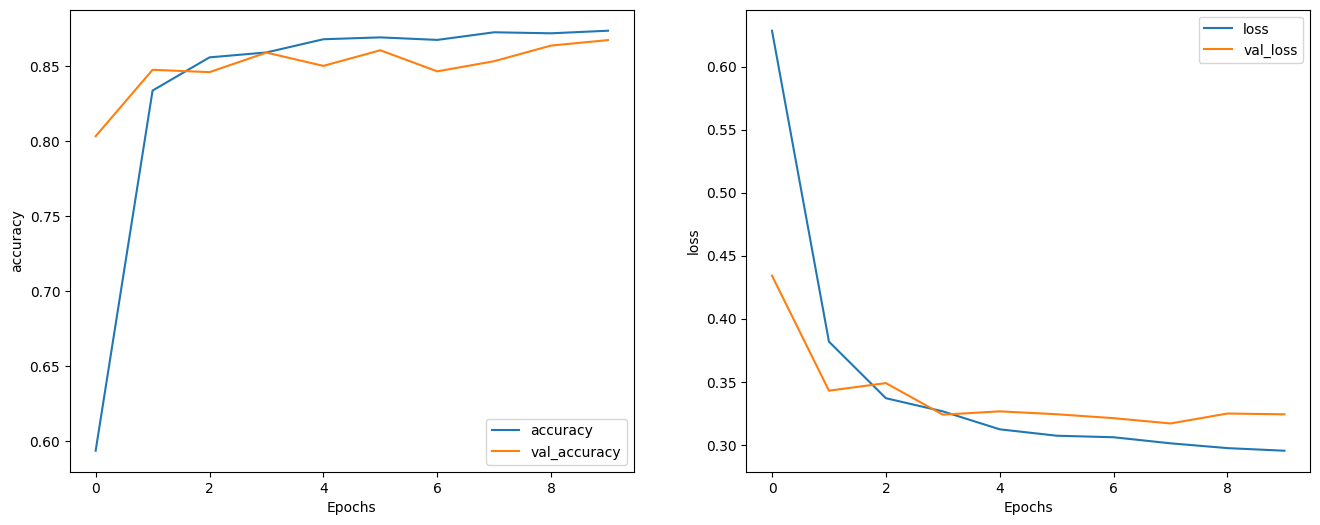

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
